In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
#from keras.models import load_model
#import tensorflow as tf

### William Hill: WHH,WHD,WHA

In [4]:
%run update_stash.py

unzipping  ../../Football_Data/Zipstash\data_0.zip
unzipping  ../../Football_Data/Zipstash\data_1.zip
unzipping  ../../Football_Data/Zipstash\data_10.zip
unzipping  ../../Football_Data/Zipstash\data_11.zip
unzipping  ../../Football_Data/Zipstash\data_12.zip
unzipping  ../../Football_Data/Zipstash\data_13.zip
unzipping  ../../Football_Data/Zipstash\data_14.zip
unzipping  ../../Football_Data/Zipstash\data_15.zip
unzipping  ../../Football_Data/Zipstash\data_16.zip
unzipping  ../../Football_Data/Zipstash\data_17.zip
unzipping  ../../Football_Data/Zipstash\data_18.zip
unzipping  ../../Football_Data/Zipstash\data_19.zip
unzipping  ../../Football_Data/Zipstash\data_2.zip
unzipping  ../../Football_Data/Zipstash\data_20.zip
unzipping  ../../Football_Data/Zipstash\data_21.zip
unzipping  ../../Football_Data/Zipstash\data_22.zip
unzipping  ../../Football_Data/Zipstash\data_23.zip
unzipping  ../../Football_Data/Zipstash\data_24.zip
unzipping  ../../Football_Data/Zipstash\data_25.zip
unzipping  ../.

In [6]:
all_seasons = []
for filename in os.listdir('C:/Users/bfesc/Documents/Football_Data/Stash/'):
    #if filename[0] == 'B':
    with open("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename) as file:
        season = file.read().rstrip().split('\n')
        for i in range(len(season)):
            season[i] = season[i].rstrip(',').split(',')
        all_seasons.append(season)

In [7]:
with open("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename) as file:
    season = file.read().rstrip().split('\n')

In [8]:
#Kvitt deg med trailing commas i update_stash.py så kan du lese inn som pdf.

In [9]:
#pd.read_csv("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename,sep=',',error_bad_lines=False)

In [10]:
columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA']

all_data = pd.DataFrame(columns=columns)
for season in all_seasons:
    if not np.in1d(columns, season[0]).all():
        continue
    if len(season[0]) != max([len(s) for s in season]):
        for i in range(len(season)):
            season[i] = season[i][:len(season[0])]
    df = pd.DataFrame(season[1:])
    df.columns = season[0]
    all_data = all_data.append(df[columns])
    
all_data['Date'] = pd.to_datetime(all_data['Date'], dayfirst=True)
all_data.index = all_data['Date']
all_data = all_data.drop(columns=['Date','Div'])
for column in all_data.columns:
    all_data = all_data[pd.notnull(all_data[column])]
all_data = all_data[pd.notnull(all_data.index)]
all_data = all_data.iloc[np.where(all_data['WHH'] != "")]
all_data = all_data.iloc[np.where(all_data['WHD'] != "")]
all_data = all_data.iloc[np.where(all_data['WHA'] != "")]
all_data = all_data.iloc[np.where(all_data['FTHG'] != "")]
all_data = all_data.sort_index(ascending=False)
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'A')] = -1
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'D')] = 0
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'H')] = 1
all_data['FTHG'] = all_data['FTHG'].astype(int)
all_data['FTAG'] = all_data['FTAG'].astype(int)
all_data['WHH'] = all_data['WHH'].astype(np.float32)
all_data['WHD'] = all_data['WHD'].astype(np.float32)
all_data['WHA'] = all_data['WHA'].astype(np.float32)

In [11]:
model_date = pd.to_datetime('2018-03-28')
day = pd.Timedelta('1d')

new_data = all_data.loc[:model_date + day]
old_data = all_data.loc[model_date - day:]
new_data.shape

(22245, 8)

In [12]:
all_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA
Date,,,,,,,,
2021-04-11,VVV Venlo,PSV Eindhoven,0,2,-1,11.00,5.8,1.25
2021-04-11,Rangers,Hibernian,2,1,1,1.35,4.8,9.00
2021-04-11,Lens,Lorient,4,1,1,1.95,3.4,3.90
2021-04-11,Nice,Reims,0,0,0,2.20,3.2,3.40
2021-04-11,St Etienne,Bordeaux,4,1,1,2.35,3.1,3.20


In [13]:
def make_team_dicts(data):
    all_teams = np.unique(np.append(data['HomeTeam'], data['AwayTeam']))
    team_dict = {}
    
    for team in all_teams:
        team_dict[team] = data.iloc[np.where(np.logical_or(data['HomeTeam'] == team, 
                                                      data['AwayTeam'] == team))].sort_index(ascending=False)
        
    return team_dict

def make_training_set(all_data, n_matches=None):


    
    training_data = []
    kolonner = ['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame', 'HomeTeamOdds', 'AwayTeamOdds', 'Result']
    team_dict = make_team_dicts(all_data)
    
    if n_matches is None:
        n_matches = len(all_data.index)

    history = pd.Timedelta('90d')
    year = pd.Timedelta('365d')

    for i in tqdm(range(n_matches)):#
        game = all_data.iloc[i]

        home_team = game['HomeTeam']
        away_team = game['AwayTeam']
        game_date = game.name 

        ht_games = team_dict[home_team].loc[game_date - pd.Timedelta('1h'):game_date - year]
        at_games = team_dict[away_team].loc[game_date - pd.Timedelta('1h'):game_date - year]

    #     ht_games['FTHG'] = ht_games['FTHG'].values / ht_time_diff
    #     ht_ag = ht_games['FTAG'].values / ht_time_diff

    #     at_hg = at_games['FTHG'].values / at_time_diff
    #     at_ag = at_games['FTAG'].values /at_time_diff

        #result = game['FTR']
        result = game['FTHG'] - game['FTAG']

        ht_hgames = ht_games.iloc[np.where(ht_games['HomeTeam'] == home_team)]
        ht_agames = ht_games.iloc[np.where(ht_games['AwayTeam'] == home_team)]

        at_hgames = at_games.iloc[np.where(at_games['HomeTeam'] == away_team)]
        at_agames = at_games.iloc[np.where(at_games['AwayTeam'] == away_team)]


        if len(ht_hgames) > 1 and len(at_agames) > 1:

            ht_time_diff = np.log((game_date - ht_games.index).days.values + 1)
            at_time_diff = np.log((game_date - at_games.index).days.values + 1)

            ht_h_td = ht_time_diff[np.where(ht_games['HomeTeam'] == home_team)]
            ht_a_td = ht_time_diff[np.where(ht_games['AwayTeam'] == home_team)]
            at_h_td = at_time_diff[np.where(at_games['HomeTeam'] == away_team)]
            at_a_td = at_time_diff[np.where(at_games['AwayTeam'] == away_team)]


            it_games = np.append(np.where(ht_hgames['AwayTeam'] == away_team)[0],
                                 np.where(ht_agames['HomeTeam'] == away_team)[0])

            litgr = 0
            if len(it_games) > 0:
                litgr += np.mean((ht_games['FTHG'].iloc[it_games].values - ht_games['FTAG'].iloc[it_games].values) / ht_time_diff[it_games])

            dslhtm = ht_time_diff[0]
            dslatm = at_time_diff[0]

            ht_form = np.mean(np.append(((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td),
                              (ht_agames['FTAG'].values - ht_agames['FTHG'].values) / ht_a_td))
            at_form = np.mean(np.append((at_hgames['FTHG'].values - at_hgames['FTAG'].values) / at_h_td,
                              (at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td))

            ht_hform = np.mean((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td)
            at_aform = np.mean((at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td)

            hto = np.mean(np.append(ht_hgames['FTHG'].values / ht_h_td, ht_agames['FTAG'].values / ht_a_td))
            htd = -np.mean(np.append(ht_hgames['FTAG'].values / ht_h_td, ht_agames['FTHG'].values /ht_a_td))

            ato = np.mean(np.append(at_hgames['FTHG'] / at_h_td, at_agames['FTAG'].values / at_a_td))
            atd = -np.mean(np.append(at_hgames['FTAG'].values / at_h_td, at_agames['FTHG'].values / at_a_td))
            
            htodd = game['WHH']
            atodd = game['WHA']

            #training_data = training_data.append(pd.DataFrame([[dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
            #                                                    hto, htd, ato, atd, litgr, htodd, atodd, result]], 
            #                                                  columns=training_data.columns))
            training_data.append(dict(zip(kolonner, [dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
                                                    hto, htd, ato, atd, litgr, htodd, atodd, result])))
        else:
            print(home_team,away_team)

    return pd.DataFrame(training_data)
    


In [14]:
#Det er noe rart med william hill

In [15]:
all_data.columns

Index(['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA'], dtype='object')

In [16]:
matches = make_training_set(all_data)#, n_matches=len(new_data.index))
matches.head()

  3%|██▎                                                                         | 4592/151235 [01:13<42:40, 57.27it/s]

Altrincham Solihull


  3%|██▍                                                                         | 4936/151235 [01:18<36:42, 66.42it/s]

Olympiakos Apollon
Cittadella Monza


  3%|██▌                                                                         | 5057/151235 [01:20<38:22, 63.47it/s]

Giannina AEK


  3%|██▌                                                                         | 5161/151235 [01:22<30:29, 79.84it/s]

Monza Chievo
Hamburg Wurzburger Kickers
Spal Vicenza


  3%|██▌                                                                         | 5195/151235 [01:22<36:10, 67.27it/s]

Apollon Giannina


  3%|██▌                                                                         | 5218/151235 [01:23<34:36, 70.32it/s]

Reggina Cosenza
Ascoli Reggiana


  3%|██▋                                                                         | 5242/151235 [01:23<35:01, 69.47it/s]

Vicenza Salernitana


  4%|██▋                                                                         | 5307/151235 [01:24<35:43, 68.08it/s]

Farense Famalicao


  4%|██▋                                                                         | 5345/151235 [01:24<37:52, 64.21it/s]

Albacete Sabadell
Aris Apollon
Volos NFC Giannina
Logrones Leganes


  4%|██▋                                                                         | 5361/151235 [01:25<34:49, 69.80it/s]

Braunschweig Bochum
Sp Braga Nacional


  4%|██▋                                                                         | 5403/151235 [01:25<31:30, 77.12it/s]

Wealdstone Wrexham


  4%|██▋                                                                         | 5419/151235 [01:25<35:24, 68.63it/s]

Virtus Entella Reggina
Reggiana Chievo


  4%|██▋                                                                         | 5443/151235 [01:26<35:01, 69.37it/s]

Barnet Weymouth
Wealdstone Stockport
King’s Lynn Boreham Wood
Fuenlabrada Castellon


  4%|██▋                                                                         | 5459/151235 [01:26<33:39, 72.18it/s]

Ponferradina Cartagena


  4%|██▊                                                                         | 5475/151235 [01:26<32:22, 75.04it/s]

Eastleigh Altrincham
Solihull King’s Lynn
Dag and Red Wealdstone
Weymouth Sutton
Logrones Almeria
Sabadell Mirandes


  4%|██▊                                                                         | 5500/151235 [01:27<33:48, 71.85it/s]

Notts County Altrincham
Weymouth Woking
Maidenhead King’s Lynn
Yeovil Wealdstone


  4%|██▊                                                                         | 5516/151235 [01:27<34:00, 71.41it/s]

Alanyaspor Hatayspor


  4%|██▊                                                                         | 5531/151235 [01:27<36:37, 66.30it/s]

Benfica Farense
Nacional Belenenses


  4%|██▊                                                                         | 5546/151235 [01:27<36:23, 66.73it/s]

Apollon Larisa
Giannina Olympiakos
Cartagena Lugo
Wurzburger Kickers Greuther Furth


  4%|██▊                                                                         | 5561/151235 [01:27<35:50, 67.74it/s]

Castellon Leganes
Sabadell Espanol
Las Palmas Logrones


  4%|██▊                                                                         | 5593/151235 [01:28<35:55, 67.58it/s]

Hannover Braunschweig
King’s Lynn Yeovil
Altrincham Weymouth


  4%|██▊                                                                         | 5633/151235 [01:28<31:30, 77.00it/s]

Reggina Pescara
Empoli Monza


  4%|██▊                                                                         | 5643/151235 [01:29<29:49, 81.35it/s]

Virtus Entella Reggiana
Vicenza Pordenone
Erzurum BB Rizespor
Fenerbahce Karagumruk


  4%|██▊                                                                         | 5716/151235 [01:30<35:49, 67.68it/s]

Farense Nacional
Aris Giannina


  4%|██▉                                                                         | 5756/151235 [01:30<33:29, 72.39it/s]

Reggiana Pisa


  4%|██▉                                                                         | 5799/151235 [01:31<32:09, 75.36it/s]

Rodez Dunkerque
Venezia Vicenza
Salernitana Reggina


  4%|██▉                                                                         | 5823/151235 [01:31<35:48, 67.69it/s]

Kayserispor Erzurum BB
Hatayspor Kasimpasa


  4%|██▉                                                                         | 5838/151235 [01:31<34:57, 69.31it/s]

Fortuna Dusseldorf Wurzburger Kickers
Braunschweig Holstein Kiel
Karagumruk Buyuksehyr
Monza Spal


  4%|██▉                                                                         | 5869/151235 [01:32<36:00, 67.29it/s]

Fenerbahce Hatayspor
Erzurum BB Sivasspor
Gaziantep Karagumruk
Cartagena Sp Gijon


  4%|██▉                                                                         | 5900/151235 [01:32<35:32, 68.15it/s]

Moreirense Farense
Heidenheim Braunschweig


  4%|██▉                                                                         | 5924/151235 [01:33<37:49, 64.02it/s]

Vallecano Sabadell
Castellon Malaga
Wurzburger Kickers Erzgebirge Aue


  4%|██▉                                                                         | 5945/151235 [01:33<37:00, 65.44it/s]

Nacional Boavista
Pau FC Guingamp
Dunkerque Valenciennes


  4%|███                                                                         | 6021/151235 [01:34<37:27, 64.61it/s]

Hatayspor Buyuksehyr
Ankaragucu

  4%|███                                                                         | 6038/151235 [01:34<34:07, 70.92it/s]

 Erzurum BB
Oviedo

  4%|███                                                                         | 6046/151235 [01:35<38:05, 63.53it/s]

 Cartagena
Troyes Pau FC


  4%|███                                                                         | 6117/151235 [01:36<33:25, 72.35it/s]

Ponferradina Castellon
Sp Gijon Logrones
Karagumruk Yeni Malatyaspor


  4%|███                                                                         | 6141/151235 [01:36<34:22, 70.34it/s]

Beerschot VA Standard
Dunkerque Clermont
Pau FC Rodez


  4%|███                                                                         | 6164/151235 [01:36<35:32, 68.01it/s]

Waasland-Beveren Oud-Heverlee Leuven
Club Brugge Beerschot VA


  4%|███                                                                         | 6186/151235 [01:37<35:37, 67.85it/s]

Valenciennes Pau FC
Oud-Heverlee Leuven Charleroi
Toulouse Dunkerque


  4%|███                                                                         | 6210/151235 [01:37<33:12, 72.80it/s]

Beerschot VA Waregem
Genk Oud-Heverlee Leuven
Oostende Beerschot VA
Oud-Heverlee Leuven Eupen


  8%|█████▊                                                                     | 11756/151235 [03:00<34:57, 66.51it/s]

Trapani Salernitana


  8%|█████▊                                                                     | 11841/151235 [03:02<34:35, 67.16it/s]

Chievo Pisa
Pescara Virtus Entella
Livorno Pordenone
Juve Stabia Ascoli


  8%|█████▉                                                                     | 11903/151235 [03:03<35:18, 65.75it/s]

Volos NFC OFI Crete


  8%|█████▉                                                                     | 12018/151235 [03:04<33:11, 69.90it/s]

Pisa Cremonese
Trabzonspor Genclerbirligi
Denizlispor Konyaspor


  8%|█████▉                                                                     | 12052/151235 [03:05<30:29, 76.08it/s]

Famalicao Pacos Ferreira
Benfica Gil Vicente
Virtus Entella Frosinone
Cittadella Trapani
Perugia Juve Stabia


  8%|██████                                                                     | 12131/151235 [03:06<33:48, 68.58it/s]

Olympiakos Volos NFC
Gaziantep Besiktas


  8%|██████                                                                     | 12164/151235 [03:06<33:09, 69.89it/s]

Pordenone Spezia
Vallecano Santander
Mirandes

  8%|██████                                                                     | 12182/151235 [03:07<31:00, 74.74it/s]

 Oviedo


  8%|██████                                                                     | 12215/151235 [03:07<31:54, 72.63it/s]

Fuenlabrada Ponferradina


  8%|██████                                                                     | 12231/151235 [03:07<35:51, 64.60it/s]

Juve Stabia Pisa
Pescara Pordenone


  8%|██████                                                                     | 12253/151235 [03:08<34:50, 66.49it/s]

Sparta Rotterdam Ajax
Ponferradina Tenerife


  8%|██████                                                                     | 12268/151235 [03:08<33:30, 69.12it/s]

Genclerbirligi Buyuksehyr
Sivasspor Gaziantep


  8%|██████                                                                     | 12284/151235 [03:08<34:21, 67.41it/s]

Las Palmas Santander


  8%|██████                                                                     | 12306/151235 [03:08<36:42, 63.07it/s]

Pacos Ferreira Maritimo
Volos NFC Aris


  8%|██████▏                                                                    | 12361/151235 [03:09<34:05, 67.89it/s]

Goztep Denizlispor
Numancia Mirandes
Fuenlabrada Oviedo
Cremonese

  8%|██████▏                                                                    | 12376/151235 [03:09<33:28, 69.13it/s]

 Virtus Entella
Trapani Venezia


  8%|██████▏                                                                    | 12434/151235 [03:10<34:52, 66.35it/s]

Gaziantep Genclerbirligi
Pordenone Frosinone


  8%|██████▏                                                                    | 12457/151235 [03:11<34:15, 67.51it/s]

Empoli Juve Stabia
Nurnberg Osnabruck
Panionios

  8%|██████▏                                                                    | 12464/151235 [03:11<39:30, 58.55it/s]

 Volos NFC
Waalwijk

  8%|██████▏                                                                    | 12479/151235 [03:11<36:35, 63.20it/s]

 Den Haag
Antalyaspor Denizlispor
Guimaraes Famalicao
Gil Vicente Sp Braga
Extremadura UD Fuenlabrada
Ponferradina

  8%|██████▏                                                                    | 12494/151235 [03:11<36:30, 63.34it/s]

 Zaragoza
Karlsruhe Hamburg


  8%|██████▏                                                                    | 12526/151235 [03:12<31:45, 72.80it/s]

Boavista Pacos Ferreira
Santander Almeria
Mirandes Cadiz


  8%|██████▏                                                                    | 12587/151235 [03:13<34:58, 66.08it/s]

Bochum Wehen
Heerenveen Twente


  8%|██████▏                                                                    | 12596/151235 [03:13<32:51, 70.34it/s]

Stirling Cove Rangers
Ascoli Trapani
Virtus Entella Livorno


  8%|██████▎                                                                    | 12620/151235 [03:13<32:43, 70.60it/s]

Pisa Benevento


  8%|██████▎                                                                    | 12669/151235 [03:14<34:01, 67.89it/s]

Fenerbahce Gaziantep
Osnabruck Darmstadt
Pacos Ferreira Santa Clara
Holstein Kiel

  8%|██████▎                                                                    | 12677/151235 [03:14<34:46, 66.40it/s]

 Karlsruhe
Cadiz Ponferradina


  8%|██████▎                                                                    | 12701/151235 [03:14<33:53, 68.12it/s]

Twente Waalwijk


  8%|██████▎                                                                    | 12718/151235 [03:14<31:20, 73.65it/s]

Wehen Hannover
Mechelen Cercle Brugge


  8%|██████▎                                                                    | 12733/151235 [03:15<34:21, 67.18it/s]

Genclerbirligi Rizespor
Santander Malaga
Elche Fuenlabrada
Vallecano

  8%|██████▎                                                                    | 12747/151235 [03:15<36:41, 62.92it/s]

 Mirandes


  8%|██████▎                                                                    | 12795/151235 [03:16<31:20, 73.61it/s]

Moreirense Gil Vicente
Cove Rangers Cowdenbeath


  8%|██████▎                                                                    | 12812/151235 [03:16<32:25, 71.15it/s]

Den Haag Sparta Rotterdam
Denizlispor Galatasaray
Nancy Le Mans
Valenciennes Rodez
Famalicao Rio Ave
Caen Chambly


  8%|██████▎                                                                    | 12829/151235 [03:16<32:17, 71.44it/s]

Stockport Barrow
Chesterfield Woking
Torquay Maidenhead
Chorley Solihull


  8%|██████▎                                                                    | 12853/151235 [03:16<35:12, 65.49it/s]

Waalwijk AZ Alkmaar


  9%|██████▍                                                                    | 12867/151235 [03:17<39:01, 59.10it/s]

Benfica Pacos Ferreira


  9%|██████▍                                                                    | 12893/151235 [03:17<32:45, 70.37it/s]

Albion Rvs Cove Rangers
Gil Vicente Porto
Sutton Chorley
Santa Clara Famalicao
Yeovil Stockport
Woking Harrogate


  9%|██████▍                                                                    | 12901/151235 [03:17<32:25, 71.12it/s]

Bromley Torquay


  9%|██████▍                                                                    | 12931/151235 [03:18<34:00, 67.77it/s]

Groningen Twente


  9%|██████▍                                                                    | 12956/151235 [03:18<30:34, 75.36it/s]

Le Mans Valenciennes
Rodez Paris FC
Sparta Rotterdam VVV Venlo
Anderlecht Mechelen
Chambly Grenoble
Woking Aldershot
Fylde

  9%|██████▍                                                                    | 12972/151235 [03:18<31:49, 72.41it/s]

 Chorley
Solihull Torquay
Notts County Stockport
Erzgebirge Aue Wehen


  9%|██████▍                                                                    | 12988/151235 [03:18<33:06, 69.61it/s]

Feyenoord Sparta Rotterdam
Mechelen Genk


  9%|██████▍                                                                    | 13005/151235 [03:19<31:20, 73.52it/s]

Twente PSV Eindhoven
VVV Venlo Waalwijk


  9%|██████▍                                                                    | 13039/151235 [03:19<29:05, 79.18it/s]

Chorley Bromley
Cove Rangers Edinburgh City
Karlsruhe Dresden
Dag and Red Woking


  9%|██████▍                                                                    | 13056/151235 [03:19<32:18, 71.27it/s]

Torquay Boreham Wood
Stockport Maidenhead
Sandhausen Osnabruck


  9%|██████▍                                                                    | 13072/151235 [03:20<32:58, 69.84it/s]

Auxerre Le Mans
Orleans Chambly
Chateauroux Rodez


  9%|██████▍                                                                    | 13087/151235 [03:20<36:07, 63.73it/s]

Wehen Karlsruhe
Osnabruck Heidenheim
Waregem Mechelen
Le Mans Lens
Rodez Auxerre


  9%|██████▍                                                                    | 13102/151235 [03:20<36:17, 63.44it/s]

Chambly Valenciennes


 13%|█████████▍                                                                 | 18992/151235 [04:49<33:36, 65.59it/s]

Erzurum BB Alanyaspor


 13%|█████████▌                                                                 | 19305/151235 [04:54<31:53, 68.95it/s]

OFI Crete AEK


 13%|█████████▌                                                                 | 19407/151235 [04:56<34:23, 63.88it/s]

Livorno Lecce


 13%|█████████▋                                                                 | 19450/151235 [04:56<38:35, 56.91it/s]

Padova Cremonese


 13%|█████████▋                                                                 | 19494/151235 [04:57<34:42, 63.27it/s]

Lecce Venezia


 13%|█████████▋                                                                 | 19523/151235 [04:58<35:30, 61.82it/s]

Cosenza Livorno


 13%|█████████▋                                                                 | 19539/151235 [04:58<32:30, 67.52it/s]

Giannina Aris


 13%|█████████▋                                                                 | 19608/151235 [04:59<36:20, 60.38it/s]

Erzurum BB Ankaragucu


 13%|█████████▋                                                                 | 19635/151235 [04:59<30:41, 71.45it/s]

Livorno Crotone
Beziers Metz
Aris Levadeiakos
Salernitana Padova


 13%|█████████▋                                                                 | 19643/151235 [04:59<31:09, 70.37it/s]

Rizespor Bursaspor


 13%|█████████▋                                                                 | 19659/151235 [05:00<33:40, 65.11it/s]

Sivasspor Erzurum BB


 13%|█████████▊                                                                 | 19699/151235 [05:00<30:29, 71.91it/s]

Cittadella Cosenza


 13%|█████████▊                                                                 | 19767/151235 [05:01<32:56, 66.50it/s]

OFI Crete PAOK


 13%|█████████▊                                                                 | 19791/151235 [05:02<30:50, 71.01it/s]

Ascoli Lecce


 13%|█████████▊                                                                 | 19817/151235 [05:02<30:37, 71.53it/s]

Rayo Majadahonda Lugo
Extremadura UD Granada
Numancia Elche


 13%|█████████▊                                                                 | 19861/151235 [05:03<35:28, 61.71it/s]

Mallorca Cadiz
Holstein Kiel

 13%|█████████▊                                                                 | 19877/151235 [05:03<34:34, 63.32it/s]

 Magdeburg
Panetolikos OFI Crete
Aris Larisa
Pescara

 13%|█████████▊                                                                 | 19886/151235 [05:03<31:37, 69.23it/s]

 Livorno
Kasimpasa Ankaragucu
Lecce Salernitana
Antalyaspor Rizespor


 13%|█████████▊                                                                 | 19901/151235 [05:03<33:51, 64.65it/s]

Sp Gijon Extremadura UD
Gimnastic Rayo Majadahonda
Nacional Benfica


 13%|█████████▉                                                                 | 19946/151235 [05:04<35:07, 62.29it/s]

Elche Reus Deportiu
For Sittard Utrecht


 13%|█████████▉                                                                 | 19977/151235 [05:04<33:43, 64.88it/s]

Padova Venezia
Cosenza Verona


 13%|█████████▉                                                                 | 20018/151235 [05:05<31:54, 68.54it/s]

Santa Clara Boavista


 13%|█████████▉                                                                 | 20048/151235 [05:06<33:03, 66.13it/s]

FC Emmen Graafschap
Alcorcon Mallorca
Paderborn

 13%|█████████▉                                                                 | 20065/151235 [05:06<30:45, 71.08it/s]

 Bochum
Benevento Lecce
Lamia Aris


 13%|█████████▉                                                                 | 20089/151235 [05:06<31:45, 68.84it/s]

Rayo Majadahonda Mallorca
Setubal Nacional


 13%|█████████▉                                                                 | 20119/151235 [05:07<32:15, 67.73it/s]

Panionios OFI Crete
Ascoli Cosenza
Osasuna Elche
Verona Padova


 13%|█████████▉                                                                 | 20154/151235 [05:07<27:25, 79.66it/s]

Magdeburg Ingolstadt
Portimonense Santa Clara
Greuther Furth Paderborn


 13%|██████████                                                                 | 20193/151235 [05:08<34:57, 62.48it/s]

Ankaragucu Trabzonspor


 13%|██████████                                                                 | 20251/151235 [05:08<30:14, 72.19it/s]

Ajax FC Emmen
Graafschap Groningen
Den Haag For Sittard


 13%|██████████                                                                 | 20276/151235 [05:09<30:28, 71.63it/s]

Extremadura UD La Coruna


 13%|██████████                                                                 | 20324/151235 [05:10<32:33, 67.03it/s]

Alanyaspor Ankaragucu
Oviedo Extremadura UD
Akhisar Belediyespor Rizespor
Nacional

 13%|██████████                                                                 | 20341/151235 [05:10<30:29, 71.56it/s]

 Moreirense
Santa Clara Sp Braga
Mallorca Osasuna


 13%|██████████                                                                 | 20349/151235 [05:10<32:01, 68.11it/s]

FC Emmen AZ Alkmaar
Zaragoza Rayo Majadahonda


 13%|██████████                                                                 | 20411/151235 [05:11<29:20, 74.33it/s]

Elche Granada
For Sittard PSV Eindhoven
Cercle Brugge Waregem
NAC Breda Graafschap


 14%|██████████▏                                                                | 20444/151235 [05:11<29:36, 73.64it/s]

Chateauroux Red Star
Ajaccio GFCO Grenoble


 14%|██████████▏                                                                | 20469/151235 [05:12<30:52, 70.59it/s]

Dover Athletic Havant & Waterlooville
Braintree Town Hartlepool
Harrogate Barnet
Salford Halifax


 14%|██████████▏                                                                | 20485/151235 [05:12<30:44, 70.87it/s]

Den Haag FC Emmen
Graafschap Feyenoord
Konyaspor Erzurum BB
Sp Braga Nacional
Maritimo Santa Clara


 14%|██████████▏                                                                | 20501/151235 [05:12<30:44, 70.89it/s]

Erzgebirge Aue Magdeburg


 14%|██████████▏                                                                | 20532/151235 [05:13<31:36, 68.91it/s]

Standard Cercle Brugge


 14%|██████████▏                                                                | 20555/151235 [05:13<32:42, 66.57it/s]

Excelsior For Sittard


 14%|██████████▏                                                                | 20578/151235 [05:13<32:36, 66.78it/s]

Bromley Harrogate
Chesterfield Braintree Town
Havant & Waterlooville Fylde
Sutton Salford


 14%|██████████▏                                                                | 20594/151235 [05:13<32:05, 67.83it/s]

Rizespor Kasimpasa
Paderborn

 14%|██████████▏                                                                | 20610/151235 [05:14<32:11, 67.63it/s]

 Regensburg
Red Star Le Havre
Troyes Beziers
Ankaragucu Galatasaray
Grenoble Niort


 14%|██████████▏                                                                | 20627/151235 [05:14<29:15, 74.39it/s]

Havant & Waterlooville Boreham Wood
Hartlepool Harrogate
Gateshead Salford
Barnet Braintree Town
Darmstadt Paderborn


 14%|██████████▏                                                                | 20643/151235 [05:14<30:57, 70.32it/s]

Magdeburg St Pauli


 14%|██████████▏                                                                | 20659/151235 [05:14<33:43, 64.52it/s]

Cercle Brugge Lokeren


 14%|██████████▎                                                                | 20684/151235 [05:15<31:26, 69.21it/s]

Beziers Ajaccio
Braintree Town Halifax
Barrow Havant & Waterlooville
Lens Red Star


 14%|██████████▎                                                                | 20699/151235 [05:15<32:35, 66.74it/s]

Harrogate Sutton


 14%|██████████▎                                                                | 20713/151235 [05:15<36:22, 59.80it/s]

Salford Leyton Orient
Le Havre Grenoble


 14%|██████████▎                                                                | 20734/151235 [05:16<36:41, 59.28it/s]

St Truiden Cercle Brugge
Grenoble Sochaux
Nancy Beziers
Red Star Niort


 18%|█████████████▎                                                            | 27188/151235 [06:21<19:17, 107.14it/s]

Apollon Platanias


 18%|█████████████▌                                                             | 27373/151235 [06:23<22:55, 90.02it/s]

Lamia AEK
Cremonese Carpi
Foggia

 18%|█████████████▌                                                             | 27404/151235 [06:23<21:52, 94.36it/s]

 Palermo
Perugia Parma


 18%|█████████████▍                                                            | 27528/151235 [06:25<18:54, 109.05it/s]

Venezia Spezia


 18%|█████████████▍                                                            | 27584/151235 [06:25<19:52, 103.65it/s]

Kasimpasa Yeni Malatyaspor
Apollon PAOK
Groningen VVV Venlo
AZ Alkmaar NAC Breda


 18%|█████████████▌                                                            | 27607/151235 [06:25<20:01, 102.90it/s]

Parma Brescia
Albacete Lugo
Osmanlispor Goztep
Leonesa Valladolid


 18%|█████████████▌                                                            | 27641/151235 [06:26<19:32, 105.37it/s]

Pro Vercelli Cremonese
Bari Venezia
Avellino Foggia


 18%|█████████████▌                                                            | 27663/151235 [06:26<19:59, 103.02it/s]

Barcelona B Cordoba
Almeria Lorca
Asteras Tripolis Lamia
Sivasspor Kayserispor


 18%|█████████████▌                                                            | 27782/151235 [06:27<17:00, 120.95it/s]

Alcorcon Albacete
Sevilla B Leonesa
Novara Parma
Foggia Virtus Entella
Cremonese Avellino
Cesena Venezia


 18%|█████████████▌                                                            | 27819/151235 [06:27<19:22, 106.21it/s]

Lorca Vallecano
Granada Barcelona B
Portimonense Maritimo


 18%|█████████████▌                                                            | 27841/151235 [06:27<19:47, 103.88it/s]

Barcelona B Tenerife


 18%|█████████████▋                                                            | 27875/151235 [06:28<19:46, 103.97it/s]

VVV Venlo Ajax
Pescara Foggia
Panionios Apollon


 18%|█████████████▋                                                            | 27897/151235 [06:28<20:14, 101.57it/s]

Boavista Aves


 18%|█████████████▊                                                             | 27929/151235 [06:28<21:09, 97.12it/s]

Leonesa Osasuna


 18%|█████████████▋                                                            | 27973/151235 [06:29<20:03, 102.43it/s]

Huesca Lorca
Regensburg Holstein Kiel
Goztep Trabzonspor
Yeni Malatyaspor Antalyaspor


 19%|█████████████▋                                                            | 28006/151235 [06:29<20:15, 101.36it/s]

Venezia Salernitana
Lamia Olympiakos
NAC Breda Sparta Rotterdam
Galatasaray

 19%|█████████████▉                                                             | 28017/151235 [06:29<20:56, 98.06it/s]

 Sivasspor
Albacete Cordoba
Parma Cremonese
Duisburg Darmstadt


 19%|█████████████▋                                                            | 28041/151235 [06:29<19:49, 103.60it/s]

Chateauroux Nimes
Atromitos Apollon
NAC Breda PSV Eindhoven
Holstein Kiel Greuther Furth


 19%|█████████████▋                                                            | 28074/151235 [06:30<20:03, 102.32it/s]

Aves Sp Braga
Granada Albacete
Kayserispor Goztep
Ingolstadt Regensburg


 19%|█████████████▊                                                            | 28109/151235 [06:30<19:16, 106.42it/s]

Valladolid Barcelona B
Mechelen Antwerp
Xanthi Lamia


 19%|█████████████▊                                                            | 28154/151235 [06:31<19:59, 102.59it/s]

Twente VVV Venlo
Sivasspor Yeni Malatyaspor
Heidenheim Duisburg


 19%|█████████████▉                                                             | 28219/151235 [06:31<21:35, 94.95it/s]

Lorca Leonesa
Rio Ave Portimonense
Ajaccio Paris FC
Ajaccio GFCO Quevilly Rouen


 19%|██████████████                                                             | 28248/151235 [06:32<23:32, 87.05it/s]

Halifax Dover Athletic
Fylde Maidenhead
Dag and Red Ebbsfleet
Lorient Chateauroux


 19%|██████████████                                                             | 28270/151235 [06:32<21:23, 95.81it/s]

Pacos Ferreira Aves
Sp Braga Portimonense
Antwerp Genk
Yeni Malatyaspor Osmanlispor


 19%|██████████████                                                             | 28291/151235 [06:32<21:17, 96.23it/s]

Maidenhead Hartlepool
Ebbsfleet Fylde


 19%|██████████████                                                             | 28323/151235 [06:32<21:03, 97.30it/s]

Chester Halifax


 19%|██████████████                                                             | 28355/151235 [06:33<20:43, 98.81it/s]

Vitesse NAC Breda
VVV Venlo Sparta Rotterdam
Akhisar Belediyespor Sivasspor
Goztep Fenerbahce


 19%|█████████████▉                                                            | 28398/151235 [06:33<19:39, 104.12it/s]

Quevilly Rouen Bourg Peronnas
Paris FC Le Havre
Chester Fylde
Barrow Halifax
Ebbsfleet Maidstone
Maidenhead Wrexham
Portimonense Boavista


 19%|█████████████▉                                                            | 28420/151235 [06:33<20:05, 101.87it/s]

Regensburg Nurnberg
Aves Sp Lisbon
Gent Antwerp


 19%|█████████████▉                                                            | 28477/151235 [06:34<19:05, 107.18it/s]

Duisburg Bochum
Maidstone Maidenhead
Halifax Aldershot
Guiseley Ebbsfleet
Fylde Boreham Wood


 19%|█████████████▉                                                            | 28512/151235 [06:34<19:13, 106.38it/s]

Chateauroux Valenciennes
Bourg Peronnas Paris FC
Quevilly Rouen Sochaux
Union Berlin Holstein Kiel


 19%|█████████████▉                                                            | 28534/151235 [06:34<19:31, 104.73it/s]

Holstein Kiel Sandhausen
Dresden Duisburg
Lorient Quevilly Rouen
Bielefeld Regensburg
Brest Chateauroux
Paris FC Clermont
Antwerp Anderlecht


 23%|████████████████▊                                                         | 34470/151235 [07:32<15:32, 125.18it/s]

Panetolikos Kerkyra


 23%|█████████████████                                                         | 34791/151235 [07:35<15:43, 123.44it/s]

Levadeiakos Larisa


 23%|█████████████████                                                         | 34922/151235 [07:36<15:48, 122.58it/s]

Larisa Olympiakos
Levadeiakos Kerkyra


 23%|█████████████████▏                                                        | 35168/151235 [07:38<15:59, 120.98it/s]

Kerkyra Larisa
Osmanlispor Adanaspor


 23%|█████████████████▏                                                        | 35246/151235 [07:39<15:58, 121.07it/s]

Cittadella Novara
Latina Benevento
Pisa Brescia
Spal Virtus Entella


 23%|█████████████████▎                                                        | 35272/151235 [07:39<16:12, 119.28it/s]

Alanyaspor Trabzonspor


 23%|█████████████████▎                                                        | 35361/151235 [07:39<16:01, 120.48it/s]

Karabukspor Antalyaspor


 23%|█████████████████▎                                                        | 35387/151235 [07:40<15:43, 122.80it/s]

Larisa Iraklis
Virtus Entella Pisa
Feirense Tondela
Hannover Dresden
UCAM Murcia Elche
Chaves Setubal


 23%|█████████████████▎                                                        | 35412/151235 [07:40<16:24, 117.62it/s]

Cadiz Getafe


 23%|█████████████████▎                                                        | 35473/151235 [07:40<16:18, 118.31it/s]

Lugo Sevilla B
Ascoli Spal
Benevento Verona
Reus Deportiu Numancia
Adanaspor

 23%|█████████████████▎                                                        | 35498/151235 [07:41<16:16, 118.48it/s]

 Gaziantepspor
Genclerbirligi Alanyaspor
Besiktas Karabukspor


 24%|█████████████████▍                                                        | 35563/151235 [07:41<16:07, 119.54it/s]

Pro Vercelli Cittadella
Kerkyra Platanias
Wurzburger Kickers Bochum


 24%|█████████████████▍                                                        | 35588/151235 [07:41<16:25, 117.29it/s]

Erzgebirge Aue Braunschweig
Ternana Pisa
Carpi Benevento
Spal Vicenza
Pisa Novara
Cittadella Ternana
Nacional Chaves
Mirandes Cadiz
Getafe Reus Deportiu


 24%|█████████████████▍                                                        | 35639/151235 [07:42<16:25, 117.26it/s]

Sevilla B UCAM Murcia
Cadiz Mallorca
UCAM Murcia Cordoba


 24%|█████████████████▍                                                        | 35679/151235 [07:42<15:51, 121.46it/s]

Go Ahead Eagles Ajax
Boavista Chaves
Dresden St Pauli
Rio Ave Feirense
Karabukspor Rizespor


 24%|█████████████████▍                                                        | 35731/151235 [07:43<15:41, 122.64it/s]

Greuther Furth Erzgebirge Aue
Reus Deportiu Mirandes
Lokeren

 24%|█████████████████▍                                                        | 35757/151235 [07:43<15:45, 122.15it/s]

 Mouscron
Bari Cittadella


 24%|█████████████████▌                                                        | 35796/151235 [07:43<15:40, 122.79it/s]

Kasimpasa Adanaspor
Twente Sparta Rotterdam
Benevento Spal
Edinburgh City Berwick


 24%|█████████████████▌                                                        | 35834/151235 [07:43<16:17, 118.09it/s]

Tenerife Sevilla B
Alanyaspor Antalyaspor
Heidenheim Wurzburger Kickers
Galatasaray Karabukspor
Zaragoza UCAM Murcia


 24%|█████████████████▌                                                        | 35873/151235 [07:44<15:34, 123.47it/s]

Eupen Anderlecht
Sevilla B Girona
Sparta Rotterdam Go Ahead Eagles
Feirense Moreirense


 24%|█████████████████▌                                                        | 35899/151235 [07:44<16:02, 119.85it/s]

Cowdenbeath Edinburgh City
Besiktas Alanyaspor
Mallorca Reus Deportiu
Lens Amiens


 24%|█████████████████▌                                                        | 35937/151235 [07:44<16:48, 114.36it/s]

Chaves Tondela


 24%|█████████████████▌                                                        | 36000/151235 [07:45<15:53, 120.87it/s]

Sochaux Orleans
Almeria Cadiz
Strasbourg Nimes
Adanaspor Bursaspor


 24%|█████████████████▋                                                        | 36039/151235 [07:45<15:46, 121.70it/s]

Wrexham Solihull
Sutton Torquay
North Ferriby Guiseley
Maidstone Braintree Town
Estoril Feirense


 24%|█████████████████▋                                                        | 36064/151235 [07:45<16:35, 115.65it/s]

Union Berlin Dresden
Go Ahead Eagles Nijmegen
Wurzburger Kickers Kaiserslautern
Oostende Mouscron


 24%|█████████████████▋                                                        | 36115/151235 [07:46<15:48, 121.35it/s]

Lincoln Sutton
Solihull Bromley
Chester Maidstone
Dover Athletic North Ferriby


 24%|█████████████████▋                                                        | 36155/151235 [07:46<15:50, 121.05it/s]

Zwolle Sparta Rotterdam
Elgin Edinburgh City
Westerlo Eupen
Erzgebirge Aue Sandhausen


 24%|█████████████████▋                                                        | 36194/151235 [07:46<15:36, 122.78it/s]

Amiens Niort
Orleans Ajaccio
Tours Strasbourg
Forest Green Sutton
Aldershot Maidstone
Lincoln North Ferriby
Solihull Woking
Braunschweig Wurzburger Kickers
Sparta Rotterdam

 24%|█████████████████▋                                                        | 36207/151235 [07:47<15:49, 121.12it/s]

 Ajax
Heidenheim Erzgebirge Aue


 24%|█████████████████▋                                                        | 36246/151235 [07:47<15:52, 120.72it/s]

Mouscron Charleroi
Eupen Mechelen
Den Haag Go Ahead Eagles
Dresden Nurnberg
Sutton Solihull


 24%|█████████████████▋                                                        | 36271/151235 [07:47<17:21, 110.38it/s]

Edinburgh City Forfar
Strasbourg Amiens
North Ferriby Braintree Town
Maidstone York


 24%|█████████████████▊                                                        | 36308/151235 [07:48<16:50, 113.72it/s]

Brest Orleans
Amiens Reims
Mouscron Anderlecht
Waregem Eupen
Bourg Peronnas Strasbourg
Orleans

 24%|█████████████████▊                                                        | 36332/151235 [07:48<16:51, 113.55it/s]

 Le Havre


 28%|████████████████████▉                                                     | 42677/151235 [08:41<15:11, 119.13it/s]

Ponferradina Ath Bilbao B


 28%|████████████████████▉                                                     | 42803/151235 [08:42<16:26, 109.93it/s]

PAOK AEK
Pescara Salernitana
Como Trapani
Latina Ascoli


 28%|████████████████████▉                                                     | 42828/151235 [08:42<16:13, 111.35it/s]

Platanias Iraklis
Avellino Novara


 28%|█████████████████████                                                     | 42927/151235 [08:43<14:49, 121.81it/s]

Novara Virtus Entella
Vicenza Como
Salernitana Spezia
Ascoli

 28%|█████████████████████                                                     | 42940/151235 [08:43<14:44, 122.50it/s]

 Cesena


 28%|█████████████████████                                                     | 43073/151235 [08:44<14:17, 126.13it/s]

Ascoli Virtus Entella
Iraklis Levadeiakos
Kayserispor Trabzonspor


 28%|█████████████████████                                                     | 43099/151235 [08:44<14:43, 122.46it/s]

Guimaraes Tondela
Moreirense Uniao Madeira
Osmanlispor Konyaspor
AEK

 29%|█████████████████████                                                     | 43125/151235 [08:44<15:07, 119.12it/s]

 Giannina
Girona Huesca
Tenerife Oviedo
Elche Gimnastic


 29%|█████████████████████                                                     | 43162/151235 [08:45<14:59, 120.14it/s]

Valladolid Ath Bilbao B


 29%|█████████████████████▏                                                    | 43202/151235 [08:45<14:27, 124.48it/s]

Brescia Salernitana
Graafschap AZ Alkmaar
Como Livorno
Crotone Novara


 29%|█████████████████████▏                                                    | 43228/151235 [08:45<15:30, 116.11it/s]

Antalyaspor Eskisehirspor
Virtus Lanciano Ascoli


 29%|█████████████████████▏                                                    | 43266/151235 [08:46<14:56, 120.38it/s]

Le Havre Red Star
Novara Latina
Oviedo

 29%|█████████████████████▏                                                    | 43292/151235 [08:46<14:53, 120.84it/s]

 Albacete
Perugia Como
Ath Bilbao B Mallorca
Salernitana Avellino


 29%|█████████████████████▏                                                    | 43345/151235 [08:46<15:12, 118.30it/s]

Gimnastic Girona
Huesca Tenerife


 29%|█████████████████████▏                                                    | 43370/151235 [08:46<15:08, 118.76it/s]

Uniao Madeira Guimaraes
Alaves Oviedo
Tenerife Gimnastic
Sivasspor Osmanlispor
Iraklis Panionios
AZ Alkmaar Roda
Fenerbahce Antalyaspor


 29%|█████████████████████▏                                                    | 43421/151235 [08:47<14:56, 120.23it/s]

Tondela Nacional
Xanthi AEK


 29%|█████████████████████▎                                                    | 43459/151235 [08:47<16:17, 110.31it/s]

Albacete Huesca


 29%|█████████████████████▎                                                    | 43536/151235 [08:48<15:05, 119.00it/s]

Mersin Idman Yurdu Kayserispor
Willem II Nijmegen
Galatasaray Osmanlispor
Ath Bilbao B Girona


 29%|█████████████████████▎                                                    | 43562/151235 [08:48<14:54, 120.42it/s]

Antalyaspor Genclerbirligi
Nijmegen Ajax
Nacional Uniao Madeira
Oviedo Lugo
Gimnastic

 29%|█████████████████████▎                                                    | 43587/151235 [08:48<15:07, 118.58it/s]

 Albacete
Boavista Tondela


 29%|█████████████████████▎                                                    | 43626/151235 [08:49<14:40, 122.24it/s]

Huesca Alaves
Karlsruhe Duisburg


 29%|█████████████████████▍                                                    | 43704/151235 [08:49<14:38, 122.36it/s]

Roda Graafschap
Kayserispor Konyaspor
Kallonis Iraklis
AEK Platanias


 29%|█████████████████████▍                                                    | 43729/151235 [08:50<15:13, 117.64it/s]

Valenciennes Bourg Peronnas
Sochaux Paris FC
Laval Red Star
Bielefeld Braunschweig


 29%|█████████████████████▍                                                    | 43794/151235 [08:50<14:18, 125.18it/s]

Barrow Guiseley
Boreham Wood Forest Green
Bromley Braintree Town
Heracles Nijmegen
Oud-Heverlee Leuven Charleroi
Duisburg Bielefeld
Osmanlispor Kayserispor


 29%|█████████████████████▍                                                    | 43820/151235 [08:50<15:22, 116.43it/s]

Uniao Madeira Maritimo
Gent St Truiden


 29%|█████████████████████▍                                                    | 43870/151235 [08:51<14:54, 120.03it/s]

Graafschap Zwolle
Guiseley Kidderminster
Grimsby Bromley
Gateshead Boreham Wood
Forest Green Barrow


 29%|█████████████████████▍                                                    | 43923/151235 [08:51<14:29, 123.41it/s]

Buyuksehyr Antalyaspor
Tondela Sp Lisbon
Red Star Tours
Bourg Peronnas Dijon
Vitesse Roda
Paris FC Le Havre
Nijmegen Excelsior
Guiseley

 29%|█████████████████████▌                                                    | 43949/151235 [08:51<14:49, 120.59it/s]

 Altrincham
Woking Bromley
Heerenveen Graafschap
Eastleigh Boreham Wood
Grimsby Barrow


 29%|█████████████████████▌                                                    | 44000/151235 [08:52<15:00, 119.05it/s]

St Truiden Oostende
Westerlo Oud-Heverlee Leuven
Barrow Dover Athletic
Welling United Guiseley
Bromley Wrexham


 29%|█████████████████████▌                                                    | 44026/151235 [08:52<14:43, 121.35it/s]

Boreham Wood Halifax
Roda Heracles


 29%|█████████████████████▌                                                    | 44064/151235 [08:52<15:34, 114.66it/s]

Tours Paris FC
Creteil Bourg Peronnas
Oud-Heverlee Leuven Anderlecht
Bochum Duisburg


 29%|█████████████████████▌                                                    | 44089/151235 [08:53<15:05, 118.39it/s]

Mouscron-Peruwelz St Truiden
Bielefeld Frankfurt FSV
Red Star Creteil
Paris FC Laval
Bourg Peronnas Le Havre


 29%|█████████████████████▌                                                    | 44113/151235 [08:53<15:27, 115.55it/s]

St Pauli Bielefeld
Genk Oud-Heverlee Leuven
St Truiden Club Brugge
Duisburg Kaiserslautern


 33%|████████████████████████▌                                                 | 50253/151235 [09:48<14:07, 119.14it/s]

Balikesirspor Besiktas


 33%|████████████████████████▋                                                 | 50450/151235 [09:50<13:10, 127.56it/s]

Gaziantepspor Buyuksehyr
Karabukspor Mersin Idman Yurdu
Genclerbirligi Balikesirspor


 34%|████████████████████████▊                                                 | 50689/151235 [09:51<13:42, 122.22it/s]

Modena Perugia


 34%|████████████████████████▊                                                 | 50702/151235 [09:52<15:34, 107.59it/s]

Buyuksehyr Trabzonspor


 34%|█████████████████████████▏                                                 | 50714/151235 [09:52<18:10, 92.21it/s]

Niki Volos Ergotelis


 34%|█████████████████████████▏                                                 | 50742/151235 [09:52<23:00, 72.77it/s]

Kerkyra Giannina


 34%|█████████████████████████▏                                                 | 50770/151235 [09:53<21:13, 78.87it/s]

Perugia Vicenza
Pro Vercelli Varese
Virtus Lanciano Frosinone


 34%|████████████████████████▉                                                 | 50877/151235 [09:54<14:17, 117.03it/s]

Mersin Idman Yurdu Rizespor
Balikesirspor Galatasaray


 34%|████████████████████████▉                                                 | 50914/151235 [09:54<14:24, 115.98it/s]

Spezia Virtus Entella


 34%|████████████████████████▉                                                 | 50980/151235 [09:54<13:09, 126.97it/s]

Vicenza Ternana
Maritimo Penafiel
Boavista Academica


 34%|████████████████████████▉                                                 | 51006/151235 [09:55<13:19, 125.44it/s]

Kasimpasa Mersin Idman Yurdu
Betis Albacete
Lugo Leganes
Karabukspor Buyuksehyr
Konyaspor Balikesirspor


 34%|████████████████████████▉                                                 | 51032/151235 [09:55<13:35, 122.87it/s]

Frosinone Bari


 34%|████████████████████████▉                                                 | 51074/151235 [09:55<13:07, 127.24it/s]

Modena Pro Vercelli
Perugia Catania
Moreirense Rio Ave
Virtus Entella Brescia


 34%|█████████████████████████                                                 | 51114/151235 [09:55<13:38, 122.30it/s]

PAOK Niki Volos
Santander Las Palmas
Llagostera Osasuna


 34%|█████████████████████████                                                 | 51140/151235 [09:56<13:52, 120.18it/s]

Veria Kerkyra


 34%|█████████████████████████                                                 | 51166/151235 [09:56<13:56, 119.58it/s]

Vicenza Latina
Bologna Virtus Entella
Bari Perugia
Valladolid Santander
Trapani Vicenza
Leganes Mallorca
Pro Vercelli

 34%|█████████████████████████                                                 | 51193/151235 [09:56<13:38, 122.27it/s]

 Catania
Spezia Frosinone
Albacete Sp Gijon


 34%|█████████████████████████                                                 | 51220/151235 [09:56<13:34, 122.75it/s]

Recreativo Llagostera
Rio Ave Boavista
Xanthi Kerkyra
Niki Volos Atromitos


 34%|█████████████████████████                                                 | 51260/151235 [09:57<13:33, 122.89it/s]

Porto Moreirense
Llagostera Leganes
Penafiel Pacos Ferreira


 34%|█████████████████████████                                                 | 51299/151235 [09:57<13:43, 121.32it/s]

Munich 1860 Darmstadt
Virtus Entella Bari
Frosinone Brescia
Avellino Pro Vercelli


 34%|█████████████████████████▏                                                | 51364/151235 [09:58<13:34, 122.61it/s]

Santander Mirandes
Tenerife Albacete
Excelsior Heracles
Buyuksehyr Kasimpasa
Mersin Idman Yurdu Besiktas


 34%|█████████████████████████▏                                                | 51390/151235 [09:58<13:43, 121.25it/s]

Karlsruhe Heidenheim
Dordrecht AZ Alkmaar


 34%|█████████████████████████▏                                                | 51430/151235 [09:58<13:18, 125.00it/s]

Go Ahead Eagles Willem II
Perugia Bologna
Frankfurt FSV RB Leipzig
Moreirense Sp Braga


 34%|█████████████████████████▏                                                | 51470/151235 [09:58<13:40, 121.58it/s]

Leganes Alaves
Girona Santander
Albacete Alcorcon


 34%|█████████████████████████▏                                                | 51483/151235 [09:58<13:39, 121.66it/s]

Darmstadt Aalen
Boavista Benfica
Willem II AZ Alkmaar


 34%|█████████████████████████▏                                                | 51523/151235 [09:59<13:29, 123.17it/s]

Go Ahead Eagles Dordrecht
Heerenveen Excelsior


 34%|█████████████████████████▏                                                | 51563/151235 [09:59<13:15, 125.24it/s]

Bristol Rvs Telford United
Dover Athletic Eastleigh
Southport Altrincham
Kerkyra Panthrakikos
Olympiakos Niki Volos


 34%|█████████████████████████▏                                                | 51588/151235 [09:59<15:05, 110.11it/s]

Las Palmas Llagostera
RB Leipzig Erzgebirge Aue
Guimaraes Penafiel
Orleans Brest
Clermont

 34%|█████████████████████████▎                                                | 51615/151235 [10:00<14:48, 112.08it/s]

 Ajaccio GFCO
Heidenheim Munich 1860


 34%|█████████████████████████▎                                                | 51668/151235 [10:00<13:26, 123.43it/s]

Ajaccio GFCO Ajaccio
Utrecht Willem II
Sp Braga Boavista
Telford United Aldershot
Westerlo Anderlecht
Nacional Moreirense
Excelsior Go Ahead Eagles
Penafiel Belenenses


 34%|█████████████████████████▎                                                | 51721/151235 [10:00<13:22, 124.03it/s]

Altrincham Bristol Rvs
Eastleigh Gateshead
Grimsby Dover Athletic
Dordrecht Zwolle


 34%|█████████████████████████▎                                                | 51774/151235 [10:01<12:58, 127.82it/s]

Auxerre Orleans
Mouscron-Peruwelz Standard
Eastleigh Aldershot
Braintree Town Dover Athletic
Altrincham Lincoln


 34%|█████████████████████████▎                                                | 51800/151235 [10:01<13:04, 126.68it/s]

Telford United Macclesfield
Munich 1860 RB Leipzig
Ingolstadt Darmstadt
Willem II PSV Eindhoven
Braunschweig Heidenheim


 34%|█████████████████████████▎                                                | 51839/151235 [10:01<13:34, 121.97it/s]

Dover Athletic Halifax
Welling United Telford United
Nuneaton Town Eastleigh
Aldershot Altrincham
NAC Breda Excelsior
Heerenveen Dordrecht


 34%|█████████████████████████▍                                                | 51878/151235 [10:02<14:05, 117.47it/s]

Waasland-Beveren Westerlo
Lierse Mouscron-Peruwelz


 34%|█████████████████████████▍                                                | 51902/151235 [10:02<14:07, 117.27it/s]

Le Havre Ajaccio GFCO
Orleans Nancy
Darmstadt Sandhausen
Heidenheim Frankfurt FSV
Mouscron-Peruwelz Waasland-Beveren
Charleroi Westerlo
Sochaux Orleans


 34%|█████████████████████████▍                                                | 51929/151235 [10:02<14:07, 117.19it/s]

RB Leipzig Aalen
Ajaccio GFCO Valenciennes
Anderlecht Mouscron-Peruwelz
Westerlo Lokeren


 39%|████████████████████████████▌                                             | 58423/151235 [10:56<12:44, 121.48it/s]

Carpi Brescia


 39%|████████████████████████████▌                                             | 58460/151235 [10:56<13:12, 117.13it/s]

Ergotelis Panionios


 39%|████████████████████████████▋                                             | 58670/151235 [10:58<12:04, 127.80it/s]

Academica Belenenses
Nacional Arouca


 39%|████████████████████████████▋                                             | 58696/151235 [10:58<12:20, 125.02it/s]

Elazigspor Konyaspor
Apollon Kallonis


 39%|████████████████████████████▋                                             | 58734/151235 [10:59<12:51, 119.83it/s]

Erciyesspor Akhisar Belediyespor
Gaziantepspor Rizespor


 39%|████████████████████████████▊                                             | 58759/151235 [10:59<13:12, 116.74it/s]

Panetolikos Ergotelis


 39%|████████████████████████████▊                                             | 58835/151235 [10:59<12:40, 121.57it/s]

Virtus Lanciano Avellino
Carpi Empoli
Cittadella Latina
Trapani Reggina


 39%|████████████████████████████▊                                             | 58874/151235 [11:00<12:26, 123.71it/s]

Jaen Girona
Tenerife Barcelona B
Latina Varese
Empoli Trapani
Avellino Ternana
Eibar Cordoba
Alaves Sabadell


 39%|████████████████████████████▊                                             | 58900/151235 [11:00<12:51, 119.71it/s]

Spezia Carpi
Caen Metz


 39%|████████████████████████████▊                                             | 58926/151235 [11:00<12:42, 121.05it/s]

Trapani Pescara
Mirandes Tenerife
Lugo Jaen
Cordoba Alaves
Belenenses Nacional
Arouca Rio Ave


 39%|████████████████████████████▊                                             | 58951/151235 [11:00<13:21, 115.20it/s]

Rizespor Erciyesspor
Panthrakikos

 39%|████████████████████████████▊                                             | 58975/151235 [11:01<13:34, 113.28it/s]

 Panetolikos
Asteras Tripolis Apollon
Latina Avellino

 39%|████████████████████████████▊                                             | 58999/151235 [11:01<13:23, 114.79it/s]


Xanthi Ergotelis


 39%|████████████████████████████▉                                             | 59024/151235 [11:01<13:12, 116.34it/s]

Kallonis Giannina
Las Palmas Eibar


 39%|████████████████████████████▉                                             | 59111/151235 [11:02<13:13, 116.16it/s]

Konyaspor Kasimpasa
Trabzonspor Rizespor
Sp Braga

 39%|████████████████████████████▉                                             | 59136/151235 [11:02<12:50, 119.49it/s]

 Belenenses
Erciyesspor Besiktas
Ergotelis Levadeiakos
Numancia Jaen
Arouca Estoril


 39%|████████████████████████████▉                                             | 59161/151235 [11:02<12:55, 118.72it/s]

Aris Kallonis
Giannina Apollon
Go Ahead Eagles Groningen
Sivasspor Konyaspor
Tenerife Hercules


 39%|████████████████████████████▉                                             | 59200/151235 [11:02<12:46, 120.10it/s]

Zwolle Cambuur
Avellino Novara
Empoli Latina
Padova Trapani
Ternana Carpi


 39%|████████████████████████████▉                                             | 59253/151235 [11:03<12:37, 121.50it/s]

Alaves Las Palmas
Eibar Girona
Woking Welling United
Salisbury Aldershot
Macclesfield Halifax
Kidderminster Chester


 39%|█████████████████████████████                                             | 59291/151235 [11:03<13:00, 117.86it/s]

Panetolikos PAOK
Creteil Istres


 39%|█████████████████████████████                                             | 59332/151235 [11:04<12:28, 122.80it/s]

CA Bastia Angers
Kallonis Olympiakos
Alcorcon Tenerife


 39%|█████████████████████████████                                             | 59358/151235 [11:04<12:17, 124.65it/s]

Apollon Aris
Panathinaikos Panetolikos
Jaen Eibar
Belenenses Rio Ave
Sp Lisbon Arouca


 39%|█████████████████████████████                                             | 59384/151235 [11:04<12:47, 119.75it/s]

Cambuur Groningen
PSV Eindhoven Go Ahead Eagles
Atromitos

 39%|█████████████████████████████                                             | 59409/151235 [11:04<13:05, 116.89it/s]

 Ergotelis
Halifax Dartford
Alfreton Town Salisbury


 39%|█████████████████████████████                                             | 59434/151235 [11:04<12:57, 118.06it/s]

Chester Woking
Konyaspor Fenerbahce


 39%|█████████████████████████████                                             | 59458/151235 [11:05<13:44, 111.27it/s]

Welling United Grimsby
Rizespor Genclerbirligi


 39%|█████████████████████████████                                             | 59498/151235 [11:05<12:22, 123.52it/s]

Cercle Brugge Oostende
Istres CA Bastia
Caen Creteil
Karlsruhe Greuther Furth
Bielefeld Paderborn
Metz Arles
Antalyaspor Erciyesspor
Girona Alaves
Welling United Cambridge
Luton Salisbury
Halifax Wrexham
Chester Hereford


 39%|█████████████████████████████▏                                            | 59524/151235 [11:05<12:13, 125.03it/s]

Cambridge Halifax
St Pauli Bielefeld


 39%|█████████████████████████████▏                                            | 59550/151235 [11:05<12:50, 119.05it/s]

Barnet Chester
Wrexham Welling United
Salisbury Tamworth
Ingolstadt Karlsruhe


 39%|█████████████████████████████▏                                            | 59602/151235 [11:06<12:27, 122.61it/s]

Go Ahead Eagles Den Haag
CA Bastia Nancy


 39%|█████████████████████████████▏                                            | 59627/151235 [11:06<12:53, 118.48it/s]

Oostende Oud-Heverlee Leuven
Roda Cambuur
Creteil Metz
Lens CA Bastia
Utrecht Go Ahead Eagles


 39%|█████████████████████████████▏                                            | 59653/151235 [11:06<13:13, 115.41it/s]

Oostende Club Brugge
Cambuur NAC Breda


 39%|█████████████████████████████▏                                            | 59720/151235 [11:07<11:54, 128.04it/s]

Metz Laval
Nimes Creteil
Genk Oostende
Karlsruhe St Pauli
Bielefeld Union Berlin
Greuther Furth Bielefeld
Frankfurt FSV Karlsruhe


 44%|████████████████████████████████▎                                         | 65995/151235 [11:59<11:11, 126.87it/s]

Panthrakikos Veria


 44%|████████████████████████████████▍                                         | 66225/151235 [12:01<11:33, 122.56it/s]

Estoril Maritimo


 44%|████████████████████████████████▍                                         | 66353/151235 [12:02<11:34, 122.24it/s]

Asteras Tripolis Platanias


 44%|████████████████████████████████▍                                         | 66416/151235 [12:02<11:54, 118.78it/s]

Moreirense Guimaraes


 44%|████████████████████████████████▌                                         | 66468/151235 [12:03<11:42, 120.69it/s]

Besiktas Elazigspor


 44%|████████████████████████████████▌                                         | 66494/151235 [12:03<11:55, 118.44it/s]

Akhisar Belediyespor Buyuksehyr
Platanias Atromitos


 44%|████████████████████████████████▌                                         | 66570/151235 [12:04<11:48, 119.49it/s]

Ternana Cesena
Levadeiakos Veria
Panthrakikos Panathinaikos
Ascoli Spezia
Cittadella Virtus Lanciano
Sassuolo Pro Vercelli

 44%|████████████████████████████████▌                                         | 66597/151235 [12:04<11:57, 118.04it/s]

 44%|████████████████████████████████▌                                         | 66621/151235 [12:04<12:14, 115.22it/s]

Kasimpasa Gaziantepspor


 44%|████████████████████████████████▌                                         | 66659/151235 [12:04<11:49, 119.13it/s]

Spezia Brescia
Bari Ternana
Sp Gijon Lugo
Pro Vercelli Livorno
Virtus Lanciano Ascoli
Real Madrid B Xerez
Ponferradina Villarreal
Mirandes Numancia


 44%|████████████████████████████████▋                                         | 66724/151235 [12:05<11:29, 122.52it/s]

Regensburg Bochum
Beira Mar Moreirense


 44%|████████████████████████████████▋                                         | 66787/151235 [12:05<12:14, 115.04it/s]

Reggina Pro Vercelli
St Pauli Sandhausen
Zwolle Nijmegen
Aalen Braunschweig
Guimaraes

 44%|████████████████████████████████▋                                         | 66812/151235 [12:06<12:04, 116.59it/s]

 Estoril
Elazigspor Kasimpasa
Kayserispor

 44%|████████████████████████████████▋                                         | 66838/151235 [12:06<11:43, 120.02it/s]

 Akhisar Belediyespor
Roda Willem II
Verona Spezia
Virtus Lanciano Varese
Almeria Real Madrid B
Girona Ponferradina


 44%|████████████████████████████████▋                                         | 66865/151235 [12:06<11:39, 120.58it/s]

Ternana Modena
Platanias Panthrakikos
Veria Panionios


 44%|████████████████████████████████▋                                         | 66891/151235 [12:06<11:49, 118.92it/s]

Xerez Mirandes
Lugo Cordoba


 44%|████████████████████████████████▊                                         | 66942/151235 [12:07<11:31, 121.96it/s]

PAOK Panthrakikos
Bochum Aalen
Veria Olympiakos


 44%|████████████████████████████████▊                                         | 66968/151235 [12:07<11:45, 119.51it/s]

Trabzonspor Elazigspor
Moreirense Nacional
Willem II Vitesse
Estoril Pacos Ferreira
Utrecht Zwolle


 44%|████████████████████████████████▊                                         | 67008/151235 [12:07<11:37, 120.67it/s]

Forest Green Woking
Dartford Kidderminster
Luton Telford United
Mansfield Hyde United
Nuneaton Town Cambridge
Giannina Platanias


 44%|████████████████████████████████▊                                         | 67045/151235 [12:08<11:51, 118.39it/s]

Padova Virtus Lanciano
Pro Vercelli Ternana
Spezia Vicenza


 44%|████████████████████████████████▊                                         | 67084/151235 [12:08<11:30, 121.85it/s]

Recreativo Mirandes
Real Madrid B Barcelona B
Ponferradina Alcorcon
Las Palmas Lugo
Akhisar Belediyespor Genclerbirligi


 44%|████████████████████████████████▊                                         | 67110/151235 [12:08<11:42, 119.79it/s]

Nimes Caen
Hertha Regensburg
Sandhausen Union Berlin
Kasimpasa Karabukspor


 44%|████████████████████████████████▊                                         | 67172/151235 [12:09<11:41, 119.76it/s]

Galatasaray Kasimpasa
Pacos Ferreira Moreirense
Groningen Willem II
Elche Ponferradina


 44%|████████████████████████████████▉                                         | 67197/151235 [12:09<11:44, 119.31it/s]

Charleroi Standard
Zwolle Vitesse


 44%|████████████████████████████████▉                                         | 67249/151235 [12:09<12:06, 115.64it/s]

Lugo Hercules
Grimsby Nuneaton Town
Macclesfield Dartford
Telford United Braintree Town
Woking Barrow


 44%|████████████████████████████████▉                                         | 67286/151235 [12:10<11:45, 119.01it/s]

Elazigspor Fenerbahce
Waasland-Beveren Gent
Olhanense Estoril
Villarreal Real Madrid B
Mirandes Huesca


 45%|████████████████████████████████▉                                         | 67313/151235 [12:10<11:24, 122.67it/s]

Laval Niort
Eskisehirspor Akhisar Belediyespor
Hyde United Luton
Le Havre Ajaccio GFCO
Hyde United Barrow
Newport County Nuneaton Town
Woking Dartford
Telford United Forest Green
Regensburg Duisburg


 45%|████████████████████████████████▉                                         | 67352/151235 [12:10<11:28, 121.89it/s]

Kortrijk Charleroi
Roda Zwolle
Barrow Telford United
Dartford Tamworth
Braintree Town Hyde United


 45%|████████████████████████████████▉                                         | 67393/151235 [12:11<11:05, 126.01it/s]

Wrexham Woking
Nuneaton Town Ebbsfleet
Aalen Kaiserslautern
Niort Caen
Willem II NAC Breda
Standard Waasland-Beveren
Ajaccio GFCO Arles
FC Koln Sandhausen
Clermont Nimes


 45%|████████████████████████████████▉                                         | 67419/151235 [12:11<11:28, 121.66it/s]

Sandhausen Frankfurt FSV
Duisburg Aalen
Munich 1860 Regensburg
Nimes Nantes
Charleroi Club Brugge
Waasland-Beveren Mechelen
Istres Ajaccio GFCO
Tours Niort


 45%|█████████████████████████████████                                         | 67459/151235 [12:11<11:10, 124.92it/s]

Club Brugge Waasland-Beveren
Mechelen Charleroi
Niort Clermont
Auxerre Nimes
Ajaccio GFCO Caen


 48%|███████████████████████████████████▏                                      | 71971/151235 [12:49<10:53, 121.36it/s]

Levadeiakos Panionios
Doxa Dramas Xanthi


 48%|███████████████████████████████████▎                                      | 72125/151235 [12:50<10:51, 121.48it/s]

Olympiakos Doxa Dramas


 48%|███████████████████████████████████▎                                      | 72176/151235 [12:51<11:02, 119.41it/s]

Levadeiakos Doxa Dramas


 48%|███████████████████████████████████▍                                      | 72330/151235 [12:52<12:22, 106.31it/s]

AEK Levadeiakos


 48%|███████████████████████████████████▍                                      | 72381/151235 [12:53<11:04, 118.70it/s]

Doxa Dramas Panionios
Atromitos Levadeiakos


 48%|███████████████████████████████████▊                                      | 73264/151235 [13:00<10:12, 127.27it/s]

PAOK OFI


 49%|████████████████████████████████████                                      | 73628/151235 [13:03<10:29, 123.35it/s]

Atromitos Panetolikos
OFI Ergotelis


 49%|████████████████████████████████████                                      | 73746/151235 [13:04<10:14, 126.07it/s]

Orduspor Samsunspor
Panetolikos Giannina
Xanthi OFI


 49%|████████████████████████████████████                                      | 73823/151235 [13:04<10:55, 118.15it/s]

Mersin Idman Yurdu Gaziantepspor


 49%|████████████████████████████████████▏                                     | 73951/151235 [13:05<10:34, 121.88it/s]

Samsunspor Trabzonspor
Antalyaspor Mersin Idman Yurdu
Buyuksehyr Orduspor


 49%|████████████████████████████████████▏                                     | 74004/151235 [13:06<10:18, 124.77it/s]

Feirense Porto
Giannina Asteras Tripolis
Mersin Idman Yurdu Bursaspor
Galatasaray Samsunspor


 49%|████████████████████████████████████▏                                     | 74044/151235 [13:06<10:16, 125.16it/s]

Villarreal B Guadalajara


 49%|████████████████████████████████████▏                                     | 74082/151235 [13:07<11:00, 116.89it/s]

Kerkyra Panetolikos


 49%|████████████████████████████████████▎                                     | 74147/151235 [13:07<10:31, 122.15it/s]

Orduspor Manisaspor
Valladolid Murcia
La Coruna Sabadell
Huesca Alcoyano


 49%|████████████████████████████████████▎                                     | 74185/151235 [13:07<10:58, 117.04it/s]

Panetolikos Asteras Tripolis


 49%|████████████████████████████████████▎                                     | 74210/151235 [13:08<11:39, 110.06it/s]

Fenerbahce Orduspor


 49%|████████████████████████████████████▎                                     | 74278/151235 [13:08<09:59, 128.40it/s]

Panathinaikos Giannina
Sp Braga Gil Vicente
Olhanense Feirense
Alcoyano Xerez
Guadalajara Huesca
Murcia Almeria
Sabadell Cartagena


 49%|████████████████████████████████████▎                                     | 74291/151235 [13:08<10:33, 121.40it/s]

Panetolikos Panionios
Grosseto Verona
Gubbio Reggina
Juve Stabia Brescia
Nocerina Ascoli


 49%|████████████████████████████████████▍                                     | 74356/151235 [13:09<10:51, 118.04it/s]

Samsunspor Genclerbirligi
Ankaragucu Mersin Idman Yurdu


 49%|████████████████████████████████████▍                                     | 74418/151235 [13:09<10:54, 117.33it/s]

Verona Sassuolo
Sampdoria Gubbio
Livorno Nocerina
Crotone Juve Stabia
Elche Murcia
Villarreal B Sabadell
Xerez Guadalajara
Las Palmas Alcoyano


 49%|████████████████████████████████████▍                                     | 74470/151235 [13:10<10:20, 123.77it/s]

Juve Stabia Verona
Nocerina Brescia
Gubbio Ascoli


 49%|████████████████████████████████████▍                                     | 74522/151235 [13:10<10:30, 121.61it/s]

Feirense Pacos Ferreira
Murcia Celta
Waalwijk NAC Breda


 49%|████████████████████████████████████▍                                     | 74560/151235 [13:11<10:53, 117.38it/s]

OFI Atromitos
Giannina Aris
Sassuolo Nocerina
Empoli Juve Stabia
Grosseto Gubbio


 49%|████████████████████████████████████▍                                     | 74586/151235 [13:11<10:54, 117.07it/s]

AFC Telford United Newport County


 49%|████████████████████████████████████▌                                     | 74625/151235 [13:11<10:24, 122.67it/s]

Gil Vicente Academica
Alcoyano Numancia
Guadalajara Las Palmas
Sabadell Huesca


 49%|████████████████████████████████████▌                                     | 74664/151235 [13:11<11:00, 115.98it/s]

Verona Pescara
AFC Telford United Lincoln
Darlington Alfreton Town
Ebbsfleet Newport County
Forest Green Braintree Town
Nantes Guingamp
Anderlecht Bergen


 49%|████████████████████████████████████▌                                     | 74717/151235 [13:12<10:32, 120.99it/s]

Stockport Ebbsfleet
Braintree Town Mansfield
York AFC Telford United
Alfreton Town Forest Green
Oud-Heverlee Leuven Mechelen


 49%|████████████████████████████████████▌                                     | 74743/151235 [13:12<10:32, 120.98it/s]

Benfica Feirense


 49%|████████████████████████████████████▌                                     | 74808/151235 [13:13<10:38, 119.74it/s]

Le Havre Bastia
Monaco Amiens
Porto Gil Vicente
Roda Waalwijk


 49%|████████████████████████████████████▌                                     | 74846/151235 [13:13<10:35, 120.23it/s]

Braintree Town Grimsby
Alfreton Town Southport
Tamworth Ebbsfleet
Cambridge

 50%|████████████████████████████████████▋                                     | 74872/151235 [13:13<10:35, 120.16it/s]

 AFC Telford United
Feirense  Nacional
Duisburg

 50%|████████████████████████████████████▋                                     | 74898/151235 [13:13<10:31, 120.87it/s]

 Hansa Rostock
Ebbsfleet York
Club Brugge Oud-Heverlee Leuven
Bergen St Truiden


 50%|████████████████████████████████████▋                                     | 74924/151235 [13:14<10:38, 119.47it/s]

Darlington Braintree Town
Hayes & Yeading Alfreton Town
PSV Eindhoven Waalwijk


 50%|████████████████████████████████████▋                                     | 75001/151235 [13:14<10:06, 125.69it/s]

Guingamp Metz
Karlsruhe Braunschweig
Dresden Union Berlin
Gil Vicente Benfica
Bastia Le Mans
Amiens Le Havre
Hansa Rostock Bochum
Braunschweig Ein Frankfurt


 50%|████████████████████████████████████▋                                     | 75026/151235 [13:14<10:54, 116.35it/s]

Cercle Brugge Bergen
Waregem Oud-Heverlee Leuven


 50%|████████████████████████████████████▋                                     | 75076/151235 [13:15<10:49, 117.26it/s]

Waalwijk Heracles


 50%|████████████████████████████████████▋                                     | 75088/151235 [13:15<10:55, 116.10it/s]

Greuther Furth Dresden
Clermont Guingamp
Nantes Bastia
Reims Amiens


 50%|████████████████████████████████████▊                                     | 75125/151235 [13:15<11:16, 112.49it/s]

Bergen Standard
Amiens Troyes
Bastia Istres
Guingamp Chateauroux
Oud-Heverlee Leuven Anderlecht
Aachen Braunschweig
Dresden

 50%|████████████████████████████████████▊                                     | 75148/151235 [13:16<12:16, 103.36it/s]

 Hansa Rostock
Hansa Rostock Paderborn
Braunschweig Munich 1860
Cottbus Dresden


 53%|███████████████████████████████████████▌                                  | 80796/151235 [14:02<08:47, 133.44it/s]

Ajax  Heerenveen
Groningen  Den Haag
Graafschap  AZ Alkmaar
Feyenoord  VVV Venlo
Utrecht  Excelsior
Vitesse  PSV Eindhoven
Willem II  Twente
Roda  Nijmegen
Heracles  NAC Breda


 54%|███████████████████████████████████████▊                                  | 81345/151235 [14:06<09:38, 120.87it/s]

Panserraikos Larisa


 54%|███████████████████████████████████████▉                                  | 81543/151235 [14:08<09:27, 122.74it/s]

Larisa Kerkyra


 54%|███████████████████████████████████████▉                                  | 81570/151235 [14:08<09:14, 125.70it/s]

Olympiakos Volou AEK


 54%|████████████████████████████████████████                                  | 81827/151235 [14:10<09:04, 127.54it/s]

PAOK Olympiakos Volou
Granada Ponferradina
Augsburg Osnabruck
Bielefeld Ingolstadt


 54%|████████████████████████████████████████                                  | 81840/151235 [14:10<09:26, 122.57it/s]

Erzgebirge Aue Duisburg
Panserraikos Olympiakos
Kerkyra Atromitos


 54%|████████████████████████████████████████                                  | 81946/151235 [14:11<09:15, 124.68it/s]

Barcelona B Elche


 54%|████████████████████████████████████████                                  | 81972/151235 [14:11<10:00, 115.30it/s]

Alcorcon Girona


 54%|████████████████████████████████████████▏                                 | 82011/151235 [14:12<09:26, 122.19it/s]

Setubal Beira Mar
Kasimpasa Karabukspor
AEK Panserraikos
Olympiakos Volou Ergotelis


 54%|████████████████████████████████████████▏                                 | 82037/151235 [14:12<09:17, 124.04it/s]

Portimonense Rio Ave


 54%|████████████████████████████████████████▏                                 | 82064/151235 [14:12<09:25, 122.40it/s]

Olympiakos Kerkyra


 54%|████████████████████████████████████████▏                                 | 82117/151235 [14:13<09:19, 123.47it/s]

Albinoleffe Varese
Frosinone Portogruaro
Novara Grosseto
Pescara Atalanta
Albacete

 54%|████████████████████████████████████████▏                                 | 82130/151235 [14:13<09:17, 124.02it/s]

 Granada
Cartagena Barcelona B
Ponferradina Villarreal B


 54%|████████████████████████████████████████▏                                 | 82168/151235 [14:13<09:43, 118.29it/s]

Las Palmas Alcorcon


 54%|████████████████████████████████████████▏                                 | 82194/151235 [14:13<09:34, 120.20it/s]

Konyaspor Bucaspor
Ingolstadt Oberhausen
Osnabruck Erzgebirge Aue
Varese

 54%|████████████████████████████████████████▏                                 | 82207/151235 [14:13<09:36, 119.68it/s]

 Empoli
Granada Valladolid
Triestina Pescara
Barcelona B Xerez
Cittadella Novara
Alcorcon Ponferradina
Portogruaro Sassuolo


 54%|████████████████████████████████████████▎                                 | 82286/151235 [14:14<09:00, 127.62it/s]

Empoli Pescara
Graafschap Ajax
Betis Granada
Albacete Alcorcon
Kerkyra AEK
PAOK Panserraikos
Munich 1860 Osnabruck
Karabukspor Besiktas


 54%|████████████████████████████████████████▎                                 | 82313/151235 [14:14<09:17, 123.61it/s]

AZ Alkmaar Excelsior
Beira Mar Academica
Pacos Ferreira Portimonense


 54%|████████████████████████████████████████▎                                 | 82365/151235 [14:15<09:27, 121.33it/s]

Duisburg Ingolstadt
Vicenza Portogruaro
Varese Atalanta


 54%|████████████████████████████████████████▎                                 | 82406/151235 [14:15<09:04, 126.50it/s]

Panionios Olympiakos Volou
Celta Barcelona B
Ponferradina Huesca


 55%|████████████████████████████████████████▎                                 | 82445/151235 [14:15<09:18, 123.15it/s]

Bucaspor Genclerbirligi
Roda Heracles
Erzgebirge Aue Bochum


 55%|████████████████████████████████████████▎                                 | 82471/151235 [14:15<09:24, 121.82it/s]

Gaziantepspor Konyaspor
Novara Triestina
Southport Altrincham
Luton Newport County
Gateshead Fleetwood Town
Crawley Town Bath City
Kasimpasa Bucaspor
Torino Varese


 55%|████████████████████████████████████████▎                                 | 82498/151235 [14:16<09:26, 121.38it/s]

Portogruaro Cittadella
Osnabruck Duisburg
Pescara Siena
Eupen Genk
Padova Novara


 55%|████████████████████████████████████████▍                                 | 82538/151235 [14:16<09:10, 124.78it/s]

Porto Beira Mar
Portimonense Naval
Groningen Graafschap


 55%|████████████████████████████████████████▍                                 | 82578/151235 [14:16<09:22, 121.99it/s]

Ajax Roda
Cambridge Southport


 55%|████████████████████████████████████████▍                                 | 82619/151235 [14:17<08:50, 129.40it/s]

Lierse Kortrijk
Ingolstadt Augsburg
Bath City York
Fleetwood Town Luton
Newport County Histon
Paderborn Erzgebirge Aue
Le Havre

 55%|████████████████████████████████████████▍                                 | 82647/151235 [14:17<08:52, 128.77it/s]

 Reims
Excelsior Nijmegen
Kayserispor Karabukspor
Konyaspor Eskisehirspor
Troyes Ajaccio
Evian Thonon Gaillard Tours
Bath City Rushden & D
Reims Istres
Nantes Evian Thonon Gaillard
Kidderminster Southport


 55%|████████████████████████████████████████▍                                 | 82675/151235 [14:17<08:44, 130.61it/s]

Newport County Tamworth
Fleetwood Town Mansfield
Bursaspor Konyaspor
Metz Troyes
Karabukspor Manisaspor
Beira Mar Leiria
Den Haag Roda
Excelsior Feyenoord


 55%|████████████████████████████████████████▍                                 | 82717/151235 [14:17<08:58, 127.16it/s]

Hayes & Yeading Bath City
Darlington Newport County
Southport AFC Wimbledon
Rushden & D Fleetwood Town
PSV Eindhoven

 55%|████████████████████████████████████████▍                                 | 82743/151235 [14:18<09:14, 123.60it/s]

 Graafschap
Bucaspor Besiktas


 55%|████████████████████████████████████████▌                                 | 82785/151235 [14:18<08:53, 128.26it/s]

Gent Eupen
Mechelen Lierse
Sp Braga Portimonense
Troyes Nantes
Le Mans Reims
Evian Thonon Gaillard

 55%|████████████████████████████████████████▌                                 | 82798/151235 [14:18<09:19, 122.33it/s]

 Vannes
Eupen Westerlo


 55%|████████████████████████████████████████▌                                 | 82824/151235 [14:18<10:23, 109.66it/s]

Graafschap Excelsior


 55%|████████████████████████████████████████▌                                 | 82887/151235 [14:19<09:49, 115.87it/s]

Vannes Troyes
Reims Laval
Metz Evian Thonon Gaillard
Lierse Standard
Roda Twente
St Truiden Lierse
Anderlecht Eupen


 59%|███████████████████████████████████████████▌                              | 89039/151235 [15:09<08:26, 122.81it/s]

Atromitos PAOK


 59%|███████████████████████████████████████████▋                              | 89285/151235 [15:11<08:41, 118.80it/s]

Recreativo Villarreal B
Hercules Cadiz
Giannina AEK


 59%|███████████████████████████████████████████▋                              | 89336/151235 [15:12<08:23, 122.93it/s]

Kavala Atromitos


 59%|███████████████████████████████████████████▊                              | 89414/151235 [15:12<08:16, 124.46it/s]

Vallecano Real Union
Cartagena Castellon


 59%|███████████████████████████████████████████▊                              | 89479/151235 [15:13<08:22, 122.86it/s]

Padova Piacenza


 59%|███████████████████████████████████████████▊                              | 89532/151235 [15:13<08:13, 125.13it/s]

Setubal Leiria
Olhanense Academica
Olympiakos Kavala
Larisa Atromitos
Aris Giannina


 59%|███████████████████████████████████████████▊                              | 89612/151235 [15:14<08:00, 128.26it/s]

Gallipoli Sassuolo
Frosinone Padova
Crotone Cesena
Villarreal B Hercules
Real Union Cartagena
Cadiz Cordoba


 59%|███████████████████████████████████████████▉                              | 89692/151235 [15:15<08:00, 128.15it/s]

Cesena Cittadella
Grosseto Gallipoli
Empoli Crotone
Albacete Real Union
Cartagena Vallecano
Cordoba Villarreal B


 59%|███████████████████████████████████████████▉                              | 89718/151235 [15:15<08:15, 124.15it/s]

Levante Cadiz


 59%|███████████████████████████████████████████▉                              | 89744/151235 [15:15<08:29, 120.71it/s]

Nacional Olhanense
Duisburg Fortuna Dusseldorf
Augsburg Union Berlin
Paderborn

 59%|███████████████████████████████████████████▉                              | 89770/151235 [15:15<08:41, 117.88it/s]

 Kaiserslautern
Cadiz Salamanca
Leiria Maritimo


 59%|███████████████████████████████████████████▉                              | 89796/151235 [15:16<08:27, 120.99it/s]

Fenerbahce Manisaspor
Kasimpasa Genclerbirligi
Sivasspor Diyarbakirspor
Giannina Panthrakikos
Atromitos AEK


 59%|███████████████████████████████████████████▉                              | 89873/151235 [15:16<08:26, 121.07it/s]

Kavala Asteras Tripolis
Reggina Padova


 59%|███████████████████████████████████████████▉                              | 89900/151235 [15:16<08:20, 122.64it/s]

Girona Cartagena
Real Union Recreativo
Villarreal B Levante
Crotone Brescia
Gallipoli Cesena


 59%|████████████████████████████████████████████                              | 89940/151235 [15:17<08:12, 124.38it/s]

Istres Dijon
Diyarbakirspor Fenerbahce
Cesena Reggina


 59%|████████████████████████████████████████████                              | 89966/151235 [15:17<08:09, 125.19it/s]

Twente Waalwijk
Manisaspor Trabzonspor
Antalyaspor Kasimpasa
Levadeiakos Kavala


 60%|████████████████████████████████████████████                              | 90004/151235 [15:17<08:40, 117.62it/s]

Tamworth Cambridge
Crawley Town Gateshead


 60%|████████████████████████████████████████████                              | 90065/151235 [15:18<09:16, 110.00it/s]

St Truiden Roeselare
Aris Atromitos


 60%|████████████████████████████████████████████                              | 90091/151235 [15:18<08:42, 117.02it/s]

Xanthi Giannina
VVV Venlo Groningen
Laval Tours
Olhanense Leiria
Arles Brest
Padova Modena
Sassuolo Crotone
Nantes Istres
Fortuna Dusseldorf Koblenz
Ascoli Gallipoli
Frankfurt FSV Paderborn
Union Berlin Hansa Rostock


 60%|████████████████████████████████████████████                              | 90131/151235 [15:18<08:31, 119.53it/s]

Strasbourg Arles
Clermont Laval
Rushden & D Hayes & Yeading


 60%|████████████████████████████████████████████▏                             | 90184/151235 [15:19<08:14, 123.50it/s]

AFC Wimbledon Salisbury
Gateshead Tamworth
Utrecht VVV Venlo
Ahlen Kaiserslautern
Kasimpasa Buyuksehyr


 60%|████████████████████████████████████████████▏                             | 90210/151235 [15:19<08:12, 123.81it/s]

Leiria Rio Ave
Naval Olhanense
Tamworth Grays


 60%|████████████████████████████████████████████▏                             | 90236/151235 [15:19<08:40, 117.09it/s]

Kettering Town AFC Wimbledon
Waalwijk AZ Alkmaar
Union Berlin Fortuna Dusseldorf


 60%|████████████████████████████████████████████▏                             | 90288/151235 [15:20<08:25, 120.52it/s]

Luton Gateshead
Ankaragucu Manisaspor
Trabzonspor Diyarbakirspor
Lokeren St Truiden
Hayes & Yeading Altrincham


 60%|████████████████████████████████████████████▏                             | 90329/151235 [15:20<08:16, 122.64it/s]

Arles Ajaccio
Metz Istres
Paderborn Karlsruhe
Laval Strasbourg
Eastbourne Borough AFC Wimbledon
Hayes & Yeading Stevenage
Manisaspor Eskisehirspor
Bursaspor Kasimpasa


 60%|████████████████████████████████████████████▏                             | 90355/151235 [15:20<08:34, 118.39it/s]

VVV Venlo Den Haag
Ajax Waalwijk
St Truiden Charleroi


 60%|████████████████████████████████████████████▏                             | 90392/151235 [15:21<08:35, 117.96it/s]

Stevenage Tamworth
Fortuna Dusseldorf Paderborn
Kidderminster Hayes & Yeading
Gateshead Histon
AFC Wimbledon Luton
Diyarbakirspor Ankaragucu


 60%|████████████████████████████████████████████▎                             | 90443/151235 [15:21<08:15, 122.72it/s]

Brest Laval
Clermont Arles
Istres Bastia
Oberhausen Union Berlin
PSV Eindhoven VVV Venlo
Waalwijk Utrecht


 60%|████████████████████████████████████████████▎                             | 90481/151235 [15:21<08:46, 115.30it/s]

Standard St Truiden


 63%|██████████████████████████████████████████████▎                           | 94751/151235 [15:57<07:42, 122.03it/s]

Kaiserslautern  Freiburg


 64%|███████████████████████████████████████████████                           | 96230/151235 [16:10<07:37, 120.31it/s]

Maritimo Rio Ave


 64%|███████████████████████████████████████████████▏                          | 96356/151235 [16:11<07:47, 117.43it/s]

Trofense Academica


 64%|███████████████████████████████████████████████▎                          | 96743/151235 [16:14<08:07, 111.85it/s]

Thrasyvoulos Panserraikos


 64%|███████████████████████████████████████████████▍                          | 96913/151235 [16:16<07:06, 127.25it/s]

Trofense Guimaraes
Iraklis Panthrakikos
Hacettepespor Ankaragucu
Den Haag Utrecht


 64%|███████████████████████████████████████████████▍                          | 97006/151235 [16:17<07:16, 124.24it/s]

Setubal Rio Ave


 64%|███████████████████████████████████████████████▍                          | 97071/151235 [16:17<07:14, 124.59it/s]

Panserraikos Larisa
PSV Eindhoven Volendam


 64%|███████████████████████████████████████████████▌                          | 97123/151235 [16:18<07:34, 119.03it/s]

Salernitana Triestina


 64%|███████████████████████████████████████████████▌                          | 97150/151235 [16:18<07:15, 124.28it/s]

Volendam Twente
Graafschap Den Haag
Olympiakos Panserraikos
Ankaraspor Hacettepespor
Kocaelispor Galatasaray
Thrasyvoulos Asteras Tripolis
Antalyaspor Konyaspor


 64%|███████████████████████████████████████████████▌                          | 97190/151235 [16:18<07:05, 126.94it/s]

Girona Salamanca
Tenerife Huesca
Rio Ave Porto
Frankfurt FSV Oberhausen
Naval Trofense


 64%|███████████████████████████████████████████████▌                          | 97203/151235 [16:18<07:30, 119.84it/s]

Ancona Piacenza
Triestina Sassuolo


 64%|███████████████████████████████████████████████▌                          | 97242/151235 [16:19<07:25, 121.08it/s]

Eskisehirspor Sivasspor
Panthrakikos PAOK


 64%|███████████████████████████████████████████████▌                          | 97282/151235 [16:19<07:21, 122.23it/s]

Gimnastic Alicante
Sevilla B Vallecano
Kortrijk Bergen


 64%|███████████████████████████████████████████████▌                          | 97322/151235 [16:19<07:18, 122.94it/s]

Modena Salernitana
Cittadella Mantova
Sassuolo Pisa


 64%|███████████████████████████████████████████████▋                          | 97374/151235 [16:20<07:33, 118.72it/s]

Osnabruck Frankfurt FSV
Genclerbirligi Eskisehirspor
Levadeiakos Thrasyvoulos


 64%|███████████████████████████████████████████████▋                          | 97413/151235 [16:20<07:26, 120.51it/s]

Albacete Girona
Vallecano Alaves
Huesca Eibar


 64%|███████████████████████████████████████████████▋                          | 97438/151235 [16:20<07:34, 118.40it/s]

Panserraikos Panionios
Den Haag AZ Alkmaar
Feyenoord Volendam
Mechelen Tubize
Panathinaikos Panthrakikos
Alicante Castellon


 64%|███████████████████████████████████████████████▋                          | 97462/151235 [16:20<07:59, 112.23it/s]

Galatasaray Antalyaspor


 64%|███████████████████████████████████████████████▋                          | 97485/151235 [16:21<08:45, 102.29it/s]

Sassuolo Grosseto
Parma Ancona
Avellino Cittadella
Kayserispor Kocaelispor
Hacettepespor

 64%|███████████████████████████████████████████████▋                          | 97509/151235 [16:21<08:12, 109.10it/s]

 Fenerbahce


 64%|███████████████████████████████████████████████▋                          | 97546/151235 [16:21<07:52, 113.56it/s]

Oberhausen Ahlen
Aachen Ingolstadt
Girona Alicante
Ancona Ascoli
Cittadella Salernitana
Gimnastic Huesca


 65%|███████████████████████████████████████████████▋                          | 97569/151235 [16:21<08:26, 105.98it/s]

Hercules Vallecano


 65%|███████████████████████████████████████████████▊                          | 97625/151235 [16:22<08:32, 104.63it/s]

Eskisehirspor Hacettepespor
St Pauli Oberhausen
Volendam Heerenveen
Sparta Den Haag
Iraklis

 65%|███████████████████████████████████████████████▊                          | 97651/151235 [16:22<08:00, 111.52it/s]

 Panserraikos
Larisa Thrasyvoulos
Huesca Castellon
Denizlispor Antalyaspor
Ahlen Munich 1860


 65%|███████████████████████████████████████████████▊                          | 97687/151235 [16:22<07:42, 115.83it/s]

Anderlecht Kortrijk
Kocaelispor Sivasspor
Alicante Xerez
Celta Girona


 65%|███████████████████████████████████████████████▊                          | 97711/151235 [16:23<08:00, 111.35it/s]

Vallecano Murcia


 65%|███████████████████████████████████████████████▊                          | 97761/151235 [16:23<07:32, 118.19it/s]

Panthrakikos Ergotelis


 65%|███████████████████████████████████████████████▊                          | 97785/151235 [16:23<07:56, 112.10it/s]

Piacenza Cittadella
Salernitana Sassuolo
Treviso Ancona
Tubize Club Brugge


 65%|███████████████████████████████████████████████▊                          | 97809/151235 [16:24<07:53, 112.76it/s]

Ingolstadt Kaiserslautern 
Nimes

 65%|███████████████████████████████████████████████▊                          | 97834/151235 [16:24<07:42, 115.41it/s]

 Lens
Rio Ave Benfica
Antalyaspor Besiktas
Augsburg Ahlen
Genclerbirligi Kocaelispor
Oberhausen Ingolstadt


 65%|███████████████████████████████████████████████▉                          | 97871/151235 [16:24<07:30, 118.37it/s]

Eastbourne Borough Cambridge
Weymouth Lewes
Kettering Town Rushden & D


 65%|███████████████████████████████████████████████▉                          | 97896/151235 [16:24<07:52, 112.82it/s]

Sp Lisbon Trofense
Montrose Annan Athletic
Barrow Mansfield

 65%|███████████████████████████████████████████████▉                          | 97921/151235 [16:24<07:43, 115.15it/s]


Buyuksehyr Eskisehirspor
Kortrijk Cercle Brugge
Lokeren Tubize


 65%|███████████████████████████████████████████████▉                          | 97947/151235 [16:25<07:39, 115.89it/s]

Dijon Tours
Frankfurt FSV Koblenz
Vannes Troyes
Ahlen Frankfurt FSV
Ingolstadt Greuther Furth


 65%|███████████████████████████████████████████████▉                          | 97972/151235 [16:25<07:38, 116.09it/s]

Koblenz Oberhausen
Altrincham Kettering Town
Cambridge Barrow


 65%|███████████████████████████████████████████████▉                          | 98011/151235 [16:25<07:27, 119.05it/s]

Roeselare Kortrijk
Tubize Mouscron
Lewes Salisbury
Oxford Eastbourne Borough


 65%|███████████████████████████████████████████████▉                          | 98061/151235 [16:26<07:30, 117.92it/s]

Annan Athletic East Stirling


 65%|███████████████████████████████████████████████▉                          | 98086/151235 [16:26<07:31, 117.84it/s]

Clermont Nimes
Tours Vannes
Lewes Crawley Town
Altrincham Barrow
Grays Kettering Town
Stevenage Eastbourne Borough
Vannes Lens


 65%|████████████████████████████████████████████████                          | 98124/151235 [16:26<07:19, 120.87it/s]

Annan Athletic Stenhousemuir
Kidderminster Lewes
Eastbourne Borough Rushden & D
Kettering Town Forest Green


 65%|████████████████████████████████████████████████                          | 98189/151235 [16:27<07:19, 120.60it/s]

Sedan Nimes
Metz Tours
Barrow Oxford
Cowdenbeath Annan Athletic
Tours Sedan
Nimes Brest
Clermont

 65%|████████████████████████████████████████████████                          | 98215/151235 [16:27<07:28, 118.19it/s]

 Vannes


 68%|█████████████████████████████████████████████████▍                       | 102357/151235 [17:01<06:42, 121.29it/s]

York Droylsden


 68%|█████████████████████████████████████████████████▍                       | 102513/151235 [17:03<07:32, 107.75it/s]

Angers Dijon


 68%|██████████████████████████████████████████████████▏                       | 102585/151235 [17:03<08:12, 98.80it/s]

Dender Standard


 68%|█████████████████████████████████████████████████▌                       | 102735/151235 [17:05<07:30, 107.62it/s]

VVV Venlo Feyenoord
Paderborn Wehen


 68%|█████████████████████████████████████████████████▌                       | 102793/151235 [17:05<07:26, 108.51it/s]

Pisa Avellino


 68%|█████████████████████████████████████████████████▋                       | 102841/151235 [17:06<07:27, 108.19it/s]

Westerlo Mechelen


 68%|█████████████████████████████████████████████████▋                       | 102931/151235 [17:06<06:40, 120.71it/s]

Guimaraes Academica
Dender Genk
Galatasaray Buyuksehyr
Kayserispor Oftasspor


 68%|█████████████████████████████████████████████████▋                       | 102958/151235 [17:07<06:36, 121.72it/s]

Kalamaria Levadeiakos
Salisbury Aldershot
Asteras Tripolis PAOK
Est Amadora Leixoes
Veria Ergotelis
Koblenz Hoffenheim
Greuther Furth Osnabruck


 68%|█████████████████████████████████████████████████▋                       | 103009/151235 [17:07<06:49, 117.84it/s]

Graafschap PSV Eindhoven
Mechelen Roeselare
Pisa Lecce
Grosseto

 68%|█████████████████████████████████████████████████▋                       | 103035/151235 [17:07<07:20, 109.40it/s]

 Ascoli
Altrincham Histon


 68%|█████████████████████████████████████████████████▋                       | 103059/151235 [17:08<07:10, 111.83it/s]

Ravenna Rimini
Messina Avellino
Kasimpasa Bursaspor


 68%|█████████████████████████████████████████████████▊                       | 103096/151235 [17:08<06:46, 118.54it/s]

St Pauli Kaiserslautern 
Angers Libourne
Boulogne Troyes
Sedan Clermont
Woking Ebbsfleet
Boavista

 68%|█████████████████████████████████████████████████▊                       | 103122/151235 [17:08<06:44, 118.86it/s]

 Guimaraes
Eibar Hercules
Ferrol Sevilla B
Numancia Granada 74
Rizespor Kasimpasa


 68%|█████████████████████████████████████████████████▊                       | 103146/151235 [17:08<07:02, 113.71it/s]

Hoffenheim FC Koln
Ergotelis Asteras Tripolis
Erzgebirge Aue St Pauli


 68%|█████████████████████████████████████████████████▊                       | 103195/151235 [17:09<07:04, 113.11it/s]

Olympiakos Veria
Levadeiakos Aris
Crawley Town Farsley
Histon Exeter
Oftasspor Besiktas
Buyuksehyr Denizlispor


 68%|█████████████████████████████████████████████████▊                       | 103222/151235 [17:09<06:43, 119.11it/s]

Halifax Salisbury
Ebbsfleet Stafford Rangers
Droylsden Forest Green
Heracles VVV Venlo
Heerenveen Graafschap
Leixoes Sp Lisbon
Las Palmas Cordoba


 68%|█████████████████████████████████████████████████▊                       | 103273/151235 [17:09<06:26, 123.94it/s]

Lecce Ravenna
Avellino Spezia
Frosinone Grosseto
Wehen Koblenz
Osnabruck CZ Jena
Farsley Altrincham


 68%|█████████████████████████████████████████████████▊                       | 103299/151235 [17:10<06:28, 123.37it/s]

Castellon Eibar
Cordoba Poli Ejido
York Salisbury
Grays Farsley
Droylsden Stafford Rangers
Forest Green Histon
Oxford Ebbsfleet
Sevilla B Sp Gijon
Malaga Ferrol


 68%|█████████████████████████████████████████████████▉                       | 103337/151235 [17:10<06:39, 119.93it/s]

Granada 74 Albacete
Gent Mechelen


 68%|█████████████████████████████████████████████████▉                       | 103363/151235 [17:10<06:42, 119.01it/s]

Veria Kalamaria
Xerez Granada 74
Numancia Sevilla B
OFI Levadeiakos


 68%|█████████████████████████████████████████████████▉                       | 103389/151235 [17:10<06:39, 119.66it/s]

Aachen Kaiserslautern 
St Pauli Augsburg
CZ Jena Hoffenheim
Graafschap Excelsior
VVV Venlo Sparta
Triestina Grosseto
Avellino Vicenza


 68%|█████████████████████████████████████████████████▉                       | 103429/151235 [17:11<06:23, 124.71it/s]

Asteras Tripolis Olympiakos
Ankaraspor Buyuksehyr
Messina Pisa
Piacenza Ravenna
FC Brussels Dender


 68%|█████████████████████████████████████████████████▉                       | 103455/151235 [17:11<06:35, 120.91it/s]

Kasimpasa Oftasspor
Guimaraes Pacos Ferreira
Ferrol Gimnastic


 68%|█████████████████████████████████████████████████▉                       | 103482/151235 [17:11<06:26, 123.59it/s]

Eibar Cordoba
Clermont Amiens
Dijon Boulogne
Nantes Angers
Belenenses Leixoes
Offenbach Wehen
Mainz Osnabruck
Guingamp Clermont


 68%|█████████████████████████████████████████████████▉                       | 103535/151235 [17:11<06:39, 119.37it/s]

Maritimo Guimaraes
Boulogne Nantes
Wehen Munich 1860
Clermont Niort
Cordoba Castellon
Mechelen FC Brussels


 68%|█████████████████████████████████████████████████▉                       | 103575/151235 [17:12<06:23, 124.28it/s]

Celta Ferrol
Farsley York
Sivasspor Kasimpasa
Aris Veria
Kalamaria Asteras Tripolis
Levadeiakos Panathinaikos
Buyuksehyr Kayserispor
Feyenoord Graafschap
Augsburg Kaiserslautern 


 69%|██████████████████████████████████████████████████                       | 103601/151235 [17:12<06:43, 118.00it/s]

Alaves Eibar
Charleroi Dender
Leixoes Sp Braga


 69%|██████████████████████████████████████████████████                       | 103625/151235 [17:12<07:05, 112.00it/s]

Oftasspor Konyaspor
Granada 74 Elche


 69%|██████████████████████████████████████████████████                       | 103650/151235 [17:12<07:01, 112.80it/s]

Histon Altrincham
Salisbury Grays
Ebbsfleet Forest Green
Woking Droylsden


 69%|██████████████████████████████████████████████████                       | 103674/151235 [17:13<06:52, 115.27it/s]

Grosseto Avellino
Ravenna Spezia
Vicenza Pisa
Sevilla B Albacete


 69%|██████████████████████████████████████████████████                       | 103712/151235 [17:13<06:39, 118.81it/s]

Chateauroux Angers
Hoffenheim St Pauli
Willem II VVV Venlo
Libourne Boulogne
Osnabruck FC Koln


 73%|█████████████████████████████████████████████████████                    | 109988/151235 [18:05<05:32, 124.16it/s]

Munich 1860 CZ Jena


 73%|█████████████████████████████████████████████████████▏                   | 110158/151235 [18:06<05:21, 127.85it/s]

FC Koln Essen
Egaleo Kerkyra
Feyenoord Excelsior


 73%|█████████████████████████████████████████████████████▏                   | 110275/151235 [18:07<05:28, 124.62it/s]

Aves Sp Lisbon


 73%|█████████████████████████████████████████████████████▏                   | 110302/151235 [18:07<05:41, 119.82it/s]

Frosinone Spezia
Genoa Piacenza
Napoli Triestina


 73%|█████████████████████████████████████████████████████▎                   | 110354/151235 [18:08<05:46, 118.00it/s]

Porto Beira Mar
Spezia Verona


 73%|█████████████████████████████████████████████████████▎                   | 110394/151235 [18:08<05:26, 125.04it/s]

Arezzo Napoli
Rimini Frosinone
Modena Genoa
Xerez Salamanca


 73%|█████████████████████████████████████████████████████▎                   | 110419/151235 [18:08<05:46, 117.75it/s]

Beira Mar Est Amadora
Maritimo Aves


 73%|█████████████████████████████████████████████████████▎                   | 110458/151235 [18:09<05:38, 120.33it/s]

Koblenz Burghausen
Vecindario Alaves


 73%|█████████████████████████████████████████████████████▎                   | 110534/151235 [18:09<05:33, 122.05it/s]

Genoa Rimini
Aris Ionikos
Bologna Spezia
Piacenza Napoli
Frosinone Arezzo
Ponferradina Las Palmas


 73%|█████████████████████████████████████████████████████▎                   | 110560/151235 [18:10<05:35, 121.38it/s]

PAOK Ergotelis
Essen

 73%|█████████████████████████████████████████████████████▍                   | 110585/151235 [18:10<05:45, 117.68it/s]

 CZ Jena
Unterhaching Augsburg


 73%|█████████████████████████████████████████████████████▍                   | 110636/151235 [18:10<05:32, 122.04it/s]

Leiria Beira Mar
Spezia Cesena
Egaleo Aris
Salamanca Almeria
Hercules Vecindario
Ergotelis Panionios


 73%|█████████████████████████████████████████████████████▍                   | 110662/151235 [18:10<05:39, 119.56it/s]

Kerkyra Larisa
Sp Gijon Ponferradina


 73%|█████████████████████████████████████████████████████▍                   | 110715/151235 [18:11<05:34, 121.01it/s]

Las Palmas Lorca


 73%|█████████████████████████████████████████████████████▍                   | 110741/151235 [18:11<05:35, 120.74it/s]

Excelsior Heerenveen


 73%|█████████████████████████████████████████████████████▍                   | 110766/151235 [18:11<06:04, 110.95it/s]

Napoli Treviso
Triestina Frosinone
Vicenza

 73%|█████████████████████████████████████████████████████▍                   | 110792/151235 [18:12<05:53, 114.42it/s]

 Genoa
Aves Sp Braga


 73%|█████████████████████████████████████████████████████▍                   | 110829/151235 [18:12<05:49, 115.56it/s]

Ponferradina Numancia
Poli Ejido Salamanca
Valladolid Las Palmas


 73%|█████████████████████████████████████████████████████▌                   | 110853/151235 [18:12<05:48, 115.94it/s]

Vecindario Castellon


 73%|█████████████████████████████████████████████████████▌                   | 110891/151235 [18:12<05:38, 119.08it/s]

Aris Kerkyra
Sakaryaspor Fenerbahce
Xanthi Ergotelis


 73%|█████████████████████████████████████████████████████▌                   | 110918/151235 [18:13<05:34, 120.66it/s]

Antalyaspor Sivasspor
Rizespor Bursaspor
Salamanca Murcia
Cadiz Vecindario
Albacete Ponferradina
Augsburg Essen
Braunschweig Koblenz


 73%|█████████████████████████████████████████████████████▌                   | 110957/151235 [18:13<05:34, 120.29it/s]

Las Palmas Xerez
Waalwijk Excelsior
Bergen Westerlo


 73%|█████████████████████████████████████████████████████▌                   | 111008/151235 [18:13<05:37, 119.14it/s]

Altrincham St. Albans
Oxford Northwich
Crawley Town Stafford Rangers


 73%|█████████████████████████████████████████████████████▌                   | 111020/151235 [18:13<06:04, 110.29it/s]

Kidderminster Weymouth


 73%|█████████████████████████████████████████████████████▌                   | 111056/151235 [18:14<06:03, 110.45it/s]

Beira Mar Aves
CZ Jena FC Koln


 73%|█████████████████████████████████████████████████████▌                   | 111081/151235 [18:14<05:50, 114.68it/s]

Larisa Aris
Paderborn Augsburg
Koblenz Greuther Furth
Essen Freiburg
Ergotelis Ionikos
Kerkyra Kalamaria
Bursaspor

 73%|█████████████████████████████████████████████████████▋                   | 111108/151235 [18:14<05:32, 120.63it/s]

 Genclerbirligi
Konyaspor Antalyaspor
Sivasspor Sakaryaspor
Weymouth Cambridge
Excelsior Roda JC


 73%|█████████████████████████████████████████████████████▋                   | 111134/151235 [18:14<05:37, 118.81it/s]

St. Albans Aldershot
Stafford Rangers Southport
Northwich Kidderminster


 74%|█████████████████████████████████████████████████████▋                   | 111159/151235 [18:15<05:40, 117.79it/s]

Germinal Bergen


 74%|█████████████████████████████████████████████████████▋                   | 111211/151235 [18:15<05:23, 123.78it/s]

Libourne Dijon
CZ Jena Braunschweig
Northwich

 74%|█████████████████████████████████████████████████████▋                   | 111239/151235 [18:15<05:14, 127.18it/s]

 Morecambe
St. Albans Cambridge
Stafford Rangers Altrincham
Weymouth Aldershot
Augsburg FC Koln
Erciyesspor Bursaspor
Sakaryaspor Antalyaspor
Duisburg Koblenz


 74%|█████████████████████████████████████████████████████▋                   | 111330/151235 [18:16<05:16, 125.95it/s]

Kidderminster St. Albans
Grays Stafford Rangers
Cambridge Northwich
Tamworth Weymouth
Niort Strasbourg
Tours Ajaccio


 74%|█████████████████████████████████████████████████████▊                   | 111385/151235 [18:17<05:17, 125.63it/s]

Le Havre Tours
Gueugnon Niort
Libourne Bastia


 74%|█████████████████████████████████████████████████████▊                   | 111398/151235 [18:17<05:31, 120.33it/s]

Antalyaspor Rizespor
Bursaspor Ankaragucu
Konyaspor Sakaryaspor


 74%|█████████████████████████████████████████████████████▊                   | 111463/151235 [18:17<05:30, 120.42it/s]

Bergen St Truiden


 74%|█████████████████████████████████████████████████████▊                   | 111476/151235 [18:17<05:49, 113.87it/s]

Brest Libourne
Tours Creteil
Niort Grenoble
FC Brussels Bergen


 74%|█████████████████████████████████████████████████████▊                   | 111515/151235 [18:18<05:31, 119.67it/s]

Chateauroux Tours
Caen Libourne
Ajaccio Niort


 78%|████████████████████████████████████████████████████████▋                | 117476/151235 [19:06<04:38, 121.12it/s]

Egaleo OFI


 78%|████████████████████████████████████████████████████████▋                | 117541/151235 [19:07<04:33, 123.40it/s]

Atromitos Xanthi
Iraklis Kalamaria


 78%|████████████████████████████████████████████████████████▊                | 117791/151235 [19:09<04:30, 123.81it/s]

Kalamaria Atromitos


 78%|████████████████████████████████████████████████████████▊                | 117817/151235 [19:09<04:32, 122.79it/s]

Ionikos Kallithea
Larisa AEK
OFI Iraklis
PAOK Egaleo
Xanthi Levadeiakos


 78%|████████████████████████████████████████████████████████▉                | 117868/151235 [19:10<04:32, 122.24it/s]

Mantova Rimini


 78%|████████████████████████████████████████████████████████▉                | 117908/151235 [19:10<04:31, 122.86it/s]

Panathinaikos Panionios
Olympiakos Akratitos


 78%|████████████████████████████████████████████████████████▉                | 118056/151235 [19:11<04:10, 132.47it/s]

Vicenza Mantova
Iraklis PAOK
Levadeiakos Panathinaikos
Xanthi Kalamaria
Panionios Ionikos


 78%|████████████████████████████████████████████████████████▉                | 118083/151235 [19:11<04:50, 113.94it/s]

Albacete Lorca
Atromitos OFI
AEK Egaleo


 78%|█████████████████████████████████████████████████████████                | 118120/151235 [19:12<04:43, 116.75it/s]

Pacos Ferreira Academica
Rio Ave Est Amadora


 78%|█████████████████████████████████████████████████████████                | 118144/151235 [19:12<04:44, 116.28it/s]

Pescara Cremonese
Modena Avellino
Kallithea

 78%|█████████████████████████████████████████████████████████                | 118157/151235 [19:12<04:40, 117.88it/s]

 Olympiakos


 78%|█████████████████████████████████████████████████████████                | 118203/151235 [19:12<05:25, 101.34it/s]

Castellon Hercules
Real Madrid B Tenerife


 78%|█████████████████████████████████████████████████████████                | 118238/151235 [19:13<05:11, 106.01it/s]

Akratitos Larisa
Naval Boavista


 78%|█████████████████████████████████████████████████████████                | 118263/151235 [19:13<05:04, 108.44it/s]

Brescia Cremonese
Modena Mantova
Albinoleffe Rimini


 78%|█████████████████████████████████████████████████████████                | 118289/151235 [19:13<04:46, 115.18it/s]

Larisa Kallithea
Braunschweig Greuther Furth
Groningen Sparta
Xerez Castellon
Est Amadora Naval


 78%|█████████████████████████████████████████████████████████▉                | 118301/151235 [19:13<05:30, 99.58it/s]

Boavista Pacos Ferreira
Lorca Murcia
Egaleo Akratitos
Siegen Cottbus
AEK Iraklis
Offenbach Freiburg
Ionikos Panathinaikos
Paderborn

 78%|█████████████████████████████████████████████████████████                | 118327/151235 [19:14<05:01, 109.14it/s]

 Ahlen
Ciudad de Murcia Real Madrid B
OFI Xanthi
Kalamaria Levadeiakos


 78%|█████████████████████████████████████████████████████████▏               | 118351/151235 [19:14<04:59, 109.89it/s]

Olympiakos Panionios
PAOK Atromitos


 78%|█████████████████████████████████████████████████████████▏               | 118403/151235 [19:14<04:40, 116.98it/s]

Hercules Almeria
Leverkusen Schalke 04


 78%|█████████████████████████████████████████████████████████▏               | 118452/151235 [19:15<04:43, 115.80it/s]

Cremonese Verona
Heerenveen Heracles
Mantova Cesena
Rimini Catanzaro


 78%|█████████████████████████████████████████████████████████▏               | 118476/151235 [19:15<04:45, 114.69it/s]

Avellino Brescia
Levadeiakos Ionikos
Elche Lorca
Cremonese

 78%|█████████████████████████████████████████████████████████▏               | 118488/151235 [19:15<04:49, 113.04it/s]

 Catanzaro
Rimini Modena
Mantova Arezzo
Real Madrid B Hercules
Avellino Triestina
Accrington Woking
Castellon Numancia


 78%|█████████████████████████████████████████████████████████▏               | 118537/151235 [19:15<05:11, 105.05it/s]

York Cambridge


 78%|█████████████████████████████████████████████████████████▏               | 118561/151235 [19:16<04:55, 110.43it/s]

Atromitos AEK
Est Amadora Boavista


 78%|█████████████████████████████████████████████████████████▏               | 118587/151235 [19:16<04:45, 114.54it/s]

Middlesbrough Charlton
Hercules Malaga B
Lleida Castellon
Heracles Groningen
Cottbus Paderborn
Saarbrucken

 78%|█████████████████████████████████████████████████████████▎               | 118614/151235 [19:16<04:28, 121.68it/s]

 Siegen
Setubal Pacos Ferreira
Roeselare Lokeren
Ankaragucu Erciyesspor
Panionios Larisa
Kalamaria OFI
Panathinaikos Olympiakos
Akratitos Iraklis


 78%|█████████████████████████████████████████████████████████▎               | 118641/151235 [19:16<04:25, 122.65it/s]

Hereford Grays
Xanthi PAOK
Kallithea Egaleo
Stevenage Tamworth
Morecambe Crawley Town
Kidderminster Southport
Forest Green Halifax
Burton Canvey Island
Aldershot Altrincham
Accrington Exeter
Sparta NAC Breda
Dag and Red

 78%|█████████████████████████████████████████████████████████▎               | 118667/151235 [19:16<04:29, 120.70it/s]

 Scarborough
Xerez Real Madrid B
Lorca Ferrol


 78%|█████████████████████████████████████████████████████████▎               | 118693/151235 [19:17<04:27, 121.47it/s]

Sivasspor Manisaspor
Gravesend Cambridge
Schalke 04 M'gladbach


 79%|█████████████████████████████████████████████████████████▎               | 118732/151235 [19:17<04:28, 120.89it/s]

Cercle Brugge Waregem
Verona Avellino


 79%|█████████████████████████████████████████████████████████▎               | 118758/151235 [19:17<04:48, 112.41it/s]

Hansa Rostock Braunschweig
Dresden Offenbach
Naval Porto
Birmingham Middlesbrough
Valenciennes Bastia
Erciyesspor

 79%|█████████████████████████████████████████████████████████▎               | 118783/151235 [19:17<04:39, 116.03it/s]

 Konyaspor
Manisaspor Gaziantepspor
Pacos Ferreira Nacional
Porto Est Amadora
Sparta Feyenoord
Guimaraes Naval


 79%|█████████████████████████████████████████████████████████▎               | 118823/151235 [19:18<04:27, 121.30it/s]

Barnet Macclesfield
Wrexham Carlisle
Waregem Louvieroise
Southport Stevenage
Tamworth Dag and Red
Woking Burton
Scarborough Kidderminster


 79%|█████████████████████████████████████████████████████████▎               | 118850/151235 [19:18<04:23, 122.70it/s]

Den Haag Heracles
Halifax Aldershot
Grays York
Altrincham Forest Green
Cambridge Accrington
Canvey Island Gravesend
Crawley Town Hereford
Exeter Morecambe


 79%|█████████████████████████████████████████████████████████▍               | 118891/151235 [19:18<04:49, 111.62it/s]

Club Brugge Roeselare
Tottenham Middlesbrough
Samsunspor Sivasspor
Sete Dijon


 79%|██████████████████████████████████████████████████████████▏               | 118903/151235 [19:19<05:39, 95.37it/s]

Lorient Sete
Caen Valenciennes
Cambridge Hereford
Crawley Town Dag and Red
Tamworth Forest Green
Canvey Island Aldershot
Grays Gravesend
Altrincham Accrington
Halifax Burton
Scarborough Morecambe
Woking Stevenage
Southport York
Exeter Kidderminster


 79%|██████████████████████████████████████████████████████████▏               | 118928/151235 [19:19<05:24, 99.53it/s]

Waregem Standard
Siegen Unterhaching
Paderborn Saarbrucken
Kayserispor Erciyesspor
Braunschweig Ahlen
Roeselare Beveren
Offenbach Greuther Furth


 79%|█████████████████████████████████████████████████████████▍               | 118977/151235 [19:19<04:47, 112.15it/s]

Heracles PSV Eindhoven
Gaziantepspor Sivasspor
Carlisle Barnet
Malatyaspor

 79%|█████████████████████████████████████████████████████████▍               | 119001/151235 [19:19<04:54, 109.55it/s]

 Manisaspor


 79%|█████████████████████████████████████████████████████████▍               | 119027/151235 [19:20<04:31, 118.83it/s]

York Crawley Town
Stevenage Altrincham
Morecambe Halifax
Middlesbrough Liverpool
Kidderminster Woking
Accrington Canvey Island
Aldershot Tamworth
Burton Grays
Dag and Red Southport
Forest Green Cambridge
Gravesend Exeter
Hereford Scarborough


 79%|█████████████████████████████████████████████████████████▍               | 119053/151235 [19:20<04:32, 118.30it/s]

Dortmund Schalke 04
Sete Istres
Valenciennes Grenoble
AZ Alkmaar Sparta


 79%|█████████████████████████████████████████████████████████▍               | 119104/151235 [19:20<04:30, 118.73it/s]

Carlisle Peterboro
Northampton Barnet
Manisaspor Ankaragucu
Schalke 04 Kaiserslautern
Unterhaching

 79%|█████████████████████████████████████████████████████████▌               | 119128/151235 [19:20<04:33, 117.26it/s]

 Paderborn
Karlsruhe Siegen
Hansa Rostock Offenbach


 79%|█████████████████████████████████████████████████████████▌               | 119153/151235 [19:21<04:46, 112.17it/s]

Cottbus Braunschweig
Wycombe Carlisle
Sivasspor Malatyaspor


 79%|█████████████████████████████████████████████████████████▌               | 119194/151235 [19:21<04:24, 121.13it/s]

St Truiden Roeselare
Gent Waregem
Erciyesspor Besiktas
Barnet Bristol Rvs
Sedan Sete


 79%|█████████████████████████████████████████████████████████▌               | 119207/151235 [19:21<04:28, 119.33it/s]

Gueugnon Valenciennes


 82%|███████████████████████████████████████████████████████████▋             | 123549/151235 [19:57<03:39, 125.98it/s]

Ross County Raith


 82%|████████████████████████████████████████████████████████████▏            | 124750/151235 [20:07<03:38, 121.29it/s]

Ciudad de Murcia Pontevedra
Salamanca Gimnastic
Ferrol Murcia


 83%|████████████████████████████████████████████████████████████▏            | 124801/151235 [20:07<03:43, 118.42it/s]

Cordoba Lleida


 83%|████████████████████████████████████████████████████████████▎            | 124837/151235 [20:08<03:46, 116.47it/s]

Catanzaro Crotone


 83%|████████████████████████████████████████████████████████████▎            | 124914/151235 [20:08<03:34, 122.63it/s]

Estoril Belenenses
Verona Arezzo
Lleida Poli Ejido
Recreativo Ferrol


 83%|████████████████████████████████████████████████████████████▎            | 124951/151235 [20:09<03:46, 115.83it/s]

Leiria Penafiel
Pontevedra Tenerife
Gimnastic Malaga B


 83%|████████████████████████████████████████████████████████████▎            | 125041/151235 [20:09<03:34, 121.95it/s]

Piacenza Cesena
Crotone Modena


 83%|████████████████████████████████████████████████████████████▍            | 125080/151235 [20:10<03:42, 117.29it/s]

Setubal Beira Mar
Ascoli Catanzaro


 83%|████████████████████████████████████████████████████████████▍            | 125131/151235 [20:10<03:40, 118.57it/s]

Cesena Bari
Catanzaro Catania
Arezzo Ascoli


 83%|████████████████████████████████████████████████████████████▍            | 125156/151235 [20:10<03:46, 115.38it/s]

Penafiel Rio Ave
Cadiz Gimnastic


 83%|████████████████████████████████████████████████████████████▍            | 125196/151235 [20:11<03:34, 121.41it/s]

Valladolid Pontevedra
Rizespor Kayserispor
Crotone Cesena
Treviso Arezzo
Triestina Catanzaro


 83%|████████████████████████████████████████████████████████████▍            | 125249/151235 [20:11<03:30, 123.42it/s]

Porto Estoril
Graafschap Groningen
Salamanca Lleida


 83%|████████████████████████████████████████████████████████████▍            | 125274/151235 [20:11<03:51, 112.26it/s]

Ferrol Sp Gijon


 83%|████████████████████████████████████████████████████████████▍            | 125298/151235 [20:12<03:51, 112.24it/s]

Boavista Setubal


 83%|████████████████████████████████████████████████████████████▍            | 125338/151235 [20:12<03:31, 122.49it/s]

Erfurt Munich 1860
Duisburg Essen


 83%|████████████████████████████████████████████████████████████▌            | 125365/151235 [20:12<03:31, 122.29it/s]

Pontevedra Elche
Lleida Malaga B
Gimnastic Ferrol
Setubal Sp Lisbon
Leiria

 83%|████████████████████████████████████████████████████████████▌            | 125391/151235 [20:12<03:44, 114.96it/s]

 Estoril
Maritimo Penafiel


 83%|████████████████████████████████████████████████████████████▌            | 125428/151235 [20:13<03:42, 116.02it/s]

Wolfsburg Schalke


 83%|████████████████████████████████████████████████████████████▌            | 125465/151235 [20:13<03:36, 119.11it/s]

Perugia Crotone
Cesena Triestina
Catanzaro Bari
Arezzo Catania


 83%|████████████████████████████████████████████████████████████▌            | 125501/151235 [20:13<03:44, 114.69it/s]

Burghausen Saarbrucken
Ein Frankfurt Dresden
AZ Alkmaar Den Bosch


 83%|████████████████████████████████████████████████████████████▌            | 125566/151235 [20:14<03:28, 123.04it/s]

Creteil Brest


 83%|████████████████████████████████████████████████████████████▋            | 125605/151235 [20:14<03:32, 120.62it/s]

Estoril Rio Ave
Penafiel Setubal
Saarbrucken Cottbus
Dresden Burghausen


 83%|████████████████████████████████████████████████████████████▋            | 125656/151235 [20:15<03:35, 118.56it/s]

Roda JC Graafschap
Ankaraspor Denizlispor
Sakaryaspor Galatasaray


 83%|████████████████████████████████████████████████████████████▋            | 125693/151235 [20:15<03:33, 119.83it/s]

Standard FC Brussels
Bergen Oostende
Schalke Hansa Rostock


 83%|████████████████████████████████████████████████████████████▋            | 125719/151235 [20:15<03:33, 119.34it/s]

Middlesboro Crystal Palace
Den Bosch Willem II
Le Havre Reims
Essen Erfurt
Dijon Nancy


 83%|████████████████████████████████████████████████████████████▋            | 125744/151235 [20:15<03:39, 116.10it/s]

Fulham Middlesboro
FC Brussels Louvieroise
Kayserispor Ankaragucu
Gaziantepspor Sakaryaspor
Arsenal Middlesboro
Graafschap Den Bosch


 83%|████████████████████████████████████████████████████████████▋            | 125781/151235 [20:16<03:42, 114.62it/s]

Shrewsbury Northampton
Bury Chester
Milton Keynes Dons Bournemouth


 83%|████████████████████████████████████████████████████████████▋            | 125808/151235 [20:16<03:37, 117.11it/s]

Genclerbirligi Ankaraspor
Oostende Club Brugge


 83%|████████████████████████████████████████████████████████████▊            | 125859/151235 [20:16<03:35, 117.93it/s]

Amiens Brest
Le Mans Reims
Dijon Angers
Brest Niort
Cottbus Dresden


 83%|████████████████████████████████████████████████████████████▊            | 125883/151235 [20:17<03:39, 115.56it/s]

Feyenoord Graafschap
Erfurt Oberhausen
Ein Trier Essen
Germinal Oostende
Sakaryaspor Denizlispor
Den Bosch Den Haag
Middlesboro Newcastle


 83%|████████████████████████████████████████████████████████████▊            | 125908/151235 [20:17<03:39, 115.42it/s]

Chester Mansfield


 83%|████████████████████████████████████████████████████████████▊            | 125946/151235 [20:17<03:33, 118.33it/s]

Swindon Milton Keynes Dons
Cambridge Shrewsbury
Lokeren FC Brussels


 83%|████████████████████████████████████████████████████████████▊            | 125984/151235 [20:17<03:32, 118.72it/s]

Diyarbakirspor Kayserispor
Schalke Kaiserslautern
Ankaraspor Malatyaspor
Duisburg Saarbrucken


 83%|████████████████████████████████████████████████████████████▊            | 126008/151235 [20:18<03:33, 117.99it/s]

Troyes Dijon
Reims Laval
Port Vale Milton Keynes Dons


 83%|████████████████████████████████████████████████████████████▊            | 126046/151235 [20:18<03:29, 120.07it/s]

Macclesfield Shrewsbury
Chester Wycombe
A. Sebatspor Ankaraspor
Oostende Westerlo
Saarbrucken Erfurt


 83%|████████████████████████████████████████████████████████████▊            | 126071/151235 [20:18<03:34, 117.27it/s]

Milton Keynes Dons Barnsley


 83%|████████████████████████████████████████████████████████████▊            | 126109/151235 [20:19<03:33, 117.63it/s]

Dresden Duisburg
Genclerbirligi Sakaryaspor
Kayserispor Trabzonspor
Shrewsbury Lincoln
Notts County Chester


 83%|████████████████████████████████████████████████████████████▉            | 126149/151235 [20:19<03:27, 121.15it/s]

FC Brussels Genk
Essen Erzgebirge Aue
Werder Bremen Schalke
Brest Nancy
Reims Creteil
Laval Dijon


 87%|███████████████████████████████████████████████████████████████▌         | 131777/151235 [21:06<02:55, 111.01it/s]

Est Amadora Maritimo


 87%|███████████████████████████████████████████████████████████████▋         | 131815/151235 [21:06<02:49, 114.45it/s]

Venezia Avellino
Treviso Como
Pescara Triestina
Bari Albinoleffe


 87%|████████████████████████████████████████████████████████████████▌         | 131943/151235 [21:07<03:15, 98.69it/s]

Fiorentina Atalanta
Avellino Torino


 87%|████████████████████████████████████████████████████████████████▌         | 131963/151235 [21:08<03:24, 94.13it/s]

Las Palmas Ciudad de Murcia
Getafe Cadiz
Alaves Malaga B


 87%|████████████████████████████████████████████████████████████████▌         | 132015/151235 [21:08<03:20, 95.96it/s]

Albinoleffe Fiorentina
Ascoli Pescara
Cagliari Treviso


 87%|████████████████████████████████████████████████████████████████▋         | 132096/151235 [21:09<03:21, 95.05it/s]

Algeciras Almeria


 87%|████████████████████████████████████████████████████████████████▋         | 132166/151235 [21:10<03:25, 93.00it/s]

Alverca Boavista
Rio Ave Beira Mar


 87%|████████████████████████████████████████████████████████████████▋         | 132196/151235 [21:10<03:23, 93.35it/s]

Ciudad de Murcia Salamanca
Sp Gijon Algeciras


 87%|████████████████████████████████████████████████████████████████▋         | 132217/151235 [21:10<03:22, 93.70it/s]

Atalanta Albinoleffe
Livorno Avellino
Pescara Venezia
Treviso Bari
Vicenza Fiorentina
Cadiz Terrassa


 87%|████████████████████████████████████████████████████████████████▋         | 132297/151235 [21:11<03:23, 93.26it/s]

Est Amadora Moreirense


 87%|████████████████████████████████████████████████████████████████▋         | 132317/151235 [21:11<03:37, 86.94it/s]

Malaga B Getafe


 88%|████████████████████████████████████████████████████████████████▊         | 132347/151235 [21:12<03:25, 91.94it/s]

Den Haag Volendam
Avellino Palermo
Fiorentina Triestina
Cagliari Pescara
Albinoleffe Ternana
Verona Treviso


 88%|████████████████████████████████████████████████████████████████▊         | 132367/151235 [21:12<03:26, 91.51it/s]

Cordoba Ciudad de Murcia
Algeciras Tenerife
Belenenses Est Amadora
Malaga B

 88%|███████████████████████████████████████████████████████████████▉         | 132390/151235 [21:12<03:07, 100.64it/s]

 Cadiz


 88%|███████████████████████████████████████████████████████████████▉         | 132428/151235 [21:12<02:44, 114.30it/s]

Waalwijk Volendam
Maritimo Rio Ave
Groningen Den Haag
Nacional Est Amadora
Beira Mar Alverca
Istanbulspor Rizespor
Trabzonspor A. Sebatspor
Gent Heusden Zolder
Ciudad de Murcia Recreativo
Eibar Algeciras


 88%|███████████████████████████████████████████████████████████████▉         | 132486/151235 [21:13<03:01, 103.17it/s]

Gaziantepspor Konyaspor


 88%|████████████████████████████████████████████████████████████████▊         | 132508/151235 [21:13<03:12, 97.33it/s]

Cercle Brugge Germinal
Almeria Malaga B
Cadiz Poli Ejido


 88%|████████████████████████████████████████████████████████████████▉         | 132590/151235 [21:14<03:12, 96.64it/s]

Yeovil Northampton


 88%|████████████████████████████████████████████████████████████████▉         | 132621/151235 [21:14<03:09, 98.34it/s]

Doncaster Huddersfield
Unterhaching Bielefeld
Aachen Erzgebirge Aue
Volendam Groningen
Charleroi Cercle Brugge
Osnabruck Mainz
Rio Ave Gil Vicente
Konyaspor Diyarbakirspor


 88%|████████████████████████████████████████████████████████████████▉         | 132651/151235 [21:15<03:17, 94.04it/s]

Leyton Orient Yeovil
Lincoln Doncaster


 88%|████████████████████████████████████████████████████████████████▉         | 132712/151235 [21:15<03:12, 96.06it/s]

A. Sebatspor Istanbulspor
Rizespor Malatyaspor
Den Haag Utrecht


 88%|████████████████████████████████████████████████████████████████▉         | 132743/151235 [21:16<03:18, 93.00it/s]

Regensburg Lubeck
Heusden Zolder Antwerp
Alverca Maritimo
Besancon Gueugnon
Rouen Angers


 88%|████████████████████████████████████████████████████████████████▉         | 132764/151235 [21:16<03:10, 96.86it/s]

Duisburg Regensburg
Cercle Brugge Club Brugge
Malatyaspor A. Sebatspor
Volendam Heerenveen


 88%|████████████████████████████████████████████████████████████████▉         | 132785/151235 [21:16<03:07, 98.28it/s]

Burghausen Osnabruck
Elazigspor Konyaspor
Gil Vicente Alverca
Moreirense Rio Ave
Louvieroise Heusden Zolder


 88%|█████████████████████████████████████████████████████████████████         | 132858/151235 [21:17<03:09, 96.93it/s]

Laval Besancon
Denizlispor Rizespor


 88%|█████████████████████████████████████████████████████████████████         | 132878/151235 [21:17<03:09, 96.72it/s]

Yeovil Carlisle
Waalwijk Den Haag
Doncaster Southend
Grenoble

 88%|█████████████████████████████████████████████████████████████████         | 132888/151235 [21:17<03:17, 93.13it/s]

 Rouen
Angers Sedan
Lubeck Unterhaching
Erzgebirge Aue Union Berlin
Heusden Zolder Cercle Brugge
Unterhaching Duisburg
A. Sebatspor

 88%|█████████████████████████████████████████████████████████████████         | 132909/151235 [21:18<03:12, 94.97it/s]

 Denizlispor
Osnabruck Karlsruhe
Rizespor Ankaragucu
Rochdale Yeovil
Konyaspor Trabzonspor


 88%|█████████████████████████████████████████████████████████████████         | 132983/151235 [21:18<03:04, 98.67it/s]

Amiens Angers
Besancon Istres
Rouen Laval
Leyton Orient

 88%|█████████████████████████████████████████████████████████████████         | 133003/151235 [21:18<03:08, 96.77it/s]

 Doncaster
Regensburg Greuther Furth
Ein Trier Erzgebirge Aue
Erzgebirge Aue Regensburg
Ahlen Osnabruck
Greuther Furth Unterhaching


 88%|█████████████████████████████████████████████████████████████████         | 133023/151235 [21:19<03:13, 94.22it/s]

Clermont Rouen
Angers Valence
Grenoble Besancon


 89%|████████████████████████████████████████████████████████████████▋        | 134122/151235 [21:29<02:51, 100.04it/s]

Valence Niort


 89%|████████████████████████████████████████████████████████████████▉        | 134444/151235 [21:32<02:17, 122.20it/s]

Clermont Amiens
Grenoble Gueugnon
Caen St Etienne
Nancy Reims


 89%|████████████████████████████████████████████████████████████████▉        | 134536/151235 [21:33<02:14, 124.07it/s]

Toulouse Nancy
St Etienne Beauvais
Reims Chateauroux


 89%|████████████████████████████████████████████████████████████████▉        | 134598/151235 [21:33<02:24, 114.85it/s]

Metz Valence


 89%|████████████████████████████████████████████████████████████████▉        | 134623/151235 [21:33<02:26, 113.70it/s]

Istres Caen
Niort Wasquehal
Le Mans Creteil


 89%|█████████████████████████████████████████████████████████████████        | 134683/151235 [21:34<02:28, 111.29it/s]

Gueugnon Chateauroux
Amiens Creteil


 89%|█████████████████████████████████████████████████████████████████        | 134847/151235 [21:35<02:23, 113.86it/s]

Beauvais Laval
Caen Nancy


 89%|█████████████████████████████████████████████████████████████████▏       | 134929/151235 [21:36<02:36, 104.46it/s]

Beauvais Metz
Caen Lorient
Chateauroux Istres
Clermont Grenoble


 89%|█████████████████████████████████████████████████████████████████▏       | 134975/151235 [21:36<02:31, 107.64it/s]

Laval Amiens


 89%|█████████████████████████████████████████████████████████████████▏       | 135010/151235 [21:37<02:25, 111.37it/s]

Nancy Le Mans
Niort Gueugnon
Valence Reims
Wasquehal St Etienne
Creteil Toulouse


 89%|█████████████████████████████████████████████████████████████████▏       | 135070/151235 [21:37<02:22, 113.36it/s]

Laval Creteil


 89%|█████████████████████████████████████████████████████████████████▎       | 135185/151235 [21:38<02:11, 121.63it/s]

Toulouse Valence
Reims Caen
Metz Clermont
Lorient Beauvais
Le Mans Wasquehal
Istres Creteil
Gueugnon Nancy
Amiens Chateauroux


 89%|█████████████████████████████████████████████████████████████████▎       | 135237/151235 [21:39<02:12, 120.62it/s]

Grenoble Laval
St Etienne Niort


 90%|█████████████████████████████████████████████████████████████████▎       | 135376/151235 [21:40<02:07, 124.73it/s]

Chateauroux Grenoble
Creteil Reims
Laval Clermont
Niort Le Mans
St Etienne Metz
Valence Istres
Wasquehal Toulouse
Caen Gueugnon


 90%|█████████████████████████████████████████████████████████████████▎       | 135415/151235 [21:40<02:16, 115.84it/s]

Beauvais Amiens


 91%|██████████████████████████████████████████████████████████████████▎      | 137400/151235 [21:57<02:00, 115.08it/s]

Zaragoza Almeria


 91%|██████████████████████████████████████████████████████████████████▋      | 138072/151235 [22:03<01:43, 127.00it/s]

Ferrol Almeria
Murcia Terrassa
Livorno Ternana


 91%|██████████████████████████████████████████████████████████████████▋      | 138187/151235 [22:04<02:02, 106.80it/s]

Ascoli Messina
Catania Ancona
Vicenza Triestina


 91%|██████████████████████████████████████████████████████████████████▋      | 138224/151235 [22:04<01:53, 114.64it/s]

Getafe Compostela


 91%|██████████████████████████████████████████████████████████████████▊      | 138301/151235 [22:05<01:46, 121.71it/s]

Waalwijk Excelsior
Ferrol Getafe


 91%|██████████████████████████████████████████████████████████████████▊      | 138340/151235 [22:05<01:45, 122.10it/s]

Verona Catania
Salernitana Livorno
Triestina Palermo
Venezia Ascoli


 92%|██████████████████████████████████████████████████████████████████▊      | 138418/151235 [22:06<01:43, 123.87it/s]

Cordoba Terrassa
Compostela Oviedo


 92%|██████████████████████████████████████████████████████████████████▊      | 138469/151235 [22:06<01:46, 120.40it/s]

Beira Mar Nacional
Gil Vicente Academica
Getafe Tenerife
Terrassa

 92%|██████████████████████████████████████████████████████████████████▊      | 138494/151235 [22:06<01:50, 115.72it/s]

 Salamanca
Sp Braga Moreirense


 92%|██████████████████████████████████████████████████████████████████▊      | 138532/151235 [22:07<01:47, 118.64it/s]

Almeria Levante
Las Palmas Compostela


 92%|██████████████████████████████████████████████████████████████████▉      | 138596/151235 [22:07<01:44, 120.87it/s]

Ascoli Sampdoria
Livorno Triestina
Messina Catania


 92%|██████████████████████████████████████████████████████████████████▉      | 138622/151235 [22:07<01:48, 116.03it/s]

Mainz Ein Trier


 92%|██████████████████████████████████████████████████████████████████▉      | 138674/151235 [22:08<01:41, 123.61it/s]

Nacional Maritimo
Murcia Getafe


 92%|██████████████████████████████████████████████████████████████████▉      | 138749/151235 [22:09<01:44, 119.82it/s]

Triestina Venezia
Verona Livorno
Excelsior Groningen
Ajax Zwolle
Moreirense Benfica


 92%|██████████████████████████████████████████████████████████████████▉      | 138788/151235 [22:09<01:47, 115.84it/s]

Catania Genoa
Bari Ascoli


 92%|███████████████████████████████████████████████████████████████████      | 138814/151235 [22:09<01:46, 116.65it/s]

Vitesse Roosendaal
Academica Boavista
Freiburg Lubeck
St Pauli Braunschweig
Le Havre Guingamp


 92%|███████████████████████████████████████████████████████████████████      | 138863/151235 [22:10<01:45, 117.81it/s]

Mannheim Ein Trier
Burghausen Aachen


 92%|███████████████████████████████████████████████████████████████████      | 138900/151235 [22:10<01:45, 117.37it/s]

Compostela Tenerife
Varzim Moreirense
Roosendaal Heerenveen


 92%|███████████████████████████████████████████████████████████████████      | 138940/151235 [22:10<01:40, 121.93it/s]

Elazigspor Gaziantepspor
Queens Park Gretna
Club Brugge Mechelen
Bergen Standard
Altay Ankaragucu
Zwolle Vitesse


 92%|███████████████████████████████████████████████████████████████████      | 138965/151235 [22:10<01:45, 116.44it/s]

Adanaspor Trabzonspor
Terrassa Albacete
Guimaraes Nacional
Belenenses Academica
Paris SG Nice


 92%|███████████████████████████████████████████████████████████████████      | 138989/151235 [22:11<01:47, 113.79it/s]

Airdrie Utd Cowdenbeath
Getafe Levante
Almeria Salamanca


 92%|████████████████████████████████████████████████████████████████████      | 139045/151235 [22:11<02:04, 97.84it/s]

Moreirense Beira Mar
Braunschweig Reutlingen
Nacional Gil Vicente
Duisburg Burghausen
Ankaragucu Elazigspor


 92%|███████████████████████████████████████████████████████████████████▏     | 139069/151235 [22:11<01:53, 107.08it/s]

Mechelen Bergen


 92%|███████████████████████████████████████████████████████████████████▏     | 139107/151235 [22:12<01:48, 111.53it/s]

Goztep Adanaspor
Trabzonspor Altay
Bordeaux Strasbourg
Ajaccio Sedan


 92%|███████████████████████████████████████████████████████████████████▏     | 139147/151235 [22:12<01:42, 117.95it/s]

Dumbarton Airdrie Utd
Zwolle Excelsior
Graafschap Roosendaal
Boston Lincoln
Academica Sp Lisbon
Ein Trier Karlsruhe
Lubeck St Pauli
Reutlingen Lubeck


 92%|███████████████████████████████████████████████████████████████████▏     | 139174/151235 [22:12<01:44, 115.91it/s]

Altay Goztep
Oberhausen Braunschweig
Adanaspor Diyarbakirspor
Burghausen Karlsruhe


 92%|███████████████████████████████████████████████████████████████████▏     | 139198/151235 [22:13<01:45, 113.64it/s]

Strasbourg Le Havre
Wrexham Boston
Bergen Westerlo
Elazigspor Trabzonspor


 92%|███████████████████████████████████████████████████████████████████▏     | 139222/151235 [22:13<01:48, 110.54it/s]

Paris SG Ajaccio
Anderlecht Mechelen
Lille Nice


 92%|███████████████████████████████████████████████████████████████████▏     | 139271/151235 [22:13<01:43, 116.02it/s]

Airdrie Utd Stranraer
Gretna Montrose
Excelsior PSV Eindhoven
Roosendaal Zwolle


 92%|███████████████████████████████████████████████████████████████████▏     | 139308/151235 [22:13<01:43, 115.50it/s]

Hartlepool Boston
Lubeck Oberhausen
Goztep Elazigspor


 92%|███████████████████████████████████████████████████████████████████▎     | 139346/151235 [22:14<01:40, 118.03it/s]

Braunschweig Mannheim
Hamilton Airdrie Utd


 92%|███████████████████████████████████████████████████████████████████▎     | 139371/151235 [22:14<01:39, 118.91it/s]

Nice Strasbourg
Le Havre Lille
Ajaccio Guingamp
Istanbulspor

 92%|███████████████████████████████████████████████████████████████████▎     | 139395/151235 [22:14<01:40, 117.39it/s]

 Adanaspor
Boston Bournemouth
Beveren Bergen
Mechelen Charleroi
Ein Trier Burghausen
Elgin Gretna


 92%|███████████████████████████████████████████████████████████████████▎     | 139419/151235 [22:14<01:41, 116.41it/s]

Diyarbakirspor Altay
Strasbourg Ajaccio


 92%|███████████████████████████████████████████████████████████████████▎     | 139443/151235 [22:15<01:43, 114.36it/s]

Nice Le Havre
Gretna Morton


 92%|███████████████████████████████████████████████████████████████████▍     | 139743/151235 [22:17<01:36, 118.81it/s]

Osasuna Real Madrid


 93%|███████████████████████████████████████████████████████████████████▌     | 139914/151235 [22:19<01:36, 117.51it/s]

Betis Osasuna


 93%|███████████████████████████████████████████████████████████████████▋     | 140127/151235 [22:21<01:34, 117.70it/s]

Osasuna Malaga


 93%|███████████████████████████████████████████████████████████████████▋     | 140278/151235 [22:22<01:32, 118.17it/s]

Valencia Osasuna


 95%|█████████████████████████████████████████████████████████████████████▌   | 144118/151235 [22:54<00:55, 128.14it/s]

Eibar Burgos


 95%|█████████████████████████████████████████████████████████████████████▌   | 144157/151235 [22:54<00:58, 120.12it/s]

Gimnastic Levante


 95%|█████████████████████████████████████████████████████████████████████▌   | 144184/151235 [22:55<00:57, 123.61it/s]

Levante Poli Ejido
Ferrol Oviedo


 95%|█████████████████████████████████████████████████████████████████████▌   | 144223/151235 [22:55<00:57, 122.07it/s]

Malatyaspor Rizespor


 95%|█████████████████████████████████████████████████████████████████████▋   | 144278/151235 [22:55<00:56, 122.96it/s]

Salamanca Ath Madrid
Eibar Extremadura
Leganes Gimnastic


 95%|█████████████████████████████████████████████████████████████████████▋   | 144383/151235 [22:56<00:55, 124.36it/s]

Albacete Badajoz
Valladolid Betis
Sevilla Vallecano
Xerez Numancia


 96%|█████████████████████████████████████████████████████████████████████▋   | 144489/151235 [22:57<00:54, 122.71it/s]

Barcelona Tenerife


 96%|█████████████████████████████████████████████████████████████████████▊   | 144563/151235 [22:58<01:03, 105.05it/s]

Bari Palermo
Messina Ancona
Ternana Modena
Tenerife Villarreal


 96%|█████████████████████████████████████████████████████████████████████▊   | 144602/151235 [22:58<00:56, 117.36it/s]

Como Salernitana
Espanol Sevilla
Sp Gijon Albacete
Jaen Oviedo
Leganes Ath Madrid
Levante Murcia
Santander Xerez
Badajoz Numancia
Burgos Extremadura


 96%|█████████████████████████████████████████████████████████████████████▊   | 144648/151235 [22:59<01:03, 102.98it/s]

Recreativo Cordoba
Salamanca Elche


 96%|█████████████████████████████████████████████████████████████████████▊   | 144685/151235 [22:59<01:00, 108.28it/s]

Malatyaspor Galatasaray
Betis Real Madrid


 96%|█████████████████████████████████████████████████████████████████████▊   | 144734/151235 [22:59<00:58, 110.97it/s]

Modena Napoli
Celta Tenerife
Empoli Messina
Betis Espanol
Willem II Den Bosch
Setubal Salgueiros
Zaragoza Sevilla
Palermo Pistoiese
Genoa Como


 96%|█████████████████████████████████████████████████████████████████████▊   | 144759/151235 [23:00<00:57, 113.52it/s]

Molenbeek Germinal
Farense Santa Clara
Porto Varzim
Istanbulspor Goztep
Cordoba Salamanca
Oviedo Burgos
Numancia Sp Gijon
Murcia Leganes
Extremadura Santander
Poli Ejido Eibar


 96%|█████████████████████████████████████████████████████████████████████▉   | 144783/151235 [23:00<00:58, 109.49it/s]

Albacete Recreativo
Ath Madrid Ferrol
Elche Levante
Duisburg Schweinfurt
Westerlo Lommel


 96%|██████████████████████████████████████████████████████████████████████▊   | 144806/151235 [23:00<01:05, 98.22it/s]

Gimnastic Jaen


 96%|█████████████████████████████████████████████████████████████████████▉   | 144840/151235 [23:00<01:03, 100.52it/s]

Diyarbakirspor Trabzonspor


 96%|█████████████████████████████████████████████████████████████████████▉   | 144900/151235 [23:01<00:56, 112.34it/s]

Palermo Cagliari
Santa Clara Alverca
Messina Ternana
Crotone Modena
Recreativo Numancia
Reggina Como
Jaen Poli Ejido
Levante Cordoba
Leganes Elche
Extremadura Xerez
Sp Gijon

 96%|█████████████████████████████████████████████████████████████████████▉   | 144913/151235 [23:01<00:54, 116.26it/s]

 Badajoz
Salamanca Albacete
Burgos Gimnastic
Ferrol Murcia


 96%|█████████████████████████████████████████████████████████████████████▉   | 144951/151235 [23:01<00:53, 117.59it/s]

Rushden & D Plymouth


 96%|█████████████████████████████████████████████████████████████████████▉   | 144975/151235 [23:02<00:56, 110.25it/s]

Den Bosch For Sittard
Varzim Beira Mar
Modena Bari
Murcia Eibar
Empoli

 96%|█████████████████████████████████████████████████████████████████████▉   | 145003/151235 [23:02<00:51, 120.15it/s]

 Palermo
Como Crotone
Cagliari Messina
Albacete Levante
Badajoz Recreativo
Cordoba Leganes
Standard Molenbeek
Xerez Sp Gijon
Oviedo Extremadura
Numancia Salamanca
Malaga Betis
Sevilla Barcelona
Tenerife Alaves


 96%|██████████████████████████████████████████████████████████████████████   | 145056/151235 [23:02<00:50, 123.50it/s]

Macclesfield Rushden & D
Besiktas Diyarbakirspor
Goztep Samsunspor
Lommel Mouscron


 96%|██████████████████████████████████████████████████████████████████████   | 145097/151235 [23:03<00:48, 126.47it/s]

Ath Madrid Jaen
Poli Ejido Burgos
Elche Ferrol
Benfica Setubal
Santa Clara Gil Vicente
PSV Eindhoven Den Bosch


 96%|██████████████████████████████████████████████████████████████████████   | 145136/151235 [23:03<00:50, 121.20it/s]

Leiria Santa Clara
Setubal Varzim
Ankaragucu Malatyaspor
Mainz Karlsruhe
Babelsberg Union Berlin
Molenbeek Charleroi
St Truiden Lommel


 96%|██████████████████████████████████████████████████████████████████████   | 145163/151235 [23:03<00:50, 121.40it/s]

Lille Montpellier
Diyarbakirspor Goztep
Den Bosch Heerenveen
Sochaux Lorient


 96%|██████████████████████████████████████████████████████████████████████   | 145255/151235 [23:04<00:49, 120.68it/s]

Schweinfurt Bielefeld
Rushden & D Lincoln
Karlsruhe Saarbrucken
Maritimo Setubal
Istanbulspor Malatyaspor
Lorient Auxerre
Greuther Furth Babelsberg


 96%|██████████████████████████████████████████████████████████████████████▏  | 145294/151235 [23:04<00:48, 122.42it/s]

Lommel Molenbeek
Union Berlin Ahlen
Paris SG Sochaux
Montpellier Metz


 96%|██████████████████████████████████████████████████████████████████████▏  | 145334/151235 [23:05<00:48, 122.02it/s]

York Rushden & D
Varzim Benfica
Goztep Bursaspor
Genclerbirligi Diyarbakirspor


 96%|██████████████████████████████████████████████████████████████████████▏  | 145372/151235 [23:05<00:49, 117.32it/s]

Babelsberg Duisburg
Lille Lorient
Bochum Karlsruhe
Sochaux

 96%|██████████████████████████████████████████████████████████████████████▏  | 145385/151235 [23:05<00:49, 118.30it/s]

 Rennes
Monaco Montpellier
Schweinfurt Saarbrucken
Oberhausen Union Berlin
Union Berlin Hannover


 96%|██████████████████████████████████████████████████████████████████████▏  | 145411/151235 [23:05<00:49, 117.83it/s]

Karlsruhe Schweinfurt
Bielefeld Babelsberg
Lorient Metz
Montpellier Marseille
Monaco Sochaux


 99%|████████████████████████████████████████████████████████████████████████▏| 149501/151235 [23:40<00:14, 123.45it/s]

Rizespor Trabzonspor
Parma Milan
Vicenza Perugia
Atalanta

 99%|████████████████████████████████████████████████████████████████████████▏| 149516/151235 [23:40<00:13, 129.79it/s]

 Verona
Bologna Reggina
Juventus Udinese
Lazio Brescia
Lecce Napoli
Fiorentina Bari
Inter Roma


 99%|████████████████████████████████████████████████████████████████████████▎| 149732/151235 [23:42<00:11, 128.46it/s]

Verona Lazio
Roma Vicenza
Reggina Lecce
Perugia Parma
Napoli Bologna
Brescia Fiorentina
Bari Atalanta
Alaves Espanol
Oviedo Celta
Empoli Cosenza


 99%|████████████████████████████████████████████████████████████████████████▎| 149827/151235 [23:42<00:11, 125.64it/s]

Udinese Inter
Milan Juventus


 99%|████████████████████████████████████████████████████████████████████████▎| 149853/151235 [23:43<00:11, 121.99it/s]

Rizespor Ankaragucu
Espanol

 99%|████████████████████████████████████████████████████████████████████████▎| 149879/151235 [23:43<00:10, 124.75it/s]

 Sociedad


 99%|████████████████████████████████████████████████████████████████████████▍| 149946/151235 [23:43<00:09, 129.82it/s]

Verona Udinese
Bologna Milan
Brescia Parma
Fiorentina Reggina
Juventus Bari
Lecce Roma
Vicenza Atalanta


 99%|████████████████████████████████████████████████████████████████████████▍| 150014/151235 [23:44<00:09, 128.63it/s]

Lazio Perugia
Inter Napoli


 99%|████████████████████████████████████████████████████████████████████████▍| 150040/151235 [23:44<00:09, 124.64it/s]

Espanol Vallecano
AZ Alkmaar NAC Breda
Ternana Genoa


 99%|████████████████████████████████████████████████████████████████████████▍| 150066/151235 [23:44<00:09, 122.45it/s]

Sampdoria Empoli
Salernitana Siena
Venezia Crotone
Monza Torino


 99%|████████████████████████████████████████████████████████████████████████▍| 150092/151235 [23:45<00:09, 121.18it/s]

Piacenza Cagliari
Torino Sampdoria
Heerenveen Ajax
Graafschap Feyenoord


 99%|████████████████████████████████████████████████████████████████████████▍| 150135/151235 [23:45<00:08, 130.05it/s]

Roda JC AZ Alkmaar
Parma Fiorentina
Udinese Brescia
Roma Bologna
Reggina Inter
Perugia Lecce
Milan Vicenza
Atalanta Lazio


 99%|████████████████████████████████████████████████████████████████████████▍| 150163/151235 [23:45<00:08, 129.12it/s]

Treviso Crotone
Ancona Venezia
Valladolid Villarreal
Valencia Las Palmas
Vallecano Celta
Oviedo Zaragoza
La Coruna Barcelona
Malaga Numancia
Ath Bilbao Mallorca


 99%|████████████████████████████████████████████████████████████████████████▌| 150245/151235 [23:46<00:07, 132.23it/s]

Santander Real Madrid
Bari Verona
Napoli Juventus
Salernitana Cagliari
Genoa Ravenna
Pistoiese Cittadella


 99%|████████████████████████████████████████████████████████████████████████▌| 150274/151235 [23:46<00:07, 128.33it/s]

Celta Espanol
Mallorca Malaga
Numancia Valencia
Villarreal Oviedo
Crotone Chievo
Pescara Monza
Fenerbahce Yozgatspor
Trabzonspor Genclerbirligi
Groningen

 99%|████████████████████████████████████████████████████████████████████████▌| 150300/151235 [23:46<00:07, 124.40it/s]

 Utrecht
Barcelona Santander
Zaragoza Alaves
Real Madrid Ath Bilbao
Las Palmas

 99%|████████████████████████████████████████████████████████████████████████▌| 150326/151235 [23:46<00:07, 122.46it/s]

 Valladolid
Sociedad La Coruna
Adanaspor Antalyaspor


 99%|████████████████████████████████████████████████████████████████████████▌| 150365/151235 [23:47<00:07, 115.55it/s]

Gaziantepspor Siirt Jet-PA


 99%|████████████████████████████████████████████████████████████████████████▌| 150401/151235 [23:47<00:07, 106.96it/s]

Ankaragucu Besiktas
Torino Venezia
Ravenna Piacenza
Monza Salernitana
Sampdoria Pistoiese
Benfica Est Amadora
Campomaiorense Porto
Boavista Sp Braga


 99%|████████████████████████████████████████████████████████████████████████▌| 150428/151235 [23:47<00:06, 115.89it/s]

Vallecano Zaragoza
Oviedo Las Palmas
Celta Sociedad
Alaves Villarreal
Farense Salgueiros
AZ Alkmaar Ajax
Nijmegen For Sittard
Roosendaal Groningen
Germinal Club Brugge
Cagliari Pescara
Cittadella Ternana
Empoli Genoa
Siena Ancona
Cosenza Crotone
Pacos Ferreira Beira Mar


 99%|████████████████████████████████████████████████████████████████████████▌| 150455/151235 [23:48<00:06, 123.22it/s]

Maritimo Aves
Belenenses Leiria
Antalyaspor Rizespor
Istanbulspor Trabzonspor
Siirt Jet-PA Ankaragucu
Aston Villa Bradford
Samsunspor Erzurumspor


100%|████████████████████████████████████████████████████████████████████████▋| 150512/151235 [23:48<00:05, 134.13it/s]

Valladolid Numancia
Valencia Mallorca
Santander La Coruna
Malaga Real Madrid
Besiktas Fenerbahce
NAC Breda Graafschap
PSV Eindhoven Sparta
Bristol Rvs Wigan
Brentford Millwall
Ath Bilbao Barcelona
Lokeren St Truiden
Sp Lisbon Alverca


100%|████████████████████████████████████████████████████████████████████████▋| 150540/151235 [23:48<00:05, 129.60it/s]

Colchester Wrexham
Lierse Antwerp
Chievo Treviso
Kocaelispor Galatasaray
Guimaraes Gil Vicente


100%|████████████████████████████████████████████████████████████████████████▋| 150598/151235 [23:49<00:04, 135.89it/s]

Alverca Guimaraes
Aachen Duisburg
Salernitana Sampdoria
Salgueiros Maritimo
Erzurumspor Bursaspor
Gil Vicente Farense
Est Amadora Boavista
Beira Mar Belenenses
Aves Campomaiorense
Cottbus Ein Frankfurt
Fenerbahce Siirt Jet-PA
Oberhausen M'gladbach
Osnabruck Chemnitz
St Pauli Stuttgarter K
Ulm Greuther Furth
Numancia Oviedo
Mallorca Valladolid
Las Palmas Alaves
Gaziantepspor Istanbulspor
Hansa Rostock Freiburg
Ternana Chievo
Crotone Ravenna
Villarreal Vallecano
Pistoiese Torino
Treviso Cagliari
Venezia

100%|████████████████████████████████████████████████████████████████████████▋| 150612/151235 [23:49<00:04, 129.25it/s]

 Cittadella
Pescara Empoli
Ancona Monza
Nijmegen Utrecht
Genoa Siena
Piacenza Cosenza
St Truiden Mouscron
Berwick Clydebank
Nurnberg Reutlingen
Ahlen Mannheim
Inverness C Clyde
Livingston Ayr
Falkirk

100%|████████████████████████████████████████████████████████████████████████▋| 150639/151235 [23:49<00:04, 123.83it/s]

 Raith Rvs
Zaragoza Espanol
Roda JC Twente
Willem II Vitesse
Leiria Benfica
Porto Pacos Ferreira
Trabzonspor Kocaelispor
Galatasaray Samsunspor
Antalyaspor Denizlispor
Ankaragucu Genclerbirligi
Sociedad Santander


100%|████████████████████████████████████████████████████████████████████████▋| 150664/151235 [23:49<00:05, 109.25it/s]

Real Madrid Valencia
La Coruna Ath Bilbao
Barcelona Malaga
Heerenveen NAC Breda
Airdrie Alloa
Bochum Hamburg
Coventry Leeds
Stuttgart Bayern Munich
Stenhousemuir Stirling
Queen of Sth

100%|████████████████████████████████████████████████████████████████████████▋| 150687/151235 [23:49<00:05, 102.44it/s]

 Stranraer
FC Koln Leverkusen
Munich 1860 Schalke 04
Mansfield Halifax
Feyenoord Waalwijk
Ajax Groningen
Werder Bremen

100%|████████████████████████████████████████████████████████████████████████▋| 150713/151235 [23:50<00:04, 111.63it/s]

 Dortmund
Dumbarton East Stirling
East Fife Cowdenbeath
Elgin Peterhead
Hamilton Albion Rvs
Wigan Colchester
Antwerp Anderlecht
Beveren Genk
Wolfsburg Hertha
Bournemouth Port Vale
Unterhaching Kaiserslautern
Saarbrucken Hannover
Adanaspor Besiktas
For Sittard

100%|████████████████████████████████████████████████████████████████████████▊| 150745/151235 [23:50<00:03, 130.25it/s]

 PSV Eindhoven
Mainz Bielefeld
Sp Braga Sp Lisbon
Lierse Beveren
Waalwijk AZ Alkmaar
Vitesse Sparta
Derby Middlesbrough
Mannheim Nurnberg
Greuther Furth Osnabruck
Twente Heerenveen
Standard Club Brugge
Chelsea Arsenal
Coventry Newcastle
Leicester Ipswich
Hertha Bochum
Liverpool Aston Villa
Mouscron Aalst
Lokeren Mechelen
Gent St Truiden
Antwerp Harelbeke
Genk Westerlo
Stuttgarter K Aachen
Charlton Southampton
Hamburg Werder Bremen
Dortmund

100%|████████████████████████████████████████████████████████████████████████▊| 150775/151235 [23:50<00:03, 138.61it/s]

 Munich 1860
Bayern Munich Wolfsburg
Louvieroise Germinal
Groningen Graafschap
Ajax Nijmegen
Bursaspor Galatasaray
Ein Frankfurt Hansa Rostock
Leverkusen Unterhaching
Anderlecht Charleroi
PSV Eindhoven Willem II
Freiburg FC Koln
Kaiserslautern Stuttgart
Man United Bradford
Tottenham Everton
Leeds Man City
Reutlingen St Pauli
Hannover Ahlen
Duisburg Mainz
Chemnitz Saarbrucken
Schalke 04 Cottbus
Bielefeld Oberhausen
Sunderland West Ham
M'gladbach Ulm
Waalwijk Roosendaal
Siena Treviso
Sampdoria Ternana
Ravenna Salernitana
Monza Venezia


100%|████████████████████████████████████████████████████████████████████████▊| 150805/151235 [23:50<00:03, 130.77it/s]

Empoli Pistoiese
Cosenza Pescara
Chievo Genoa
Cagliari Crotone
Cittadella Piacenza
Raith Rvs Ross County
Maritimo Gil Vicente
Chesterfield Barnet


100%|████████████████████████████████████████████████████████████████████████▊| 150837/151235 [23:51<00:02, 143.34it/s]

Torino Ancona
Crewe Grimsby
Colchester Oldham
Reading Stoke
Walsall Oxford
Shrewsbury Carlisle
Darlington Plymouth
Tranmere Bolton
West Brom QPR
Watford Sheffield United
Norwich Fulham
Stockport Huddersfield
Sheffield Weds Blackburn
Preston Wimbledon
Portsmouth Wolves
Crystal Palace Nott'm Forest
Brentford Bristol Rvs
Mansfield Macclesfield
York Barnet
Torquay Blackpool
Bury Northampton
Notts County Cambridge
Peterboro Swansea
Port Vale Swindon
Wycombe Luton
Birmingham Barnsley
Burnley Gillingham
Brighton Kidderminster
Cardiff Southend
Halifax Rochdale
Hartlepool Cheltenham


100%|████████████████████████████████████████████████████████████████████████▊| 150870/151235 [23:51<00:02, 151.89it/s]

Hull Lincoln
Leyton Orient Exeter
Bristol City Rotherham
Scunthorpe Chesterfield
Boavista Leiria
Charleroi Antwerp
Westerlo Lierse
Dundee Hearts
Benfica Beira Mar
Pacos Ferreira Aves
Belenenses Porto
Club Brugge Lokeren
Harelbeke Louvieroise
Besiktas Rizespor
Motherwell Aberdeen
Aston Villa Chelsea
Utrecht PSV Eindhoven
Twente Feyenoord
Sparta Ajax
Nijmegen Vitesse
Aalst Gent
Yozgatspor Antalyaspor
Kocaelispor Gaziantepspor
Farense Alverca
Istanbulspor Ankaragucu
Southend Darlington
Wolves Burnley
Wimbledon Watford
Sheffield United Tranmere


100%|████████████████████████████████████████████████████████████████████████▊| 150905/151235 [23:51<00:02, 160.36it/s]

QPR Crewe
Nott'm Forest Birmingham
Huddersfield Crystal Palace
Grimsby Sheffield Weds
Fulham Stockport
Bolton Preston
Blackburn Norwich
Barnsley West Brom
Genclerbirligi Fenerbahce
Plymouth Mansfield
Macclesfield Hull
Lincoln Brighton
Stranraer Arbroath
Stirling Queens Park
Partick Berwick
Forfar Stenhousemuir
Clydebank Queen of Sth
Rochdale Scunthorpe
West Ham Man United
Dunfermline Dundee United
Cambridge Bristol City
Luton Bournemouth
Peterhead Brechin
Montrose East Fife
East Stirling Hamilton
Millwall Wycombe
Cowdenbeath Elgin
AZ Alkmaar Roosendaal
Graafschap Roda JC
For Sittard Heerenveen
NAC Breda Groningen
Willem II Waalwijk


100%|████████████████████████████████████████████████████████████████████████▊| 150922/151235 [23:51<00:01, 160.94it/s]

Northampton Reading
Oldham Peterboro
Oxford Brentford
Rotherham Bury
Stoke Notts County
Alloa Livingston
St Johnstone Kilmarnock
Hibernian St Mirren
Kidderminster Halifax
Exeter Hartlepool
Chesterfield Shrewsbury
Wrexham Wigan
Cheltenham Torquay
Swansea Colchester
Ross County Airdrie
Raith Rvs Inverness C
Clyde Morton
Arsenal Charlton
Bradford Leicester
Everton Derby
Ipswich Sunderland
Man City Coventry
Middlesbrough Leeds
Newcastle Tottenham
Southampton Liverpool
Swindon Walsall
Guimaraes Sp Lisbon
Blackpool

100%|████████████████████████████████████████████████████████████████████████▊| 150956/151235 [23:51<00:01, 156.27it/s]

 Leyton Orient
Barnet Cardiff
Campomaiorense Salgueiros
Denizlispor Erzurumspor
Anderlecht Beveren
Mechelen Mouscron
St Truiden Genk
Carlisle York
Germinal Standard
Est Amadora Sp Braga
Gillingham Portsmouth
Everton Charlton
Man City Sunderland
Newcastle Derby
Southampton Coventry
West Ham Leicester
Groningen Nijmegen
Middlesbrough Tottenham
Ipswich Man United
Bradford Chelsea
Ajax For Sittard
Arsenal Liverpool
Ulm Bielefeld
Trabzonspor Bursaspor
Genclerbirligi Adanaspor
Fenerbahce Istanbulspor
Gaziantepspor

100%|████████████████████████████████████████████████████████████████████████▉| 150991/151235 [23:51<00:01, 161.76it/s]

 Samsunspor
Utrecht Heerenveen
Crystal Palace QPR
FC Koln Ein Frankfurt
Mainz Stuttgarter K
Nurnberg Ahlen
Oberhausen Duisburg
Saarbrucken Greuther Furth
Hansa Rostock Schalke 04
Peterboro Bristol Rvs
Sp Lisbon Farense
Leiria Est Amadora
Groningen Willem II
Roosendaal Nijmegen
Vitesse Twente
Man United Newcastle
Monaco Guingamp
Alverca Maritimo
Aves Belenenses
Mouscron Club Brugge
Gil Vicente Campomaiorense
Salgueiros Pacos Ferreira
Brighton Rochdale
Cardiff Blackpool
Darlington Exeter
Gent Mechelen
Anderlecht Westerlo
Antwerp Beveren
Barnet Mansfield
Hartlepool Chesterfield
Halifax Lincoln
Reading Swindon
Hull Plymouth
Leyton Orient Carlisle
Scunthorpe Kidderminster


100%|████████████████████████████████████████████████████████████████████████▉| 151025/151235 [23:52<00:01, 161.96it/s]

Shrewsbury Macclesfield
Torquay Southend
York Cheltenham
Standard Louvieroise
Arbroath Clydebank
Queens Park Queen of Sth
Port Vale Oxford
Osnabruck M'gladbach
Walsall Oldham
Wigan Luton
Lens Toulouse
Metz Paris SG
Nantes Marseille
Rennes Strasbourg
Sedan Lille
St Etienne Bordeaux
Troyes Auxerre
Ayr Airdrie
Clyde Livingston
Inverness C Falkirk
Morton Alloa
Tottenham Ipswich
Sunderland Arsenal
Liverpool Bradford
Leicester Aston Villa
Leeds Everton
Derby Southampton
Coventry Middlesbrough
Chelsea West Ham
Charlton Man City
Charleroi Harelbeke
Stirling Forfar
Aachen Reutlingen
Stenhousemuir

100%|████████████████████████████████████████████████████████████████████████▉| 151060/151235 [23:52<00:01, 164.85it/s]

 Partick
Wolfsburg Kaiserslautern
Stranraer Berwick
Wycombe Northampton
Albion Rvs Elgin
Brechin Cowdenbeath
East Stirling East Fife
Hamilton Montrose
Peterhead Dumbarton
NAC Breda Waalwijk
Feyenoord AZ Alkmaar
Graafschap PSV Eindhoven
Bournemouth Cambridge
Munich 1860 Werder Bremen
Unterhaching Freiburg
Bochum Bayern Munich
Hertha Hamburg
Stuttgart Leverkusen
Yozgatspor Denizlispor
Siirt Jet-PA Rizespor
Galatasaray Erzurumspor
Ankaragucu Kocaelispor
Bury Wrexham
Bristol City Stoke
Brentford Swansea
Rangers Dunfermline
Sp Braga Guimaraes
Burnley Wimbledon
Stockport Wolves
Tranmere Gillingham
Watford Barnsley
West Brom Bolton
Portsmouth Grimsby
Norwich

100%|████████████████████████████████████████████████████████████████████████▉| 151094/151235 [23:52<00:00, 158.94it/s]

 Nott'm Forest
Crewe Blackburn
Porto Benfica
St Truiden Lierse
Preston Sheffield United
Lokeren Germinal
Genk Aalst
Notts County Millwall
Hearts Celtic
Sheffield Weds Huddersfield
Birmingham Fulham
Bastia Lyon
Chemnitz Hannover
St Pauli Mannheim
Colchester Rotherham
Sparta Roda JC
Beira Mar Boavista
Cottbus Dortmund
Kilmarnock Hibernian
Motherwell Dunfermline
Duisburg Ulm
Marseille Lens
Reutlingen Mainz
Ein Frankfurt Unterhaching
St Truiden Anderlecht
Harelbeke Standard
Club Brugge Gent
Aalst Lierse
Aberdeen

100%|████████████████████████████████████████████████████████████████████████▉| 151126/151235 [23:52<00:00, 150.57it/s]

 Hearts
Celtic Kilmarnock
Mannheim Aachen
St Mirren Rangers
Schalke 04 FC Koln
Denizlispor Galatasaray
Paris SG Sedan
Samsunspor Ankaragucu
Wolves Sheffield Weds
Bielefeld Osnabruck
Greuther Furth Chemnitz
Istanbulspor Adanaspor
Louvieroise Lokeren
Westerlo Antwerp
Mechelen Genk
Beveren Charleroi
Kaiserslautern Bochum
Chesterfield York
Cheltenham Mansfield
Carlisle Halifax
Blackpool Hull
Barnet Shrewsbury
Ahlen St Pauli
M'gladbach Saarbrucken
Hamburg Munich 1860
Kidderminster Torquay
Freiburg Stuttgart
Bayern Munich Hertha
Toulouse St Etienne
Strasbourg Monaco
Lyon Metz
Lille

100%|████████████████████████████████████████████████████████████████████████▉| 151162/151235 [23:53<00:00, 162.82it/s]

 Rennes
Bristol Rvs Bournemouth
Exeter Cardiff
Dundee United Motherwell
Auxerre Bastia
Elgin Hamilton
Rochdale Darlington
Plymouth Leyton Orient
Macclesfield Scunthorpe
Lincoln Hartlepool
Cowdenbeath Albion Rvs
Dumbarton Brechin
East Fife Peterhead
Montrose East Stirling
Dunfermline St Johnstone
Genclerbirligi Rizespor
Erzurumspor Trabzonspor
Bursaspor Gaziantepspor
Besiktas Yozgatspor
Werder Bremen Cottbus
Leverkusen Wolfsburg
Hibernian Dundee
Bordeaux Troyes
Guingamp Nantes
Cambridge Bury
Luton Notts County
QPR Birmingham
Nott'm Forest West Brom
Huddersfield Watford
Grimsby Preston
Gillingham Stockport
Fulham Crewe
Bolton Burnley
Blackburn Crystal Palace
Barnsley Norwich
Ross County Clyde
Livingston Inverness C
Falkirk Morton
Alloa Ayr
Airdrie

100%|████████████████████████████████████████████████████████████████████████▉| 151197/151235 [23:53<00:00, 167.86it/s]

 Raith Rvs
Forfar Queens Park
Partick Stranraer
Queen of Sth Stirling
Sheffield United Portsmouth
Wimbledon Tranmere
Clydebank Stenhousemuir
Swindon Colchester
Millwall Reading
Northampton Brentford
Oldham Port Vale
Oxford Peterboro
Rotherham Walsall
Stoke Wycombe
Swansea Wigan
Wrexham Bristol City
Berwick Arbroath
Southend Brighton
Stuttgarter K Oberhausen
Hannover Nurnberg
Dortmund Hansa Rostock
St Johnstone Hearts
Arbroath Partick
Queens Park Berwick
Stenhousemuir Queen of Sth
Stirling Clydebank
Stranraer Forfar
Ayr Ross County
Albion Rvs East Fife
Troyes Toulouse
Inverness C Airdrie
Morton Livingston
Raith Rvs Alloa
Bastia

100%|█████████████████████████████████████████████████████████████████████████| 151235/151235 [23:53<00:00, 105.50it/s]

 Bordeaux
Lens Guingamp
Brechin Elgin
Rennes Paris SG
Strasbourg Lille
Metz Auxerre
Hibernian Dundee United
East Stirling Cowdenbeath
Hamilton Dumbarton
Peterhead Montrose
Aberdeen St Mirren
Celtic Motherwell
Dundee Dunfermline
Clyde Falkirk
Kilmarnock Rangers
St Etienne Marseille
Monaco Nantes
Sedan Lyon
Hearts Hibernian
Dundee United Celtic
St Mirren Kilmarnock
Toulouse Bastia
Nantes Lens
Lyon Rennes
Lille Monaco
Guingamp St Etienne
Bordeaux Metz
Auxerre Sedan
Dunfermline Aberdeen
Motherwell Dundee
Rangers St Johnstone
Paris SG Strasbourg
Marseille Troyes


,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,2.197225,2.079442,-0.293078,0.265358,-0.324360,0.124651,0.303675,-0.596753,0.512722,-0.247365,0.494676,11.00,1.25,-2
1,3.091042,3.135494,0.429297,0.080402,0.590560,0.156511,0.497515,-0.068218,0.283174,-0.202772,0.405955,1.35,9.00,1
2,2.197225,2.079442,0.033706,-0.105427,0.010469,-0.178238,0.348186,-0.314480,0.274214,-0.379641,0.219089,1.95,3.90,3
3,2.079442,2.079442,0.010873,0.009651,-0.057020,0.023344,0.316830,-0.305957,0.282392,-0.272742,-0.234594,2.20,3.40,0
4,2.079442,2.079442,-0.089720,-0.067053,-0.189663,-0.062540,0.242727,-0.332447,0.260383,-0.327436,0.000000,2.35,3.20,3


In [17]:
matches.shape

(148121, 14)

In [18]:
# new_data_d = new_data[new_data['AwayTeam'] != 'Entella']
new_data_d = new_data.copy()

In [19]:
#with tf.device('/cpu:0'):
#    model = load_model('football_model.h5')

In [20]:
#matches = matches.rename(columns={"Result":"HomeTeamOdds","HomeValue":"AwayTeamOdds","AwayValue":"Result"})

In [21]:
matches.head()

,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,2.197225,2.079442,-0.293078,0.265358,-0.324360,0.124651,0.303675,-0.596753,0.512722,-0.247365,0.494676,11.00,1.25,-2
1,3.091042,3.135494,0.429297,0.080402,0.590560,0.156511,0.497515,-0.068218,0.283174,-0.202772,0.405955,1.35,9.00,1
2,2.197225,2.079442,0.033706,-0.105427,0.010469,-0.178238,0.348186,-0.314480,0.274214,-0.379641,0.219089,1.95,3.90,3
3,2.079442,2.079442,0.010873,0.009651,-0.057020,0.023344,0.316830,-0.305957,0.282392,-0.272742,-0.234594,2.20,3.40,0
4,2.079442,2.079442,-0.089720,-0.067053,-0.189663,-0.062540,0.242727,-0.332447,0.260383,-0.327436,0.000000,2.35,3.20,3


In [22]:
!pip install xgboost

In [23]:
from xgboost import XGBClassifier

In [24]:
from sklearn.model_selection import RandomizedSearchCV

In [25]:
gb = XGBClassifier(objective="multi:softprob",n_classes=3)

In [26]:
rs = RandomizedSearchCV(gb,param_distributions={"n_estimators": np.unique(([int(i) for i in 2**np.linspace(0,10,100)])),
                                          "max_depth" : [i for i in range(20)],
                                          "gamma" : np.linspace(0,0.99,100),
                                          "learning_rate" : np.linspace(0,0.99,100)},
                  n_iter=20,
                  scoring="accuracy",
                  verbose=True,
                  n_jobs=4)

In [27]:
def res_to_category(result):
    if result < 0: return 0
    if result == 0: return 1
    else: return 2

In [28]:
matches["ResultCategorical"] = matches["Result"].apply(res_to_category)

In [ ]:
rs.fit(X=matches.drop(["Result","ResultCategorical"],axis=1),y=matches["ResultCategorical"])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\bfesc\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 90.0min


In [89]:
rs.cv_results_

{'mean_fit_time': array([ 16.00402689, 209.83178201,  55.22201996,  15.43095722,
          6.48195443]),
 'std_fit_time': array([0.99063057, 6.92772223, 6.42531292, 0.47611231, 0.68979673]),
 'mean_score_time': array([0.04707441, 0.29001756, 0.14062295, 0.07739229, 0.03371034]),
 'std_score_time': array([0.00884012, 0.03406427, 0.02267266, 0.01891966, 0.00536679]),
 'param_n_estimators': masked_array(data=[177, 474, 58, 9, 33],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[1, 6, 11, 16, 2],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.061224489795918366, 0.7959183673469387,
                    0.5306122448979591, 0.08163265306122448,
                    0.32653061224489793],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param

In [67]:
#for n in range(200,500,50):
#    scores = []
#    for _ in range(1):
#        gboost = GradientBoostingRegressor(n_estimators=n,verbose=0,learning_rate=0.01,subsample=0.5)
#        gboost.fit(matches.iloc[:int(0.8*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[:int(0.8*len(matches))]['Result'])
#        score = gboost.score(matches.iloc[int(0.8*len(matches)):].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[int(0.8*len(matches)):]['Result'])
#        pred = gboost.predict(matches.iloc[:int(0.8*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1))

#        scores.append(score)
#    print(f"{n} trees: {np.mean(score)}")

200 trees: 0.08502690305026728
250 trees: 0.0873335141839372
300 trees: 0.08802052114182268
350 trees: 0.08864114117450683
400 trees: 0.08897223877161542
450 trees: 0.08897042501821084


In [98]:
gb = XGBClassifier(n_estimators=33,max_depth=2,gamma=0.32)
gb.fit(X=matches.drop(["Result","ResultCategorical"],axis=1).iloc[:int(0.9*len(matches))],
       y=matches["ResultCategorical"].iloc[:int(0.9*len(matches))])

[19:25:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.32, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=33, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [101]:
gb.score(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1),matches.iloc[int(0.9*len(matches)):]['Result'])

0.1753295032105441

In [103]:
#gboost = GradientBoostingRegressor(n_estimators=400,verbose=1,learning_rate=0.01,subsample=0.5)
#gboost.fit(matches.iloc[int(0.05*len(matches)):int(0.2*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[int(0.05*len(matches)):int(0.2*len(matches))]['Result'])
#gboost.score(matches.iloc[:int(0.05*len(matches))].drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1),matches.iloc[:int(0.05*len(matches))]['Result'])


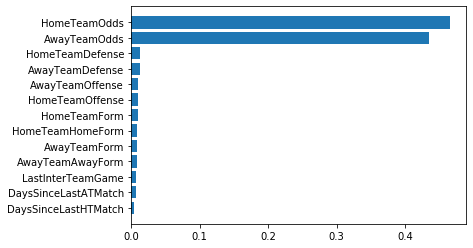

In [106]:
srt = np.argsort(gb.feature_importances_)
plt.barh(matches.drop(['ResultCategorical','Result'],axis=1).columns[srt],gb.feature_importances_[srt])
plt.show()

In [110]:
gb.predict_proba(matches.iloc[:int(0.8*len(matches))].drop(['ResultCategorical','Result'],axis=1))

array([[0.22693129, 0.24736899, 0.52569973],
       [0.37384108, 0.2978125 , 0.3283464 ],
       [0.52778625, 0.22273637, 0.24947739],
       ...,
       [0.2611593 , 0.29785958, 0.44098106],
       [0.10282702, 0.17954625, 0.71762675],
       [0.48408532, 0.2363201 , 0.27959454]], dtype=float32)

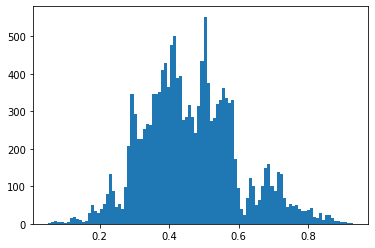

In [116]:
plt.hist(gb.predict_proba(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))[:,2],bins=100)
plt.show()

In [325]:
pred = gb.predict(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))
pred_prob = gb.predict_proba(matches.iloc[int(0.9*len(matches)):].drop(['ResultCategorical','Result'],axis=1))

In [132]:
#endre uavgjort til hjemmeseier...
#pd.Series(np.where(pred==1,0,pred)).value_counts()
pred = np.where(pred==1,0,pred)

array([2, 0, 0, ..., 2, 2, 0], dtype=int64)

In [333]:
odds = matches[["AwayTeamOdds","Result","HomeTeamOdds"]].iloc[int(0.9*len(matches)):].values[range(len(pred)),pred.tolist()]

In [ ]:
zzz

In [167]:
def kelly(y, y_hat, odds, cash=1000,bet_frac=0.25):    
    
    cash_at_t = [cash]
    for t in range(len(y)):
        bet = bet_frac * cash
        if y[t] == y_hat[t]:
            cash += bet*odds[t]
        else:
            cash -= bet
    
        cash_at_t.append(cash)
    
    return cash_at_t
    

In [249]:
[i for i in range(0,20,2)]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [365]:
def kelly_batch(y, y_hat, odds, probs, cash=1000,bet_frac=0.25, batch_size=20):    
    
    
    odds_ratio = odds*probs
    cash_at_t = [cash]
    for t in range(0,len(y),batch_size):
        bet = (bet_frac * cash) / batch_size
        y_t = y[t*batch_size:(t+1)*batch_size]
        y_hat_t = y_hat[t*batch_size:(t+1)*batch_size]
        
        for i in range(batch_size):
            if odds_ratio[t] > 0.95:
                cash -= bet
                if y[t] == y_hat[t]:
                    cash += bet*odds[t]
               
    
        cash_at_t.append(cash)
    
    return cash_at_t

In [275]:
runs = {}
for i in np.linspace(0.1,1,20):
    runs[i] = kelly(matches["ResultCategorical"].iloc[int(len(matches)*0.9):].values, pred, odds, bet_frac=i)

C:\Users\bfesc\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\bfesc\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [352]:
np.quantile(odds*,0.95)

1.0002321336617825

In [356]:
probs = pred_prob[range(len(pred)),pred.tolist()]

In [366]:
batch_runs = {}
for i in np.linspace(0.1,1,10):
    batch_runs[i] = kelly_batch(matches["ResultCategorical"].iloc[int(len(matches)*0.9):].values, pred, odds, probs, bet_frac=i)

In [317]:
res = []
for start_point in range(0,len(pred),50):
    batch_r = {}
    for i in np.linspace(0.1,1,10):
        batch_r[i] = kelly_batch(matches["ResultCategorical"].iloc[int(len(matches)*0.9)+start_point:].values, 
                                 pred[start_point:], odds[start_point:], bet_frac=i)
    batch_r = pd.DataFrame(batch_r).T.fillna(0)
    mx = (batch_r[max(batch_r.columns)].max())
    wins = (sum(batch_r[max(batch_r.columns)] != 0))
    res.append({"start" : start_point, "max_win" : mx, "wins" : wins})

KeyboardInterrupt: 

In [314]:
gb.save_model("model_2021.json")

In [367]:
runs = pd.DataFrame(runs).T.fillna(0)
batch_runs = pd.DataFrame(batch_runs).T.fillna(0)

In [313]:
pd.DataFrame(res).max_win.sort_values()

295    1.190400e+03
294    2.915500e+03
291    6.156800e+03
293    1.438249e+04
292    4.168828e+04
           ...     
1      1.431355e+71
17     1.620524e+71
23     3.569792e+71
3      5.392775e+71
5      1.748358e+72
Name: max_win, Length: 296, dtype: float64

In [368]:
runs.head()

,0,1,2,3,4,5,6,7,8,9,...,14786,14787,14788,14789,14790,14791,14792,14793,14794,14795
0.100000,1000.0,1600.000000,1440.000000,2448.000000,2203.200000,1982.880000,2776.032000,2498.428800,3297.926028,4683.054897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.147368,1000.0,1884.210526,1606.537396,3263.807552,2782.825387,2372.724803,3771.383635,3215.600783,4732.010438,7660.875714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.194737,1000.0,2168.421053,1746.149584,4126.427176,3322.859779,2675.776559,4760.065667,3833.105511,6221.735507,11310.460001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.242105,1000.0,2452.631579,1858.836565,5009.075375,3796.351863,2877.235097,5663.610137,4292.420315,7617.916524,15364.134448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.289474,1000.0,2736.842105,1944.598338,5884.968654,4181.425096,2971.012569,6411.132385,4555.278273,8774.904526,19443.340598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [369]:
batch_runs.head()

,0,1,2,3,4,5,6,7,8,9,...,731,732,733,734,735,736,737,738,739,740
0.1,1000.0,1050.0,945.0,850.5,765.45,765.45,765.45,765.45,765.45,765.45,...,1.261634e+02,1.135470e+02,1.135470e+02,1.135470e+02,1.135470e+02,1.176347e+02,1.176347e+02,1.058713e+02,1.058713e+02,9.528414e+01
0.2,1000.0,1100.0,880.0,704.0,563.20,563.20,563.20,563.20,563.20,563.20,...,3.340801e+00,2.672640e+00,2.672640e+00,2.672640e+00,2.672640e+00,2.865071e+00,2.865071e+00,2.292056e+00,2.292056e+00,1.833645e+00
0.3,1000.0,1150.0,805.0,563.5,394.45,394.45,394.45,394.45,394.45,394.45,...,1.589685e-02,1.112779e-02,1.112779e-02,1.112779e-02,1.112779e-02,1.232959e-02,1.232959e-02,8.630716e-03,8.630716e-03,6.041501e-03
0.4,1000.0,1200.0,720.0,432.0,259.20,259.20,259.20,259.20,259.20,259.20,...,9.957676e-06,5.974606e-06,5.974606e-06,5.974606e-06,5.974606e-06,6.834949e-06,6.834949e-06,4.100969e-06,4.100969e-06,2.460582e-06
0.5,1000.0,1250.0,625.0,312.5,156.25,156.25,156.25,156.25,156.25,156.25,...,4.756771e-10,2.378385e-10,2.378385e-10,2.378385e-10,2.378385e-10,2.806495e-10,2.806495e-10,1.403247e-10,1.403247e-10,7.016237e-11


In [280]:
#(runs == 0).idxmax(axis=1).loc[lambda s: s== 0]

Series([], dtype: int64)

In [341]:
#(batch_runs == 0).idxmax(axis=1).loc[lambda s: s== 0]

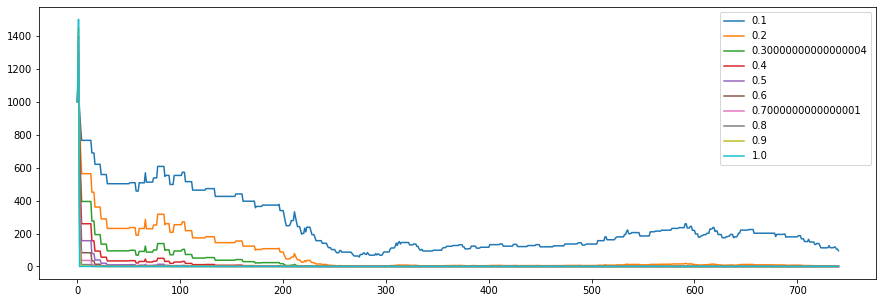

In [370]:
batch_runs.T.iloc[:1000].plot(legend=True,figsize=(15,5))

In [243]:
runs.loc[(runs == 0).idxmax(axis=1).loc[lambda s: s== 0].index]#[range(90)].T.plot()

,0,1,2,3,4,5,6,7,8,9,...,14786,14787,14788,14789,14790,14791,14792,14793,14794,14795
0.672727,1000.0,5036.363636,1648.264463,9410.091660,3079.666362,1007.890809,3720.033350,1217.465460,3838.336599,14683.381697,...,1.385661e+283,4.508437e+283,2.422260e+284,1.301414e+285,4.259174e+284,1.393912e+284,4.561892e+283,1.453585e+284,4.757187e+283,1.275791e+284
0.681818,1000.0,5090.909091,1619.834711,9350.864012,2975.274913,946.678381,3528.528512,1122.713618,3572.270638,13801.954273,...,3.582476e+218,1.176518e+219,6.390630e+219,3.471274e+220,1.104496e+220,3.514306e+219,1.118188e+219,3.595992e+219,1.144179e+219,3.094485e+219
0.690909,1000.0,5145.454545,1590.413223,9282.229902,2869.052879,886.798163,3337.585812,1031.617433,3312.429827,12924.498489,...,9.041970e+150,2.997002e+151,1.645627e+152,9.035986e+152,2.792941e+152,8.632727e+151,2.668297e+151,8.659838e+151,2.676677e+151,7.300029e+151
0.700000,1000.0,5200.000000,1560.000000,9204.000000,2761.200000,828.360000,3147.768000,944.330400,3059.630528,12054.943870,...,1.551643e+80,5.190247e+80,2.880587e+81,1.598726e+82,4.796177e+81,1.438853e+81,4.316559e+80,1.413673e+81,4.241020e+80,1.166280e+81
0.709091,1000.0,5254.545455,1528.595041,9115.984974,2651.922901,771.468480,2959.633625,860.984327,2814.636066,11197.133643,...,1.217536e+06,4.109739e+06,2.305190e+07,1.293002e+08,3.761460e+07,1.094243e+07,3.183252e+06,1.051920e+07,3.060132e+06,8.484910e+06


In [91]:
accs = np.zeros((150,150))
y = np.sign(matches.iloc[int(0.8*len(matches)):]['Result'])

for i, t_1 in enumerate(np.linspace(0,1.5,150)):
    for j ,t_2 in enumerate(np.linspace(-1.5,0,150)):
        y_hat = np.where(pred > t_1,1,np.where(pred < t_2,-1,0))
        acc = (y_hat == y).mean()
        accs[i,j] = acc

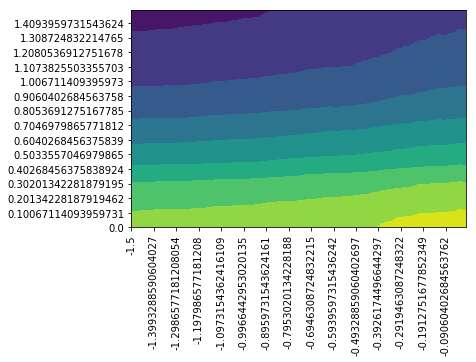

In [100]:
plt.contourf(accs)
plt.xticks(range(0,150,10),np.linspace(-1.5,0,150)[range(0,150,10)],rotation=90)
plt.yticks(range(0,150,10),np.linspace(0,1.5,150)[range(0,150,10)])
plt.show()

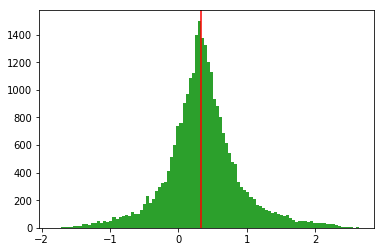

In [123]:
plt.hist(pred,bins=100)
plt.axvline(np.median(pred),color='red')
plt.show()

Average return on bet: 21.803363427456052%
Bets made: 6559 home, 220 away
33.13173034370851% losing bets
1478.0500067472458


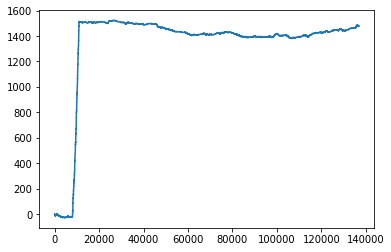

0.6686826965629149

In [45]:

test_matches = matches#.iloc[:int(0.05*len(matches))] 
y = test_matches['Result'].values
pred = gboost.predict(test_matches.drop(['HomeTeamOdds','AwayTeamOdds','Result'],axis=1))
cash = 0
bet = 1
home_prod = test_matches['HomeTeamOdds'].values * pred
away_prod = test_matches['AwayTeamOdds'].values * -pred
#home_prod = pred
#away_prod = -pred

tot_winnings = [cash]
winnings = []
home_threshold = 2
away_threshold = 3
home_bets = 0
away_bets = 0
losing_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if home_prod[i] > home_threshold:
        cash -= bet
        home_bets += 1
        if pred[i] > 0 and y[i] > 0:
            cash += bet * test_matches.iloc[i]['HomeTeamOdds']
        else:
            losing_bets +=1
    elif away_prod[i] > away_threshold:
        cash -= bet
        away_bets += 1
        if pred[i] < 0 and y[i] < 0:
            cash += bet * test_matches.iloc[i]['AwayTeamOdds']
        else:
            losing_bets +=1
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print("{}% losing bets".format((losing_bets/(home_bets+away_bets))*100))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
#plt.bar(np.arange(len(winnings)),np.sort(winnings))
#plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

In [24]:
np.sign(test_matches.Result).value_counts() / test_matches.shape[0]

 1    0.472478
-1    0.268798
 0    0.258724
Name: Result, dtype: float64

In [156]:
np.where(pred>t,test_matches['HomeTeamOdds'],np.where(pred<-t,test_matches['AwayTeamOdds'],0)).sum()

404.1700015068054

In [167]:
t=0
np.where((pred>t) | (pred<-t))[0].shape

(27396,)

In [171]:
res = test_matches['Result']

In [182]:
(np.where((pred>t) | (np.sign(res)>0),test_matches['HomeTeamOdds'],
                             np.where((pred<-t) | (np.sign(res)<0),test_matches['AwayTeamOdds'],-1)))

array([2.25      , 4.        , 3.20000005, ..., 2.75      , 2.5       ,
       2.61999989])

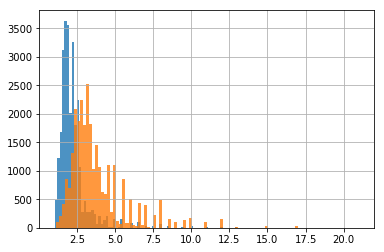

In [186]:
test_matches['HomeTeamOdds'].hist(alpha=0.8,bins=100)
test_matches['AwayTeamOdds'].hist(alpha=0.8,bins=100)
plt.show()

In [174]:
winnings = []
for t in np.linspace(0,2,20):
    winnings.append(np.where((pred>t) | (np.sign(res)>0),test_matches['HomeTeamOdds'],
                             np.where((pred<-t) | (np.sign(res)<0),test_matches['AwayTeamOdds'],-1)).sum())
    

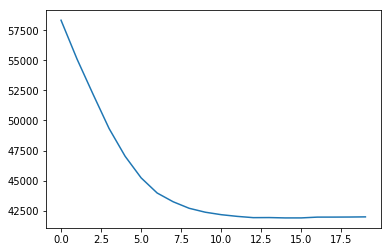

In [175]:
plt.plot(winnings)
plt.show()

In [200]:
winnings = []
n_bets = []
bet=1
for t in tqdm(np.linspace(0,10,10)):
    cash = 0
    n = 0
    for i in range(len(pred)):
        
        if pred[i]*test_matches.iloc[i]['HomeTeamOdds'] > t:
            cash -= bet
            n+=1
            if y[i] > 0:
                cash += bet * test_matches.iloc[i]['HomeTeamOdds']
            
        elif pred[i]*test_matches.iloc[i]['AwayTeamOdds'] < -t:
            cash -= bet
            n+=1
            if y[i] < 0:
                cash += bet * test_matches.iloc[i]['AwayTeamOdds']
    n_bets.append(n)
    winnings.append(cash)

    
plt.plot(np.linspace(0,2,20),winnings)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.77s/it]


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

717.3789998292923
3.3333333333333335


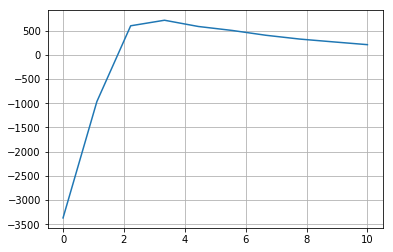

In [201]:
print(max(winnings))
print(np.linspace(0,10,10)[np.argmax(winnings)])
plt.plot(np.linspace(0,10,10),winnings)
plt.grid()
plt.show()

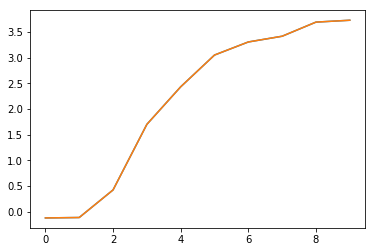

In [204]:
plt.plot(np.array(winnings) / np.array(n_bets))
plt.show()

In [101]:
accs.max()

0.48528982333187326

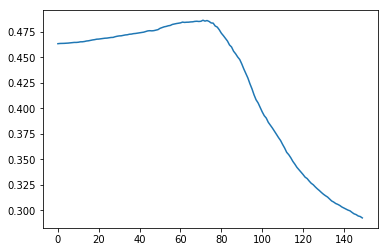

In [90]:
plt.plot(accs)
plt.show()

In [231]:
matches_X = matches[['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                                            'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                                          'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame']]

pred = None
with tf.device('/cpu:0'):
    pred = model.predict(matches_X)

Average return on bet: -3.197604096578267%
Bets made: 133 home, 34 away
-106.799976826


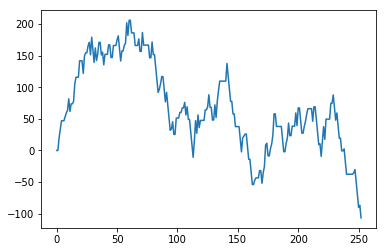

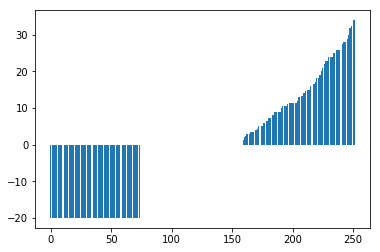

0.5568862275449101

In [18]:
y = matches['Result'].values
cash = 0
bet = 20

home_prod = new_data_d['WHH'].values * pred.squeeze()
away_prod = new_data_d['WHA'].values * -pred.squeeze()

tot_winnings = [cash]
winnings = []
home_threshold = 21
away_threshold = 7
home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if home_prod[i] > home_threshold:
        cash -= bet
        home_bets += 1
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif away_prod[i] > away_threshold:
        cash -= bet
        away_bets += 1
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

In [ ]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
threshold = 10
home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i][0] > threshold:
        cash -= bet
        home_bets += 1
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif pred[i][0] < -threshold:
        cash -= bet
        away_bets += 1
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)

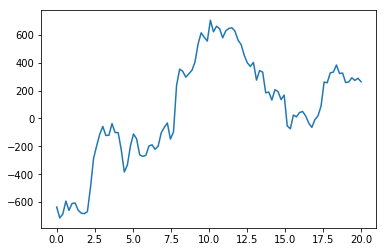

In [13]:
winnings = []

for t in np.linspace(0,20,100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] > t:
            cash -= bet
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] < -t:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.linspace(0,20,100),winnings)
plt.show()

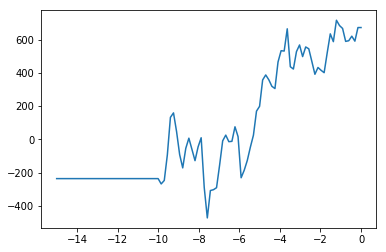

In [14]:
winnings = []
home_threshold = 10

for t in np.linspace(0,-15,100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] > home_threshold:
            cash -= bet
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] < -t:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.linspace(0,-15,100),winnings)
plt.show()

In [15]:
np.linspace(0,15,100)[np.argmax(winnings)]

1.2121212121212122

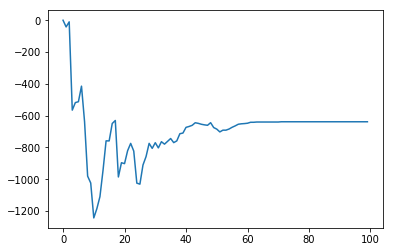

In [16]:
winnings = []


for t in range(100):
    cash = 0

    for i in range(len(pred)):
        
        if pred[i][0] < t and pred[i][0] > 0.5:
            cash -= bet
            if y[i] > 0 :
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif pred[i][0] > -t and pred[i][0] < -0.5:
            cash -= bet
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)

    
plt.plot(np.arange(100),winnings)
plt.show()

In [17]:
cash_h = 0
cash_a = 0

for i in range(len(pred)):
    cash_h -= bet
    cash_a -= bet
    
    if y[i] > 0:
        cash_h += bet * new_data.iloc[i]['WHH']
    if y[i] < 0:
        cash_a += bet * new_data.iloc[i]['WHH']

    
    

In [18]:
pred_n = pred + pred.max()
pred_n /= pred_n.max()
len(np.where(pred_n > 0.5)[0]) / len(pred_n) == len(np.where(pred > 0)[0]) / len(pred)

True

In [31]:
odds = np.zeros((len(pred),2))

for i in range(len(pred_n)):
    if pred_n[i] == 0:
        odds[i][0] = 5000
        odds[i][1] = 1
    elif pred_n[i] == 1:
        odds[i][1] = 5000
        odds[i][0] = 1
    else:
        odds[i][0] = 1/pred_n[i]
        odds[i][1] = 1/(1 - pred_n[i])

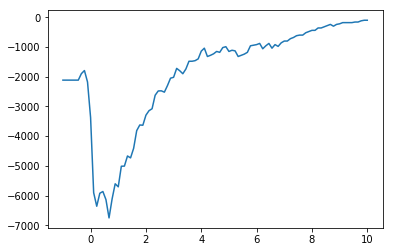

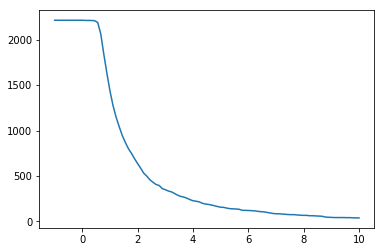

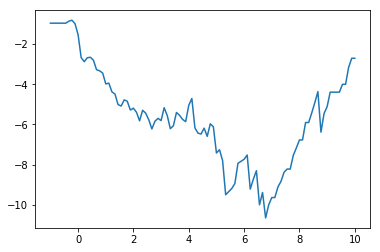

In [20]:
winnings = []
bets_made = []

home_diff = new_data_d['WHH'].values - odds[:,0]
away_diff = new_data_d['WHA'].values - odds[:,1]

for t in np.linspace(-1,10,100):
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_diff[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif away_diff[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
plt.plot(np.linspace(-1,10,100),winnings)
plt.show()
plt.plot(np.linspace(-1,10,100),bets_made)
plt.show()
plt.plot(np.linspace(-1,10,100), winnings_per_bet)
plt.show()

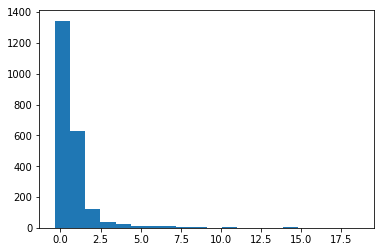

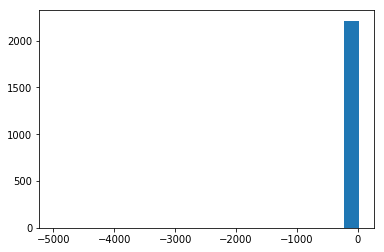

In [21]:
plt.hist(home_diff, bins=20)
plt.show()
plt.hist(away_diff, bins=20)
plt.show()

In [22]:
bets_made = [] #prediction, odds, odds*pred, utbetaling
bet = 1
for i in range(len(pred)):
    
    if pred[i][0] > threshold:
        cash = 0
        odd = new_data_d.iloc[i]['WHH']
        if pred[i][0] > 0 and y[i] > 0:
            cash += bet * odd
            
        bets_made.append([pred[i][0], odd, odd*pred[i][0] , cash])
        
    elif pred[i][0] < -threshold:
        cash = 0 
        odd = new_data_d.iloc[i]['WHA']
        if pred[i][0] < 0 and y[i] < 0:
            cash += bet * odd
            
        bets_made.append([-pred[i][0], odd, odd*-pred[i][0], cash])



In [23]:
from sklearn.linear_model import LinearRegression
bets_made = np.array(bets_made)

lr = LinearRegression()
lr.fit(bets_made[:,:-1],bets_made[:,-1])
lr.coef_

array([ 0.01038985,  0.1825837 , -0.0057339 ])

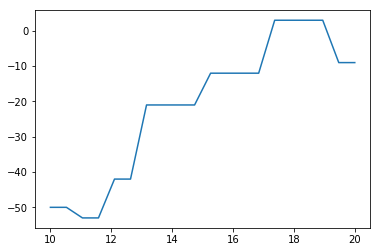

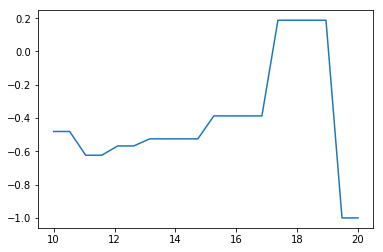

In [24]:
threshold = np.linspace(10,20,20)
winnings = []
n_bets = []
for t in threshold:
    cash=0
    bets = 0
    for i in range(len(pred)):
        h_odd = new_data_d.iloc[i]['WHH']
        a_odd = new_data_d.iloc[i]['WHA']
        
        if h_odd > t:
            cash -= bet
            bets += 1
            if y[i] > 0 :
                cash += bet * h_odd
            
        elif a_odd > t:
            cash -= bet
            bets += 1
            if y[i] < 0:
                cash += bet * a_odd
    
    n_bets.append(bets)
    winnings.append(cash)
    
plt.plot(threshold,winnings)
plt.show()
plt.plot(threshold,np.array(winnings)/np.array(n_bets))
plt.show()

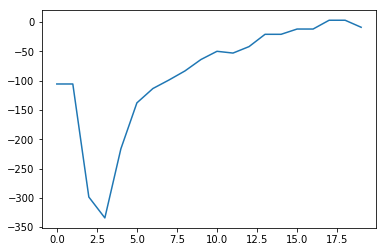

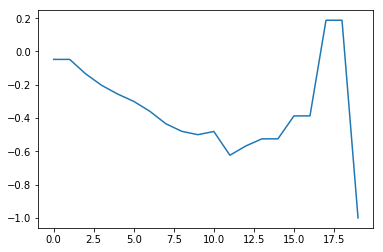

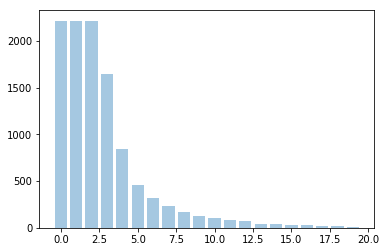

In [25]:
threshold = np.arange(0,20)
winnings = []
n_bets = []
for t in threshold:
    cash=0
    bets = 0
    for i in range(len(pred)):
        h_odd = new_data_d.iloc[i]['WHH']
        a_odd = new_data_d.iloc[i]['WHA']
        
        if h_odd > t:
            cash -= bet
            bets += 1
            if y[i] > 0 :
                cash += bet * h_odd
            
        elif a_odd > t:
            cash -= bet
            bets += 1
            if y[i] < 0:
                cash += bet * a_odd
    
    n_bets.append(bets)
    winnings.append(cash)
    
plt.plot(winnings)
plt.show()
plt.plot(np.array(winnings)/np.array(n_bets))
plt.show()
plt.bar(threshold,n_bets,alpha=0.4)
plt.show()

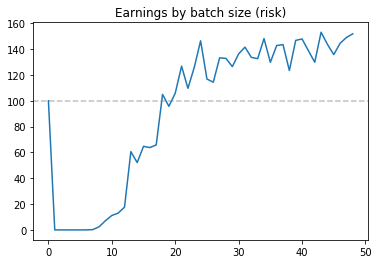

In [26]:
cash = 100
bet = 1

tot_winnings = [cash]
winnings = []
threshold = 10
home_bets = 0
away_bets = 0

prev_j = 0

batch_size = np.arange(2,50,1)

for b in batch_size:
    cash = 100
    prev_j = len(pred)
    for j in range(len(pred)-7,-1,-b):
        cur_pred = pred[j:prev_j]
        cur_bet = cash/len(cur_pred)
        home_odds = new_data_d.iloc[j:prev_j]['WHH']
        away_odds = new_data_d.iloc[j:prev_j]['WHA']
        y_j = y[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i][0] > threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i][0] < -threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
    #     print("BET: ", b)
    #     print("WON: ", w)
    #     print("")
        prev_j = j
    
    tot_winnings.append(cash)
    #winnings.append(tot_winnings[-1] - tot_winnings[-2])

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Earnings by batch size (risk)")
plt.show()

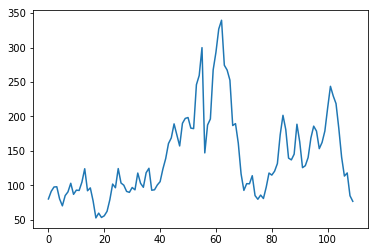

In [27]:
tot_winnings = []
cash = 100
prev_j = len(pred)

for j in range(len(pred)-20,-1,-20):
        cur_pred = pred[j:prev_j]
        cur_bet = cash/len(cur_pred)
        home_odds = new_data_d.iloc[j:prev_j]['WHH']
        away_odds = new_data_d.iloc[j:prev_j]['WHA']
        y_j = y[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i][0] > threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i][0] < -threshold:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
    #     print("BET: ", b)
    #     print("WON: ", w)
    #     print("")
        prev_j = j
    
        tot_winnings.append(cash)
        
plt.plot(tot_winnings)
plt.show()

70.1244 12.7328


C:\Users\bfesc\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


10.0


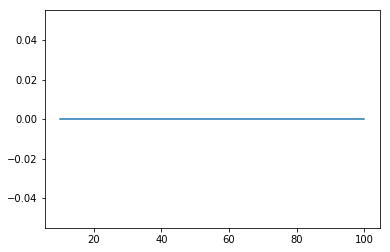

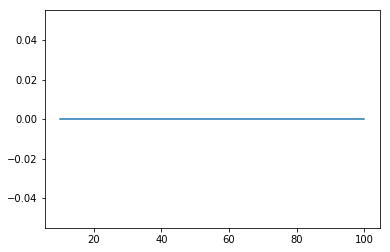

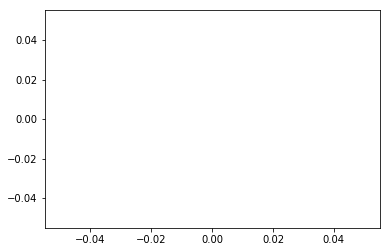

In [48]:
winnings = []
bets_made = []

print(np.max(pred.squeeze()),-np.min(pred.squeeze()))
home_prod = new_data_d['WHH'].values * (pred.squeeze() / np.max(pred.squeeze()))
away_prod = new_data_d['WHA'].values * (-pred.squeeze() / -np.min(pred.squeeze()))

home_ts = np.linspace(10,100,100)

for t in home_ts:
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_prod[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
#         elif away_diff[i] > t:
#             cash -= bet
#             bets += 1
            
#             if y[i] < 0:
#                 cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
print(home_ts[np.argmax(winnings)])
plt.plot(home_ts,winnings)
plt.show()
plt.plot(home_ts,bets_made)
plt.show()
plt.plot(home_ts, winnings_per_bet)
plt.show()

7.07070707071


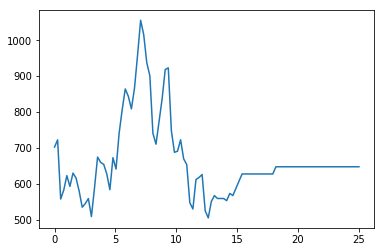

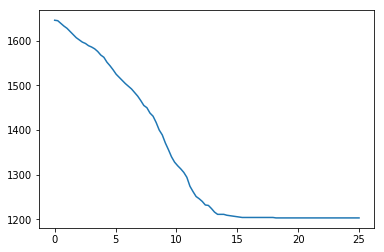

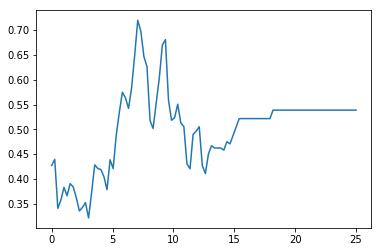

In [42]:
winnings = []
bets_made = []

home_prod = new_data_d['WHH'].values * pred.squeeze()
away_prod = new_data_d['WHA'].values * -pred.squeeze()

away_ts = np.linspace(0,25,100)
home_t = 21

for t in away_ts:
    cash = 0
    bets = 0

    for i in range(len(pred)):
        
        if home_prod[i] > home_t:
            cash -= bet
            bets += 1
            
            if y[i] > 0:
                cash += bet * new_data_d.iloc[i]['WHH']
            
        elif away_prod[i] > t:
            cash -= bet
            bets += 1
            
            if y[i] < 0:
                cash += bet * new_data_d.iloc[i]['WHA']

    winnings.append(cash)
    bets_made.append(bets)


winnings_per_bet = np.array(winnings)/np.array(bets_made)
print(away_ts[np.argmax(winnings)])
plt.plot(away_ts,winnings)
plt.show()
plt.plot(away_ts,bets_made)
plt.show()
plt.plot(away_ts, winnings_per_bet)
plt.show()

In [19]:

odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_t in np.linspace(2,20,20):
        cash = 0
        
        for i in range(len(pred)):

            if pred[i] > pred_t and new_data_d['WHH'].iloc[i] > odd_t:
                cash -= bet

                if y[i] > 0:
                    cash += bet * new_data_d.iloc[i]['WHH']

    #         elif away_prod[i] > t:
    #             cash -= bet
    #             bets += 1

    #             if y[i] < 0:
    #                 cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.25it/s]


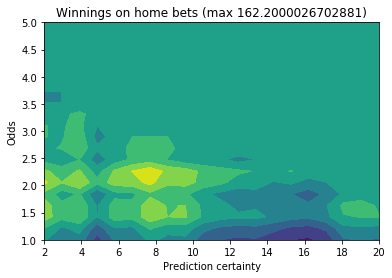

In [22]:

home_odd = 2
home_pred = 10.5
odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_t in np.linspace(-10,5,20):
        cash = 0
        
        for i in range(len(pred)):

            if pred[i] > home_pred and new_data_d['WHH'].iloc[i] > home_odd:
                cash -= bet

                if y[i] > 0:
                    cash += bet * new_data_d.iloc[i]['WHH']

            elif pred[i] < pred_t and new_data_d['WHA'].iloc[i] > odd_t:
                cash -= bet


                if y[i] < 0:
                    cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)
    

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]


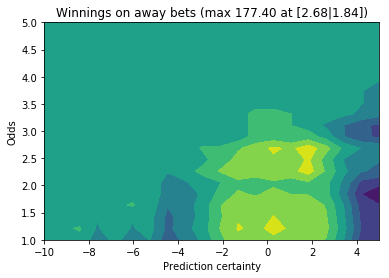

In [100]:
np.argmax(np.array(odd_winnings))

69

Average return on bet: 3.046154792492206%
Bets made: 40 home, 25 away
39.6000123024


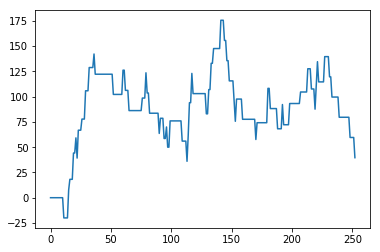

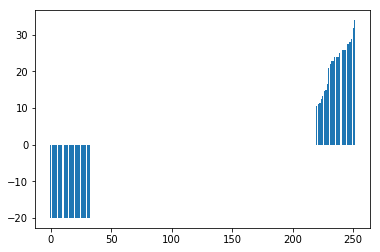

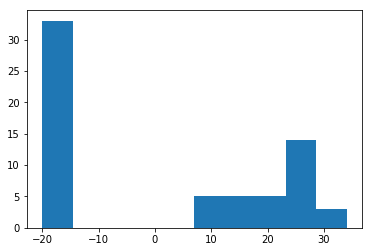

In [24]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3

home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i] > home_pred and new_data_d.iloc[i]['WHH'] > home_odd:
        cash -= bet
        home_bets += 1
        if y[i] > 0:
            cash += bet * new_data_d.iloc[i]['WHH']
    elif pred[i] < away_pred and new_data_d.iloc[i]['WHA'] > away_odd:
        cash -= bet
        away_bets += 1
        if y[i] < 0:
            cash += bet * new_data_d.iloc[i]['WHA']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)
plt.hist(np.array(winnings)[np.where(np.array(winnings) != 0)[0]],bins=10)
plt.show()

**TODO:** Test batch earnings

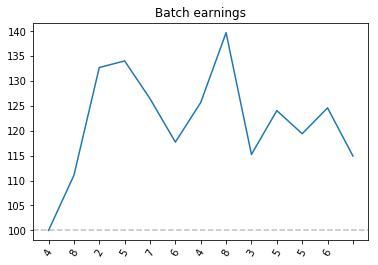

In [28]:
cash = 100
tot_winnings = [cash]
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3
batch = 20
prev_j = len(pred)
bets_made = []

for j in range(len(pred)-batch,-1,-batch):
    cur_pred = pred[j:prev_j]
    
    cur_bet = cash/len(cur_pred)
    home_odds = new_data_d.iloc[j:prev_j]['WHH']
    away_odds = new_data_d.iloc[j:prev_j]['WHA']
    y_j = y[j:prev_j]
    w = 0
    b = 0

    for i in range(len(cur_pred)):
        if cur_pred[i][0] > home_pred and home_odds[i] > home_odd:
            cash -= cur_bet
            b+=1
            if y_j[i] > 0:
                cash += cur_bet * home_odds[i]
                w+=1

        elif cur_pred[i][0] < away_pred and away_odds[i] > away_odd:
            cash -= cur_bet
            b+=1
            if y_j[i] < 0:
                cash += cur_bet * away_odds[i]
                w+=1
    prev_j = j
    bets_made.append(b)
    tot_winnings.append(cash)

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.xticks(np.arange(len(tot_winnings)),bets_made,rotation=60)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Batch earnings")
plt.show()

In [27]:
tot_winnings = []
avg_bets_made = []
home_odd = 2
home_pred = 10.5
away_odd = 1.5
away_pred = -3

home_odds = new_data_d['WHH']
g = pd.DataFrame(pred, columns=['pred'])
g['odds'] = home_odds.values

g['aOdds'] = new_data_d['WHA'].values
g['y'] = y
bets_to_make = g.iloc[np.append(np.where((g['pred'] > home_pred) & (g['odds'] > home_odd))[0],
                         np.where((g2['pred'] < away_pred) & (g['aOdds'] > away_odd))[0])]


print(bets_to_make.shape)
pred_m = bets_to_make['pred'].values
home_odds_m = bets_to_make['odds'].values
away_odds_m = bets_to_make['aOdds'].values
y_m = bets_to_make['y'].values

for batch in range(3,20,1):
    cash = 100
    prev_j = len(pred_m)
    
    bets_made = []
    for j in range(len(pred_m)-batch,-1,-batch):
        cur_pred = pred_m[j:prev_j]
        cur_bet = cash/batch
        home_odds = home_odds_m
        away_odds = away_odds_m
        y_j = y_m[j:prev_j]
        w = 0
        b = 0

        for i in range(len(cur_pred)):
            if cur_pred[i] > home_pred:
                cash -= cur_bet
                b+=1
                if y_j[i] > 0:
                    cash += cur_bet * home_odds[i]
                    w+=1

            elif cur_pred[i] < away_pred:
                cash -= cur_bet
                b+=1
                if y_j[i] < 0:
                    cash += cur_bet * away_odds[i]
                    w+=1
        prev_j = j
    
        bets_made.append(b)
    avg_bets_made.append(np.mean(bets_made))
    tot_winnings.append(cash)

#print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
plt.plot(tot_winnings)
plt.axhline(100,color='grey',ls='--',alpha=0.5)
plt.title("Batch earnings")
plt.show()

NameError: name 'g2' is not defined

In [182]:
from sklearn.linear_model import LinearRegression
home_odds = new_data_d['WHH']

linreg = LinearRegression()
linreg = linreg.fit(X=np.array([home_odds,pred.squeeze()]).T,y=(y*home_odds).values)
linreg.coef_

array([-1.766505  ,  0.00887195], dtype=float32)

In [189]:
p = linreg.predict(np.array([home_odds,pred.squeeze()]).T)

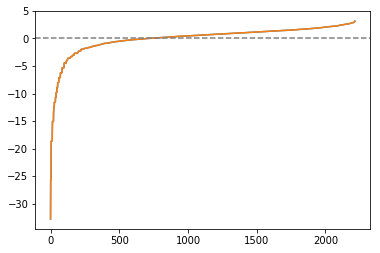

In [195]:
plt.plot(np.sort(p))
plt.axhline(0,ls='--',color='grey')
plt.show()

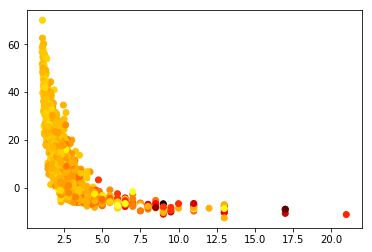

In [207]:
plt.scatter(home_odds,pred.squeeze().T, c=(y*home_odds).values.astype(np.float32), cmap='hot')
plt.show()

In [26]:
y_hot = np.zeros(len(y))
y_hot[y > 0] +=1

g = pd.DataFrame(pred, columns=['pred'])
g['odds'] = home_odds.values
g['winnings'] = home_odds.values*y_hot - 1
g.head()

NameError: name 'home_odds' is not defined

In [25]:
winnings = np.zeros((60,8))

for i in range(60):
    b1 = g.iloc[np.where((g['pred'] > i) & (g['pred'] <= i+1))[0]]
    for j in range(8):
        b2 = b1['winnings'].iloc[np.where((b1['odds'] > j) & (b1['odds'] <= j+1))[0]]
        if len(b2) > 0:
            winnings[i,j] = np.sum(b2)

NameError: name 'g' is not defined

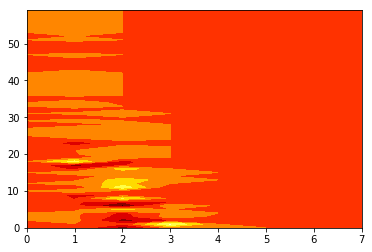

In [278]:
plt.contourf(range(winnings.shape[1]),range(winnings.shape[0]),winnings, cmap='hot')
plt.show()

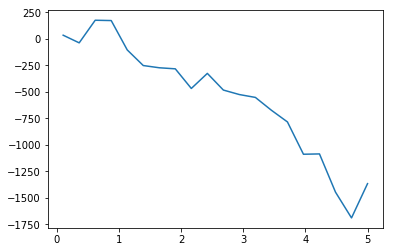

In [372]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = []
winnings = []
home_threshold = 21
away_threshold = 7
home_bets = 0
away_bets = 0

threshold = np.linspace(0.1,5,20)
for t in threshold:
    cash = 0
    for i in range(len(pred)-1,-1,-1):

        if pred[i] > -t and pred[i] < t:
            cash -= bet
            if y[i] == 0:
                cash += bet * new_data_d.iloc[i]['WHD']
    
    tot_winnings.append(cash)


plt.plot(threshold, tot_winnings)
plt.show()

In [70]:
training_matches = make_training_set(old_data, n_matches=len(old_data.index))

  4%|███▍                                                                        | 5818/129936 [01:01<21:44, 95.15it/s]

Apollon Platanias


  5%|███▌                                                                        | 6027/129936 [01:03<21:39, 95.39it/s]

Lamia AEK


  5%|███▌                                                                        | 6115/129936 [01:04<21:36, 95.48it/s]

Perugia Parma
Foggia Palermo


  5%|███▌                                                                        | 6126/129936 [01:04<21:36, 95.49it/s]

Cremonese Carpi


  5%|███▌                                                                        | 6192/129936 [01:04<21:34, 95.56it/s]

Venezia Spezia


  5%|███▋                                                                        | 6258/129936 [01:05<21:33, 95.62it/s]

Apollon PAOK
Kasimpasa Yeni Malatyaspor


  5%|███▋                                                                        | 6269/129936 [01:05<21:33, 95.63it/s]

Osmanlispor Goztep


  5%|███▋                                                                        | 6291/129936 [01:05<21:32, 95.65it/s]

AZ Alkmaar NAC Breda
Groningen VVV Venlo
Parma Brescia


  5%|███▋                                                                        | 6302/129936 [01:05<21:32, 95.66it/s]

Leonesa Valladolid
Albacete Lugo


  5%|███▋                                                                        | 6313/129936 [01:05<21:32, 95.67it/s]

Avellino Foggia
Bari Venezia
Pro Vercelli Cremonese


  5%|███▊                                                                        | 6422/129936 [01:07<21:30, 95.74it/s]

Asteras Tripolis Lamia
Barcelona B Cordoba
Almeria Lorca


  5%|███▊                                                                        | 6433/129936 [01:07<21:29, 95.75it/s]

Sivasspor Kayserispor


  5%|███▊                                                                        | 6455/129936 [01:07<21:29, 95.77it/s]

Alcorcon Albacete
Novara Parma


  5%|███▊                                                                        | 6466/129936 [01:07<21:29, 95.78it/s]

Cremonese Avellino
Foggia Virtus Entella
Cesena Venezia
Sevilla B Leonesa


  5%|███▊                                                                        | 6499/129936 [01:07<21:28, 95.80it/s]

Lorca Vallecano


  5%|███▊                                                                        | 6510/129936 [01:07<21:28, 95.81it/s]

Granada Barcelona B


  5%|███▊                                                                        | 6521/129936 [01:08<21:28, 95.82it/s]

Barcelona B Tenerife
Portimonense Maritimo


  5%|███▊                                                                        | 6543/129936 [01:08<21:27, 95.84it/s]

Boavista Aves


  5%|███▊                                                                        | 6565/129936 [01:08<21:26, 95.86it/s]

Panionios Apollon
VVV Venlo Ajax


  5%|███▊                                                                        | 6576/129936 [01:08<21:26, 95.87it/s]

Pescara Foggia


  5%|███▊                                                                        | 6587/129936 [01:08<21:26, 95.88it/s]

Venezia Salernitana


  5%|███▉                                                                        | 6642/129936 [01:09<21:25, 95.93it/s]

Huesca Lorca
Leonesa Osasuna
Regensburg Holstein Kiel


  5%|███▉                                                                        | 6653/129936 [01:09<21:25, 95.94it/s]

Goztep Trabzonspor
Yeni Malatyaspor Antalyaspor


  5%|███▉                                                                        | 6686/129936 [01:09<21:24, 95.96it/s]

Lamia Olympiakos


  5%|███▉                                                                        | 6708/129936 [01:09<21:23, 95.98it/s]

Albacete Cordoba
Parma Cremonese


  5%|███▉                                                                        | 6719/129936 [01:10<21:23, 95.98it/s]

NAC Breda Sparta Rotterdam
Duisburg Darmstadt
Galatasaray Sivasspor


  5%|███▉                                                                        | 6730/129936 [01:10<21:23, 95.99it/s]

Atromitos Apollon


  5%|███▉                                                                        | 6741/129936 [01:10<21:23, 96.00it/s]

Chateauroux Nimes
Kayserispor Goztep


  5%|███▉                                                                        | 6763/129936 [01:10<21:22, 96.02it/s]

Ingolstadt Regensburg
Granada Albacete


  5%|███▉                                                                        | 6774/129936 [01:10<21:22, 96.03it/s]

NAC Breda PSV Eindhoven
Holstein Kiel Greuther Furth
Aves Sp Braga


  5%|███▉                                                                        | 6785/129936 [01:10<21:22, 96.04it/s]

Twente VVV Venlo


  5%|███▉                                                                        | 6796/129936 [01:10<21:22, 96.05it/s]

Mechelen Antwerp


  5%|███▉                                                                        | 6807/129936 [01:10<21:21, 96.05it/s]

Heidenheim Duisburg


  5%|███▉                                                                        | 6818/129936 [01:10<21:21, 96.06it/s]

Valladolid Barcelona B


  5%|███▉                                                                        | 6829/129936 [01:11<21:21, 96.06it/s]

Sivasspor Yeni Malatyaspor


  5%|████                                                                        | 6858/129936 [01:14<22:08, 92.65it/s]

Xanthi Lamia


  5%|████                                                                        | 6896/129936 [01:14<22:08, 92.64it/s]

Lorca Leonesa


  5%|████                                                                        | 6906/129936 [01:14<22:07, 92.65it/s]

Rio Ave Portimonense


  5%|████                                                                        | 6916/129936 [01:14<22:07, 92.65it/s]

Ajaccio Paris FC
Ajaccio GFCO Quevilly Rouen
Fylde Maidenhead


  5%|████                                                                        | 6927/129936 [01:14<22:07, 92.67it/s]

Halifax Dover Athletic
Dag and Red Ebbsfleet


  5%|████                                                                        | 6947/129936 [01:14<22:06, 92.68it/s]

Lorient Chateauroux
Pacos Ferreira Aves


  5%|████                                                                        | 6958/129936 [01:15<22:06, 92.70it/s]

Sp Braga Portimonense
Yeni Malatyaspor Osmanlispor


  5%|████                                                                        | 6969/129936 [01:15<22:06, 92.71it/s]

Antwerp Genk
Goztep Fenerbahce
Akhisar Belediyespor Sivasspor


  5%|████                                                                        | 6991/129936 [01:15<22:05, 92.74it/s]

Maidenhead Hartlepool
VVV Venlo Sparta Rotterdam


  5%|████                                                                        | 7013/129936 [01:15<22:05, 92.75it/s]

Vitesse NAC Breda


  5%|████                                                                        | 7046/129936 [01:15<22:04, 92.79it/s]

Chester Halifax
Ebbsfleet Fylde


  5%|████▏                                                                       | 7068/129936 [01:16<22:03, 92.81it/s]

Paris FC Le Havre
Quevilly Rouen Bourg Peronnas


  5%|████▏                                                                       | 7079/129936 [01:16<22:03, 92.83it/s]

Maidenhead Wrexham
Chester Fylde


  5%|████▏                                                                       | 7090/129936 [01:16<22:03, 92.84it/s]

Ebbsfleet Maidstone
Barrow Halifax


  5%|████▏                                                                       | 7101/129936 [01:16<22:02, 92.85it/s]

Portimonense Boavista
Gent Antwerp


  5%|████▏                                                                       | 7112/129936 [01:16<22:02, 92.85it/s]

Regensburg Nurnberg
Aves Sp Lisbon
Maidstone Maidenhead


  5%|████▏                                                                       | 7122/129936 [01:16<22:02, 92.85it/s]

Guiseley Ebbsfleet
Halifax Aldershot


  5%|████▏                                                                       | 7133/129936 [01:16<22:02, 92.86it/s]

Fylde Boreham Wood


  6%|████▏                                                                       | 7173/129936 [01:17<22:02, 92.86it/s]

Duisburg Bochum


  6%|████▏                                                                       | 7192/129936 [01:17<22:04, 92.66it/s]

Bourg Peronnas Paris FC
Chateauroux Valenciennes


  6%|████▏                                                                       | 7200/129936 [01:17<22:05, 92.61it/s]

Union Berlin Holstein Kiel
Quevilly Rouen Sochaux


  6%|████▏                                                                       | 7207/129936 [01:17<22:05, 92.57it/s]

Dresden Duisburg


  6%|████▏                                                                       | 7214/129936 [01:17<22:06, 92.53it/s]

Holstein Kiel Sandhausen
Lorient Quevilly Rouen
Bielefeld Regensburg


  6%|████▏                                                                       | 7222/129936 [01:18<22:06, 92.51it/s]

Brest Chateauroux
Antwerp Anderlecht


  6%|████▏                                                                       | 7232/129936 [01:18<22:06, 92.51it/s]

Paris FC Clermont


 10%|███████▌                                                                   | 13193/129936 [02:20<20:47, 93.61it/s]

Panetolikos Kerkyra


 10%|███████▊                                                                   | 13435/129936 [02:23<20:46, 93.49it/s]

Levadeiakos Larisa


 10%|███████▊                                                                   | 13573/129936 [02:25<20:45, 93.41it/s]

Levadeiakos Kerkyra


 10%|███████▊                                                                   | 13601/129936 [02:25<20:45, 93.40it/s]

Larisa Olympiakos


 11%|███████▉                                                                   | 13851/129936 [02:28<20:44, 93.28it/s]

Osmanlispor Adanaspor
Kerkyra Larisa


 11%|████████                                                                   | 13952/129936 [02:29<20:44, 93.23it/s]

Cittadella Novara


 11%|████████                                                                   | 13980/129936 [02:29<20:43, 93.22it/s]

Latina Benevento
Pisa Brescia


 11%|████████                                                                   | 13990/129936 [02:30<20:43, 93.22it/s]

Alanyaspor Trabzonspor


 11%|████████                                                                   | 13999/129936 [02:30<20:43, 93.21it/s]

Spal Virtus Entella


 11%|████████                                                                   | 14026/129936 [02:30<20:43, 93.19it/s]

Karabukspor Antalyaspor


 11%|████████                                                                   | 14072/129936 [02:31<20:43, 93.17it/s]

Larisa Iraklis
Feirense Tondela
Virtus Entella Pisa


 11%|████████▏                                                                  | 14090/129936 [02:31<20:43, 93.16it/s]

Cadiz Getafe
UCAM Murcia Elche


 11%|████████▏                                                                  | 14099/129936 [02:31<20:43, 93.16it/s]

Hannover Dresden


 11%|████████▏                                                                  | 14109/129936 [02:31<20:43, 93.16it/s]

Chaves Setubal


 11%|████████▏                                                                  | 14139/129936 [02:31<20:43, 93.15it/s]

Besiktas Karabukspor
Adanaspor Gaziantepspor
Genclerbirligi Alanyaspor


 11%|████████▏                                                                  | 14149/129936 [02:31<20:42, 93.15it/s]

Lugo Sevilla B


 11%|████████▏                                                                  | 14169/129936 [02:32<20:42, 93.14it/s]

Benevento Verona


 11%|████████▏                                                                  | 14178/129936 [02:32<20:42, 93.14it/s]

Ascoli Spal
Kerkyra Platanias


 11%|████████▏                                                                  | 14214/129936 [02:32<20:42, 93.12it/s]

Reus Deportiu Numancia


 11%|████████▏                                                                  | 14242/129936 [02:32<20:42, 93.11it/s]

Pro Vercelli Cittadella


 11%|████████▏                                                                  | 14252/129936 [02:33<20:42, 93.11it/s]

Erzgebirge Aue Braunschweig


 11%|████████▏                                                                  | 14261/129936 [02:33<20:42, 93.10it/s]

Wurzburger Kickers Bochum


 11%|████████▏                                                                  | 14271/129936 [02:33<20:42, 93.10it/s]

Ternana Pisa
Nacional Chaves
Carpi Benevento
Cittadella Ternana


 11%|████████▏                                                                  | 14281/129936 [02:33<20:42, 93.10it/s]

Pisa Novara
Spal Vicenza


 11%|████████▎                                                                  | 14317/129936 [02:33<20:42, 93.08it/s]

Mirandes Cadiz


 11%|████████▎                                                                  | 14326/129936 [02:33<20:42, 93.07it/s]

Getafe Reus Deportiu
Sevilla B UCAM Murcia


 11%|████████▎                                                                  | 14344/129936 [02:34<20:42, 93.07it/s]

Dresden St Pauli
UCAM Murcia Cordoba


 11%|████████▎                                                                  | 14353/129936 [02:34<20:41, 93.06it/s]

Go Ahead Eagles Ajax


 11%|████████▎                                                                  | 14371/129936 [02:34<20:41, 93.05it/s]

Cadiz Mallorca
Rio Ave Feirense


 11%|████████▎                                                                  | 14381/129936 [02:34<20:41, 93.05it/s]

Boavista Chaves
Karabukspor Rizespor


 11%|████████▎                                                                  | 14399/129936 [02:34<20:41, 93.04it/s]

Twente Sparta Rotterdam


 11%|████████▎                                                                  | 14426/129936 [02:35<20:41, 93.03it/s]

Lokeren Mouscron


 11%|████████▎                                                                  | 14435/129936 [02:35<20:41, 93.02it/s]

Benevento Spal
Greuther Furth Erzgebirge Aue
Bari Cittadella


 11%|████████▎                                                                  | 14454/129936 [02:35<20:41, 93.01it/s]

Reus Deportiu Mirandes


 11%|████████▎                                                                  | 14464/129936 [02:35<20:41, 93.01it/s]

Edinburgh City Berwick


 11%|████████▎                                                                  | 14501/129936 [02:35<20:41, 92.99it/s]

Kasimpasa Adanaspor


 11%|████████▍                                                                  | 14510/129936 [02:36<20:41, 92.99it/s]

Alanyaspor Antalyaspor


 11%|████████▍                                                                  | 14519/129936 [02:36<20:41, 92.99it/s]

Heidenheim Wurzburger Kickers
Tenerife Sevilla B


 11%|████████▍                                                                  | 14529/129936 [02:36<20:41, 92.98it/s]

Galatasaray Karabukspor


 11%|████████▍                                                                  | 14538/129936 [02:36<20:41, 92.98it/s]

Zaragoza UCAM Murcia


 11%|████████▍                                                                  | 14556/129936 [02:36<20:41, 92.97it/s]

Sparta Rotterdam Go Ahead Eagles


 11%|████████▍                                                                  | 14565/129936 [02:36<20:40, 92.97it/s]

Eupen Anderlecht
Feirense Moreirense
Sevilla B Girona


 11%|████████▍                                                                  | 14575/129936 [02:36<20:40, 92.97it/s]

Besiktas Alanyaspor


 11%|████████▍                                                                  | 14602/129936 [02:37<20:40, 92.95it/s]

Cowdenbeath Edinburgh City


 11%|████████▍                                                                  | 14630/129936 [02:37<20:40, 92.93it/s]

Mallorca Reus Deportiu


 11%|████████▍                                                                  | 14639/129936 [02:37<20:40, 92.93it/s]

Lens Amiens


 11%|████████▍                                                                  | 14658/129936 [02:37<20:40, 92.92it/s]

Chaves Tondela


 11%|████████▍                                                                  | 14676/129936 [02:37<20:40, 92.91it/s]

Sochaux Orleans
Strasbourg Nimes


 11%|████████▍                                                                  | 14685/129936 [02:38<20:40, 92.91it/s]

Adanaspor Bursaspor


 11%|████████▍                                                                  | 14694/129936 [02:38<20:40, 92.90it/s]

Almeria Cadiz


 11%|████████▍                                                                  | 14703/129936 [02:38<20:40, 92.90it/s]

North Ferriby Guiseley
Sutton Torquay
Wrexham Solihull


 11%|████████▍                                                                  | 14712/129936 [02:38<20:40, 92.90it/s]

Maidstone Braintree Town


 11%|████████▌                                                                  | 14739/129936 [02:38<20:40, 92.88it/s]

Estoril Feirense


 11%|████████▌                                                                  | 14748/129936 [02:38<20:40, 92.87it/s]

Union Berlin Dresden
Wurzburger Kickers Kaiserslautern


 11%|████████▌                                                                  | 14758/129936 [02:38<20:40, 92.87it/s]

Oostende Mouscron
Go Ahead Eagles Nijmegen


 11%|████████▌                                                                  | 14795/129936 [02:39<20:40, 92.85it/s]

Chester Maidstone
Dover Athletic North Ferriby
Lincoln Sutton


 11%|████████▌                                                                  | 14814/129936 [02:39<20:39, 92.85it/s]

Solihull Bromley


 11%|████████▌                                                                  | 14841/129936 [02:39<20:39, 92.83it/s]

Elgin Edinburgh City


 11%|████████▌                                                                  | 14850/129936 [02:39<20:39, 92.83it/s]

Westerlo Eupen


 11%|████████▌                                                                  | 14859/129936 [02:40<20:39, 92.83it/s]

Zwolle Sparta Rotterdam
Erzgebirge Aue Sandhausen
Tours Strasbourg


 11%|████████▌                                                                  | 14869/129936 [02:40<20:39, 92.83it/s]

Orleans Ajaccio
Amiens Niort


 11%|████████▌                                                                  | 14878/129936 [02:40<20:39, 92.82it/s]

Forest Green Sutton
Lincoln North Ferriby
Solihull Woking
Aldershot Maidstone


 11%|████████▌                                                                  | 14887/129936 [02:40<20:39, 92.82it/s]

Sparta Rotterdam Ajax
Braunschweig Wurzburger Kickers


 11%|████████▌                                                                  | 14896/129936 [02:40<20:39, 92.81it/s]

Heidenheim Erzgebirge Aue


 11%|████████▌                                                                  | 14915/129936 [02:40<20:39, 92.81it/s]

Edinburgh City Forfar


 11%|████████▌                                                                  | 14925/129936 [02:40<20:39, 92.80it/s]

Den Haag Go Ahead Eagles


 11%|████████▌                                                                  | 14934/129936 [02:40<20:39, 92.80it/s]

Mouscron Charleroi
Eupen Mechelen


 12%|████████▋                                                                  | 14961/129936 [02:41<20:39, 92.78it/s]

Strasbourg Amiens


 12%|████████▋                                                                  | 14970/129936 [02:41<20:39, 92.77it/s]

Maidstone York
North Ferriby Braintree Town
Sutton Solihull


 12%|████████▋                                                                  | 14980/129936 [02:41<20:39, 92.77it/s]

Dresden Nurnberg


 12%|████████▋                                                                  | 14989/129936 [02:41<20:39, 92.77it/s]

Brest Orleans
Amiens Reims


 12%|████████▋                                                                  | 14998/129936 [02:41<20:39, 92.76it/s]

Mouscron Anderlecht
Waregem Eupen


 12%|████████▋                                                                  | 15008/129936 [02:41<20:38, 92.76it/s]

Orleans Le Havre
Bourg Peronnas Strasbourg
Valladolid  Mallorca
Gimnastic  Alaves
Ath Bilbao B  Tenerife
Ponferradina  Girona
Oviedo  Osasuna


 12%|████████▋                                                                  | 15018/129936 [02:41<20:38, 92.77it/s]

Numancia  Albacete
Mirandes  Leganes
Llagostera  Zaragoza
Huesca  Lugo
Cordoba  Almeria
Alcorcon  Elche


 16%|████████████▎                                                              | 21381/129936 [03:54<19:52, 91.00it/s]

Ponferradina Ath Bilbao B


 17%|████████████▍                                                              | 21480/129936 [03:56<19:52, 90.96it/s]

PAOK AEK


 17%|████████████▍                                                              | 21517/129936 [03:56<19:52, 90.95it/s]

Pescara Salernitana
Latina Ascoli
Como Trapani
Avellino Novara


 17%|████████████▍                                                              | 21526/129936 [03:56<19:52, 90.95it/s]

Platanias Iraklis


 17%|████████████▍                                                              | 21607/129936 [03:57<19:51, 90.91it/s]

Ascoli Cesena
Novara Virtus Entella


 17%|████████████▍                                                              | 21617/129936 [03:57<19:51, 90.91it/s]

Salernitana Spezia
Vicenza Como


 17%|████████████▌                                                              | 21761/129936 [03:59<19:50, 90.84it/s]

Ascoli Virtus Entella


 17%|████████████▌                                                              | 21770/129936 [03:59<19:50, 90.84it/s]

Iraklis Levadeiakos
Kayserispor Trabzonspor


 17%|████████████▌                                                              | 21779/129936 [03:59<19:50, 90.84it/s]

Girona Huesca


 17%|████████████▌                                                              | 21788/129936 [03:59<19:50, 90.83it/s]

AEK Giannina
Tenerife Oviedo


 17%|████████████▌                                                              | 21797/129936 [03:59<19:50, 90.83it/s]

Osmanlispor Konyaspor


 17%|████████████▌                                                              | 21806/129936 [04:00<19:50, 90.83it/s]

Guimaraes Tondela
Moreirense Uniao Madeira


 17%|████████████▌                                                              | 21824/129936 [04:00<19:50, 90.83it/s]

Virtus Lanciano Ascoli


 17%|████████████▌                                                              | 21833/129936 [04:00<19:50, 90.82it/s]

Brescia Salernitana
Como Livorno
Crotone Novara


 17%|████████████▌                                                              | 21843/129936 [04:00<19:50, 90.82it/s]

Graafschap AZ Alkmaar
Elche Gimnastic
Valladolid Ath Bilbao B


 17%|████████████▋                                                              | 21889/129936 [04:01<19:49, 90.80it/s]

Antalyaspor Eskisehirspor


 17%|████████████▋                                                              | 21962/129936 [04:01<19:49, 90.77it/s]

Le Havre Red Star


 17%|████████████▋                                                              | 21971/129936 [04:02<19:49, 90.77it/s]

Oviedo Albacete
Ath Bilbao B Mallorca


 17%|████████████▋                                                              | 21980/129936 [04:02<19:49, 90.76it/s]

Novara Latina
Perugia Como
Salernitana Avellino


 17%|████████████▋                                                              | 21989/129936 [04:02<19:49, 90.76it/s]

Gimnastic Girona
Huesca Tenerife


 17%|████████████▋                                                              | 22034/129936 [04:02<19:49, 90.74it/s]

Uniao Madeira Guimaraes


 17%|████████████▋                                                              | 22052/129936 [04:03<19:49, 90.73it/s]

Alaves Oviedo


 17%|████████████▋                                                              | 22061/129936 [04:03<19:48, 90.73it/s]

Iraklis Panionios


 17%|████████████▋                                                              | 22079/129936 [04:03<19:48, 90.72it/s]

AZ Alkmaar Roda
Tondela Nacional


 17%|████████████▋                                                              | 22089/129936 [04:03<19:48, 90.72it/s]

Fenerbahce Antalyaspor
Sivasspor Osmanlispor


 17%|████████████▊                                                              | 22099/129936 [04:03<19:48, 90.72it/s]

Tenerife Gimnastic


 17%|████████████▊                                                              | 22108/129936 [04:03<19:48, 90.72it/s]

Albacete Huesca


 17%|████████████▊                                                              | 22144/129936 [04:04<19:48, 90.70it/s]

Mersin Idman Yurdu Kayserispor


 17%|████████████▊                                                              | 22153/129936 [04:04<19:48, 90.70it/s]

Xanthi AEK


 17%|████████████▊                                                              | 22225/129936 [04:05<19:47, 90.67it/s]

Willem II Nijmegen


 17%|████████████▊                                                              | 22234/129936 [04:05<19:47, 90.67it/s]

Galatasaray Osmanlispor


 17%|████████████▊                                                              | 22243/129936 [04:05<19:47, 90.67it/s]

Ath Bilbao B Girona
Antalyaspor Genclerbirligi


 17%|████████████▊                                                              | 22252/129936 [04:05<19:47, 90.67it/s]

Oviedo Lugo


 17%|████████████▊                                                              | 22261/129936 [04:05<19:47, 90.66it/s]

Gimnastic Albacete
Nijmegen Ajax


 17%|████████████▊                                                              | 22280/129936 [04:05<19:47, 90.66it/s]

Boavista Tondela


 17%|████████████▊                                                              | 22289/129936 [04:05<19:47, 90.66it/s]

Nacional Uniao Madeira


 17%|████████████▊                                                              | 22298/129936 [04:05<19:47, 90.65it/s]

Karlsruhe Duisburg


 17%|████████████▉                                                              | 22316/129936 [04:06<19:47, 90.65it/s]

Huesca Alaves
AEK Platanias
Kallonis Iraklis


 17%|████████████▉                                                              | 22344/129936 [04:06<19:47, 90.64it/s]

Kayserispor Konyaspor


 17%|████████████▉                                                              | 22389/129936 [04:07<19:46, 90.62it/s]

Roda Graafschap


 17%|████████████▉                                                              | 22407/129936 [04:07<19:46, 90.61it/s]

Valenciennes Bourg Peronnas


 17%|████████████▉                                                              | 22416/129936 [04:07<19:46, 90.61it/s]

Bielefeld Braunschweig


 17%|████████████▉                                                              | 22425/129936 [04:07<19:46, 90.60it/s]

Laval Red Star
Sochaux Paris FC


 17%|████████████▉                                                              | 22434/129936 [04:07<19:46, 90.60it/s]

Barrow Guiseley
Boreham Wood Forest Green


 17%|████████████▉                                                              | 22461/129936 [04:07<19:46, 90.58it/s]

Bromley Braintree Town


 17%|████████████▉                                                              | 22488/129936 [04:08<19:46, 90.57it/s]

Duisburg Bielefeld
Oud-Heverlee Leuven Charleroi
Gent St Truiden


 17%|████████████▉                                                              | 22506/129936 [04:08<19:46, 90.56it/s]

Uniao Madeira Maritimo
Heracles Nijmegen
Osmanlispor Kayserispor


 17%|█████████████                                                              | 22525/129936 [04:08<19:46, 90.56it/s]

Forest Green Barrow
Gateshead Boreham Wood
Grimsby Bromley
Guiseley Kidderminster


 17%|█████████████                                                              | 22552/129936 [04:09<19:45, 90.55it/s]

Graafschap Zwolle


 17%|█████████████                                                              | 22588/129936 [04:09<19:45, 90.53it/s]

Buyuksehyr Antalyaspor


 17%|█████████████                                                              | 22604/129936 [04:09<19:45, 90.52it/s]

Tondela Sp Lisbon


 17%|█████████████                                                              | 22613/129936 [04:09<19:45, 90.52it/s]

Bourg Peronnas Dijon


 17%|█████████████                                                              | 22622/129936 [04:09<19:45, 90.51it/s]

Paris FC Le Havre
Red Star Tours
Vitesse Roda


 17%|█████████████                                                              | 22631/129936 [04:10<19:45, 90.51it/s]

Nijmegen Excelsior
Woking Bromley


 17%|█████████████                                                              | 22641/129936 [04:10<19:45, 90.51it/s]

Eastleigh Boreham Wood
Heerenveen Graafschap
Guiseley Altrincham
Grimsby Barrow


 17%|█████████████                                                              | 22659/129936 [04:10<19:45, 90.51it/s]

Roda Heracles


 17%|█████████████                                                              | 22668/129936 [04:10<19:45, 90.51it/s]

Westerlo Oud-Heverlee Leuven


 17%|█████████████                                                              | 22677/129936 [04:10<19:45, 90.51it/s]

St Truiden Oostende


 17%|█████████████                                                              | 22704/129936 [04:10<19:44, 90.49it/s]

Bromley Wrexham


 17%|█████████████                                                              | 22713/129936 [04:11<19:44, 90.49it/s]

Boreham Wood Halifax
Barrow Dover Athletic


 17%|█████████████                                                              | 22731/129936 [04:11<19:44, 90.48it/s]

Welling United Guiseley


 18%|█████████████▏                                                             | 22749/129936 [04:11<19:44, 90.47it/s]

Tours Paris FC


 18%|█████████████▏                                                             | 22757/129936 [04:11<19:44, 90.46it/s]

Creteil Bourg Peronnas


 18%|█████████████▏                                                             | 22766/129936 [04:11<19:44, 90.46it/s]

Oud-Heverlee Leuven Anderlecht
Mouscron-Peruwelz St Truiden


 18%|█████████████▏                                                             | 22775/129936 [04:11<19:44, 90.46it/s]

Bochum Duisburg
Bourg Peronnas Le Havre
Paris FC Laval


 18%|█████████████▏                                                             | 22785/129936 [04:11<19:44, 90.46it/s]

Red Star Creteil
Bielefeld Frankfurt FSV


 18%|█████████████▏                                                             | 22794/129936 [04:11<19:44, 90.46it/s]

Genk Oud-Heverlee Leuven


 18%|█████████████▏                                                             | 22803/129936 [04:12<19:44, 90.46it/s]

St Pauli Bielefeld
St Truiden Club Brugge
Duisburg Kaiserslautern


 22%|████████████████▋                                                          | 28946/129936 [05:39<19:45, 85.16it/s]

Balikesirspor Besiktas


 22%|████████████████▊                                                          | 29126/129936 [05:42<19:45, 85.02it/s]

Gaziantepspor Buyuksehyr
Karabukspor Mersin Idman Yurdu


 22%|████████████████▊                                                          | 29182/129936 [05:43<19:45, 84.99it/s]

Genclerbirligi Balikesirspor


 23%|████████████████▉                                                          | 29384/129936 [05:46<19:45, 84.85it/s]

Modena Perugia


 23%|████████████████▉                                                          | 29392/129936 [05:46<19:44, 84.85it/s]

Buyuksehyr Trabzonspor


 23%|████████████████▉                                                          | 29409/129936 [05:46<19:44, 84.85it/s]

Kerkyra Giannina
Niki Volos Ergotelis


 23%|█████████████████                                                          | 29474/129936 [05:47<19:44, 84.81it/s]

Pro Vercelli Varese
Virtus Lanciano Frosinone


 23%|█████████████████                                                          | 29482/129936 [05:47<19:44, 84.81it/s]

Perugia Vicenza


 23%|█████████████████                                                          | 29532/129936 [05:48<19:44, 84.79it/s]

Mersin Idman Yurdu Rizespor


 23%|█████████████████                                                          | 29573/129936 [05:48<19:43, 84.78it/s]

Balikesirspor Galatasaray


 23%|█████████████████                                                          | 29590/129936 [05:49<19:43, 84.78it/s]

Spezia Virtus Entella


 23%|█████████████████                                                          | 29655/129936 [05:49<19:43, 84.75it/s]

Maritimo Penafiel


 23%|█████████████████▏                                                         | 29671/129936 [05:50<19:43, 84.75it/s]

Vicenza Ternana


 23%|█████████████████▏                                                         | 29689/129936 [05:50<19:42, 84.75it/s]

Boavista Academica
Lugo Leganes
Kasimpasa Mersin Idman Yurdu


 23%|█████████████████▏                                                         | 29698/129936 [05:50<19:42, 84.75it/s]

Betis Albacete


 23%|█████████████████▏                                                         | 29707/129936 [05:50<19:42, 84.75it/s]

Santander Las Palmas
Llagostera Osasuna


 23%|█████████████████▏                                                         | 29766/129936 [05:51<19:42, 84.73it/s]

Konyaspor Balikesirspor


 23%|█████████████████▏                                                         | 29775/129936 [05:51<19:42, 84.73it/s]

Karabukspor Buyuksehyr
Virtus Entella Brescia


 23%|█████████████████▏                                                         | 29784/129936 [05:51<19:42, 84.73it/s]

Perugia Catania
Modena Pro Vercelli
Frosinone Bari


 23%|█████████████████▏                                                         | 29802/129936 [05:51<19:41, 84.73it/s]

PAOK Niki Volos


 23%|█████████████████▏                                                         | 29820/129936 [05:51<19:41, 84.72it/s]

Moreirense Rio Ave


 23%|█████████████████▏                                                         | 29829/129936 [05:52<19:41, 84.72it/s]

Veria Kerkyra


 23%|█████████████████▏                                                         | 29853/129936 [05:52<19:41, 84.71it/s]

Vicenza Latina


 23%|█████████████████▏                                                         | 29869/129936 [05:52<19:41, 84.71it/s]

Leganes Mallorca
Bologna Virtus Entella
Pro Vercelli Catania


 23%|█████████████████▏                                                         | 29878/129936 [05:52<19:41, 84.71it/s]

Spezia Frosinone
Trapani Vicenza
Valladolid Santander
Bari Perugia


 23%|█████████████████▎                                                         | 29896/129936 [05:52<19:41, 84.70it/s]

Recreativo Llagostera


 23%|█████████████████▎                                                         | 29904/129936 [05:53<19:41, 84.70it/s]

Albacete Sp Gijon


 23%|█████████████████▎                                                         | 29920/129936 [05:53<19:40, 84.69it/s]

Rio Ave Boavista


 23%|█████████████████▎                                                         | 29929/129936 [05:53<19:40, 84.69it/s]

Xanthi Kerkyra
Llagostera Leganes
Niki Volos Atromitos


 23%|█████████████████▎                                                         | 29946/129936 [05:53<19:40, 84.69it/s]

Munich 1860 Darmstadt


 23%|█████████████████▎                                                         | 29962/129936 [05:53<19:40, 84.68it/s]

Penafiel Pacos Ferreira
Porto Moreirense


 23%|█████████████████▎                                                         | 29970/129936 [05:53<19:40, 84.66it/s]

Mersin Idman Yurdu Besiktas
Buyuksehyr Kasimpasa


 23%|█████████████████▎                                                         | 29996/129936 [05:54<19:40, 84.66it/s]

Karlsruhe Heidenheim


 23%|█████████████████▎                                                         | 30013/129936 [05:54<19:40, 84.65it/s]

Excelsior Heracles
Dordrecht AZ Alkmaar


 23%|█████████████████▎                                                         | 30021/129936 [05:54<19:40, 84.65it/s]

Virtus Entella Bari
Frosinone Brescia


 23%|█████████████████▎                                                         | 30030/129936 [05:54<19:40, 84.65it/s]

Avellino Pro Vercelli


 23%|█████████████████▎                                                         | 30086/129936 [05:55<19:39, 84.62it/s]

Santander Mirandes


 23%|█████████████████▎                                                         | 30094/129936 [05:55<19:39, 84.62it/s]

Tenerife Albacete


 23%|█████████████████▍                                                         | 30110/129936 [05:55<19:39, 84.62it/s]

Perugia Bologna


 23%|█████████████████▍                                                         | 30118/129936 [05:55<19:39, 84.61it/s]

Frankfurt FSV RB Leipzig
Go Ahead Eagles Willem II


 23%|█████████████████▍                                                         | 30126/129936 [05:56<19:39, 84.61it/s]

Moreirense Sp Braga


 23%|█████████████████▍                                                         | 30158/129936 [05:56<19:39, 84.60it/s]

Albacete Alcorcon


 23%|█████████████████▍                                                         | 30167/129936 [05:56<19:39, 84.60it/s]

Girona Santander
Darmstadt Aalen
Leganes Alaves


 23%|█████████████████▍                                                         | 30175/129936 [05:56<19:39, 84.60it/s]

Boavista Benfica


 23%|█████████████████▍                                                         | 30207/129936 [05:57<19:39, 84.59it/s]

Southport Altrincham


 23%|█████████████████▍                                                         | 30216/129936 [05:57<19:38, 84.59it/s]

Las Palmas Llagostera
Bristol Rvs Telford United


 23%|█████████████████▍                                                         | 30224/129936 [05:57<19:38, 84.58it/s]

Go Ahead Eagles Dordrecht
Heerenveen Excelsior


 23%|█████████████████▍                                                         | 30232/129936 [05:57<19:38, 84.58it/s]

Willem II AZ Alkmaar
Dover Athletic Eastleigh


 23%|█████████████████▍                                                         | 30280/129936 [05:58<19:38, 84.55it/s]

Kerkyra Panthrakikos
Olympiakos Niki Volos


 23%|█████████████████▍                                                         | 30288/129936 [05:58<19:38, 84.55it/s]

Guimaraes Penafiel
Orleans Brest
Clermont Ajaccio GFCO


 23%|█████████████████▍                                                         | 30297/129936 [05:58<19:38, 84.55it/s]

RB Leipzig Erzgebirge Aue
Heidenheim Munich 1860


 23%|█████████████████▌                                                         | 30343/129936 [05:59<19:38, 84.50it/s]

Ajaccio GFCO Ajaccio
Westerlo Anderlecht
Nacional Moreirense
Telford United Aldershot
Sp Braga Boavista


 23%|█████████████████▌                                                         | 30351/129936 [05:59<19:38, 84.50it/s]

Penafiel Belenenses
Excelsior Go Ahead Eagles
Utrecht Willem II


 23%|█████████████████▌                                                         | 30366/129936 [05:59<19:38, 84.49it/s]

Eastleigh Gateshead
Dordrecht Zwolle


 23%|█████████████████▌                                                         | 30387/129936 [05:59<19:38, 84.47it/s]

Grimsby Dover Athletic


 23%|█████████████████▌                                                         | 30442/129936 [06:00<19:38, 84.45it/s]

Altrincham Bristol Rvs


 23%|█████████████████▌                                                         | 30450/129936 [06:00<19:38, 84.45it/s]

Auxerre Orleans


 23%|█████████████████▌                                                         | 30459/129936 [06:00<19:37, 84.45it/s]

Mouscron-Peruwelz Standard
Eastleigh Aldershot


 23%|█████████████████▌                                                         | 30468/129936 [06:00<19:37, 84.45it/s]

Altrincham Lincoln


 23%|█████████████████▌                                                         | 30476/129936 [06:00<19:37, 84.45it/s]

Braintree Town Dover Athletic
Telford United Macclesfield


 23%|█████████████████▌                                                         | 30484/129936 [06:00<19:37, 84.44it/s]

Munich 1860 RB Leipzig
Willem II PSV Eindhoven


 23%|█████████████████▌                                                         | 30492/129936 [06:01<19:37, 84.44it/s]

Ingolstadt Darmstadt


 23%|█████████████████▌                                                         | 30510/129936 [06:01<19:37, 84.44it/s]

Waasland-Beveren Westerlo


 23%|█████████████████▌                                                         | 30527/129936 [06:01<19:37, 84.44it/s]

Heerenveen Dordrecht


 24%|█████████████████▋                                                         | 30535/129936 [06:01<19:37, 84.44it/s]

NAC Breda Excelsior
Lierse Mouscron-Peruwelz


 24%|█████████████████▋                                                         | 30553/129936 [06:01<19:37, 84.44it/s]

Aldershot Altrincham


 24%|█████████████████▋                                                         | 30561/129936 [06:01<19:36, 84.43it/s]

Braunschweig Heidenheim


 24%|█████████████████▋                                                         | 30569/129936 [06:02<19:36, 84.43it/s]

Nuneaton Town Eastleigh
Dover Athletic Halifax


 24%|█████████████████▋                                                         | 30577/129936 [06:02<19:36, 84.43it/s]

Welling United Telford United


 24%|█████████████████▋                                                         | 30585/129936 [06:02<19:36, 84.43it/s]

Orleans Nancy


 24%|█████████████████▋                                                         | 30594/129936 [06:02<19:36, 84.43it/s]

Le Havre Ajaccio GFCO
Darmstadt Sandhausen
Heidenheim Frankfurt FSV


 24%|█████████████████▋                                                         | 30603/129936 [06:02<19:36, 84.43it/s]

Charleroi Westerlo
Sochaux Orleans
Mouscron-Peruwelz Waasland-Beveren
RB Leipzig Aalen


 24%|█████████████████▋                                                         | 30621/129936 [06:02<19:36, 84.43it/s]

Ajaccio GFCO Valenciennes
Anderlecht Mouscron-Peruwelz


 24%|█████████████████▋                                                         | 30630/129936 [06:02<19:36, 84.43it/s]

Westerlo Lokeren


 29%|█████████████████████▍                                                     | 37097/129936 [07:28<18:43, 82.63it/s]

Carpi Brescia


 29%|█████████████████████▍                                                     | 37127/129936 [07:29<18:43, 82.61it/s]

Ergotelis Panionios


 29%|█████████████████████▌                                                     | 37362/129936 [07:32<18:42, 82.48it/s]

Apollon Kallonis


 29%|█████████████████████▌                                                     | 37370/129936 [07:33<18:42, 82.48it/s]

Elazigspor Konyaspor


 29%|█████████████████████▌                                                     | 37378/129936 [07:33<18:42, 82.48it/s]

Academica Belenenses


 29%|█████████████████████▌                                                     | 37402/129936 [07:33<18:41, 82.47it/s]

Nacional Arouca


 29%|█████████████████████▌                                                     | 37418/129936 [07:33<18:41, 82.47it/s]

Carpi Empoli
Cittadella Latina


 29%|█████████████████████▌                                                     | 37427/129936 [07:33<18:41, 82.47it/s]

Trapani Reggina


 29%|█████████████████████▌                                                     | 37457/129936 [07:34<18:41, 82.45it/s]

Virtus Lanciano Avellino


 29%|█████████████████████▋                                                     | 37474/129936 [07:34<18:41, 82.44it/s]

Panetolikos Ergotelis


 29%|█████████████████████▋                                                     | 37498/129936 [07:34<18:41, 82.44it/s]

Gaziantepspor Rizespor
Erciyesspor Akhisar Belediyespor


 29%|█████████████████████▋                                                     | 37546/129936 [07:35<18:41, 82.42it/s]

Jaen Girona
Eibar Cordoba
Avellino Ternana
Empoli Trapani


 29%|█████████████████████▋                                                     | 37555/129936 [07:35<18:40, 82.42it/s]

Latina Varese
Tenerife Barcelona B


 29%|█████████████████████▋                                                     | 37586/129936 [07:36<18:40, 82.40it/s]

Alaves Sabadell


 29%|█████████████████████▋                                                     | 37594/129936 [07:36<18:40, 82.40it/s]

Spezia Carpi
Trapani Pescara


 29%|█████████████████████▋                                                     | 37602/129936 [07:36<18:40, 82.40it/s]

Caen Metz
Arouca Rio Ave
Belenenses Nacional


 29%|█████████████████████▋                                                     | 37619/129936 [07:36<18:40, 82.39it/s]

Lugo Jaen
Mirandes Tenerife
Rizespor Erciyesspor


 29%|█████████████████████▋                                                     | 37628/129936 [07:36<18:40, 82.39it/s]

Panthrakikos Panetolikos


 29%|█████████████████████▋                                                     | 37636/129936 [07:36<18:40, 82.39it/s]

Asteras Tripolis Apollon


 29%|█████████████████████▋                                                     | 37645/129936 [07:36<18:40, 82.39it/s]

Cordoba Alaves


 29%|█████████████████████▋                                                     | 37653/129936 [07:36<18:40, 82.39it/s]

Kallonis Giannina
Xanthi Ergotelis


 29%|█████████████████████▊                                                     | 37710/129936 [07:37<18:39, 82.37it/s]

Las Palmas Eibar


 29%|█████████████████████▊                                                     | 37741/129936 [07:38<18:39, 82.36it/s]

Latina Avellino


 29%|█████████████████████▊                                                     | 37782/129936 [07:38<18:39, 82.35it/s]

Konyaspor Kasimpasa


 29%|█████████████████████▊                                                     | 37798/129936 [07:39<18:38, 82.34it/s]

Trabzonspor Rizespor
Sp Braga Belenenses


 29%|█████████████████████▊                                                     | 37807/129936 [07:39<18:38, 82.34it/s]

Ergotelis Levadeiakos
Erciyesspor Besiktas


 29%|█████████████████████▊                                                     | 37816/129936 [07:39<18:38, 82.34it/s]

Sivasspor Konyaspor


 29%|█████████████████████▊                                                     | 37824/129936 [07:39<18:38, 82.34it/s]

Tenerife Hercules


 29%|█████████████████████▊                                                     | 37832/129936 [07:39<18:38, 82.34it/s]

Numancia Jaen


 29%|█████████████████████▊                                                     | 37840/129936 [07:39<18:38, 82.33it/s]

Giannina Apollon


 29%|█████████████████████▊                                                     | 37848/129936 [07:39<18:38, 82.33it/s]

Arouca Estoril
Aris Kallonis
Go Ahead Eagles Groningen


 29%|█████████████████████▊                                                     | 37872/129936 [07:40<18:38, 82.33it/s]

Avellino Novara
Empoli Latina
Ternana Carpi
Padova Trapani


 29%|█████████████████████▉                                                     | 37904/129936 [07:40<18:38, 82.31it/s]

Woking Welling United
Salisbury Aldershot
Macclesfield Halifax


 29%|█████████████████████▉                                                     | 37945/129936 [07:41<18:37, 82.30it/s]

Kidderminster Chester


 29%|█████████████████████▉                                                     | 37961/129936 [07:41<18:37, 82.30it/s]

Alaves Las Palmas
Eibar Girona


 29%|█████████████████████▉                                                     | 37969/129936 [07:41<18:37, 82.30it/s]

Panetolikos PAOK


 29%|█████████████████████▉                                                     | 37985/129936 [07:41<18:37, 82.29it/s]

Zwolle Cambuur


 29%|█████████████████████▉                                                     | 37994/129936 [07:41<18:37, 82.29it/s]

CA Bastia Angers


 29%|█████████████████████▉                                                     | 38002/129936 [07:41<18:37, 82.29it/s]

Creteil Istres


 29%|█████████████████████▉                                                     | 38018/129936 [07:42<18:37, 82.28it/s]

Kallonis Olympiakos


 29%|█████████████████████▉                                                     | 38034/129936 [07:42<18:36, 82.28it/s]

Jaen Eibar
Alcorcon Tenerife
Apollon Aris


 29%|█████████████████████▉                                                     | 38042/129936 [07:42<18:36, 82.28it/s]

Panathinaikos Panetolikos


 29%|█████████████████████▉                                                     | 38050/129936 [07:42<18:36, 82.28it/s]

Sp Lisbon Arouca
Belenenses Rio Ave


 29%|█████████████████████▉                                                     | 38058/129936 [07:42<18:36, 82.27it/s]

Konyaspor Fenerbahce


 29%|█████████████████████▉                                                     | 38074/129936 [07:42<18:36, 82.27it/s]

Alfreton Town Salisbury


 29%|█████████████████████▉                                                     | 38082/129936 [07:42<18:36, 82.27it/s]

PSV Eindhoven Go Ahead Eagles
Cambuur Groningen
Chester Woking
Rizespor Genclerbirligi


 29%|█████████████████████▉                                                     | 38091/129936 [07:43<18:36, 82.27it/s]

Welling United Grimsby


 29%|█████████████████████▉                                                     | 38099/129936 [07:43<18:36, 82.27it/s]

Atromitos Ergotelis
Halifax Dartford


 29%|██████████████████████                                                     | 38157/129936 [07:43<18:35, 82.25it/s]

Cercle Brugge Oostende


 29%|██████████████████████                                                     | 38173/129936 [07:44<18:35, 82.25it/s]

Bielefeld Paderborn


 29%|██████████████████████                                                     | 38181/129936 [07:44<18:35, 82.25it/s]

Karlsruhe Greuther Furth
Metz Arles
Istres CA Bastia


 29%|██████████████████████                                                     | 38189/129936 [07:44<18:35, 82.25it/s]

Caen Creteil
Girona Alaves
Antalyaspor Erciyesspor
Welling United Cambridge


 29%|██████████████████████                                                     | 38197/129936 [07:44<18:35, 82.25it/s]

Chester Hereford
Halifax Wrexham
Luton Salisbury


 29%|██████████████████████                                                     | 38214/129936 [07:44<18:35, 82.24it/s]

Cambridge Halifax


 29%|██████████████████████                                                     | 38222/129936 [07:44<18:35, 82.24it/s]

St Pauli Bielefeld


 29%|██████████████████████                                                     | 38246/129936 [07:45<18:34, 82.23it/s]

CA Bastia Nancy


 29%|██████████████████████                                                     | 38262/129936 [07:45<18:34, 82.23it/s]

Oostende Oud-Heverlee Leuven


 29%|██████████████████████                                                     | 38285/129936 [07:45<18:34, 82.22it/s]

Salisbury Tamworth
Wrexham Welling United


 29%|██████████████████████                                                     | 38294/129936 [07:45<18:34, 82.22it/s]

Go Ahead Eagles Den Haag
Ingolstadt Karlsruhe


 29%|██████████████████████                                                     | 38302/129936 [07:45<18:34, 82.22it/s]

Barnet Chester


 29%|██████████████████████                                                     | 38310/129936 [07:45<18:34, 82.21it/s]

Roda Cambuur


 29%|██████████████████████                                                     | 38318/129936 [07:46<18:34, 82.21it/s]

Creteil Metz


 29%|██████████████████████                                                     | 38327/129936 [07:46<18:34, 82.21it/s]

Oostende Club Brugge


 30%|██████████████████████▏                                                    | 38335/129936 [07:46<18:34, 82.21it/s]

Utrecht Go Ahead Eagles
Cambuur NAC Breda
Lens CA Bastia


 30%|██████████████████████▏                                                    | 38390/129936 [07:47<18:33, 82.19it/s]

Metz Laval
Nimes Creteil


 30%|██████████████████████▏                                                    | 38406/129936 [07:47<18:33, 82.19it/s]

Genk Oostende
Karlsruhe St Pauli


 30%|██████████████████████▏                                                    | 38414/129936 [07:47<18:33, 82.18it/s]

Bielefeld Union Berlin
Greuther Furth Bielefeld
Frankfurt FSV Karlsruhe


 34%|█████████████████████████▊                                                 | 44689/129936 [09:17<17:43, 80.15it/s]

Panthrakikos Veria


 35%|█████████████████████████▉                                                 | 44906/129936 [09:21<17:43, 79.98it/s]

Estoril Maritimo


 35%|█████████████████████████▉                                                 | 44976/129936 [09:22<17:42, 79.96it/s]

Asteras Tripolis Platanias


 35%|██████████████████████████                                                 | 45097/129936 [09:24<17:41, 79.91it/s]

Moreirense Guimaraes


 35%|██████████████████████████                                                 | 45155/129936 [09:25<17:41, 79.89it/s]

Besiktas Elazigspor
Platanias Atromitos
Akhisar Belediyespor Buyuksehyr


 35%|██████████████████████████                                                 | 45226/129936 [09:26<17:40, 79.86it/s]

Ternana Cesena


 35%|██████████████████████████                                                 | 45254/129936 [09:26<17:40, 79.85it/s]

Sassuolo Pro Vercelli


 35%|██████████████████████████                                                 | 45261/129936 [09:26<17:40, 79.85it/s]

Cittadella Virtus Lanciano
Ascoli Spezia


 35%|██████████████████████████▏                                                | 45289/129936 [09:27<17:40, 79.83it/s]

Kasimpasa Gaziantepspor


 35%|██████████████████████████▏                                                | 45303/129936 [09:27<17:40, 79.82it/s]

Levadeiakos Veria
Panthrakikos Panathinaikos


 35%|██████████████████████████▏                                                | 45346/129936 [09:28<17:39, 79.81it/s]

Pro Vercelli Livorno
Bari Ternana
Sp Gijon Lugo
Virtus Lanciano Ascoli
Spezia Brescia


 35%|██████████████████████████▏                                                | 45375/129936 [09:28<17:39, 79.79it/s]

Real Madrid B Xerez
Ponferradina Villarreal


 35%|██████████████████████████▏                                                | 45383/129936 [09:28<17:39, 79.79it/s]

Mirandes Numancia


 35%|██████████████████████████▏                                                | 45437/129936 [09:29<17:39, 79.78it/s]

Beira Mar Moreirense


 35%|██████████████████████████▏                                                | 45445/129936 [09:29<17:39, 79.78it/s]

Regensburg Bochum


 35%|██████████████████████████▎                                                | 45486/129936 [09:30<17:38, 79.77it/s]

Aalen Braunschweig


 35%|██████████████████████████▎                                                | 45493/129936 [09:30<17:38, 79.77it/s]

Xerez Mirandes
Almeria Real Madrid B


 35%|██████████████████████████▎                                                | 45500/129936 [09:30<17:38, 79.77it/s]

Reggina Pro Vercelli
Ternana Modena
Verona Spezia


 35%|██████████████████████████▎                                                | 45508/129936 [09:30<17:38, 79.76it/s]

Virtus Lanciano Varese


 35%|██████████████████████████▎                                                | 45515/129936 [09:30<17:38, 79.76it/s]

St Pauli Sandhausen


 35%|██████████████████████████▎                                                | 45522/129936 [09:30<17:38, 79.76it/s]

Zwolle Nijmegen


 35%|██████████████████████████▎                                                | 45530/129936 [09:30<17:38, 79.76it/s]

Kayserispor Akhisar Belediyespor


 35%|██████████████████████████▎                                                | 45537/129936 [09:30<17:38, 79.75it/s]

Elazigspor Kasimpasa


 35%|██████████████████████████▎                                                | 45545/129936 [09:31<17:38, 79.75it/s]

Roda Willem II


 35%|██████████████████████████▎                                                | 45561/129936 [09:31<17:38, 79.75it/s]

Girona Ponferradina
Lugo Cordoba


 35%|██████████████████████████▎                                                | 45569/129936 [09:31<17:37, 79.75it/s]

Platanias Panthrakikos
Veria Panionios


 35%|██████████████████████████▎                                                | 45577/129936 [09:31<17:37, 79.74it/s]

Guimaraes Estoril


 35%|██████████████████████████▎                                                | 45623/129936 [09:32<17:37, 79.73it/s]

PAOK Panthrakikos


 35%|██████████████████████████▎                                                | 45630/129936 [09:32<17:37, 79.73it/s]

Veria Olympiakos
Willem II Vitesse


 35%|██████████████████████████▎                                                | 45638/129936 [09:32<17:37, 79.73it/s]

Bochum Aalen


 35%|██████████████████████████▎                                                | 45646/129936 [09:32<17:37, 79.73it/s]

Trabzonspor Elazigspor


 35%|██████████████████████████▎                                                | 45655/129936 [09:32<17:37, 79.73it/s]

Estoril Pacos Ferreira


 35%|██████████████████████████▎                                                | 45663/129936 [09:32<17:37, 79.73it/s]

Moreirense Nacional


 35%|██████████████████████████▎                                                | 45694/129936 [09:33<17:36, 79.71it/s]

Las Palmas Lugo


 35%|██████████████████████████▍                                                | 45701/129936 [09:33<17:36, 79.71it/s]

Ponferradina Alcorcon
Real Madrid B Barcelona B


 35%|██████████████████████████▍                                                | 45708/129936 [09:33<17:36, 79.70it/s]

Akhisar Belediyespor Genclerbirligi
Recreativo Mirandes


 35%|██████████████████████████▍                                                | 45734/129936 [09:33<17:36, 79.68it/s]

Nuneaton Town Cambridge


 35%|██████████████████████████▍                                                | 45741/129936 [09:34<17:36, 79.68it/s]

Mansfield Hyde United
Luton Telford United
Forest Green Woking
Dartford Kidderminster


 35%|██████████████████████████▍                                                | 45749/129936 [09:34<17:36, 79.68it/s]

Spezia Vicenza


 35%|██████████████████████████▍                                                | 45756/129936 [09:34<17:36, 79.67it/s]

Pro Vercelli Ternana
Padova Virtus Lanciano


 35%|██████████████████████████▍                                                | 45764/129936 [09:34<17:36, 79.67it/s]

Utrecht Zwolle


 35%|██████████████████████████▍                                                | 45787/129936 [09:34<17:36, 79.65it/s]

Giannina Platanias


 35%|██████████████████████████▍                                                | 45793/129936 [09:34<17:36, 79.65it/s]

Nimes Caen
Kasimpasa Karabukspor


 35%|██████████████████████████▍                                                | 45801/129936 [09:35<17:36, 79.65it/s]

Sandhausen Union Berlin
Hertha Regensburg


 35%|██████████████████████████▍                                                | 45857/129936 [09:35<17:36, 79.61it/s]

Galatasaray Kasimpasa


 35%|██████████████████████████▍                                                | 45863/129936 [09:36<17:36, 79.61it/s]

Charleroi Standard


 35%|██████████████████████████▍                                                | 45870/129936 [09:36<17:36, 79.61it/s]

Elche Ponferradina


 35%|██████████████████████████▍                                                | 45877/129936 [09:36<17:35, 79.60it/s]

Pacos Ferreira Moreirense


 35%|██████████████████████████▍                                                | 45883/129936 [09:36<17:35, 79.60it/s]

Groningen Willem II


 35%|██████████████████████████▍                                                | 45902/129936 [09:36<17:35, 79.58it/s]

Lugo Hercules


 35%|██████████████████████████▍                                                | 45909/129936 [09:36<17:35, 79.58it/s]

Macclesfield Dartford


 35%|██████████████████████████▌                                                | 45930/129936 [09:37<17:35, 79.57it/s]

Telford United Braintree Town


 35%|██████████████████████████▌                                                | 45938/129936 [09:37<17:35, 79.57it/s]

Zwolle Vitesse


 35%|██████████████████████████▌                                                | 45953/129936 [09:37<17:35, 79.56it/s]

Grimsby Nuneaton Town


 35%|██████████████████████████▌                                                | 45961/129936 [09:37<17:35, 79.56it/s]

Elazigspor Fenerbahce


 35%|██████████████████████████▌                                                | 45977/129936 [09:37<17:35, 79.56it/s]

Waasland-Beveren Gent


 35%|██████████████████████████▌                                                | 45984/129936 [09:37<17:35, 79.56it/s]

Woking Barrow
Eskisehirspor Akhisar Belediyespor


 35%|██████████████████████████▌                                                | 45991/129936 [09:38<17:35, 79.56it/s]

Mirandes Huesca
Laval Niort
Le Havre Ajaccio GFCO


 35%|██████████████████████████▌                                                | 45999/129936 [09:38<17:35, 79.55it/s]

Hyde United Luton
Olhanense Estoril
Villarreal Real Madrid B
Telford United Forest Green


 35%|██████████████████████████▌                                                | 46007/129936 [09:38<17:34, 79.55it/s]

Woking Dartford
Hyde United Barrow


 35%|██████████████████████████▌                                                | 46015/129936 [09:38<17:34, 79.55it/s]

Newport County Nuneaton Town
Regensburg Duisburg


 35%|██████████████████████████▌                                                | 46031/129936 [09:38<17:34, 79.55it/s]

Kortrijk Charleroi


 35%|██████████████████████████▌                                                | 46062/129936 [09:39<17:34, 79.54it/s]

Wrexham Woking
Nuneaton Town Ebbsfleet


 35%|██████████████████████████▌                                                | 46070/129936 [09:39<17:34, 79.54it/s]

Dartford Tamworth
Barrow Telford United
Roda Zwolle


 35%|██████████████████████████▌                                                | 46079/129936 [09:39<17:34, 79.54it/s]

Braintree Town Hyde United
Niort Caen
Aalen Kaiserslautern
Clermont Nimes
Ajaccio GFCO Arles
Willem II NAC Breda


 35%|██████████████████████████▌                                                | 46088/129936 [09:39<17:34, 79.54it/s]

FC Koln Sandhausen
Standard Waasland-Beveren


 35%|██████████████████████████▌                                                | 46096/129936 [09:39<17:34, 79.54it/s]

Sandhausen Frankfurt FSV
Duisburg Aalen


 35%|██████████████████████████▌                                                | 46104/129936 [09:39<17:33, 79.54it/s]

Munich 1860 Regensburg
Nimes Nantes


 35%|██████████████████████████▌                                                | 46113/129936 [09:39<17:33, 79.54it/s]

Waasland-Beveren Mechelen
Charleroi Club Brugge


 35%|██████████████████████████▌                                                | 46121/129936 [09:39<17:33, 79.53it/s]

Tours Niort
Istres Ajaccio GFCO


 36%|██████████████████████████▋                                                | 46129/129936 [09:40<17:33, 79.53it/s]

Club Brugge Waasland-Beveren


 36%|██████████████████████████▋                                                | 46137/129936 [09:40<17:33, 79.53it/s]

Mechelen Charleroi
Auxerre Nimes
Niort Clermont


 36%|██████████████████████████▋                                                | 46145/129936 [09:40<17:33, 79.53it/s]

Ajaccio GFCO Caen


 39%|█████████████████████████████▏                                             | 50648/129936 [10:44<16:49, 78.53it/s]

Levadeiakos Panionios


 39%|█████████████████████████████▎                                             | 50678/129936 [10:45<16:49, 78.53it/s]

Doxa Dramas Xanthi


 39%|█████████████████████████████▎                                             | 50803/129936 [10:47<16:48, 78.49it/s]

Olympiakos Doxa Dramas


 39%|█████████████████████████████▎                                             | 50875/129936 [10:48<16:47, 78.47it/s]

Levadeiakos Doxa Dramas


 39%|█████████████████████████████▍                                             | 51019/129936 [10:50<16:46, 78.42it/s]

AEK Levadeiakos


 39%|█████████████████████████████▍                                             | 51034/129936 [10:50<16:46, 78.41it/s]

Atromitos Levadeiakos
Doxa Dramas Panionios


 40%|█████████████████████████████▉                                             | 51944/129936 [11:05<16:39, 78.07it/s]

PAOK OFI


 40%|██████████████████████████████▏                                            | 52317/129936 [11:11<16:36, 77.86it/s]

Atromitos Panetolikos
OFI Ergotelis


 40%|██████████████████████████████▎                                            | 52419/129936 [11:13<16:36, 77.80it/s]

Panetolikos Giannina


 40%|██████████████████████████████▎                                            | 52433/129936 [11:13<16:36, 77.80it/s]

Orduspor Samsunspor
Xanthi OFI


 40%|██████████████████████████████▎                                            | 52518/129936 [11:15<16:35, 77.77it/s]

Mersin Idman Yurdu Gaziantepspor


 40%|██████████████████████████████▎                                            | 52617/129936 [11:16<16:34, 77.73it/s]

Samsunspor Trabzonspor


 40%|██████████████████████████████▎                                            | 52624/129936 [11:17<16:34, 77.73it/s]

Antalyaspor Mersin Idman Yurdu


 41%|██████████████████████████████▍                                            | 52659/129936 [11:17<16:34, 77.71it/s]

Buyuksehyr Orduspor


 41%|██████████████████████████████▍                                            | 52681/129936 [11:17<16:34, 77.71it/s]

Feirense Porto
Galatasaray Samsunspor
Mersin Idman Yurdu Bursaspor


 41%|██████████████████████████████▍                                            | 52718/129936 [11:18<16:33, 77.70it/s]

Giannina Asteras Tripolis
Villarreal B Guadalajara


 41%|██████████████████████████████▍                                            | 52767/129936 [11:19<16:33, 77.68it/s]

Orduspor Manisaspor


 41%|██████████████████████████████▍                                            | 52782/129936 [11:19<16:33, 77.68it/s]

Kerkyra Panetolikos


 41%|██████████████████████████████▍                                            | 52803/129936 [11:19<16:33, 77.67it/s]

Valladolid Murcia


 41%|██████████████████████████████▌                                            | 52843/129936 [11:20<16:32, 77.64it/s]

La Coruna Sabadell
Huesca Alcoyano


 41%|██████████████████████████████▌                                            | 52868/129936 [11:20<16:32, 77.63it/s]

Panetolikos Asteras Tripolis


 41%|██████████████████████████████▌                                            | 52895/129936 [11:21<16:32, 77.62it/s]

Fenerbahce Orduspor


 41%|██████████████████████████████▌                                            | 52908/129936 [11:21<16:32, 77.61it/s]

Olhanense Feirense
Sp Braga Gil Vicente


 41%|██████████████████████████████▌                                            | 52929/129936 [11:22<16:32, 77.61it/s]

Panathinaikos Giannina


 41%|██████████████████████████████▌                                            | 52958/129936 [11:22<16:31, 77.60it/s]

Ankaragucu Mersin Idman Yurdu


 41%|██████████████████████████████▌                                            | 52973/129936 [11:22<16:31, 77.60it/s]

Samsunspor Genclerbirligi
Nocerina Ascoli


 41%|██████████████████████████████▌                                            | 52980/129936 [11:22<16:31, 77.59it/s]

Juve Stabia Brescia


 41%|██████████████████████████████▌                                            | 52987/129936 [11:22<16:31, 77.59it/s]

Sabadell Cartagena
Gubbio Reggina
Grosseto Verona


 41%|██████████████████████████████▌                                            | 52994/129936 [11:22<16:31, 77.59it/s]

Murcia Almeria


 41%|██████████████████████████████▌                                            | 53001/129936 [11:23<16:31, 77.59it/s]

Alcoyano Xerez


 41%|██████████████████████████████▌                                            | 53008/129936 [11:23<16:31, 77.58it/s]

Guadalajara Huesca


 41%|██████████████████████████████▋                                            | 53058/129936 [11:24<16:31, 77.57it/s]

Panetolikos Panionios


 41%|██████████████████████████████▋                                            | 53093/129936 [11:24<16:30, 77.55it/s]

Verona Sassuolo


 41%|██████████████████████████████▋                                            | 53100/129936 [11:24<16:30, 77.55it/s]

Crotone Juve Stabia


 41%|██████████████████████████████▋                                            | 53106/129936 [11:24<16:30, 77.54it/s]

Livorno Nocerina
Sampdoria Gubbio


 41%|██████████████████████████████▋                                            | 53128/129936 [11:25<16:30, 77.53it/s]

Elche Murcia
Las Palmas Alcoyano
Villarreal B Sabadell


 41%|██████████████████████████████▋                                            | 53143/129936 [11:25<16:30, 77.53it/s]

Xerez Guadalajara


 41%|██████████████████████████████▋                                            | 53150/129936 [11:25<16:30, 77.53it/s]

Juve Stabia Verona


 41%|██████████████████████████████▋                                            | 53157/129936 [11:25<16:30, 77.53it/s]

Nocerina Brescia
Gubbio Ascoli


 41%|██████████████████████████████▋                                            | 53200/129936 [11:26<16:29, 77.51it/s]

Feirense Pacos Ferreira


 41%|██████████████████████████████▋                                            | 53208/129936 [11:26<16:29, 77.51it/s]

Murcia Celta


 41%|██████████████████████████████▋                                            | 53231/129936 [11:26<16:29, 77.51it/s]

Waalwijk NAC Breda


 41%|██████████████████████████████▋                                            | 53238/129936 [11:26<16:29, 77.51it/s]

Sassuolo Nocerina
Grosseto Gubbio
Giannina Aris


 41%|██████████████████████████████▋                                            | 53245/129936 [11:26<16:29, 77.51it/s]

OFI Atromitos


 41%|██████████████████████████████▋                                            | 53252/129936 [11:27<16:29, 77.50it/s]

Empoli Juve Stabia
Sabadell Huesca


 41%|██████████████████████████████▋                                            | 53259/129936 [11:27<16:29, 77.50it/s]

Guadalajara Las Palmas


 41%|██████████████████████████████▋                                            | 53266/129936 [11:27<16:29, 77.49it/s]

Alcoyano Numancia


 41%|██████████████████████████████▊                                            | 53285/129936 [11:27<16:29, 77.48it/s]

AFC Telford United Newport County


 41%|██████████████████████████████▊                                            | 53323/129936 [11:28<16:29, 77.46it/s]

Gil Vicente Academica


 41%|██████████████████████████████▊                                            | 53330/129936 [11:28<16:28, 77.46it/s]

Verona Pescara


 41%|██████████████████████████████▊                                            | 53351/129936 [11:28<16:28, 77.45it/s]

Forest Green Braintree Town


 41%|██████████████████████████████▊                                            | 53358/129936 [11:28<16:28, 77.45it/s]

Ebbsfleet Newport County
Darlington Alfreton Town
AFC Telford United Lincoln


 41%|██████████████████████████████▊                                            | 53365/129936 [11:29<16:28, 77.45it/s]

Nantes Guingamp


 41%|██████████████████████████████▊                                            | 53386/129936 [11:29<16:28, 77.44it/s]

Anderlecht Bergen


 41%|██████████████████████████████▊                                            | 53407/129936 [11:29<16:28, 77.44it/s]

Stockport Ebbsfleet
York AFC Telford United


 41%|██████████████████████████████▊                                            | 53421/129936 [11:29<16:28, 77.43it/s]

Braintree Town Mansfield
Alfreton Town Forest Green
Oud-Heverlee Leuven Mechelen


 41%|██████████████████████████████▊                                            | 53444/129936 [11:30<16:27, 77.43it/s]

Benfica Feirense


 41%|██████████████████████████████▉                                            | 53493/129936 [11:31<16:27, 77.40it/s]

Porto Gil Vicente


 41%|██████████████████████████████▉                                            | 53500/129936 [11:31<16:27, 77.40it/s]

Monaco Amiens
Roda Waalwijk
Le Havre Bastia


 41%|██████████████████████████████▉                                            | 53530/129936 [11:31<16:27, 77.39it/s]

Tamworth Ebbsfleet


 41%|██████████████████████████████▉                                            | 53544/129936 [11:31<16:27, 77.39it/s]

Cambridge AFC Telford United
Alfreton Town Southport


 41%|██████████████████████████████▉                                            | 53551/129936 [11:32<16:27, 77.38it/s]

Braintree Town Grimsby


 41%|██████████████████████████████▉                                            | 53572/129936 [11:32<16:26, 77.38it/s]

Duisburg Hansa Rostock


 41%|██████████████████████████████▉                                            | 53579/129936 [11:32<16:26, 77.37it/s]

Feirense  Nacional


 41%|██████████████████████████████▉                                            | 53586/129936 [11:32<16:26, 77.37it/s]

Hayes & Yeading Alfreton Town


 41%|██████████████████████████████▉                                            | 53593/129936 [11:32<16:26, 77.37it/s]

Darlington Braintree Town
Ebbsfleet York


 41%|██████████████████████████████▉                                            | 53636/129936 [11:33<16:26, 77.35it/s]

Club Brugge Oud-Heverlee Leuven


 41%|██████████████████████████████▉                                            | 53643/129936 [11:33<16:26, 77.35it/s]

Bergen St Truiden


 41%|██████████████████████████████▉                                            | 53670/129936 [11:33<16:26, 77.34it/s]

PSV Eindhoven Waalwijk


 41%|██████████████████████████████▉                                            | 53678/129936 [11:34<16:26, 77.34it/s]

Dresden Union Berlin
Karlsruhe Braunschweig


 41%|██████████████████████████████▉                                            | 53685/129936 [11:34<16:25, 77.33it/s]

Bastia Le Mans
Guingamp Metz
Amiens Le Havre


 41%|██████████████████████████████▉                                            | 53693/129936 [11:34<16:25, 77.33it/s]

Gil Vicente Benfica
Hansa Rostock Bochum


 41%|██████████████████████████████▉                                            | 53700/129936 [11:34<16:25, 77.33it/s]

Braunschweig Ein Frankfurt


 41%|███████████████████████████████                                            | 53742/129936 [11:35<16:25, 77.32it/s]

Greuther Furth Dresden


 41%|███████████████████████████████                                            | 53777/129936 [11:35<16:25, 77.30it/s]

Waalwijk Heracles
Waregem Oud-Heverlee Leuven


 41%|███████████████████████████████                                            | 53784/129936 [11:35<16:25, 77.30it/s]

Cercle Brugge Bergen


 41%|███████████████████████████████                                            | 53790/129936 [11:35<16:25, 77.30it/s]

Reims Amiens
Nantes Bastia


 41%|███████████████████████████████                                            | 53796/129936 [11:36<16:25, 77.29it/s]

Clermont Guingamp


 41%|███████████████████████████████                                            | 53809/129936 [11:36<16:24, 77.29it/s]

Bergen Standard


 41%|███████████████████████████████                                            | 53816/129936 [11:36<16:24, 77.29it/s]

Amiens Troyes
Bastia Istres
Guingamp Chateauroux


 41%|███████████████████████████████                                            | 53823/129936 [11:36<16:24, 77.28it/s]

Oud-Heverlee Leuven Anderlecht


 41%|███████████████████████████████                                            | 53830/129936 [11:36<16:24, 77.28it/s]

Aachen Braunschweig
Dresden Hansa Rostock


 41%|███████████████████████████████                                            | 53837/129936 [11:36<16:24, 77.28it/s]

Braunschweig Munich 1860
Hansa Rostock Paderborn


 41%|███████████████████████████████                                            | 53845/129936 [11:36<16:24, 77.28it/s]

Cottbus Dresden


 46%|████████████████████████████████▍                                      | 59474/129936 [3:10:53<3:46:09,  5.19it/s]

Willem II  Twente
Vitesse  PSV Eindhoven
Utrecht  Excelsior


 46%|████████████████████████████████▌                                      | 59481/129936 [3:10:53<3:46:06,  5.19it/s]

Ajax  Heerenveen
Feyenoord  VVV Venlo
Groningen  Den Haag
Graafschap  AZ Alkmaar
Heracles  NAC Breda
Roda  Nijmegen


 46%|████████████████████████████████▊                                      | 59976/129936 [3:11:01<3:42:49,  5.23it/s]

Panserraikos Larisa


 46%|████████████████████████████████▉                                      | 60237/129936 [3:11:05<3:41:06,  5.25it/s]

Olympiakos Volou AEK


 46%|████████████████████████████████▉                                      | 60244/129936 [3:11:05<3:41:03,  5.25it/s]

Larisa Kerkyra


 47%|█████████████████████████████████                                      | 60480/129936 [3:11:09<3:39:31,  5.27it/s]

Bielefeld Ingolstadt
Erzgebirge Aue Duisburg


 47%|█████████████████████████████████                                      | 60495/129936 [3:11:09<3:39:26,  5.27it/s]

Augsburg Osnabruck


 47%|█████████████████████████████████                                      | 60502/129936 [3:11:10<3:39:23,  5.27it/s]

Granada Ponferradina


 47%|█████████████████████████████████                                      | 60516/129936 [3:11:10<3:39:17,  5.28it/s]

Kerkyra Atromitos


 47%|█████████████████████████████████                                      | 60523/129936 [3:11:10<3:39:15,  5.28it/s]

Panserraikos Olympiakos
PAOK Olympiakos Volou


 47%|█████████████████████████████████                                      | 60587/129936 [3:11:11<3:38:50,  5.28it/s]

Barcelona B Elche


 47%|█████████████████████████████████                                      | 60594/129936 [3:11:11<3:38:47,  5.28it/s]

Alcorcon Girona


 47%|█████████████████████████████████▏                                     | 60695/129936 [3:11:13<3:38:08,  5.29it/s]

Kasimpasa Karabukspor
Setubal Beira Mar


 47%|█████████████████████████████████▏                                     | 60702/129936 [3:11:13<3:38:05,  5.29it/s]

AEK Panserraikos


 47%|█████████████████████████████████▏                                     | 60709/129936 [3:11:13<3:38:03,  5.29it/s]

Portimonense Rio Ave
Olympiakos Volou Ergotelis


 47%|█████████████████████████████████▏                                     | 60738/129936 [3:11:13<3:37:52,  5.29it/s]

Cartagena Barcelona B
Albacete Granada


 47%|█████████████████████████████████▏                                     | 60758/129936 [3:11:14<3:37:44,  5.30it/s]

Las Palmas Alcorcon
Ponferradina Villarreal B


 47%|█████████████████████████████████▏                                     | 60770/129936 [3:11:14<3:37:39,  5.30it/s]

Konyaspor Bucaspor


 47%|█████████████████████████████████▏                                     | 60798/129936 [3:11:14<3:37:29,  5.30it/s]

Olympiakos Kerkyra


 47%|█████████████████████████████████▏                                     | 60833/129936 [3:11:15<3:37:15,  5.30it/s]

Novara Grosseto
Pescara Atalanta


 47%|█████████████████████████████████▎                                     | 60854/129936 [3:11:15<3:37:07,  5.30it/s]

Frosinone Portogruaro
Albinoleffe Varese


 47%|█████████████████████████████████▎                                     | 60875/129936 [3:11:16<3:36:59,  5.30it/s]

Ingolstadt Oberhausen
Osnabruck Erzgebirge Aue


 47%|█████████████████████████████████▎                                     | 60890/129936 [3:11:16<3:36:53,  5.31it/s]

Cittadella Novara


 47%|█████████████████████████████████▎                                     | 60897/129936 [3:11:16<3:36:50,  5.31it/s]

Triestina Pescara
Alcorcon Ponferradina
Portogruaro Sassuolo
Barcelona B Xerez
Granada Valladolid


 47%|█████████████████████████████████▎                                     | 60905/129936 [3:11:16<3:36:47,  5.31it/s]

Varese Empoli


 47%|█████████████████████████████████▎                                     | 60955/129936 [3:11:17<3:36:28,  5.31it/s]

Empoli Pescara


 47%|█████████████████████████████████▎                                     | 60976/129936 [3:11:18<3:36:21,  5.31it/s]

Kerkyra AEK
Karabukspor Besiktas


 47%|█████████████████████████████████▎                                     | 60994/129936 [3:11:18<3:36:14,  5.31it/s]

Beira Mar Academica
Munich 1860 Osnabruck


 47%|█████████████████████████████████▎                                     | 61000/129936 [3:11:18<3:36:12,  5.31it/s]

Albacete Alcorcon
Betis Granada


 47%|█████████████████████████████████▎                                     | 61005/129936 [3:11:18<3:36:10,  5.31it/s]

PAOK Panserraikos


 47%|█████████████████████████████████▎                                     | 61010/129936 [3:11:19<3:36:08,  5.31it/s]

Graafschap Ajax


 47%|█████████████████████████████████▎                                     | 61015/129936 [3:11:19<3:36:06,  5.32it/s]

Pacos Ferreira Portimonense
AZ Alkmaar Excelsior


 47%|█████████████████████████████████▎                                     | 61040/129936 [3:11:19<3:35:57,  5.32it/s]

Bucaspor Genclerbirligi
Roda Heracles


 47%|█████████████████████████████████▎                                     | 61060/129936 [3:11:19<3:35:49,  5.32it/s]

Celta Barcelona B
Duisburg Ingolstadt


 47%|█████████████████████████████████▎                                     | 61066/129936 [3:11:20<3:35:47,  5.32it/s]

Ponferradina Huesca
Panionios Olympiakos Volou


 47%|█████████████████████████████████▍                                     | 61103/129936 [3:11:20<3:35:33,  5.32it/s]

Vicenza Portogruaro
Varese Atalanta


 47%|█████████████████████████████████▍                                     | 61150/129936 [3:11:21<3:35:15,  5.33it/s]

Erzgebirge Aue Bochum


 47%|█████████████████████████████████▍                                     | 61157/129936 [3:11:21<3:35:12,  5.33it/s]

Gaziantepspor Konyaspor
Novara Triestina


 47%|█████████████████████████████████▍                                     | 61164/129936 [3:11:21<3:35:09,  5.33it/s]

Crawley Town Bath City
Southport Altrincham


 47%|█████████████████████████████████▍                                     | 61172/129936 [3:11:21<3:35:06,  5.33it/s]

Luton Newport County
Gateshead Fleetwood Town
Torino Varese


 47%|█████████████████████████████████▍                                     | 61179/129936 [3:11:21<3:35:04,  5.33it/s]

Kasimpasa Bucaspor
Porto Beira Mar


 47%|█████████████████████████████████▍                                     | 61186/129936 [3:11:22<3:35:01,  5.33it/s]

Portogruaro Cittadella
Pescara Siena
Padova Novara


 47%|█████████████████████████████████▍                                     | 61200/129936 [3:11:22<3:34:56,  5.33it/s]

Portimonense Naval
Eupen Genk


 47%|█████████████████████████████████▍                                     | 61215/129936 [3:11:22<3:34:50,  5.33it/s]

Osnabruck Duisburg


 47%|█████████████████████████████████▍                                     | 61222/129936 [3:11:22<3:34:47,  5.33it/s]

Lierse Kortrijk


 47%|█████████████████████████████████▍                                     | 61236/129936 [3:11:22<3:34:42,  5.33it/s]

Bath City York
Cambridge Southport


 47%|█████████████████████████████████▍                                     | 61243/129936 [3:11:22<3:34:39,  5.33it/s]

Fleetwood Town Luton


 47%|█████████████████████████████████▍                                     | 61250/129936 [3:11:23<3:34:37,  5.33it/s]

Newport County Histon


 47%|█████████████████████████████████▍                                     | 61271/129936 [3:11:23<3:34:29,  5.34it/s]

Ajax Roda


 47%|█████████████████████████████████▍                                     | 61285/129936 [3:11:23<3:34:23,  5.34it/s]

Ingolstadt Augsburg
Paderborn Erzgebirge Aue


 47%|█████████████████████████████████▍                                     | 61299/129936 [3:11:23<3:34:18,  5.34it/s]

Groningen Graafschap


 47%|█████████████████████████████████▌                                     | 61313/129936 [3:11:24<3:34:13,  5.34it/s]

Excelsior Nijmegen


 47%|█████████████████████████████████▌                                     | 61320/129936 [3:11:24<3:34:10,  5.34it/s]

Evian Thonon Gaillard Tours
Le Havre Reims


 47%|█████████████████████████████████▌                                     | 61327/129936 [3:11:24<3:34:07,  5.34it/s]

Troyes Ajaccio
Kayserispor Karabukspor
Konyaspor Eskisehirspor


 47%|█████████████████████████████████▌                                     | 61334/129936 [3:11:24<3:34:05,  5.34it/s]

Newport County Tamworth


 47%|█████████████████████████████████▌                                     | 61341/129936 [3:11:24<3:34:02,  5.34it/s]

Kidderminster Southport
Bath City Rushden & D
Fleetwood Town Mansfield


 47%|█████████████████████████████████▌                                     | 61348/129936 [3:11:24<3:33:59,  5.34it/s]

Reims Istres
Nantes Evian Thonon Gaillard


 47%|█████████████████████████████████▌                                     | 61355/129936 [3:11:24<3:33:57,  5.34it/s]

Bursaspor Konyaspor


 47%|█████████████████████████████████▌                                     | 61362/129936 [3:11:24<3:33:54,  5.34it/s]

Metz Troyes
Karabukspor Manisaspor


 47%|█████████████████████████████████▌                                     | 61376/129936 [3:11:25<3:33:49,  5.34it/s]

Excelsior Feyenoord
Den Haag Roda
Beira Mar Leiria


 47%|█████████████████████████████████▌                                     | 61391/129936 [3:11:25<3:33:43,  5.35it/s]

Rushden & D Fleetwood Town
Southport AFC Wimbledon


 47%|█████████████████████████████████▌                                     | 61412/129936 [3:11:25<3:33:35,  5.35it/s]

Hayes & Yeading Bath City
Darlington Newport County


 47%|█████████████████████████████████▌                                     | 61419/129936 [3:11:25<3:33:33,  5.35it/s]

PSV Eindhoven Graafschap


 47%|█████████████████████████████████▌                                     | 61440/129936 [3:11:26<3:33:25,  5.35it/s]

Bucaspor Besiktas


 47%|█████████████████████████████████▌                                     | 61455/129936 [3:11:26<3:33:19,  5.35it/s]

Mechelen Lierse
Gent Eupen


 47%|█████████████████████████████████▌                                     | 61477/129936 [3:11:26<3:33:11,  5.35it/s]

Sp Braga Portimonense


 47%|█████████████████████████████████▌                                     | 61484/129936 [3:11:26<3:33:08,  5.35it/s]

Evian Thonon Gaillard Vannes
Troyes Nantes
Le Mans Reims


 47%|█████████████████████████████████▌                                     | 61505/129936 [3:11:27<3:33:00,  5.35it/s]

Eupen Westerlo


 47%|█████████████████████████████████▌                                     | 61519/129936 [3:11:27<3:32:55,  5.36it/s]

Graafschap Excelsior


 47%|█████████████████████████████████▋                                     | 61564/129936 [3:11:28<3:32:38,  5.36it/s]

Roda Twente


 47%|█████████████████████████████████▋                                     | 61570/129936 [3:11:28<3:32:36,  5.36it/s]

Metz Evian Thonon Gaillard
Lierse Standard
Vannes Troyes


 47%|█████████████████████████████████▋                                     | 61576/129936 [3:11:28<3:32:34,  5.36it/s]

Reims Laval
St Truiden Lierse


 47%|█████████████████████████████████▋                                     | 61584/129936 [3:11:28<3:32:31,  5.36it/s]

Anderlecht Eupen


 52%|████████████████████████████████████▉                                  | 67710/129936 [3:13:03<2:57:24,  5.85it/s]

Atromitos PAOK


 52%|█████████████████████████████████████▏                                 | 67971/129936 [3:13:07<2:56:03,  5.87it/s]

Hercules Cadiz
Recreativo Villarreal B


 52%|█████████████████████████████████████▏                                 | 67978/129936 [3:13:07<2:56:01,  5.87it/s]

Giannina AEK


 52%|█████████████████████████████████████▏                                 | 68013/129936 [3:13:08<2:55:50,  5.87it/s]

Cartagena Castellon


 52%|█████████████████████████████████████▏                                 | 68020/129936 [3:13:08<2:55:48,  5.87it/s]

Vallecano Real Union


 52%|█████████████████████████████████████▏                                 | 68095/129936 [3:13:09<2:55:25,  5.88it/s]

Kavala Atromitos


 52%|█████████████████████████████████████▏                                 | 68152/129936 [3:13:10<2:55:07,  5.88it/s]

Padova Piacenza


 52%|█████████████████████████████████████▏                                 | 68170/129936 [3:13:10<2:55:02,  5.88it/s]

Olhanense Academica
Setubal Leiria


 53%|█████████████████████████████████████▎                                 | 68234/129936 [3:13:11<2:54:42,  5.89it/s]

Cadiz Cordoba


 53%|█████████████████████████████████████▎                                 | 68241/129936 [3:13:12<2:54:40,  5.89it/s]

Real Union Cartagena


 53%|█████████████████████████████████████▎                                 | 68275/129936 [3:13:12<2:54:29,  5.89it/s]

Villarreal B Hercules


 53%|█████████████████████████████████████▎                                 | 68294/129936 [3:13:13<2:54:23,  5.89it/s]

Olympiakos Kavala


 53%|█████████████████████████████████████▎                                 | 68309/129936 [3:13:13<2:54:19,  5.89it/s]

Larisa Atromitos
Aris Giannina


 53%|█████████████████████████████████████▎                                 | 68337/129936 [3:13:13<2:54:10,  5.89it/s]

Gallipoli Sassuolo
Frosinone Padova
Crotone Cesena


 53%|█████████████████████████████████████▎                                 | 68364/129936 [3:13:14<2:54:02,  5.90it/s]

Albacete Real Union


 53%|█████████████████████████████████████▎                                 | 68371/129936 [3:13:14<2:54:00,  5.90it/s]

Grosseto Gallipoli
Empoli Crotone


 53%|█████████████████████████████████████▎                                 | 68377/129936 [3:13:14<2:53:58,  5.90it/s]

Cesena Cittadella


 53%|█████████████████████████████████████▎                                 | 68384/129936 [3:13:14<2:53:56,  5.90it/s]

Levante Cadiz


 53%|█████████████████████████████████████▎                                 | 68391/129936 [3:13:14<2:53:53,  5.90it/s]

Cordoba Villarreal B
Cartagena Vallecano


 53%|█████████████████████████████████████▍                                 | 68433/129936 [3:13:15<2:53:41,  5.90it/s]

Duisburg Fortuna Dusseldorf
Nacional Olhanense


 53%|█████████████████████████████████████▍                                 | 68439/129936 [3:13:15<2:53:39,  5.90it/s]

Cadiz Salamanca


 53%|█████████████████████████████████████▍                                 | 68446/129936 [3:13:15<2:53:37,  5.90it/s]

Paderborn Kaiserslautern
Augsburg Union Berlin
Giannina Panthrakikos


 53%|█████████████████████████████████████▍                                 | 68461/129936 [3:13:15<2:53:32,  5.90it/s]

Atromitos AEK


 53%|█████████████████████████████████████▍                                 | 68468/129936 [3:13:15<2:53:30,  5.90it/s]

Leiria Maritimo


 53%|█████████████████████████████████████▍                                 | 68490/129936 [3:13:16<2:53:23,  5.91it/s]

Fenerbahce Manisaspor
Kasimpasa Genclerbirligi
Sivasspor Diyarbakirspor


 53%|█████████████████████████████████████▍                                 | 68531/129936 [3:13:16<2:53:11,  5.91it/s]

Girona Cartagena


 53%|█████████████████████████████████████▍                                 | 68537/129936 [3:13:17<2:53:09,  5.91it/s]

Reggina Padova


 53%|█████████████████████████████████████▍                                 | 68557/129936 [3:13:17<2:53:03,  5.91it/s]

Gallipoli Cesena
Crotone Brescia


 53%|█████████████████████████████████████▍                                 | 68571/129936 [3:13:17<2:52:58,  5.91it/s]

Kavala Asteras Tripolis


 53%|█████████████████████████████████████▍                                 | 68592/129936 [3:13:17<2:52:52,  5.91it/s]

Villarreal B Levante


 53%|█████████████████████████████████████▍                                 | 68599/129936 [3:13:18<2:52:50,  5.91it/s]

Real Union Recreativo


 53%|█████████████████████████████████████▍                                 | 68619/129936 [3:13:18<2:52:44,  5.92it/s]

Istres Dijon


 53%|█████████████████████████████████████▌                                 | 68632/129936 [3:13:18<2:52:40,  5.92it/s]

Diyarbakirspor Fenerbahce
Cesena Reggina


 53%|█████████████████████████████████████▌                                 | 68644/129936 [3:13:18<2:52:36,  5.92it/s]

Antalyaspor Kasimpasa


 53%|█████████████████████████████████████▌                                 | 68651/129936 [3:13:18<2:52:34,  5.92it/s]

Levadeiakos Kavala
Manisaspor Trabzonspor


 53%|█████████████████████████████████████▌                                 | 68666/129936 [3:13:19<2:52:29,  5.92it/s]

Twente Waalwijk


 53%|█████████████████████████████████████▌                                 | 68687/129936 [3:13:19<2:52:23,  5.92it/s]

Tamworth Cambridge


 53%|█████████████████████████████████████▌                                 | 68737/129936 [3:13:20<2:52:08,  5.93it/s]

St Truiden Roeselare


 53%|█████████████████████████████████████▌                                 | 68750/129936 [3:13:20<2:52:04,  5.93it/s]

VVV Venlo Groningen
Xanthi Giannina


 53%|█████████████████████████████████████▌                                 | 68757/129936 [3:13:20<2:52:02,  5.93it/s]

Aris Atromitos


 53%|█████████████████████████████████████▌                                 | 68764/129936 [3:13:20<2:52:00,  5.93it/s]

Crawley Town Gateshead


 53%|█████████████████████████████████████▌                                 | 68778/129936 [3:13:21<2:51:55,  5.93it/s]

Nantes Istres
Ascoli Gallipoli


 53%|█████████████████████████████████████▌                                 | 68785/129936 [3:13:21<2:51:53,  5.93it/s]

Padova Modena
Sassuolo Crotone


 53%|█████████████████████████████████████▌                                 | 68792/129936 [3:13:21<2:51:51,  5.93it/s]

Union Berlin Hansa Rostock
Arles Brest
Frankfurt FSV Paderborn


 53%|█████████████████████████████████████▌                                 | 68799/129936 [3:13:21<2:51:49,  5.93it/s]

Fortuna Dusseldorf Koblenz
Laval Tours
Olhanense Leiria


 53%|█████████████████████████████████████▌                                 | 68823/129936 [3:13:21<2:51:42,  5.93it/s]

AFC Wimbledon Salisbury


 53%|█████████████████████████████████████▌                                 | 68829/129936 [3:13:22<2:51:40,  5.93it/s]

Gateshead Tamworth
Rushden & D Hayes & Yeading


 53%|█████████████████████████████████████▌                                 | 68841/129936 [3:13:22<2:51:36,  5.93it/s]

Strasbourg Arles


 53%|█████████████████████████████████████▌                                 | 68853/129936 [3:13:22<2:51:33,  5.93it/s]

Clermont Laval


 53%|█████████████████████████████████████▋                                 | 68869/129936 [3:13:22<2:51:28,  5.94it/s]

Utrecht VVV Venlo


 53%|█████████████████████████████████████▋                                 | 68883/129936 [3:13:23<2:51:24,  5.94it/s]

Ahlen Kaiserslautern
Kasimpasa Buyuksehyr


 53%|█████████████████████████████████████▋                                 | 68890/129936 [3:13:23<2:51:22,  5.94it/s]

Naval Olhanense
Leiria Rio Ave
Waalwijk AZ Alkmaar


 53%|█████████████████████████████████████▋                                 | 68898/129936 [3:13:23<2:51:19,  5.94it/s]

Lokeren St Truiden


 53%|█████████████████████████████████████▋                                 | 68905/129936 [3:13:23<2:51:17,  5.94it/s]

Trabzonspor Diyarbakirspor


 53%|█████████████████████████████████████▋                                 | 68931/129936 [3:13:23<2:51:09,  5.94it/s]

Union Berlin Fortuna Dusseldorf


 53%|█████████████████████████████████████▋                                 | 68972/129936 [3:13:24<2:50:57,  5.94it/s]

Ankaragucu Manisaspor


 53%|█████████████████████████████████████▋                                 | 68978/129936 [3:13:24<2:50:55,  5.94it/s]

Hayes & Yeading Altrincham


 53%|█████████████████████████████████████▋                                 | 68985/129936 [3:13:24<2:50:53,  5.94it/s]

Kettering Town AFC Wimbledon
Luton Gateshead
Tamworth Grays


 53%|█████████████████████████████████████▋                                 | 68999/129936 [3:13:25<2:50:49,  5.95it/s]

Paderborn Karlsruhe
Metz Istres


 53%|█████████████████████████████████████▋                                 | 69005/129936 [3:13:25<2:50:47,  5.95it/s]

Arles Ajaccio
Laval Strasbourg


 53%|█████████████████████████████████████▋                                 | 69012/129936 [3:13:25<2:50:45,  5.95it/s]

Eastbourne Borough AFC Wimbledon
Hayes & Yeading Stevenage


 53%|█████████████████████████████████████▋                                 | 69019/129936 [3:13:25<2:50:43,  5.95it/s]

Manisaspor Eskisehirspor
Bursaspor Kasimpasa


 53%|█████████████████████████████████████▋                                 | 69033/129936 [3:13:25<2:50:38,  5.95it/s]

VVV Venlo Den Haag


 53%|█████████████████████████████████████▋                                 | 69040/129936 [3:13:25<2:50:36,  5.95it/s]

Diyarbakirspor Ankaragucu


 53%|█████████████████████████████████████▋                                 | 69061/129936 [3:13:26<2:50:30,  5.95it/s]

Fortuna Dusseldorf Paderborn


 53%|█████████████████████████████████████▋                                 | 69068/129936 [3:13:26<2:50:28,  5.95it/s]

AFC Wimbledon Luton
Gateshead Histon
Kidderminster Hayes & Yeading


 53%|█████████████████████████████████████▋                                 | 69075/129936 [3:13:26<2:50:26,  5.95it/s]

Stevenage Tamworth


 53%|█████████████████████████████████████▊                                 | 69089/129936 [3:13:26<2:50:21,  5.95it/s]

Ajax Waalwijk


 53%|█████████████████████████████████████▊                                 | 69103/129936 [3:13:26<2:50:17,  5.95it/s]

St Truiden Charleroi


 53%|█████████████████████████████████████▊                                 | 69122/129936 [3:13:27<2:50:11,  5.96it/s]

Istres Bastia


 53%|█████████████████████████████████████▊                                 | 69128/129936 [3:13:27<2:50:10,  5.96it/s]

Clermont Arles
Oberhausen Union Berlin
Brest Laval


 53%|█████████████████████████████████████▊                                 | 69142/129936 [3:13:27<2:50:05,  5.96it/s]

PSV Eindhoven VVV Venlo


 53%|█████████████████████████████████████▊                                 | 69150/129936 [3:13:27<2:50:03,  5.96it/s]

Waalwijk Utrecht


 53%|█████████████████████████████████████▊                                 | 69157/129936 [3:13:27<2:50:01,  5.96it/s]

Standard St Truiden


 53%|█████████████████████████████████████▉                                 | 69481/129936 [3:13:32<2:48:23,  5.98it/s]

Ingolstadt St. Pauli


 57%|████████████████████████████████████████▏                              | 73434/129936 [3:14:31<2:29:39,  6.29it/s]

Kaiserslautern  Freiburg


 58%|████████████████████████████████████████▉                              | 74915/129936 [3:14:57<2:23:11,  6.40it/s]

Maritimo Rio Ave


 58%|█████████████████████████████████████████                              | 75040/129936 [3:14:59<2:22:39,  6.41it/s]

Trofense Academica


 58%|█████████████████████████████████████████▏                             | 75408/129936 [3:15:06<2:21:05,  6.44it/s]

Thrasyvoulos Panserraikos


 58%|█████████████████████████████████████████▎                             | 75589/129936 [3:15:09<2:20:19,  6.46it/s]

Den Haag Utrecht


 58%|█████████████████████████████████████████▎                             | 75607/129936 [3:15:10<2:20:14,  6.46it/s]

Hacettepespor Ankaragucu


 58%|█████████████████████████████████████████▎                             | 75633/129936 [3:15:10<2:20:08,  6.46it/s]

Iraklis Panthrakikos


 58%|█████████████████████████████████████████▎                             | 75639/129936 [3:15:10<2:20:06,  6.46it/s]

Trofense Guimaraes


 58%|█████████████████████████████████████████▎                             | 75653/129936 [3:15:11<2:20:02,  6.46it/s]

Panserraikos Larisa


 58%|█████████████████████████████████████████▍                             | 75724/129936 [3:15:12<2:19:44,  6.47it/s]

Setubal Rio Ave


 58%|█████████████████████████████████████████▍                             | 75761/129936 [3:15:12<2:19:35,  6.47it/s]

PSV Eindhoven Volendam


 58%|█████████████████████████████████████████▍                             | 75804/129936 [3:15:13<2:19:24,  6.47it/s]

Salernitana Triestina


 58%|█████████████████████████████████████████▍                             | 75828/129936 [3:15:14<2:19:18,  6.47it/s]

Volendam Twente


 58%|█████████████████████████████████████████▍                             | 75835/129936 [3:15:14<2:19:16,  6.47it/s]

Naval Trofense
Rio Ave Porto


 58%|█████████████████████████████████████████▍                             | 75848/129936 [3:15:14<2:19:13,  6.47it/s]

Antalyaspor Konyaspor
Tenerife Huesca


 58%|█████████████████████████████████████████▍                             | 75855/129936 [3:15:14<2:19:11,  6.48it/s]

Girona Salamanca
Thrasyvoulos Asteras Tripolis


 58%|█████████████████████████████████████████▍                             | 75869/129936 [3:15:14<2:19:08,  6.48it/s]

Olympiakos Panserraikos
Graafschap Den Haag


 58%|█████████████████████████████████████████▍                             | 75876/129936 [3:15:14<2:19:06,  6.48it/s]

Ankaraspor Hacettepespor


 58%|█████████████████████████████████████████▍                             | 75883/129936 [3:15:15<2:19:04,  6.48it/s]

Frankfurt FSV Oberhausen


 58%|█████████████████████████████████████████▍                             | 75889/129936 [3:15:15<2:19:03,  6.48it/s]

Kocaelispor Galatasaray


 58%|█████████████████████████████████████████▍                             | 75896/129936 [3:15:15<2:19:01,  6.48it/s]

Kortrijk Bergen


 58%|█████████████████████████████████████████▍                             | 75916/129936 [3:15:15<2:18:56,  6.48it/s]

Panthrakikos PAOK


 58%|█████████████████████████████████████████▍                             | 75923/129936 [3:15:15<2:18:54,  6.48it/s]

Eskisehirspor Sivasspor


 58%|█████████████████████████████████████████▍                             | 75930/129936 [3:15:15<2:18:52,  6.48it/s]

Ancona Piacenza


 58%|█████████████████████████████████████████▍                             | 75937/129936 [3:15:15<2:18:51,  6.48it/s]

Triestina Sassuolo


 58%|█████████████████████████████████████████▌                             | 75962/129936 [3:15:16<2:18:44,  6.48it/s]

Sevilla B Vallecano


 58%|█████████████████████████████████████████▌                             | 75968/129936 [3:15:16<2:18:43,  6.48it/s]

Gimnastic Alicante


 59%|█████████████████████████████████████████▌                             | 76022/129936 [3:15:17<2:18:29,  6.49it/s]

Cittadella Mantova


 59%|█████████████████████████████████████████▌                             | 76028/129936 [3:15:17<2:18:28,  6.49it/s]

Modena Salernitana


 59%|█████████████████████████████████████████▌                             | 76035/129936 [3:15:17<2:18:26,  6.49it/s]

Sassuolo Pisa


 59%|█████████████████████████████████████████▌                             | 76072/129936 [3:15:18<2:18:17,  6.49it/s]

Levadeiakos Thrasyvoulos
Genclerbirligi Eskisehirspor


 59%|█████████████████████████████████████████▌                             | 76079/129936 [3:15:18<2:18:15,  6.49it/s]

Albacete Girona


 59%|█████████████████████████████████████████▌                             | 76086/129936 [3:15:18<2:18:13,  6.49it/s]

Osnabruck Frankfurt FSV
Vallecano Alaves


 59%|█████████████████████████████████████████▌                             | 76105/129936 [3:15:18<2:18:09,  6.49it/s]

Mechelen Tubize


 59%|█████████████████████████████████████████▌                             | 76111/129936 [3:15:19<2:18:07,  6.49it/s]

Panathinaikos Panthrakikos
Panserraikos Panionios


 59%|█████████████████████████████████████████▌                             | 76138/129936 [3:15:19<2:18:00,  6.50it/s]

Huesca Eibar
Alicante Castellon


 59%|█████████████████████████████████████████▌                             | 76150/129936 [3:15:19<2:17:57,  6.50it/s]

Den Haag AZ Alkmaar
Feyenoord Volendam


 59%|█████████████████████████████████████████▌                             | 76171/129936 [3:15:20<2:17:52,  6.50it/s]

Parma Ancona


 59%|█████████████████████████████████████████▌                             | 76177/129936 [3:15:20<2:17:51,  6.50it/s]

Avellino Cittadella


 59%|█████████████████████████████████████████▋                             | 76183/129936 [3:15:20<2:17:49,  6.50it/s]

Sassuolo Grosseto
Kayserispor Kocaelispor


 59%|█████████████████████████████████████████▋                             | 76189/129936 [3:15:20<2:17:48,  6.50it/s]

Hacettepespor Fenerbahce
Galatasaray Antalyaspor


 59%|█████████████████████████████████████████▋                             | 76221/129936 [3:15:20<2:17:40,  6.50it/s]

Aachen Ingolstadt
Oberhausen Ahlen


 59%|█████████████████████████████████████████▋                             | 76235/129936 [3:15:21<2:17:36,  6.50it/s]

Ancona Ascoli


 59%|█████████████████████████████████████████▋                             | 76241/129936 [3:15:21<2:17:35,  6.50it/s]

Cittadella Salernitana
Gimnastic Huesca


 59%|█████████████████████████████████████████▋                             | 76248/129936 [3:15:21<2:17:33,  6.51it/s]

Girona Alicante


 59%|█████████████████████████████████████████▋                             | 76273/129936 [3:15:21<2:17:27,  6.51it/s]

Hercules Vallecano


 59%|█████████████████████████████████████████▋                             | 76315/129936 [3:15:22<2:17:16,  6.51it/s]

Iraklis Panserraikos
Larisa Thrasyvoulos


 59%|█████████████████████████████████████████▋                             | 76323/129936 [3:15:22<2:17:14,  6.51it/s]

Denizlispor Antalyaspor
Eskisehirspor Hacettepespor


 59%|█████████████████████████████████████████▋                             | 76330/129936 [3:15:22<2:17:12,  6.51it/s]

Huesca Castellon
Sparta Den Haag


 59%|█████████████████████████████████████████▋                             | 76344/129936 [3:15:23<2:17:09,  6.51it/s]

Ahlen Munich 1860
Volendam Heerenveen
St Pauli Oberhausen


 59%|█████████████████████████████████████████▋                             | 76365/129936 [3:15:23<2:17:04,  6.51it/s]

Piacenza Cittadella
Salernitana Sassuolo


 59%|█████████████████████████████████████████▋                             | 76378/129936 [3:15:23<2:17:00,  6.51it/s]

Treviso Ancona


 59%|█████████████████████████████████████████▊                             | 76410/129936 [3:15:24<2:16:52,  6.52it/s]

Kocaelispor Sivasspor


 59%|█████████████████████████████████████████▊                             | 76428/129936 [3:15:24<2:16:48,  6.52it/s]

Vallecano Murcia


 59%|█████████████████████████████████████████▊                             | 76434/129936 [3:15:24<2:16:47,  6.52it/s]

Celta Girona


 59%|█████████████████████████████████████████▊                             | 76440/129936 [3:15:24<2:16:45,  6.52it/s]

Alicante Xerez


 59%|█████████████████████████████████████████▊                             | 76446/129936 [3:15:24<2:16:44,  6.52it/s]

Anderlecht Kortrijk


 59%|█████████████████████████████████████████▊                             | 76453/129936 [3:15:25<2:16:42,  6.52it/s]

Panthrakikos Ergotelis


 59%|█████████████████████████████████████████▊                             | 76480/129936 [3:15:25<2:16:35,  6.52it/s]

Tubize Club Brugge


 59%|█████████████████████████████████████████▊                             | 76486/129936 [3:15:25<2:16:34,  6.52it/s]

Ingolstadt Kaiserslautern 


 59%|█████████████████████████████████████████▊                             | 76498/129936 [3:15:25<2:16:31,  6.52it/s]

Nimes Lens


 59%|█████████████████████████████████████████▊                             | 76516/129936 [3:15:26<2:16:26,  6.53it/s]

Oberhausen Ingolstadt


 59%|█████████████████████████████████████████▊                             | 76522/129936 [3:15:26<2:16:25,  6.53it/s]

Rio Ave Benfica
Augsburg Ahlen


 59%|█████████████████████████████████████████▊                             | 76529/129936 [3:15:26<2:16:23,  6.53it/s]

Antalyaspor Besiktas
Genclerbirligi Kocaelispor


 59%|█████████████████████████████████████████▊                             | 76547/129936 [3:15:26<2:16:18,  6.53it/s]

Buyuksehyr Eskisehirspor
Kortrijk Cercle Brugge
Lokeren Tubize


 59%|█████████████████████████████████████████▊                             | 76555/129936 [3:15:26<2:16:16,  6.53it/s]

Barrow Mansfield


 59%|█████████████████████████████████████████▊                             | 76575/129936 [3:15:27<2:16:12,  6.53it/s]

Montrose Annan Athletic


 59%|█████████████████████████████████████████▊                             | 76593/129936 [3:15:27<2:16:07,  6.53it/s]

Weymouth Lewes
Sp Lisbon Trofense


 59%|█████████████████████████████████████████▊                             | 76606/129936 [3:15:27<2:16:04,  6.53it/s]

Kettering Town Rushden & D
Eastbourne Borough Cambridge


 59%|█████████████████████████████████████████▊                             | 76633/129936 [3:15:28<2:15:57,  6.53it/s]

Vannes Troyes


 59%|█████████████████████████████████████████▉                             | 76641/129936 [3:15:28<2:15:55,  6.53it/s]

Frankfurt FSV Koblenz


 59%|█████████████████████████████████████████▉                             | 76648/129936 [3:15:28<2:15:53,  6.54it/s]

Dijon Tours


 59%|█████████████████████████████████████████▉                             | 76655/129936 [3:15:28<2:15:52,  6.54it/s]

Ingolstadt Greuther Furth
Ahlen Frankfurt FSV


 59%|█████████████████████████████████████████▉                             | 76662/129936 [3:15:28<2:15:50,  6.54it/s]

Koblenz Oberhausen


 59%|█████████████████████████████████████████▉                             | 76675/129936 [3:15:28<2:15:47,  6.54it/s]

Annan Athletic East Stirling


 59%|█████████████████████████████████████████▉                             | 76711/129936 [3:15:29<2:15:38,  6.54it/s]

Roeselare Kortrijk
Tubize Mouscron
Altrincham Kettering Town


 59%|█████████████████████████████████████████▉                             | 76719/129936 [3:15:29<2:15:36,  6.54it/s]

Cambridge Barrow


 59%|█████████████████████████████████████████▉                             | 76737/129936 [3:15:30<2:15:31,  6.54it/s]

Oxford Eastbourne Borough
Lewes Salisbury


 59%|█████████████████████████████████████████▉                             | 76763/129936 [3:15:30<2:15:25,  6.54it/s]

Clermont Nimes


 59%|█████████████████████████████████████████▉                             | 76770/129936 [3:15:30<2:15:23,  6.54it/s]

Tours Vannes


 59%|█████████████████████████████████████████▉                             | 76777/129936 [3:15:30<2:15:22,  6.54it/s]

Grays Kettering Town
Stevenage Eastbourne Borough


 59%|█████████████████████████████████████████▉                             | 76783/129936 [3:15:30<2:15:20,  6.55it/s]

Altrincham Barrow
Lewes Crawley Town
Vannes Lens


 59%|█████████████████████████████████████████▉                             | 76809/129936 [3:15:31<2:15:14,  6.55it/s]

Annan Athletic Stenhousemuir


 59%|█████████████████████████████████████████▉                             | 76858/129936 [3:15:32<2:15:02,  6.55it/s]

Kettering Town Forest Green
Kidderminster Lewes
Eastbourne Borough Rushden & D


 59%|██████████████████████████████████████████                             | 76865/129936 [3:15:32<2:15:00,  6.55it/s]

Sedan Nimes
Metz Tours


 59%|██████████████████████████████████████████                             | 76872/129936 [3:15:32<2:14:58,  6.55it/s]

Barrow Oxford


 59%|██████████████████████████████████████████                             | 76891/129936 [3:15:32<2:14:54,  6.55it/s]

Cowdenbeath Annan Athletic


 59%|██████████████████████████████████████████                             | 76897/129936 [3:15:32<2:14:52,  6.55it/s]

Tours Sedan
Nimes Brest
Clermont Vannes


 62%|████████████████████████████████████████████▎                          | 81010/129936 [3:16:45<1:58:50,  6.86it/s]

York Droylsden


 62%|████████████████████████████████████████████▎                          | 81203/129936 [3:16:49<1:58:07,  6.88it/s]

Angers Dijon


 63%|████████████████████████████████████████████▍                          | 81270/129936 [3:16:50<1:57:52,  6.88it/s]

Dender Standard


 63%|████████████████████████████████████████████▍                          | 81421/129936 [3:16:53<1:57:19,  6.89it/s]

Paderborn Wehen


 63%|████████████████████████████████████████████▍                          | 81433/129936 [3:16:53<1:57:16,  6.89it/s]

VVV Venlo Feyenoord


 63%|████████████████████████████████████████████▌                          | 81519/129936 [3:16:55<1:56:57,  6.90it/s]

Pisa Avellino


 63%|████████████████████████████████████████████▌                          | 81537/129936 [3:16:55<1:56:53,  6.90it/s]

Westerlo Mechelen


 63%|████████████████████████████████████████████▌                          | 81612/129936 [3:16:56<1:56:37,  6.91it/s]

Guimaraes Academica


 63%|████████████████████████████████████████████▌                          | 81618/129936 [3:16:57<1:56:35,  6.91it/s]

Dender Genk


 63%|████████████████████████████████████████████▌                          | 81643/129936 [3:16:57<1:56:30,  6.91it/s]

Est Amadora Leixoes
Asteras Tripolis PAOK


 63%|████████████████████████████████████████████▌                          | 81650/129936 [3:16:57<1:56:28,  6.91it/s]

Kalamaria Levadeiakos
Koblenz Hoffenheim
Kayserispor Oftasspor
Galatasaray Buyuksehyr


 63%|████████████████████████████████████████████▌                          | 81658/129936 [3:16:57<1:56:26,  6.91it/s]

Salisbury Aldershot


 63%|████████████████████████████████████████████▋                          | 81672/129936 [3:16:58<1:56:23,  6.91it/s]

Greuther Furth Osnabruck
Veria Ergotelis


 63%|████████████████████████████████████████████▋                          | 81679/129936 [3:16:58<1:56:22,  6.91it/s]

Altrincham Histon


 63%|████████████████████████████████████████████▋                          | 81704/129936 [3:16:58<1:56:16,  6.91it/s]

Graafschap PSV Eindhoven
Kasimpasa Bursaspor


 63%|████████████████████████████████████████████▋                          | 81710/129936 [3:16:58<1:56:15,  6.91it/s]

Ravenna Rimini
Pisa Lecce
Messina Avellino
Grosseto Ascoli


 63%|████████████████████████████████████████████▋                          | 81768/129936 [3:16:59<1:56:02,  6.92it/s]

Mechelen Roeselare
Sedan Clermont


 63%|████████████████████████████████████████████▋                          | 81773/129936 [3:16:59<1:56:01,  6.92it/s]

Boulogne Troyes


 63%|████████████████████████████████████████████▋                          | 81779/129936 [3:17:00<1:56:00,  6.92it/s]

St Pauli Kaiserslautern 
Angers Libourne


 63%|████████████████████████████████████████████▋                          | 81786/129936 [3:17:00<1:55:58,  6.92it/s]

Woking Ebbsfleet


 63%|████████████████████████████████████████████▋                          | 81798/129936 [3:17:00<1:55:56,  6.92it/s]

Boavista Guimaraes


 63%|████████████████████████████████████████████▋                          | 81828/129936 [3:17:00<1:55:49,  6.92it/s]

Rizespor Kasimpasa


 63%|████████████████████████████████████████████▋                          | 81834/129936 [3:17:00<1:55:48,  6.92it/s]

Ergotelis Asteras Tripolis


 63%|████████████████████████████████████████████▋                          | 81840/129936 [3:17:01<1:55:47,  6.92it/s]

Hoffenheim FC Koln
Erzgebirge Aue St Pauli


 63%|████████████████████████████████████████████▋                          | 81847/129936 [3:17:01<1:55:45,  6.92it/s]

Numancia Granada 74


 63%|████████████████████████████████████████████▋                          | 81854/129936 [3:17:01<1:55:43,  6.92it/s]

Eibar Hercules
Ferrol Sevilla B


 63%|████████████████████████████████████████████▋                          | 81861/129936 [3:17:01<1:55:42,  6.92it/s]

Buyuksehyr Denizlispor


 63%|████████████████████████████████████████████▋                          | 81868/129936 [3:17:01<1:55:40,  6.93it/s]

Oftasspor Besiktas


 63%|████████████████████████████████████████████▋                          | 81874/129936 [3:17:01<1:55:39,  6.93it/s]

Heracles VVV Venlo
Heerenveen Graafschap


 63%|████████████████████████████████████████████▋                          | 81886/129936 [3:17:01<1:55:36,  6.93it/s]

Olympiakos Veria
Levadeiakos Aris


 63%|████████████████████████████████████████████▊                          | 81929/129936 [3:17:02<1:55:27,  6.93it/s]

Leixoes Sp Lisbon
Las Palmas Cordoba


 63%|████████████████████████████████████████████▊                          | 81936/129936 [3:17:02<1:55:26,  6.93it/s]

Histon Exeter
Halifax Salisbury
Ebbsfleet Stafford Rangers
Droylsden Forest Green
Crawley Town Farsley


 63%|████████████████████████████████████████████▊                          | 81944/129936 [3:17:02<1:55:24,  6.93it/s]

Lecce Ravenna
Frosinone Grosseto


 63%|████████████████████████████████████████████▊                          | 81951/129936 [3:17:02<1:55:22,  6.93it/s]

Avellino Spezia


 63%|████████████████████████████████████████████▊                          | 81965/129936 [3:17:03<1:55:19,  6.93it/s]

Wehen Koblenz
Osnabruck CZ Jena


 63%|████████████████████████████████████████████▊                          | 81972/129936 [3:17:03<1:55:18,  6.93it/s]

Farsley Altrincham
Castellon Eibar
Cordoba Poli Ejido


 63%|████████████████████████████████████████████▊                          | 81993/129936 [3:17:03<1:55:13,  6.93it/s]

Malaga Ferrol
Granada 74 Albacete


 63%|████████████████████████████████████████████▊                          | 81999/129936 [3:17:03<1:55:12,  6.94it/s]

Sevilla B Sp Gijon
York Salisbury
Oxford Ebbsfleet
Grays Farsley
Forest Green Histon


 63%|████████████████████████████████████████████▊                          | 82007/129936 [3:17:03<1:55:10,  6.94it/s]

Droylsden Stafford Rangers


 63%|████████████████████████████████████████████▊                          | 82028/129936 [3:17:04<1:55:05,  6.94it/s]

St Pauli Augsburg
CZ Jena Hoffenheim
Aachen Kaiserslautern 


 63%|████████████████████████████████████████████▊                          | 82035/129936 [3:17:04<1:55:04,  6.94it/s]

Numancia Sevilla B


 63%|████████████████████████████████████████████▊                          | 82063/129936 [3:17:04<1:54:58,  6.94it/s]

OFI Levadeiakos
Gent Mechelen


 63%|████████████████████████████████████████████▊                          | 82070/129936 [3:17:04<1:54:56,  6.94it/s]

Veria Kalamaria
Xerez Granada 74


 63%|████████████████████████████████████████████▊                          | 82077/129936 [3:17:05<1:54:55,  6.94it/s]

Messina Pisa


 63%|████████████████████████████████████████████▊                          | 82084/129936 [3:17:05<1:54:53,  6.94it/s]

Piacenza Ravenna
FC Brussels Dender


 63%|████████████████████████████████████████████▊                          | 82091/129936 [3:17:05<1:54:52,  6.94it/s]

Graafschap Excelsior


 63%|████████████████████████████████████████████▊                          | 82098/129936 [3:17:05<1:54:50,  6.94it/s]

VVV Venlo Sparta


 63%|████████████████████████████████████████████▊                          | 82105/129936 [3:17:05<1:54:49,  6.94it/s]

Kasimpasa Oftasspor


 63%|████████████████████████████████████████████▊                          | 82112/129936 [3:17:05<1:54:47,  6.94it/s]

Ankaraspor Buyuksehyr
Asteras Tripolis Olympiakos
Triestina Grosseto


 63%|████████████████████████████████████████████▊                          | 82120/129936 [3:17:05<1:54:45,  6.94it/s]

Avellino Vicenza


 63%|████████████████████████████████████████████▉                          | 82127/129936 [3:17:05<1:54:44,  6.94it/s]

Guimaraes Pacos Ferreira
Eibar Cordoba
Ferrol Gimnastic


 63%|████████████████████████████████████████████▉                          | 82152/129936 [3:17:06<1:54:38,  6.95it/s]

Clermont Amiens


 63%|████████████████████████████████████████████▉                          | 82164/129936 [3:17:06<1:54:36,  6.95it/s]

Nantes Angers


 63%|████████████████████████████████████████████▉                          | 82171/129936 [3:17:06<1:54:34,  6.95it/s]

Belenenses Leixoes
Dijon Boulogne


 63%|████████████████████████████████████████████▉                          | 82178/129936 [3:17:06<1:54:33,  6.95it/s]

Mainz Osnabruck
Offenbach Wehen
Guingamp Clermont


 63%|████████████████████████████████████████████▉                          | 82215/129936 [3:17:07<1:54:25,  6.95it/s]

Boulogne Nantes


 63%|████████████████████████████████████████████▉                          | 82221/129936 [3:17:07<1:54:23,  6.95it/s]

Maritimo Guimaraes
Clermont Niort
Sivasspor Kasimpasa


 63%|████████████████████████████████████████████▉                          | 82253/129936 [3:17:08<1:54:16,  6.95it/s]

Mechelen FC Brussels
Farsley York


 63%|████████████████████████████████████████████▉                          | 82259/129936 [3:17:08<1:54:15,  6.95it/s]

Buyuksehyr Kayserispor
Levadeiakos Panathinaikos
Kalamaria Asteras Tripolis


 63%|████████████████████████████████████████████▉                          | 82266/129936 [3:17:08<1:54:14,  6.95it/s]

Aris Veria
Feyenoord Graafschap


 63%|████████████████████████████████████████████▉                          | 82274/129936 [3:17:08<1:54:12,  6.96it/s]

Cordoba Castellon
Celta Ferrol
Wehen Munich 1860


 63%|████████████████████████████████████████████▉                          | 82281/129936 [3:17:08<1:54:10,  6.96it/s]

Augsburg Kaiserslautern 
Oftasspor Konyaspor


 63%|████████████████████████████████████████████▉                          | 82289/129936 [3:17:08<1:54:09,  6.96it/s]

Leixoes Sp Braga
Woking Droylsden


 63%|████████████████████████████████████████████▉                          | 82296/129936 [3:17:08<1:54:07,  6.96it/s]

Salisbury Grays
Ebbsfleet Forest Green
Histon Altrincham


 63%|█████████████████████████████████████████████                          | 82369/129936 [3:17:10<1:53:51,  6.96it/s]

Ravenna Spezia
Vicenza Pisa
Charleroi Dender


 63%|█████████████████████████████████████████████                          | 82377/129936 [3:17:10<1:53:50,  6.96it/s]

Alaves Eibar
Granada 74 Elche
Sevilla B Albacete


 63%|█████████████████████████████████████████████                          | 82384/129936 [3:17:10<1:53:48,  6.96it/s]

Grosseto Avellino


 63%|█████████████████████████████████████████████                          | 82405/129936 [3:17:10<1:53:43,  6.97it/s]

Willem II VVV Venlo
Chateauroux Angers


 63%|█████████████████████████████████████████████                          | 82412/129936 [3:17:10<1:53:42,  6.97it/s]

Libourne Boulogne
Hoffenheim St Pauli
Osnabruck FC Koln


 68%|████████████████████████████████████████████████▍                      | 88676/129936 [3:18:57<1:32:34,  7.43it/s]

Munich 1860 CZ Jena


 68%|████████████████████████████████████████████████▌                      | 88839/129936 [3:19:00<1:32:03,  7.44it/s]

FC Koln Essen


 68%|████████████████████████████████████████████████▌                      | 88850/129936 [3:19:01<1:32:01,  7.44it/s]

Egaleo Kerkyra


 68%|████████████████████████████████████████████████▌                      | 88856/129936 [3:19:01<1:32:00,  7.44it/s]

Feyenoord Excelsior


 68%|████████████████████████████████████████████████▌                      | 88951/129936 [3:19:03<1:31:42,  7.45it/s]

Aves Sp Lisbon


 69%|████████████████████████████████████████████████▋                      | 89017/129936 [3:19:04<1:31:30,  7.45it/s]

Genoa Piacenza
Napoli Triestina


 69%|████████████████████████████████████████████████▋                      | 89023/129936 [3:19:04<1:31:29,  7.45it/s]

Frosinone Spezia


 69%|████████████████████████████████████████████████▋                      | 89041/129936 [3:19:04<1:31:26,  7.45it/s]

Porto Beira Mar


 69%|████████████████████████████████████████████████▋                      | 89053/129936 [3:19:05<1:31:23,  7.46it/s]

Spezia Verona
Modena Genoa
Arezzo Napoli


 69%|████████████████████████████████████████████████▋                      | 89066/129936 [3:19:05<1:31:21,  7.46it/s]

Rimini Frosinone


 69%|████████████████████████████████████████████████▋                      | 89079/129936 [3:19:05<1:31:18,  7.46it/s]

Xerez Salamanca


 69%|████████████████████████████████████████████████▋                      | 89105/129936 [3:19:05<1:31:14,  7.46it/s]

Maritimo Aves
Beira Mar Est Amadora


 69%|████████████████████████████████████████████████▋                      | 89127/129936 [3:19:06<1:31:09,  7.46it/s]

Koblenz Burghausen


 69%|████████████████████████████████████████████████▋                      | 89147/129936 [3:19:06<1:31:06,  7.46it/s]

Bologna Spezia
Frosinone Arezzo


 69%|████████████████████████████████████████████████▋                      | 89154/129936 [3:19:06<1:31:04,  7.46it/s]

Genoa Rimini
Piacenza Napoli


 69%|████████████████████████████████████████████████▋                      | 89179/129936 [3:19:07<1:31:00,  7.46it/s]

Vecindario Alaves
Ponferradina Las Palmas


 69%|████████████████████████████████████████████████▋                      | 89203/129936 [3:19:07<1:30:55,  7.47it/s]

PAOK Ergotelis
Aris Ionikos


 69%|████████████████████████████████████████████████▊                      | 89268/129936 [3:19:09<1:30:43,  7.47it/s]

Essen CZ Jena


 69%|████████████████████████████████████████████████▊                      | 89274/129936 [3:19:09<1:30:42,  7.47it/s]

Unterhaching Augsburg


 69%|████████████████████████████████████████████████▊                      | 89324/129936 [3:19:10<1:30:33,  7.47it/s]

Spezia Cesena
Leiria Beira Mar


 69%|████████████████████████████████████████████████▊                      | 89330/129936 [3:19:10<1:30:32,  7.48it/s]

Salamanca Almeria
Hercules Vecindario


 69%|████████████████████████████████████████████████▊                      | 89353/129936 [3:19:10<1:30:27,  7.48it/s]

Sp Gijon Ponferradina


 69%|████████████████████████████████████████████████▊                      | 89366/129936 [3:19:10<1:30:25,  7.48it/s]

Kerkyra Larisa
Ergotelis Panionios
Egaleo Aris


 69%|████████████████████████████████████████████████▊                      | 89380/129936 [3:19:11<1:30:22,  7.48it/s]

Excelsior Heerenveen


 69%|████████████████████████████████████████████████▊                      | 89417/129936 [3:19:11<1:30:15,  7.48it/s]

Vicenza Genoa


 69%|████████████████████████████████████████████████▊                      | 89435/129936 [3:19:12<1:30:12,  7.48it/s]

Las Palmas Lorca


 69%|████████████████████████████████████████████████▉                      | 89471/129936 [3:19:12<1:30:05,  7.49it/s]

Triestina Frosinone


 69%|████████████████████████████████████████████████▉                      | 89490/129936 [3:19:13<1:30:02,  7.49it/s]

Napoli Treviso


 69%|████████████████████████████████████████████████▉                      | 89502/129936 [3:19:13<1:30:00,  7.49it/s]

Aves Sp Braga
Poli Ejido Salamanca


 69%|████████████████████████████████████████████████▉                      | 89508/129936 [3:19:13<1:29:59,  7.49it/s]

Ponferradina Numancia


 69%|████████████████████████████████████████████████▉                      | 89521/129936 [3:19:13<1:29:56,  7.49it/s]

Valladolid Las Palmas


 69%|████████████████████████████████████████████████▉                      | 89545/129936 [3:19:14<1:29:52,  7.49it/s]

Vecindario Castellon


 69%|████████████████████████████████████████████████▉                      | 89578/129936 [3:19:15<1:29:46,  7.49it/s]

Cadiz Vecindario
Rizespor Bursaspor


 69%|████████████████████████████████████████████████▉                      | 89591/129936 [3:19:15<1:29:43,  7.49it/s]

Sakaryaspor Fenerbahce


 69%|████████████████████████████████████████████████▉                      | 89597/129936 [3:19:15<1:29:42,  7.49it/s]

Augsburg Essen
Braunschweig Koblenz


 69%|████████████████████████████████████████████████▉                      | 89603/129936 [3:19:15<1:29:41,  7.49it/s]

Salamanca Murcia


 69%|████████████████████████████████████████████████▉                      | 89610/129936 [3:19:15<1:29:40,  7.50it/s]

Aris Kerkyra


 69%|████████████████████████████████████████████████▉                      | 89622/129936 [3:19:15<1:29:37,  7.50it/s]

Albacete Ponferradina


 69%|████████████████████████████████████████████████▉                      | 89629/129936 [3:19:15<1:29:36,  7.50it/s]

Antalyaspor Sivasspor


 69%|████████████████████████████████████████████████▉                      | 89635/129936 [3:19:15<1:29:35,  7.50it/s]

Xanthi Ergotelis


 69%|████████████████████████████████████████████████▉                      | 89641/129936 [3:19:16<1:29:34,  7.50it/s]

Beira Mar Aves


 69%|████████████████████████████████████████████████▉                      | 89661/129936 [3:19:16<1:29:30,  7.50it/s]

Kidderminster Weymouth


 69%|████████████████████████████████████████████████▉                      | 89667/129936 [3:19:16<1:29:29,  7.50it/s]

Oxford Northwich


 69%|█████████████████████████████████████████████████                      | 89679/129936 [3:19:16<1:29:27,  7.50it/s]

Las Palmas Xerez


 69%|█████████████████████████████████████████████████                      | 89692/129936 [3:19:17<1:29:25,  7.50it/s]

Altrincham St. Albans
Bergen Westerlo


 69%|█████████████████████████████████████████████████                      | 89698/129936 [3:19:17<1:29:23,  7.50it/s]

Crawley Town Stafford Rangers


 69%|█████████████████████████████████████████████████                      | 89722/129936 [3:19:17<1:29:19,  7.50it/s]

Waalwijk Excelsior


 69%|█████████████████████████████████████████████████                      | 89734/129936 [3:19:17<1:29:17,  7.50it/s]

CZ Jena FC Koln


 69%|█████████████████████████████████████████████████                      | 89758/129936 [3:19:18<1:29:12,  7.51it/s]

Sivasspor Sakaryaspor


 69%|█████████████████████████████████████████████████                      | 89764/129936 [3:19:18<1:29:11,  7.51it/s]

Konyaspor Antalyaspor
Essen Freiburg


 69%|█████████████████████████████████████████████████                      | 89776/129936 [3:19:18<1:29:09,  7.51it/s]

Bursaspor Genclerbirligi
Koblenz Greuther Furth
Paderborn Augsburg


 69%|█████████████████████████████████████████████████                      | 89783/129936 [3:19:18<1:29:08,  7.51it/s]

Ergotelis Ionikos
Kerkyra Kalamaria
Larisa Aris


 69%|█████████████████████████████████████████████████                      | 89789/129936 [3:19:18<1:29:07,  7.51it/s]

Excelsior Roda JC


 69%|█████████████████████████████████████████████████                      | 89814/129936 [3:19:19<1:29:02,  7.51it/s]

Germinal Bergen


 69%|█████████████████████████████████████████████████                      | 89862/129936 [3:19:20<1:28:53,  7.51it/s]

Northwich Kidderminster
St. Albans Aldershot


 69%|█████████████████████████████████████████████████                      | 89869/129936 [3:19:20<1:28:52,  7.51it/s]

Stafford Rangers Southport
Weymouth Cambridge


 69%|█████████████████████████████████████████████████▏                     | 89904/129936 [3:19:21<1:28:45,  7.52it/s]

CZ Jena Braunschweig


 69%|█████████████████████████████████████████████████▏                     | 89910/129936 [3:19:21<1:28:44,  7.52it/s]

Libourne Dijon
Stafford Rangers Altrincham
Northwich Morecambe


 69%|█████████████████████████████████████████████████▏                     | 89916/129936 [3:19:21<1:28:43,  7.52it/s]

St. Albans Cambridge
Weymouth Aldershot


 69%|█████████████████████████████████████████████████▏                     | 89922/129936 [3:19:21<1:28:42,  7.52it/s]

Augsburg FC Koln


 69%|█████████████████████████████████████████████████▏                     | 89929/129936 [3:19:21<1:28:41,  7.52it/s]

Erciyesspor Bursaspor
Sakaryaspor Antalyaspor


 69%|█████████████████████████████████████████████████▏                     | 89942/129936 [3:19:21<1:28:38,  7.52it/s]

Duisburg Koblenz


 69%|█████████████████████████████████████████████████▏                     | 89948/129936 [3:19:21<1:28:37,  7.52it/s]

Tamworth Weymouth


 69%|█████████████████████████████████████████████████▏                     | 89960/129936 [3:19:21<1:28:35,  7.52it/s]

Grays Stafford Rangers


 69%|█████████████████████████████████████████████████▏                     | 89966/129936 [3:19:22<1:28:34,  7.52it/s]

Kidderminster St. Albans


 69%|█████████████████████████████████████████████████▏                     | 90001/129936 [3:19:22<1:28:28,  7.52it/s]

Cambridge Northwich


 69%|█████████████████████████████████████████████████▏                     | 90031/129936 [3:19:23<1:28:22,  7.53it/s]

Tours Ajaccio
Niort Strasbourg


 69%|█████████████████████████████████████████████████▏                     | 90062/129936 [3:19:23<1:28:16,  7.53it/s]

Le Havre Tours
Gueugnon Niort


 69%|█████████████████████████████████████████████████▏                     | 90079/129936 [3:19:24<1:28:13,  7.53it/s]

Libourne Bastia


 69%|█████████████████████████████████████████████████▏                     | 90085/129936 [3:19:24<1:28:12,  7.53it/s]

Bursaspor Ankaragucu
Antalyaspor Rizespor
Konyaspor Sakaryaspor


 69%|█████████████████████████████████████████████████▏                     | 90122/129936 [3:19:25<1:28:05,  7.53it/s]

Bergen St Truiden


 69%|█████████████████████████████████████████████████▎                     | 90171/129936 [3:19:26<1:27:56,  7.54it/s]

Brest Libourne
Niort Grenoble
Tours Creteil


 69%|█████████████████████████████████████████████████▎                     | 90184/129936 [3:19:26<1:27:54,  7.54it/s]

FC Brussels Bergen


 69%|█████████████████████████████████████████████████▎                     | 90197/129936 [3:19:26<1:27:52,  7.54it/s]

Chateauroux Tours
Caen Libourne
Ajaccio Niort


 74%|████████████████████████████████████████████████████▌                  | 96149/129936 [3:21:10<1:10:41,  7.97it/s]

Egaleo OFI


 74%|████████████████████████████████████████████████████▌                  | 96223/129936 [3:21:12<1:10:29,  7.97it/s]

Atromitos Xanthi


 74%|████████████████████████████████████████████████████▌                  | 96251/129936 [3:21:12<1:10:25,  7.97it/s]

Iraklis Kalamaria


 74%|████████████████████████████████████████████████████▋                  | 96467/129936 [3:21:17<1:09:50,  7.99it/s]

Kalamaria Atromitos


 74%|████████████████████████████████████████████████████▋                  | 96498/129936 [3:21:18<1:09:45,  7.99it/s]

Ionikos Kallithea
Larisa AEK
OFI Iraklis
PAOK Egaleo
Xanthi Levadeiakos


 74%|████████████████████████████████████████████████████▊                  | 96558/129936 [3:21:19<1:09:35,  7.99it/s]

Panathinaikos Panionios
Olympiakos Akratitos


 74%|████████████████████████████████████████████████████▊                  | 96618/129936 [3:21:20<1:09:25,  8.00it/s]

Mantova Rimini


 74%|████████████████████████████████████████████████████▊                  | 96738/129936 [3:21:22<1:09:06,  8.01it/s]

Vicenza Mantova


 74%|████████████████████████████████████████████████████▊                  | 96743/129936 [3:21:23<1:09:05,  8.01it/s]

Iraklis PAOK


 74%|████████████████████████████████████████████████████▊                  | 96761/129936 [3:21:23<1:09:02,  8.01it/s]

Xanthi Kalamaria


 74%|████████████████████████████████████████████████████▉                  | 96767/129936 [3:21:23<1:09:01,  8.01it/s]

Panionios Ionikos
Levadeiakos Panathinaikos
Atromitos OFI
AEK Egaleo


 74%|████████████████████████████████████████████████████▉                  | 96774/129936 [3:21:23<1:09:00,  8.01it/s]

Albacete Lorca


 74%|████████████████████████████████████████████████████▉                  | 96799/129936 [3:21:24<1:08:56,  8.01it/s]

Rio Ave Est Amadora


 75%|████████████████████████████████████████████████████▉                  | 96805/129936 [3:21:24<1:08:55,  8.01it/s]

Pacos Ferreira Academica


 75%|████████████████████████████████████████████████████▉                  | 96840/129936 [3:21:24<1:08:50,  8.01it/s]

Akratitos Larisa
Kallithea Olympiakos


 75%|████████████████████████████████████████████████████▉                  | 96851/129936 [3:21:25<1:08:48,  8.01it/s]

Castellon Hercules
Real Madrid B Tenerife


 75%|████████████████████████████████████████████████████▉                  | 96887/129936 [3:21:25<1:08:42,  8.02it/s]

Modena Avellino
Pescara Cremonese


 75%|████████████████████████████████████████████████████▉                  | 96939/129936 [3:21:26<1:08:34,  8.02it/s]

Naval Boavista


 75%|████████████████████████████████████████████████████▉                  | 96944/129936 [3:21:27<1:08:33,  8.02it/s]

Modena Mantova
Albinoleffe Rimini
Brescia Cremonese


 75%|████████████████████████████████████████████████████▉                  | 96963/129936 [3:21:27<1:08:30,  8.02it/s]

Larisa Kallithea


 75%|████████████████████████████████████████████████████▉                  | 96969/129936 [3:21:27<1:08:29,  8.02it/s]

Est Amadora Naval
Boavista Pacos Ferreira


 75%|████████████████████████████████████████████████████▉                  | 96992/129936 [3:21:27<1:08:25,  8.02it/s]

Braunschweig Greuther Furth
Offenbach Freiburg
Paderborn Ahlen
Siegen Cottbus


 75%|█████████████████████████████████████████████████████                  | 96999/129936 [3:21:28<1:08:24,  8.02it/s]

Kalamaria Levadeiakos
Egaleo Akratitos


 75%|█████████████████████████████████████████████████████                  | 97006/129936 [3:21:28<1:08:23,  8.02it/s]

Lorca Murcia
Ciudad de Murcia Real Madrid B
Groningen Sparta


 75%|█████████████████████████████████████████████████████                  | 97013/129936 [3:21:28<1:08:22,  8.03it/s]

AEK Iraklis
Ionikos Panathinaikos
OFI Xanthi


 75%|█████████████████████████████████████████████████████                  | 97020/129936 [3:21:28<1:08:21,  8.03it/s]

Xerez Castellon
Rimini Catanzaro


 75%|█████████████████████████████████████████████████████                  | 97082/129936 [3:21:29<1:08:11,  8.03it/s]

Hercules Almeria


 75%|█████████████████████████████████████████████████████                  | 97092/129936 [3:21:30<1:08:09,  8.03it/s]

Olympiakos Panionios
PAOK Atromitos


 75%|█████████████████████████████████████████████████████                  | 97108/129936 [3:21:30<1:08:07,  8.03it/s]

Mantova Cesena


 75%|█████████████████████████████████████████████████████                  | 97114/129936 [3:21:30<1:08:06,  8.03it/s]

Cremonese Verona


 75%|█████████████████████████████████████████████████████                  | 97132/129936 [3:21:30<1:08:03,  8.03it/s]

Heerenveen Heracles


 75%|█████████████████████████████████████████████████████                  | 97150/129936 [3:21:31<1:08:00,  8.03it/s]

Avellino Brescia


 75%|█████████████████████████████████████████████████████                  | 97168/129936 [3:21:31<1:07:57,  8.04it/s]

Real Madrid B Hercules


 75%|█████████████████████████████████████████████████████                  | 97174/129936 [3:21:31<1:07:56,  8.04it/s]

Rimini Modena


 75%|█████████████████████████████████████████████████████                  | 97180/129936 [3:21:31<1:07:55,  8.04it/s]

Mantova Arezzo
Levadeiakos Ionikos
Elche Lorca
Cremonese Catanzaro


 75%|█████████████████████████████████████████████████████                  | 97187/129936 [3:21:31<1:07:54,  8.04it/s]

Avellino Triestina


 75%|█████████████████████████████████████████████████████                  | 97193/129936 [3:21:31<1:07:53,  8.04it/s]

Castellon Numancia


 75%|█████████████████████████████████████████████████████                  | 97199/129936 [3:21:32<1:07:52,  8.04it/s]

Accrington Woking


 75%|█████████████████████████████████████████████████████                  | 97204/129936 [3:21:32<1:07:51,  8.04it/s]

York Cambridge


 75%|█████████████████████████████████████████████████████                  | 97221/129936 [3:21:32<1:07:49,  8.04it/s]

Est Amadora Boavista


 75%|█████████████████████████████████████████████████████▏                 | 97252/129936 [3:21:33<1:07:44,  8.04it/s]

Atromitos AEK


 75%|█████████████████████████████████████████████████████▏                 | 97267/129936 [3:21:33<1:07:41,  8.04it/s]

Kalamaria OFI


 75%|█████████████████████████████████████████████████████▏                 | 97273/129936 [3:21:33<1:07:40,  8.04it/s]

Panathinaikos Olympiakos
Akratitos Iraklis


 75%|█████████████████████████████████████████████████████▏                 | 97280/129936 [3:21:33<1:07:39,  8.04it/s]

Panionios Larisa


 75%|█████████████████████████████████████████████████████▏                 | 97286/129936 [3:21:33<1:07:38,  8.04it/s]

Hercules Malaga B


 75%|█████████████████████████████████████████████████████▏                 | 97293/129936 [3:21:34<1:07:37,  8.04it/s]

Ankaragucu Erciyesspor
Lleida Castellon
Setubal Pacos Ferreira


 75%|█████████████████████████████████████████████████████▏                 | 97301/129936 [3:21:34<1:07:36,  8.05it/s]

Saarbrucken Siegen


 75%|█████████████████████████████████████████████████████▏                 | 97308/129936 [3:21:34<1:07:35,  8.05it/s]

Cottbus Paderborn
Heracles Groningen


 75%|█████████████████████████████████████████████████████▏                 | 97315/129936 [3:21:34<1:07:34,  8.05it/s]

Roeselare Lokeren


 75%|█████████████████████████████████████████████████████▏                 | 97322/129936 [3:21:34<1:07:33,  8.05it/s]

Sparta NAC Breda


 75%|█████████████████████████████████████████████████████▏                 | 97328/129936 [3:21:34<1:07:32,  8.05it/s]

Accrington Exeter


 75%|█████████████████████████████████████████████████████▏                 | 97335/129936 [3:21:34<1:07:30,  8.05it/s]

Burton Canvey Island


 75%|█████████████████████████████████████████████████████▏                 | 97341/129936 [3:21:34<1:07:30,  8.05it/s]

Kallithea Egaleo
Xanthi PAOK


 75%|█████████████████████████████████████████████████████▏                 | 97348/129936 [3:21:35<1:07:28,  8.05it/s]

Aldershot Altrincham
Kidderminster Southport
Dag and Red Scarborough


 75%|█████████████████████████████████████████████████████▏                 | 97373/129936 [3:21:35<1:07:24,  8.05it/s]

Forest Green Halifax
Xerez Real Madrid B
Gravesend Cambridge
Hereford Grays
Morecambe Crawley Town
Stevenage Tamworth
Lorca Ferrol


 75%|█████████████████████████████████████████████████████▏                 | 97395/129936 [3:21:35<1:07:21,  8.05it/s]

Sivasspor Manisaspor


 75%|█████████████████████████████████████████████████████▏                 | 97419/129936 [3:21:36<1:07:17,  8.05it/s]

Cercle Brugge Waregem


 75%|█████████████████████████████████████████████████████▏                 | 97431/129936 [3:21:36<1:07:15,  8.05it/s]

Naval Porto


 75%|█████████████████████████████████████████████████████▏                 | 97443/129936 [3:21:36<1:07:13,  8.06it/s]

Dresden Offenbach
Hansa Rostock Braunschweig


 75%|█████████████████████████████████████████████████████▏                 | 97449/129936 [3:21:36<1:07:12,  8.06it/s]

Verona Avellino


 75%|█████████████████████████████████████████████████████▎                 | 97461/129936 [3:21:37<1:07:10,  8.06it/s]

Valenciennes Bastia


 75%|█████████████████████████████████████████████████████▎                 | 97468/129936 [3:21:37<1:07:09,  8.06it/s]

Erciyesspor Konyaspor
Guimaraes Naval


 75%|█████████████████████████████████████████████████████▎                 | 97474/129936 [3:21:37<1:07:08,  8.06it/s]

Manisaspor Gaziantepspor


 75%|█████████████████████████████████████████████████████▎                 | 97480/129936 [3:21:37<1:07:07,  8.06it/s]

Porto Est Amadora
Sparta Feyenoord
Pacos Ferreira Nacional


 75%|█████████████████████████████████████████████████████▎                 | 97506/129936 [3:21:38<1:07:03,  8.06it/s]

Crawley Town Hereford
Tamworth Dag and Red
Southport Stevenage
Scarborough Kidderminster
Halifax Aldershot
Grays York
Exeter Morecambe
Canvey Island Gravesend


 75%|█████████████████████████████████████████████████████▎                 | 97515/129936 [3:21:38<1:07:02,  8.06it/s]

Cambridge Accrington
Altrincham Forest Green


 75%|█████████████████████████████████████████████████████▎                 | 97522/129936 [3:21:38<1:07:01,  8.06it/s]

Woking Burton
Wrexham Carlisle


 75%|█████████████████████████████████████████████████████▎                 | 97529/129936 [3:21:38<1:07:00,  8.06it/s]

Waregem Louvieroise


 75%|█████████████████████████████████████████████████████▎                 | 97536/129936 [3:21:38<1:06:58,  8.06it/s]

Club Brugge Roeselare
Barnet Macclesfield


 75%|█████████████████████████████████████████████████████▎                 | 97562/129936 [3:21:38<1:06:54,  8.06it/s]

Den Haag Heracles


 75%|█████████████████████████████████████████████████████▎                 | 97574/129936 [3:21:39<1:06:52,  8.06it/s]

Samsunspor Sivasspor


 75%|█████████████████████████████████████████████████████▎                 | 97586/129936 [3:21:39<1:06:50,  8.07it/s]

Sete Dijon


 75%|█████████████████████████████████████████████████████▎                 | 97592/129936 [3:21:39<1:06:50,  8.07it/s]

Halifax Burton
Grays Gravesend
Exeter Kidderminster
Southport York


 75%|█████████████████████████████████████████████████████▎                 | 97600/129936 [3:21:39<1:06:48,  8.07it/s]

Tamworth Forest Green
Woking Stevenage
Crawley Town Dag and Red
Canvey Island Aldershot
Cambridge Hereford
Altrincham Accrington
Scarborough Morecambe


 75%|█████████████████████████████████████████████████████▎                 | 97609/129936 [3:21:39<1:06:47,  8.07it/s]

Lorient Sete
Caen Valenciennes


 75%|█████████████████████████████████████████████████████▎                 | 97616/129936 [3:21:39<1:06:46,  8.07it/s]

Braunschweig Ahlen
Kayserispor Erciyesspor


 75%|█████████████████████████████████████████████████████▎                 | 97623/129936 [3:21:40<1:06:45,  8.07it/s]

Offenbach Greuther Furth
Paderborn Saarbrucken


 75%|█████████████████████████████████████████████████████▎                 | 97630/129936 [3:21:40<1:06:43,  8.07it/s]

Siegen Unterhaching


 75%|█████████████████████████████████████████████████████▎                 | 97636/129936 [3:21:40<1:06:43,  8.07it/s]

Roeselare Beveren


 75%|█████████████████████████████████████████████████████▎                 | 97642/129936 [3:21:40<1:06:42,  8.07it/s]

Waregem Standard


 75%|█████████████████████████████████████████████████████▎                 | 97654/129936 [3:21:40<1:06:40,  8.07it/s]

Heracles PSV Eindhoven


 75%|█████████████████████████████████████████████████████▎                 | 97667/129936 [3:21:40<1:06:38,  8.07it/s]

Accrington Canvey Island


 75%|█████████████████████████████████████████████████████▎                 | 97672/129936 [3:21:41<1:06:37,  8.07it/s]

Carlisle Barnet


 75%|█████████████████████████████████████████████████████▎                 | 97678/129936 [3:21:41<1:06:36,  8.07it/s]

Gaziantepspor Sivasspor


 75%|█████████████████████████████████████████████████████▍                 | 97703/129936 [3:21:41<1:06:32,  8.07it/s]

Malatyaspor Manisaspor
Kidderminster Woking


 75%|█████████████████████████████████████████████████████▍                 | 97709/129936 [3:21:41<1:06:31,  8.07it/s]

York Crawley Town
Stevenage Altrincham
Morecambe Halifax
Hereford Scarborough
Gravesend Exeter
Forest Green Cambridge


 75%|█████████████████████████████████████████████████████▍                 | 97717/129936 [3:21:41<1:06:30,  8.07it/s]

Dag and Red Southport
Burton Grays
Aldershot Tamworth


 75%|█████████████████████████████████████████████████████▍                 | 97737/129936 [3:21:42<1:06:27,  8.08it/s]

AZ Alkmaar Sparta
Sete Istres


 75%|█████████████████████████████████████████████████████▍                 | 97749/129936 [3:21:42<1:06:25,  8.08it/s]

Valenciennes Grenoble


 75%|█████████████████████████████████████████████████████▍                 | 97783/129936 [3:21:43<1:06:19,  8.08it/s]

Carlisle Peterboro


 75%|█████████████████████████████████████████████████████▍                 | 97790/129936 [3:21:43<1:06:18,  8.08it/s]

Northampton Barnet


 75%|█████████████████████████████████████████████████████▍                 | 97797/129936 [3:21:43<1:06:17,  8.08it/s]

Manisaspor Ankaragucu
Unterhaching Paderborn
Karlsruhe Siegen
Hansa Rostock Offenbach


 75%|█████████████████████████████████████████████████████▍                 | 97805/129936 [3:21:43<1:06:16,  8.08it/s]

Erciyesspor Besiktas
Sivasspor Malatyaspor


 75%|█████████████████████████████████████████████████████▍                 | 97825/129936 [3:21:43<1:06:13,  8.08it/s]

Cottbus Braunschweig


 75%|█████████████████████████████████████████████████████▍                 | 97854/129936 [3:21:44<1:06:08,  8.08it/s]

Gent Waregem
St Truiden Roeselare


 75%|█████████████████████████████████████████████████████▍                 | 97873/129936 [3:21:44<1:06:05,  8.09it/s]

Wycombe Carlisle
Barnet Bristol Rvs


 75%|█████████████████████████████████████████████████████▍                 | 97897/129936 [3:21:45<1:06:01,  8.09it/s]

Gueugnon Valenciennes
Sedan Sete


 79%|████████████████████████████████████████████████████████▋               | 102225/129936 [3:22:59<55:01,  8.39it/s]

Ross County Raith


 80%|█████████████████████████████████████████████████████████▎              | 103434/129936 [3:23:24<52:07,  8.47it/s]

Ferrol Murcia
Salamanca Gimnastic


 80%|█████████████████████████████████████████████████████████▎              | 103456/129936 [3:23:25<52:03,  8.48it/s]

Ciudad de Murcia Pontevedra


 80%|█████████████████████████████████████████████████████████▎              | 103506/129936 [3:23:26<51:56,  8.48it/s]

Cordoba Lleida


 80%|█████████████████████████████████████████████████████████▍              | 103544/129936 [3:23:27<51:51,  8.48it/s]

Catanzaro Crotone


 80%|█████████████████████████████████████████████████████████▍              | 103591/129936 [3:23:28<51:44,  8.49it/s]

Estoril Belenenses


 80%|█████████████████████████████████████████████████████████▍              | 103596/129936 [3:23:28<51:44,  8.49it/s]

Verona Arezzo


 80%|█████████████████████████████████████████████████████████▍              | 103607/129936 [3:23:28<51:42,  8.49it/s]

Lleida Poli Ejido
Recreativo Ferrol
Leiria Penafiel


 80%|█████████████████████████████████████████████████████████▍              | 103685/129936 [3:23:29<51:31,  8.49it/s]

Gimnastic Malaga B
Pontevedra Tenerife


 80%|█████████████████████████████████████████████████████████▍              | 103718/129936 [3:23:30<51:26,  8.49it/s]

Piacenza Cesena


 80%|█████████████████████████████████████████████████████████▍              | 103723/129936 [3:23:30<51:25,  8.49it/s]

Crotone Modena


 80%|█████████████████████████████████████████████████████████▍              | 103762/129936 [3:23:31<51:20,  8.50it/s]

Setubal Beira Mar


 80%|█████████████████████████████████████████████████████████▍              | 103767/129936 [3:23:31<51:19,  8.50it/s]

Ascoli Catanzaro


 80%|█████████████████████████████████████████████████████████▌              | 103806/129936 [3:23:32<51:14,  8.50it/s]

Arezzo Ascoli


 80%|█████████████████████████████████████████████████████████▌              | 103812/129936 [3:23:32<51:13,  8.50it/s]

Catanzaro Catania
Cesena Bari


 80%|█████████████████████████████████████████████████████████▌              | 103842/129936 [3:23:33<51:09,  8.50it/s]

Valladolid Pontevedra


 80%|█████████████████████████████████████████████████████████▌              | 103848/129936 [3:23:33<51:08,  8.50it/s]

Cadiz Gimnastic
Rizespor Kayserispor


 80%|█████████████████████████████████████████████████████████▌              | 103872/129936 [3:23:33<51:04,  8.50it/s]

Penafiel Rio Ave


 80%|█████████████████████████████████████████████████████████▌              | 103930/129936 [3:23:34<50:56,  8.51it/s]

Triestina Catanzaro


 80%|█████████████████████████████████████████████████████████▌              | 103936/129936 [3:23:35<50:55,  8.51it/s]

Graafschap Groningen


 80%|█████████████████████████████████████████████████████████▌              | 103943/129936 [3:23:35<50:54,  8.51it/s]

Crotone Cesena


 80%|█████████████████████████████████████████████████████████▌              | 103949/129936 [3:23:35<50:53,  8.51it/s]

Treviso Arezzo


 80%|█████████████████████████████████████████████████████████▌              | 103972/129936 [3:23:35<50:50,  8.51it/s]

Ferrol Sp Gijon


 80%|█████████████████████████████████████████████████████████▌              | 103977/129936 [3:23:35<50:49,  8.51it/s]

Porto Estoril


 80%|█████████████████████████████████████████████████████████▌              | 103982/129936 [3:23:36<50:49,  8.51it/s]

Salamanca Lleida


 80%|█████████████████████████████████████████████████████████▌              | 103988/129936 [3:23:36<50:48,  8.51it/s]

Boavista Setubal


 80%|█████████████████████████████████████████████████████████▋              | 104021/129936 [3:23:36<50:43,  8.51it/s]

Erfurt Munich 1860


 80%|█████████████████████████████████████████████████████████▋              | 104053/129936 [3:23:37<50:39,  8.52it/s]

Gimnastic Ferrol
Lleida Malaga B
Pontevedra Elche


 80%|█████████████████████████████████████████████████████████▋              | 104065/129936 [3:23:37<50:37,  8.52it/s]

Duisburg Essen
Setubal Sp Lisbon


 80%|█████████████████████████████████████████████████████████▋              | 104097/129936 [3:23:38<50:32,  8.52it/s]

Arezzo Catania


 80%|█████████████████████████████████████████████████████████▋              | 104103/129936 [3:23:38<50:32,  8.52it/s]

Maritimo Penafiel
Leiria Estoril


 80%|█████████████████████████████████████████████████████████▋              | 104109/129936 [3:23:38<50:31,  8.52it/s]

Catanzaro Bari


 80%|█████████████████████████████████████████████████████████▋              | 104115/129936 [3:23:38<50:30,  8.52it/s]

Cesena Triestina
Perugia Crotone


 80%|█████████████████████████████████████████████████████████▋              | 104192/129936 [3:23:40<50:19,  8.53it/s]

Burghausen Saarbrucken


 80%|█████████████████████████████████████████████████████████▋              | 104198/129936 [3:23:40<50:18,  8.53it/s]

AZ Alkmaar Den Bosch
Ein Frankfurt Dresden


 80%|█████████████████████████████████████████████████████████▊              | 104243/129936 [3:23:41<50:12,  8.53it/s]

Creteil Brest


 80%|█████████████████████████████████████████████████████████▊              | 104286/129936 [3:23:42<50:06,  8.53it/s]

Estoril Rio Ave


 80%|█████████████████████████████████████████████████████████▊              | 104293/129936 [3:23:42<50:05,  8.53it/s]

Penafiel Setubal


 80%|█████████████████████████████████████████████████████████▊              | 104311/129936 [3:23:42<50:02,  8.53it/s]

Dresden Burghausen


 80%|█████████████████████████████████████████████████████████▊              | 104317/129936 [3:23:42<50:01,  8.53it/s]

Saarbrucken Cottbus


 80%|█████████████████████████████████████████████████████████▊              | 104342/129936 [3:23:43<49:58,  8.54it/s]

Standard FC Brussels


 80%|█████████████████████████████████████████████████████████▊              | 104348/129936 [3:23:43<49:57,  8.54it/s]

Bergen Oostende


 80%|█████████████████████████████████████████████████████████▊              | 104354/129936 [3:23:43<49:56,  8.54it/s]

Roda JC Graafschap


 80%|█████████████████████████████████████████████████████████▊              | 104360/129936 [3:23:43<49:55,  8.54it/s]

Sakaryaspor Galatasaray


 80%|█████████████████████████████████████████████████████████▊              | 104366/129936 [3:23:43<49:54,  8.54it/s]

Ankaraspor Denizlispor


 80%|█████████████████████████████████████████████████████████▊              | 104418/129936 [3:23:44<49:47,  8.54it/s]

Den Bosch Willem II


 80%|█████████████████████████████████████████████████████████▊              | 104423/129936 [3:23:45<49:46,  8.54it/s]

Dijon Nancy
Le Havre Reims


 80%|█████████████████████████████████████████████████████████▊              | 104429/129936 [3:23:45<49:46,  8.54it/s]

Essen Erfurt


 80%|█████████████████████████████████████████████████████████▊              | 104441/129936 [3:23:45<49:44,  8.54it/s]

Gaziantepspor Sakaryaspor
FC Brussels Louvieroise


 80%|█████████████████████████████████████████████████████████▉              | 104447/129936 [3:23:45<49:43,  8.54it/s]

Kayserispor Ankaragucu
Graafschap Den Bosch


 80%|█████████████████████████████████████████████████████████▉              | 104477/129936 [3:23:46<49:39,  8.55it/s]

Milton Keynes Dons Bournemouth


 80%|█████████████████████████████████████████████████████████▉              | 104495/129936 [3:23:46<49:36,  8.55it/s]

Oostende Club Brugge


 80%|█████████████████████████████████████████████████████████▉              | 104507/129936 [3:23:46<49:35,  8.55it/s]

Genclerbirligi Ankaraspor


 80%|█████████████████████████████████████████████████████████▉              | 104519/129936 [3:23:46<49:33,  8.55it/s]

Bury Chester


 80%|█████████████████████████████████████████████████████████▉              | 104531/129936 [3:23:47<49:31,  8.55it/s]

Shrewsbury Northampton


 80%|█████████████████████████████████████████████████████████▉              | 104548/129936 [3:23:47<49:29,  8.55it/s]

Amiens Brest


 80%|█████████████████████████████████████████████████████████▉              | 104553/129936 [3:23:47<49:28,  8.55it/s]

Dijon Angers


 80%|█████████████████████████████████████████████████████████▉              | 104559/129936 [3:23:47<49:27,  8.55it/s]

Le Mans Reims
Brest Niort


 80%|█████████████████████████████████████████████████████████▉              | 104565/129936 [3:23:47<49:26,  8.55it/s]

Cottbus Dresden
Ein Trier Essen


 80%|█████████████████████████████████████████████████████████▉              | 104571/129936 [3:23:48<49:26,  8.55it/s]

Erfurt Oberhausen
Germinal Oostende
Den Bosch Den Haag


 80%|█████████████████████████████████████████████████████████▉              | 104577/129936 [3:23:48<49:25,  8.55it/s]

Sakaryaspor Denizlispor


 80%|█████████████████████████████████████████████████████████▉              | 104584/129936 [3:23:48<49:24,  8.55it/s]

Feyenoord Graafschap


 80%|█████████████████████████████████████████████████████████▉              | 104590/129936 [3:23:48<49:23,  8.55it/s]

Swindon Milton Keynes Dons


 81%|█████████████████████████████████████████████████████████▉              | 104609/129936 [3:23:48<49:20,  8.55it/s]

Diyarbakirspor Kayserispor
Ankaraspor Malatyaspor


 81%|█████████████████████████████████████████████████████████▉              | 104664/129936 [3:23:49<49:12,  8.56it/s]

Chester Mansfield


 81%|█████████████████████████████████████████████████████████▉              | 104669/129936 [3:23:49<49:12,  8.56it/s]

Cambridge Shrewsbury


 81%|██████████████████████████████████████████████████████████              | 104674/129936 [3:23:50<49:11,  8.56it/s]

Lokeren FC Brussels


 81%|██████████████████████████████████████████████████████████              | 104680/129936 [3:23:50<49:10,  8.56it/s]

Troyes Dijon
Reims Laval


 81%|██████████████████████████████████████████████████████████              | 104686/129936 [3:23:50<49:09,  8.56it/s]

Duisburg Saarbrucken


 81%|██████████████████████████████████████████████████████████              | 104708/129936 [3:23:50<49:06,  8.56it/s]

Port Vale Milton Keynes Dons


 81%|██████████████████████████████████████████████████████████              | 104714/129936 [3:23:50<49:05,  8.56it/s]

Macclesfield Shrewsbury


 81%|██████████████████████████████████████████████████████████              | 104719/129936 [3:23:50<49:05,  8.56it/s]

Chester Wycombe


 81%|██████████████████████████████████████████████████████████              | 104732/129936 [3:23:51<49:03,  8.56it/s]

Oostende Westerlo


 81%|██████████████████████████████████████████████████████████              | 104737/129936 [3:23:51<49:02,  8.56it/s]

A. Sebatspor Ankaraspor


 81%|██████████████████████████████████████████████████████████              | 104743/129936 [3:23:51<49:01,  8.56it/s]

Saarbrucken Erfurt


 81%|██████████████████████████████████████████████████████████              | 104759/129936 [3:23:51<48:59,  8.56it/s]

Shrewsbury Lincoln
Notts County Chester


 81%|██████████████████████████████████████████████████████████              | 104765/129936 [3:23:51<48:58,  8.56it/s]

Dresden Duisburg


 81%|██████████████████████████████████████████████████████████              | 104776/129936 [3:23:52<48:57,  8.57it/s]

Essen Erzgebirge Aue


 81%|██████████████████████████████████████████████████████████              | 104781/129936 [3:23:52<48:56,  8.57it/s]

FC Brussels Genk


 81%|██████████████████████████████████████████████████████████              | 104811/129936 [3:23:52<48:52,  8.57it/s]

Milton Keynes Dons Barnsley


 81%|██████████████████████████████████████████████████████████              | 104827/129936 [3:23:53<48:50,  8.57it/s]

Genclerbirligi Sakaryaspor
Kayserispor Trabzonspor
Laval Dijon


 81%|██████████████████████████████████████████████████████████              | 104834/129936 [3:23:53<48:49,  8.57it/s]

Reims Creteil
Brest Nancy


 85%|█████████████████████████████████████████████████████████████▏          | 110468/129936 [3:25:38<36:14,  8.95it/s]

Est Amadora Maritimo


 85%|█████████████████████████████████████████████████████████████▏          | 110510/129936 [3:25:39<36:09,  8.96it/s]

Treviso Como


 85%|█████████████████████████████████████████████████████████████▏          | 110515/129936 [3:25:39<36:08,  8.96it/s]

Pescara Triestina


 85%|█████████████████████████████████████████████████████████████▏          | 110520/129936 [3:25:39<36:07,  8.96it/s]

Venezia Avellino


 85%|█████████████████████████████████████████████████████████████▏          | 110530/129936 [3:25:40<36:06,  8.96it/s]

Bari Albinoleffe


 85%|█████████████████████████████████████████████████████████████▎          | 110623/129936 [3:25:42<35:54,  8.96it/s]

Avellino Torino


 85%|█████████████████████████████████████████████████████████████▎          | 110629/129936 [3:25:42<35:53,  8.96it/s]

Fiorentina Atalanta


 85%|█████████████████████████████████████████████████████████████▎          | 110670/129936 [3:25:43<35:48,  8.97it/s]

Alaves Malaga B
Getafe Cadiz
Las Palmas Ciudad de Murcia


 85%|█████████████████████████████████████████████████████████████▎          | 110749/129936 [3:25:44<35:38,  8.97it/s]

Algeciras Almeria


 85%|█████████████████████████████████████████████████████████████▍          | 110801/129936 [3:25:45<35:32,  8.97it/s]

Ascoli Pescara
Albinoleffe Fiorentina


 85%|█████████████████████████████████████████████████████████████▍          | 110807/129936 [3:25:45<35:31,  8.98it/s]

Cagliari Treviso


 85%|█████████████████████████████████████████████████████████████▍          | 110853/129936 [3:25:47<35:25,  8.98it/s]

Alverca Boavista


 85%|█████████████████████████████████████████████████████████████▍          | 110863/129936 [3:25:47<35:24,  8.98it/s]

Rio Ave Beira Mar


 85%|█████████████████████████████████████████████████████████████▍          | 110879/129936 [3:25:47<35:22,  8.98it/s]

Vicenza Fiorentina
Treviso Bari


 85%|█████████████████████████████████████████████████████████████▍          | 110886/129936 [3:25:47<35:21,  8.98it/s]

Pescara Venezia
Livorno Avellino
Atalanta Albinoleffe


 85%|█████████████████████████████████████████████████████████████▍          | 110892/129936 [3:25:47<35:20,  8.98it/s]

Sp Gijon Algeciras


 85%|█████████████████████████████████████████████████████████████▍          | 110898/129936 [3:25:47<35:19,  8.98it/s]

Cadiz Terrassa
Ciudad de Murcia Salamanca


 85%|█████████████████████████████████████████████████████████████▍          | 110949/129936 [3:25:48<35:13,  8.98it/s]

Est Amadora Moreirense


 85%|█████████████████████████████████████████████████████████████▍          | 110973/129936 [3:25:49<35:10,  8.99it/s]

Malaga B Getafe


 85%|█████████████████████████████████████████████████████████████▌          | 111026/129936 [3:25:50<35:03,  8.99it/s]

Den Haag Volendam


 85%|█████████████████████████████████████████████████████████████▌          | 111038/129936 [3:25:50<35:02,  8.99it/s]

Verona Treviso
Albinoleffe Ternana
Avellino Palermo


 85%|█████████████████████████████████████████████████████████████▌          | 111044/129936 [3:25:50<35:01,  8.99it/s]

Cagliari Pescara
Fiorentina Triestina


 85%|█████████████████████████████████████████████████████████████▌          | 111051/129936 [3:25:51<35:00,  8.99it/s]

Belenenses Est Amadora
Cordoba Ciudad de Murcia


 85%|█████████████████████████████████████████████████████████████▌          | 111057/129936 [3:25:51<34:59,  8.99it/s]

Algeciras Tenerife


 85%|█████████████████████████████████████████████████████████████▌          | 111063/129936 [3:25:51<34:58,  8.99it/s]

Malaga B Cadiz


 86%|█████████████████████████████████████████████████████████████▌          | 111118/129936 [3:25:52<34:51,  9.00it/s]

Ciudad de Murcia Recreativo
Eibar Algeciras


 86%|█████████████████████████████████████████████████████████████▌          | 111136/129936 [3:25:52<34:49,  9.00it/s]

Gent Heusden Zolder
Istanbulspor Rizespor


 86%|█████████████████████████████████████████████████████████████▌          | 111142/129936 [3:25:52<34:48,  9.00it/s]

Trabzonspor A. Sebatspor
Groningen Den Haag


 86%|█████████████████████████████████████████████████████████████▌          | 111148/129936 [3:25:53<34:48,  9.00it/s]

Waalwijk Volendam
Nacional Est Amadora
Beira Mar Alverca
Maritimo Rio Ave


 86%|█████████████████████████████████████████████████████████████▌          | 111167/129936 [3:25:53<34:45,  9.00it/s]

Gaziantepspor Konyaspor


 86%|█████████████████████████████████████████████████████████████▌          | 111191/129936 [3:25:53<34:42,  9.00it/s]

Cercle Brugge Germinal


 86%|█████████████████████████████████████████████████████████████▋          | 111213/129936 [3:25:54<34:39,  9.00it/s]

Middlesbrough Leeds


 86%|█████████████████████████████████████████████████████████████▋          | 111225/129936 [3:25:54<34:38,  9.00it/s]

Almeria Malaga B
Cadiz Poli Ejido


 86%|█████████████████████████████████████████████████████████████▋          | 111267/129936 [3:25:55<34:33,  9.01it/s]

Leicester Middlesbrough


 86%|█████████████████████████████████████████████████████████████▋          | 111293/129936 [3:25:56<34:29,  9.01it/s]

Yeovil Northampton
Doncaster Huddersfield


 86%|█████████████████████████████████████████████████████████████▋          | 111304/129936 [3:25:56<34:28,  9.01it/s]

Charleroi Cercle Brugge
Osnabruck Mainz
Unterhaching Bielefeld


 86%|█████████████████████████████████████████████████████████████▋          | 111311/129936 [3:25:56<34:27,  9.01it/s]

Aachen Erzgebirge Aue
Rio Ave Gil Vicente
Konyaspor Diyarbakirspor


 86%|█████████████████████████████████████████████████████████████▋          | 111318/129936 [3:25:56<34:26,  9.01it/s]

Volendam Groningen
Middlesbrough Arsenal


 86%|█████████████████████████████████████████████████████████████▋          | 111337/129936 [3:25:56<34:24,  9.01it/s]

Leyton Orient Yeovil
Lincoln Doncaster


 86%|█████████████████████████████████████████████████████████████▋          | 111355/129936 [3:25:57<34:21,  9.01it/s]

Den Haag Utrecht


 86%|█████████████████████████████████████████████████████████████▋          | 111407/129936 [3:25:58<34:15,  9.01it/s]

A. Sebatspor Istanbulspor


 86%|█████████████████████████████████████████████████████████████▋          | 111424/129936 [3:25:58<34:13,  9.02it/s]

Rizespor Malatyaspor


 86%|█████████████████████████████████████████████████████████████▋          | 111430/129936 [3:25:58<34:12,  9.02it/s]

Alverca Maritimo


 86%|█████████████████████████████████████████████████████████████▋          | 111435/129936 [3:25:59<34:11,  9.02it/s]

Heusden Zolder Antwerp
Regensburg Lubeck


 86%|█████████████████████████████████████████████████████████████▊          | 111441/129936 [3:25:59<34:11,  9.02it/s]

Rouen Angers


 86%|█████████████████████████████████████████████████████████████▊          | 111447/129936 [3:25:59<34:10,  9.02it/s]

Besancon Gueugnon


 86%|█████████████████████████████████████████████████████████████▊          | 111452/129936 [3:25:59<34:09,  9.02it/s]

Elazigspor Konyaspor
Gil Vicente Alverca


 86%|█████████████████████████████████████████████████████████████▊          | 111457/129936 [3:25:59<34:09,  9.02it/s]

Volendam Heerenveen
Moreirense Rio Ave


 86%|█████████████████████████████████████████████████████████████▊          | 111463/129936 [3:25:59<34:08,  9.02it/s]

Cercle Brugge Club Brugge


 86%|█████████████████████████████████████████████████████████████▊          | 111470/129936 [3:25:59<34:07,  9.02it/s]

Duisburg Regensburg


 86%|█████████████████████████████████████████████████████████████▊          | 111476/129936 [3:25:59<34:06,  9.02it/s]

Burghausen Osnabruck


 86%|█████████████████████████████████████████████████████████████▊          | 111482/129936 [3:25:59<34:05,  9.02it/s]

Malatyaspor A. Sebatspor


 86%|█████████████████████████████████████████████████████████████▊          | 111488/129936 [3:26:00<34:05,  9.02it/s]

Angers Sedan


 86%|█████████████████████████████████████████████████████████████▊          | 111494/129936 [3:26:00<34:04,  9.02it/s]

Grenoble Rouen
Laval Besancon


 86%|█████████████████████████████████████████████████████████████▊          | 111500/129936 [3:26:00<34:03,  9.02it/s]

Waalwijk Den Haag


 86%|█████████████████████████████████████████████████████████████▊          | 111516/129936 [3:26:00<34:01,  9.02it/s]

Fulham Middlesbrough


 86%|█████████████████████████████████████████████████████████████▊          | 111526/129936 [3:26:00<34:00,  9.02it/s]

Denizlispor Rizespor


 86%|█████████████████████████████████████████████████████████████▊          | 111547/129936 [3:26:01<33:57,  9.02it/s]

Yeovil Carlisle
Louvieroise Heusden Zolder


 86%|█████████████████████████████████████████████████████████████▊          | 111558/129936 [3:26:01<33:56,  9.02it/s]

Doncaster Southend


 86%|█████████████████████████████████████████████████████████████▊          | 111581/129936 [3:26:02<33:53,  9.03it/s]

Lubeck Unterhaching
Erzgebirge Aue Union Berlin


 86%|█████████████████████████████████████████████████████████████▊          | 111588/129936 [3:26:02<33:52,  9.03it/s]

Heusden Zolder Cercle Brugge


 86%|█████████████████████████████████████████████████████████████▊          | 111600/129936 [3:26:02<33:51,  9.03it/s]

Rizespor Ankaragucu
A. Sebatspor Denizlispor
Unterhaching Duisburg
Osnabruck Karlsruhe


 86%|█████████████████████████████████████████████████████████████▊          | 111634/129936 [3:26:03<33:46,  9.03it/s]

Amiens Angers
Besancon Istres


 86%|█████████████████████████████████████████████████████████████▊          | 111639/129936 [3:26:03<33:46,  9.03it/s]

Rouen Laval


 86%|█████████████████████████████████████████████████████████████▊          | 111649/129936 [3:26:03<33:45,  9.03it/s]

Konyaspor Trabzonspor


 86%|█████████████████████████████████████████████████████████████▊          | 111655/129936 [3:26:03<33:44,  9.03it/s]

Rochdale Yeovil


 86%|█████████████████████████████████████████████████████████████▊          | 111660/129936 [3:26:03<33:43,  9.03it/s]

Leyton Orient Doncaster


 86%|█████████████████████████████████████████████████████████████▉          | 111693/129936 [3:26:04<33:39,  9.03it/s]

Regensburg Greuther Furth
Ein Trier Erzgebirge Aue


 86%|█████████████████████████████████████████████████████████████▉          | 111699/129936 [3:26:04<33:38,  9.03it/s]

Ahlen Osnabruck


 86%|█████████████████████████████████████████████████████████████▉          | 111705/129936 [3:26:04<33:37,  9.03it/s]

Erzgebirge Aue Regensburg
Greuther Furth Unterhaching


 86%|█████████████████████████████████████████████████████████████▉          | 111710/129936 [3:26:04<33:37,  9.03it/s]

Angers Valence


 86%|█████████████████████████████████████████████████████████████▉          | 111716/129936 [3:26:04<33:36,  9.03it/s]

Clermont Rouen
Grenoble Besancon


 87%|██████████████████████████████████████████████████████████████▌         | 112864/129936 [3:26:25<31:13,  9.11it/s]

Valence Niort


 87%|██████████████████████████████████████████████████████████████▋         | 113125/129936 [3:26:29<30:41,  9.13it/s]

Caen St Etienne
Clermont Amiens
Grenoble Gueugnon


 87%|██████████████████████████████████████████████████████████████▋         | 113132/129936 [3:26:30<30:40,  9.13it/s]

Nancy Reims


 87%|██████████████████████████████████████████████████████████████▋         | 113211/129936 [3:26:31<30:30,  9.14it/s]

Reims Chateauroux
St Etienne Beauvais
Toulouse Nancy


 87%|██████████████████████████████████████████████████████████████▋         | 113232/129936 [3:26:31<30:28,  9.14it/s]

Metz Valence


 87%|██████████████████████████████████████████████████████████████▊         | 113257/129936 [3:26:32<30:24,  9.14it/s]

Niort Wasquehal


 87%|██████████████████████████████████████████████████████████████▊         | 113263/129936 [3:26:32<30:24,  9.14it/s]

Istres Caen


 87%|██████████████████████████████████████████████████████████████▊         | 113313/129936 [3:26:33<30:18,  9.14it/s]

Le Mans Creteil


 87%|██████████████████████████████████████████████████████████████▊         | 113368/129936 [3:26:34<30:11,  9.15it/s]

Amiens Creteil
Gueugnon Chateauroux


 87%|██████████████████████████████████████████████████████████████▉         | 113518/129936 [3:26:36<29:52,  9.16it/s]

Beauvais Laval


 87%|██████████████████████████████████████████████████████████████▉         | 113530/129936 [3:26:36<29:51,  9.16it/s]

Caen Nancy


 87%|██████████████████████████████████████████████████████████████▉         | 113615/129936 [3:26:38<29:41,  9.16it/s]

Clermont Grenoble
Laval Amiens


 87%|██████████████████████████████████████████████████████████████▉         | 113627/129936 [3:26:38<29:39,  9.16it/s]

Beauvais Metz
Caen Lorient
Chateauroux Istres


 87%|██████████████████████████████████████████████████████████████▉         | 113660/129936 [3:26:39<29:35,  9.17it/s]

Wasquehal St Etienne


 87%|██████████████████████████████████████████████████████████████▉         | 113686/129936 [3:26:39<29:32,  9.17it/s]

Nancy Le Mans


 87%|██████████████████████████████████████████████████████████████▉         | 113692/129936 [3:26:39<29:31,  9.17it/s]

Valence Reims


 88%|███████████████████████████████████████████████████████████████         | 113698/129936 [3:26:39<29:30,  9.17it/s]

Niort Gueugnon


 88%|███████████████████████████████████████████████████████████████         | 113704/129936 [3:26:39<29:30,  9.17it/s]

Creteil Toulouse


 88%|███████████████████████████████████████████████████████████████         | 113723/129936 [3:26:40<29:27,  9.17it/s]

Laval Creteil


 88%|███████████████████████████████████████████████████████████████         | 113846/129936 [3:26:42<29:12,  9.18it/s]

Amiens Chateauroux
Gueugnon Nancy


 88%|███████████████████████████████████████████████████████████████         | 113859/129936 [3:26:42<29:11,  9.18it/s]

Istres Creteil


 88%|███████████████████████████████████████████████████████████████         | 113896/129936 [3:26:43<29:06,  9.18it/s]

Toulouse Valence


 88%|███████████████████████████████████████████████████████████████         | 113908/129936 [3:26:43<29:05,  9.18it/s]

Reims Caen
Metz Clermont
Lorient Beauvais
Le Mans Wasquehal


 88%|███████████████████████████████████████████████████████████████▏        | 113923/129936 [3:26:43<29:03,  9.18it/s]

St Etienne Niort
Grenoble Laval


 88%|███████████████████████████████████████████████████████████████▏        | 114032/129936 [3:26:45<28:50,  9.19it/s]

Creteil Reims
Chateauroux Grenoble
Caen Gueugnon
Beauvais Amiens


 88%|███████████████████████████████████████████████████████████████▏        | 114053/129936 [3:26:45<28:47,  9.19it/s]

Laval Clermont


 88%|███████████████████████████████████████████████████████████████▏        | 114059/129936 [3:26:46<28:46,  9.19it/s]

Wasquehal Toulouse
Valence Istres
St Etienne Metz


 88%|███████████████████████████████████████████████████████████████▏        | 114066/129936 [3:26:46<28:46,  9.19it/s]

Niort Le Mans


 89%|████████████████████████████████████████████████████████████████▎       | 116061/129936 [3:27:27<24:48,  9.32it/s]

Zaragoza Almeria


 90%|████████████████████████████████████████████████████████████████▋       | 116753/129936 [3:27:42<23:27,  9.37it/s]

Ferrol Almeria


 90%|████████████████████████████████████████████████████████████████▋       | 116758/129936 [3:27:42<23:26,  9.37it/s]

Murcia Terrassa


 90%|████████████████████████████████████████████████████████████████▋       | 116763/129936 [3:27:42<23:26,  9.37it/s]

Livorno Ternana


 90%|████████████████████████████████████████████████████████████████▊       | 116901/129936 [3:27:45<23:09,  9.38it/s]

Ascoli Messina
Catania Ancona


 90%|████████████████████████████████████████████████████████████████▊       | 116911/129936 [3:27:45<23:08,  9.38it/s]

Getafe Compostela


 90%|████████████████████████████████████████████████████████████████▊       | 116946/129936 [3:27:46<23:04,  9.38it/s]

Vicenza Triestina


 90%|████████████████████████████████████████████████████████████████▊       | 116981/129936 [3:27:47<23:00,  9.38it/s]

Ferrol Getafe


 90%|████████████████████████████████████████████████████████████████▊       | 116987/129936 [3:27:47<23:00,  9.38it/s]

Waalwijk Excelsior


 90%|████████████████████████████████████████████████████████████████▊       | 117023/129936 [3:27:48<22:55,  9.39it/s]

Salernitana Livorno
Triestina Palermo


 90%|████████████████████████████████████████████████████████████████▊       | 117029/129936 [3:27:48<22:55,  9.39it/s]

Venezia Ascoli
Verona Catania


 90%|████████████████████████████████████████████████████████████████▉       | 117082/129936 [3:27:49<22:48,  9.39it/s]

Compostela Oviedo
Cordoba Terrassa


 90%|████████████████████████████████████████████████████████████████▉       | 117150/129936 [3:27:51<22:41,  9.39it/s]

Gil Vicente Academica


 90%|████████████████████████████████████████████████████████████████▉       | 117160/129936 [3:27:51<22:39,  9.39it/s]

Sp Braga Moreirense
Beira Mar Nacional


 90%|████████████████████████████████████████████████████████████████▉       | 117172/129936 [3:27:51<22:38,  9.40it/s]

Getafe Tenerife


 90%|████████████████████████████████████████████████████████████████▉       | 117182/129936 [3:27:51<22:37,  9.40it/s]

Terrassa Salamanca


 90%|████████████████████████████████████████████████████████████████▉       | 117239/129936 [3:27:53<22:30,  9.40it/s]

Las Palmas Compostela


 90%|████████████████████████████████████████████████████████████████▉       | 117245/129936 [3:27:53<22:30,  9.40it/s]

Almeria Levante


 90%|████████████████████████████████████████████████████████████████▉       | 117251/129936 [3:27:53<22:29,  9.40it/s]

Messina Catania


 90%|████████████████████████████████████████████████████████████████▉       | 117271/129936 [3:27:53<22:27,  9.40it/s]

Ascoli Sampdoria


 90%|████████████████████████████████████████████████████████████████▉       | 117282/129936 [3:27:54<22:25,  9.40it/s]

Livorno Triestina


 90%|█████████████████████████████████████████████████████████████████       | 117309/129936 [3:27:54<22:22,  9.40it/s]

Mainz Ein Trier


 90%|█████████████████████████████████████████████████████████████████       | 117355/129936 [3:27:55<22:17,  9.41it/s]

Nacional Maritimo


 90%|█████████████████████████████████████████████████████████████████       | 117371/129936 [3:27:55<22:15,  9.41it/s]

Murcia Getafe


 90%|█████████████████████████████████████████████████████████████████       | 117391/129936 [3:27:56<22:13,  9.41it/s]

Moreirense Benfica


 90%|█████████████████████████████████████████████████████████████████       | 117396/129936 [3:27:56<22:12,  9.41it/s]

Everton Middlesboro


 90%|█████████████████████████████████████████████████████████████████       | 117406/129936 [3:27:56<22:11,  9.41it/s]

Catania Genoa


 90%|█████████████████████████████████████████████████████████████████       | 117411/129936 [3:27:56<22:10,  9.41it/s]

Bari Ascoli


 90%|█████████████████████████████████████████████████████████████████       | 117427/129936 [3:27:57<22:09,  9.41it/s]

Triestina Venezia
Verona Livorno


 90%|█████████████████████████████████████████████████████████████████       | 117492/129936 [3:27:58<22:01,  9.42it/s]

Ajax Zwolle
Excelsior Groningen


 90%|█████████████████████████████████████████████████████████████████       | 117499/129936 [3:27:58<22:00,  9.42it/s]

Academica Boavista


 90%|█████████████████████████████████████████████████████████████████       | 117505/129936 [3:27:58<22:00,  9.42it/s]

Vitesse Roosendaal


 90%|█████████████████████████████████████████████████████████████████       | 117511/129936 [3:27:59<21:59,  9.42it/s]

Le Havre Guingamp


 90%|█████████████████████████████████████████████████████████████████▏      | 117533/129936 [3:27:59<21:56,  9.42it/s]

Freiburg Lubeck
St Pauli Braunschweig


 90%|█████████████████████████████████████████████████████████████████▏      | 117540/129936 [3:27:59<21:56,  9.42it/s]

Mannheim Ein Trier


 90%|█████████████████████████████████████████████████████████████████▏      | 117546/129936 [3:27:59<21:55,  9.42it/s]

Burghausen Aachen


 91%|█████████████████████████████████████████████████████████████████▏      | 117593/129936 [3:28:00<21:50,  9.42it/s]

Compostela Tenerife


 91%|█████████████████████████████████████████████████████████████████▏      | 117603/129936 [3:28:01<21:48,  9.42it/s]

Roosendaal Heerenveen
Varzim Moreirense


 91%|█████████████████████████████████████████████████████████████████▏      | 117615/129936 [3:28:01<21:47,  9.42it/s]

Elazigspor Gaziantepspor
Almeria Salamanca


 91%|█████████████████████████████████████████████████████████████████▏      | 117621/129936 [3:28:01<21:46,  9.42it/s]

Queens Park Gretna


 91%|█████████████████████████████████████████████████████████████████▏      | 117638/129936 [3:28:01<21:44,  9.42it/s]

Zwolle Vitesse


 91%|█████████████████████████████████████████████████████████████████▏      | 117643/129936 [3:28:01<21:44,  9.43it/s]

Paris SG Nice


 91%|█████████████████████████████████████████████████████████████████▏      | 117648/129936 [3:28:01<21:43,  9.43it/s]

Terrassa Albacete
Bergen Standard


 91%|█████████████████████████████████████████████████████████████████▏      | 117654/129936 [3:28:02<21:43,  9.43it/s]

Club Brugge Mechelen


 91%|█████████████████████████████████████████████████████████████████▏      | 117660/129936 [3:28:02<21:42,  9.43it/s]

Getafe Levante


 91%|█████████████████████████████████████████████████████████████████▏      | 117671/129936 [3:28:02<21:41,  9.43it/s]

Guimaraes Nacional


 91%|█████████████████████████████████████████████████████████████████▏      | 117678/129936 [3:28:02<21:40,  9.43it/s]

Altay Ankaragucu
Adanaspor Trabzonspor


 91%|█████████████████████████████████████████████████████████████████▏      | 117693/129936 [3:28:02<21:38,  9.43it/s]

Middlesboro Blackburn


 91%|█████████████████████████████████████████████████████████████████▏      | 117698/129936 [3:28:03<21:37,  9.43it/s]

Belenenses Academica


 91%|█████████████████████████████████████████████████████████████████▏      | 117703/129936 [3:28:03<21:37,  9.43it/s]

Airdrie Utd Cowdenbeath


 91%|█████████████████████████████████████████████████████████████████▏      | 117733/129936 [3:28:03<21:33,  9.43it/s]

Duisburg Burghausen
Braunschweig Reutlingen


 91%|█████████████████████████████████████████████████████████████████▏      | 117740/129936 [3:28:03<21:33,  9.43it/s]

Nacional Gil Vicente


 91%|█████████████████████████████████████████████████████████████████▏      | 117746/129936 [3:28:04<21:32,  9.43it/s]

Ankaragucu Elazigspor
Moreirense Beira Mar


 91%|█████████████████████████████████████████████████████████████████▎      | 117758/129936 [3:28:04<21:31,  9.43it/s]

Ajaccio Sedan


 91%|█████████████████████████████████████████████████████████████████▎      | 117764/129936 [3:28:04<21:30,  9.43it/s]

Bordeaux Strasbourg


 91%|█████████████████████████████████████████████████████████████████▎      | 117790/129936 [3:28:04<21:27,  9.43it/s]

Boston Lincoln


 91%|█████████████████████████████████████████████████████████████████▎      | 117805/129936 [3:28:05<21:25,  9.44it/s]

Dumbarton Airdrie Utd


 91%|█████████████████████████████████████████████████████████████████▎      | 117823/129936 [3:28:05<21:23,  9.44it/s]

Zwolle Excelsior
Graafschap Roosendaal
Middlesboro Fulham


 91%|█████████████████████████████████████████████████████████████████▎      | 117830/129936 [3:28:05<21:22,  9.44it/s]

Mechelen Bergen


 91%|█████████████████████████████████████████████████████████████████▎      | 117836/129936 [3:28:05<21:22,  9.44it/s]

Goztep Adanaspor


 91%|█████████████████████████████████████████████████████████████████▎      | 117841/129936 [3:28:06<21:21,  9.44it/s]

Trabzonspor Altay
Ein Trier Karlsruhe


 91%|█████████████████████████████████████████████████████████████████▎      | 117848/129936 [3:28:06<21:20,  9.44it/s]

Lubeck St Pauli
Academica Sp Lisbon


 91%|█████████████████████████████████████████████████████████████████▎      | 117866/129936 [3:28:06<21:18,  9.44it/s]

Adanaspor Diyarbakirspor
Oberhausen Braunschweig


 91%|█████████████████████████████████████████████████████████████████▎      | 117872/129936 [3:28:06<21:17,  9.44it/s]

Altay Goztep
Reutlingen Lubeck
Burghausen Karlsruhe


 91%|█████████████████████████████████████████████████████████████████▎      | 117878/129936 [3:28:06<21:17,  9.44it/s]

Elazigspor Trabzonspor


 91%|█████████████████████████████████████████████████████████████████▎      | 117884/129936 [3:28:06<21:16,  9.44it/s]

Southampton Middlesboro


 91%|█████████████████████████████████████████████████████████████████▎      | 117896/129936 [3:28:07<21:15,  9.44it/s]

Excelsior PSV Eindhoven


 91%|█████████████████████████████████████████████████████████████████▎      | 117902/129936 [3:28:07<21:14,  9.44it/s]

Airdrie Utd Stranraer


 91%|█████████████████████████████████████████████████████████████████▎      | 117908/129936 [3:28:07<21:13,  9.44it/s]

Bergen Westerlo
Strasbourg Le Havre
Paris SG Ajaccio


 91%|█████████████████████████████████████████████████████████████████▎      | 117915/129936 [3:28:07<21:13,  9.44it/s]

Lille Nice


 91%|█████████████████████████████████████████████████████████████████▎      | 117921/129936 [3:28:07<21:12,  9.44it/s]

Anderlecht Mechelen
Wrexham Boston


 91%|█████████████████████████████████████████████████████████████████▎      | 117945/129936 [3:28:08<21:09,  9.44it/s]

Gretna Montrose


 91%|█████████████████████████████████████████████████████████████████▎      | 117967/129936 [3:28:08<21:07,  9.45it/s]

Roosendaal Zwolle


 91%|█████████████████████████████████████████████████████████████████▍      | 118002/129936 [3:28:09<21:03,  9.45it/s]

Hartlepool Boston


 91%|█████████████████████████████████████████████████████████████████▍      | 118013/129936 [3:28:09<21:01,  9.45it/s]

Goztep Elazigspor


 91%|█████████████████████████████████████████████████████████████████▍      | 118019/129936 [3:28:09<21:01,  9.45it/s]

Lubeck Oberhausen
Braunschweig Mannheim


 91%|█████████████████████████████████████████████████████████████████▍      | 118024/129936 [3:28:09<21:00,  9.45it/s]

Nice Strasbourg


 91%|█████████████████████████████████████████████████████████████████▍      | 118029/129936 [3:28:09<21:00,  9.45it/s]

Beveren Bergen
Mechelen Charleroi


 91%|█████████████████████████████████████████████████████████████████▍      | 118053/129936 [3:28:10<20:57,  9.45it/s]

Ein Trier Burghausen


 91%|█████████████████████████████████████████████████████████████████▍      | 118064/129936 [3:28:10<20:55,  9.45it/s]

Boston Bournemouth


 91%|█████████████████████████████████████████████████████████████████▍      | 118075/129936 [3:28:10<20:54,  9.45it/s]

Elgin Gretna


 91%|█████████████████████████████████████████████████████████████████▍      | 118080/129936 [3:28:10<20:54,  9.45it/s]

Le Havre Lille
Ajaccio Guingamp


 91%|█████████████████████████████████████████████████████████████████▍      | 118087/129936 [3:28:11<20:53,  9.45it/s]

Istanbulspor Adanaspor


 91%|█████████████████████████████████████████████████████████████████▍      | 118093/129936 [3:28:11<20:52,  9.45it/s]

Diyarbakirspor Altay


 91%|█████████████████████████████████████████████████████████████████▍      | 118098/129936 [3:28:11<20:52,  9.45it/s]

Hamilton Airdrie Utd


 91%|█████████████████████████████████████████████████████████████████▍      | 118109/129936 [3:28:11<20:50,  9.46it/s]

Gretna Morton


 91%|█████████████████████████████████████████████████████████████████▍      | 118121/129936 [3:28:11<20:49,  9.46it/s]

Nice Le Havre
Strasbourg Ajaccio


 91%|█████████████████████████████████████████████████████████████████▌      | 118425/129936 [3:28:17<20:14,  9.48it/s]

Osasuna Real Madrid


 91%|█████████████████████████████████████████████████████████████████▋      | 118587/129936 [3:28:20<19:56,  9.49it/s]

Betis Osasuna


 91%|█████████████████████████████████████████████████████████████████▊      | 118792/129936 [3:28:23<19:32,  9.50it/s]

Osasuna Malaga


 92%|█████████████████████████████████████████████████████████████████▉      | 118990/129936 [3:28:27<19:10,  9.51it/s]

Valencia Osasuna


 95%|████████████████████████████████████████████████████████████████████    | 122796/129936 [3:29:44<12:11,  9.76it/s]

Eibar Burgos


 95%|████████████████████████████████████████████████████████████████████    | 122840/129936 [3:29:45<12:07,  9.76it/s]

Gimnastic Levante


 95%|████████████████████████████████████████████████████████████████████    | 122851/129936 [3:29:45<12:05,  9.76it/s]

Levante Poli Ejido


 95%|████████████████████████████████████████████████████████████████████    | 122856/129936 [3:29:45<12:05,  9.76it/s]

Ferrol Oviedo


 95%|████████████████████████████████████████████████████████████████████    | 122906/129936 [3:29:47<11:59,  9.76it/s]

Salamanca Ath Madrid


 95%|████████████████████████████████████████████████████████████████████▏   | 122947/129936 [3:29:48<11:55,  9.77it/s]

Leganes Gimnastic
Eibar Extremadura


 95%|████████████████████████████████████████████████████████████████████▏   | 122993/129936 [3:29:49<11:50,  9.77it/s]

Malatyaspor Rizespor


 95%|████████████████████████████████████████████████████████████████████▏   | 123057/129936 [3:29:50<11:43,  9.77it/s]

Sevilla Vallecano


 95%|████████████████████████████████████████████████████████████████████▏   | 123072/129936 [3:29:50<11:42,  9.77it/s]

Valladolid Betis


 95%|████████████████████████████████████████████████████████████████████▏   | 123083/129936 [3:29:51<11:41,  9.78it/s]

Albacete Badajoz


 95%|████████████████████████████████████████████████████████████████████▏   | 123104/129936 [3:29:51<11:38,  9.78it/s]

Xerez Numancia


 95%|████████████████████████████████████████████████████████████████████▏   | 123149/129936 [3:29:52<11:34,  9.78it/s]

Barcelona Tenerife


 95%|████████████████████████████████████████████████████████████████████▎   | 123251/129936 [3:29:55<11:23,  9.79it/s]

Bari Palermo


 95%|████████████████████████████████████████████████████████████████████▎   | 123256/129936 [3:29:55<11:22,  9.79it/s]

Burgos Extremadura
Badajoz Numancia


 95%|████████████████████████████████████████████████████████████████████▎   | 123262/129936 [3:29:55<11:21,  9.79it/s]

Leganes Ath Madrid
Ternana Modena


 95%|████████████████████████████████████████████████████████████████████▎   | 123268/129936 [3:29:55<11:21,  9.79it/s]

Messina Ancona
Jaen Oviedo
Levante Murcia
Santander Xerez
Sp Gijon Albacete


 95%|████████████████████████████████████████████████████████████████████▎   | 123300/129936 [3:29:56<11:17,  9.79it/s]

Espanol Sevilla


 95%|████████████████████████████████████████████████████████████████████▎   | 123306/129936 [3:29:56<11:17,  9.79it/s]

Tenerife Villarreal


 95%|████████████████████████████████████████████████████████████████████▎   | 123312/129936 [3:29:56<11:16,  9.79it/s]

Como Salernitana


 95%|████████████████████████████████████████████████████████████████████▎   | 123332/129936 [3:29:56<11:14,  9.79it/s]

Malatyaspor Galatasaray


 95%|████████████████████████████████████████████████████████████████████▎   | 123342/129936 [3:29:57<11:13,  9.79it/s]

Recreativo Cordoba
Salamanca Elche


 95%|████████████████████████████████████████████████████████████████████▎   | 123368/129936 [3:29:57<11:10,  9.79it/s]

Betis Real Madrid


 95%|████████████████████████████████████████████████████████████████████▍   | 123413/129936 [3:29:58<11:05,  9.80it/s]

Modena Napoli


 95%|████████████████████████████████████████████████████████████████████▍   | 123418/129936 [3:29:58<11:05,  9.80it/s]

Zaragoza Sevilla
Betis Espanol


 95%|████████████████████████████████████████████████████████████████████▍   | 123423/129936 [3:29:58<11:04,  9.80it/s]

Oviedo Burgos
Numancia Sp Gijon


 95%|████████████████████████████████████████████████████████████████████▍   | 123429/129936 [3:29:59<11:04,  9.80it/s]

Celta Tenerife
Willem II Den Bosch


 95%|████████████████████████████████████████████████████████████████████▍   | 123439/129936 [3:29:59<11:03,  9.80it/s]

Istanbulspor Goztep
Setubal Salgueiros
Farense Santa Clara


 95%|████████████████████████████████████████████████████████████████████▍   | 123445/129936 [3:29:59<11:02,  9.80it/s]

Porto Varzim
Molenbeek Germinal


 95%|████████████████████████████████████████████████████████████████████▍   | 123452/129936 [3:29:59<11:01,  9.80it/s]

Palermo Pistoiese
Genoa Como
Empoli Messina


 95%|████████████████████████████████████████████████████████████████████▍   | 123459/129936 [3:29:59<11:01,  9.80it/s]

Murcia Leganes
Extremadura Santander
Poli Ejido Eibar
Cordoba Salamanca


 95%|████████████████████████████████████████████████████████████████████▍   | 123482/129936 [3:30:00<10:58,  9.80it/s]

Albacete Recreativo
Ath Madrid Ferrol
Elche Levante


 95%|████████████████████████████████████████████████████████████████████▍   | 123488/129936 [3:30:00<10:57,  9.80it/s]

Gimnastic Jaen


 95%|████████████████████████████████████████████████████████████████████▍   | 123493/129936 [3:30:00<10:57,  9.80it/s]

Westerlo Lommel


 95%|████████████████████████████████████████████████████████████████████▍   | 123551/129936 [3:30:01<10:51,  9.80it/s]

Duisburg Schweinfurt


 95%|████████████████████████████████████████████████████████████████████▍   | 123556/129936 [3:30:01<10:50,  9.80it/s]

Diyarbakirspor Trabzonspor


 95%|████████████████████████████████████████████████████████████████████▍   | 123577/129936 [3:30:02<10:48,  9.81it/s]

Palermo Cagliari


 95%|████████████████████████████████████████████████████████████████████▍   | 123583/129936 [3:30:02<10:47,  9.81it/s]

Santa Clara Alverca


 95%|████████████████████████████████████████████████████████████████████▍   | 123588/129936 [3:30:02<10:47,  9.81it/s]

Burgos Gimnastic
Jaen Poli Ejido
Leganes Elche
Levante Cordoba
Recreativo Numancia
Salamanca Albacete
Sp Gijon Badajoz
Extremadura Xerez


 95%|████████████████████████████████████████████████████████████████████▍   | 123597/129936 [3:30:02<10:46,  9.81it/s]

Reggina Como
Crotone Modena
Messina Ternana


 95%|████████████████████████████████████████████████████████████████████▍   | 123610/129936 [3:30:02<10:44,  9.81it/s]

Ferrol Murcia


 95%|████████████████████████████████████████████████████████████████████▌   | 123652/129936 [3:30:03<10:40,  9.81it/s]

Rushden & D Plymouth
Standard Molenbeek


 95%|████████████████████████████████████████████████████████████████████▌   | 123663/129936 [3:30:04<10:39,  9.81it/s]

Varzim Beira Mar


 95%|████████████████████████████████████████████████████████████████████▌   | 123681/129936 [3:30:04<10:37,  9.81it/s]

Sevilla Barcelona
Xerez Sp Gijon


 95%|████████████████████████████████████████████████████████████████████▌   | 123687/129936 [3:30:04<10:36,  9.81it/s]

Modena Bari
Empoli Palermo
Como Crotone
Cagliari Messina


 95%|████████████████████████████████████████████████████████████████████▌   | 123694/129936 [3:30:04<10:36,  9.81it/s]

Malaga Betis
Albacete Levante
Badajoz Recreativo


 95%|████████████████████████████████████████████████████████████████████▌   | 123701/129936 [3:30:04<10:35,  9.81it/s]

Cordoba Leganes
Murcia Eibar
Numancia Salamanca
Den Bosch For Sittard
Tenerife Alaves
Oviedo Extremadura


 95%|████████████████████████████████████████████████████████████████████▌   | 123709/129936 [3:30:04<10:34,  9.81it/s]

Elche Ferrol


 95%|████████████████████████████████████████████████████████████████████▌   | 123716/129936 [3:30:05<10:33,  9.81it/s]

Poli Ejido Burgos


 95%|████████████████████████████████████████████████████████████████████▌   | 123722/129936 [3:30:05<10:33,  9.82it/s]

Lommel Mouscron
Ath Madrid Jaen


 95%|████████████████████████████████████████████████████████████████████▌   | 123745/129936 [3:30:05<10:30,  9.82it/s]

Benfica Setubal


 95%|████████████████████████████████████████████████████████████████████▌   | 123751/129936 [3:30:05<10:30,  9.82it/s]

Besiktas Diyarbakirspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123773/129936 [3:30:06<10:27,  9.82it/s]

Goztep Samsunspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123778/129936 [3:30:06<10:27,  9.82it/s]

Macclesfield Rushden & D


 95%|████████████████████████████████████████████████████████████████████▌   | 123793/129936 [3:30:06<10:25,  9.82it/s]

Santa Clara Gil Vicente


 95%|████████████████████████████████████████████████████████████████████▌   | 123804/129936 [3:30:06<10:24,  9.82it/s]

PSV Eindhoven Den Bosch


 95%|████████████████████████████████████████████████████████████████████▌   | 123821/129936 [3:30:07<10:22,  9.82it/s]

Ankaragucu Malatyaspor


 95%|████████████████████████████████████████████████████████████████████▌   | 123833/129936 [3:30:07<10:21,  9.82it/s]

Leiria Santa Clara
Setubal Varzim


 95%|████████████████████████████████████████████████████████████████████▌   | 123839/129936 [3:30:07<10:20,  9.82it/s]

Mainz Karlsruhe


 95%|████████████████████████████████████████████████████████████████████▋   | 123856/129936 [3:30:07<10:18,  9.82it/s]

Babelsberg Union Berlin


 95%|████████████████████████████████████████████████████████████████████▋   | 123881/129936 [3:30:08<10:16,  9.83it/s]

Diyarbakirspor Goztep


 95%|████████████████████████████████████████████████████████████████████▋   | 123897/129936 [3:30:08<10:14,  9.83it/s]

Sochaux Lorient


 95%|████████████████████████████████████████████████████████████████████▋   | 123903/129936 [3:30:09<10:13,  9.83it/s]

Lille Montpellier
Den Bosch Heerenveen


 95%|████████████████████████████████████████████████████████████████████▋   | 123925/129936 [3:30:09<10:11,  9.83it/s]

St Truiden Lommel


 95%|████████████████████████████████████████████████████████████████████▋   | 123930/129936 [3:30:09<10:11,  9.83it/s]

Molenbeek Charleroi


 95%|████████████████████████████████████████████████████████████████████▋   | 123936/129936 [3:30:09<10:10,  9.83it/s]

Schweinfurt Bielefeld
Rushden & D Lincoln


 95%|████████████████████████████████████████████████████████████████████▋   | 123942/129936 [3:30:09<10:09,  9.83it/s]

Maritimo Setubal
Karlsruhe Saarbrucken
Greuther Furth Babelsberg


 95%|████████████████████████████████████████████████████████████████████▋   | 123949/129936 [3:30:09<10:09,  9.83it/s]

Lorient Auxerre
Istanbulspor Malatyaspor


 95%|████████████████████████████████████████████████████████████████████▋   | 123973/129936 [3:30:10<10:06,  9.83it/s]

Union Berlin Ahlen


 95%|████████████████████████████████████████████████████████████████████▋   | 124001/129936 [3:30:11<10:03,  9.83it/s]

Lommel Molenbeek


 95%|████████████████████████████████████████████████████████████████████▋   | 124006/129936 [3:30:11<10:03,  9.83it/s]

Varzim Benfica


 95%|████████████████████████████████████████████████████████████████████▋   | 124016/129936 [3:30:11<10:02,  9.83it/s]

Goztep Bursaspor
Genclerbirligi Diyarbakirspor


 95%|████████████████████████████████████████████████████████████████████▋   | 124031/129936 [3:30:11<10:00,  9.83it/s]

York Rushden & D


 95%|████████████████████████████████████████████████████████████████████▋   | 124037/129936 [3:30:11<09:59,  9.83it/s]

Paris SG Sochaux
Montpellier Metz


 95%|████████████████████████████████████████████████████████████████████▋   | 124048/129936 [3:30:12<09:58,  9.84it/s]

Babelsberg Duisburg


 95%|████████████████████████████████████████████████████████████████████▋   | 124058/129936 [3:30:12<09:57,  9.84it/s]

Sochaux Rennes


 95%|████████████████████████████████████████████████████████████████████▋   | 124063/129936 [3:30:12<09:57,  9.84it/s]

Lille Lorient


 95%|████████████████████████████████████████████████████████████████████▋   | 124068/129936 [3:30:12<09:56,  9.84it/s]

Monaco Montpellier


 95%|████████████████████████████████████████████████████████████████████▊   | 124084/129936 [3:30:12<09:54,  9.84it/s]

Bochum Karlsruhe


 96%|████████████████████████████████████████████████████████████████████▊   | 124089/129936 [3:30:13<09:54,  9.84it/s]

Schweinfurt Saarbrucken
Oberhausen Union Berlin


 96%|████████████████████████████████████████████████████████████████████▊   | 124094/129936 [3:30:13<09:53,  9.84it/s]

Union Berlin Hannover
Karlsruhe Schweinfurt


 96%|████████████████████████████████████████████████████████████████████▊   | 124100/129936 [3:30:13<09:53,  9.84it/s]

Lorient Metz
Monaco Sochaux


 96%|████████████████████████████████████████████████████████████████████▊   | 124106/129936 [3:30:13<09:52,  9.84it/s]

Montpellier Marseille


 96%|████████████████████████████████████████████████████████████████████▊   | 124118/129936 [3:30:13<09:51,  9.84it/s]

Bielefeld Babelsberg


 99%|███████████████████████████████████████████████████████████████████████ | 128179/129936 [3:31:42<02:54, 10.09it/s]

Rizespor Trabzonspor


 99%|███████████████████████████████████████████████████████████████████████ | 128191/129936 [3:31:42<02:52, 10.09it/s]

Vicenza Perugia


 99%|███████████████████████████████████████████████████████████████████████ | 128199/129936 [3:31:42<02:52, 10.09it/s]

Atalanta Verona
Bologna Reggina
Fiorentina Bari
Inter Roma
Juventus Udinese
Lazio Brescia
Lecce Napoli


 99%|███████████████████████████████████████████████████████████████████████ | 128207/129936 [3:31:42<02:51, 10.09it/s]

Parma Milan


 99%|███████████████████████████████████████████████████████████████████████▏| 128408/129936 [3:31:49<02:31, 10.10it/s]

Verona Lazio


 99%|███████████████████████████████████████████████████████████████████████▏| 128416/129936 [3:31:49<02:30, 10.10it/s]

Roma Vicenza


 99%|███████████████████████████████████████████████████████████████████████▏| 128420/129936 [3:31:49<02:30, 10.10it/s]

Reggina Lecce
Perugia Parma
Oviedo Celta


 99%|███████████████████████████████████████████████████████████████████████▏| 128425/129936 [3:31:49<02:29, 10.10it/s]

Alaves Espanol


 99%|███████████████████████████████████████████████████████████████████████▏| 128437/129936 [3:31:49<02:28, 10.11it/s]

Empoli Cosenza


 99%|███████████████████████████████████████████████████████████████████████▏| 128445/129936 [3:31:50<02:27, 10.11it/s]

Bari Atalanta
Brescia Fiorentina
Napoli Bologna


 99%|███████████████████████████████████████████████████████████████████████▏| 128468/129936 [3:31:50<02:25, 10.11it/s]

Rizespor Ankaragucu


 99%|███████████████████████████████████████████████████████████████████████▏| 128496/129936 [3:31:51<02:22, 10.11it/s]

Udinese Inter


 99%|███████████████████████████████████████████████████████████████████████▏| 128500/129936 [3:31:51<02:22, 10.11it/s]

Milan Juventus


 99%|███████████████████████████████████████████████████████████████████████▏| 128560/129936 [3:31:53<02:16, 10.11it/s]

Espanol Sociedad


 99%|███████████████████████████████████████████████████████████████████████▎| 128600/129936 [3:31:54<02:12, 10.11it/s]

Juventus Bari
Vicenza Atalanta
Verona Udinese
Lecce Roma


 99%|███████████████████████████████████████████████████████████████████████▎| 128606/129936 [3:31:54<02:11, 10.11it/s]

Fiorentina Reggina


 99%|███████████████████████████████████████████████████████████████████████▎| 128610/129936 [3:31:54<02:11, 10.11it/s]

Bologna Milan


 99%|███████████████████████████████████████████████████████████████████████▎| 128618/129936 [3:31:55<02:10, 10.12it/s]

Brescia Parma


 99%|███████████████████████████████████████████████████████████████████████▎| 128678/129936 [3:31:57<02:04, 10.12it/s]

Espanol Vallecano


 99%|███████████████████████████████████████████████████████████████████████▎| 128714/129936 [3:31:58<02:00, 10.12it/s]

Inter Napoli


 99%|███████████████████████████████████████████████████████████████████████▎| 128718/129936 [3:31:58<02:00, 10.12it/s]

Lazio Perugia


 99%|███████████████████████████████████████████████████████████████████████▎| 128738/129936 [3:31:58<01:58, 10.12it/s]

AZ Alkmaar NAC Breda


 99%|███████████████████████████████████████████████████████████████████████▎| 128742/129936 [3:31:58<01:57, 10.12it/s]

Ternana Genoa


 99%|███████████████████████████████████████████████████████████████████████▎| 128746/129936 [3:31:59<01:57, 10.12it/s]

Monza Torino


 99%|███████████████████████████████████████████████████████████████████████▎| 128750/129936 [3:31:59<01:57, 10.12it/s]

Salernitana Siena
Sampdoria Empoli
Venezia Crotone


 99%|███████████████████████████████████████████████████████████████████████▎| 128787/129936 [3:32:00<01:53, 10.12it/s]

Piacenza Cagliari


 99%|███████████████████████████████████████████████████████████████████████▎| 128791/129936 [3:32:00<01:53, 10.12it/s]

Torino Sampdoria


 99%|███████████████████████████████████████████████████████████████████████▎| 128795/129936 [3:32:00<01:52, 10.12it/s]

Heerenveen Ajax


 99%|███████████████████████████████████████████████████████████████████████▎| 128799/129936 [3:32:00<01:52, 10.13it/s]

Graafschap Feyenoord
Perugia Lecce
Parma Fiorentina
Reggina Inter
Roma Bologna
Udinese Brescia


 99%|███████████████████████████████████████████████████████████████████████▎| 128807/129936 [3:32:00<01:51, 10.13it/s]

Roda JC AZ Alkmaar


 99%|███████████████████████████████████████████████████████████████████████▍| 128816/129936 [3:32:01<01:50, 10.13it/s]

Ath Bilbao Mallorca


 99%|███████████████████████████████████████████████████████████████████████▍| 128828/129936 [3:32:01<01:49, 10.13it/s]

La Coruna Barcelona
Malaga Numancia
Oviedo Zaragoza
Vallecano Celta
Valencia Las Palmas
Valladolid Villarreal


 99%|███████████████████████████████████████████████████████████████████████▍| 128841/129936 [3:32:01<01:48, 10.13it/s]

Atalanta Lazio


 99%|███████████████████████████████████████████████████████████████████████▍| 128845/129936 [3:32:01<01:47, 10.13it/s]

Ancona Venezia


 99%|███████████████████████████████████████████████████████████████████████▍| 128853/129936 [3:32:02<01:46, 10.13it/s]

Treviso Crotone
Milan Vicenza


 99%|███████████████████████████████████████████████████████████████████████▍| 128914/129936 [3:32:04<01:40, 10.13it/s]

Santander Real Madrid


 99%|███████████████████████████████████████████████████████████████████████▍| 128926/129936 [3:32:04<01:39, 10.13it/s]

Napoli Juventus


 99%|███████████████████████████████████████████████████████████████████████▍| 128934/129936 [3:32:04<01:38, 10.13it/s]

Bari Verona


 99%|███████████████████████████████████████████████████████████████████████▍| 128946/129936 [3:32:05<01:37, 10.13it/s]

Salernitana Cagliari


 99%|███████████████████████████████████████████████████████████████████████▍| 128950/129936 [3:32:05<01:37, 10.13it/s]

Genoa Ravenna
Mallorca Malaga


 99%|███████████████████████████████████████████████████████████████████████▍| 128955/129936 [3:32:05<01:36, 10.13it/s]

Numancia Valencia
Villarreal Oviedo
Pescara Monza
Celta Espanol
Crotone Chievo


 99%|███████████████████████████████████████████████████████████████████████▍| 128971/129936 [3:32:05<01:35, 10.13it/s]

Groningen Utrecht
Pistoiese Cittadella


 99%|███████████████████████████████████████████████████████████████████████▍| 128976/129936 [3:32:05<01:34, 10.13it/s]

Fenerbahce Yozgatspor


 99%|███████████████████████████████████████████████████████████████████████▍| 128980/129936 [3:32:05<01:34, 10.14it/s]

Trabzonspor Genclerbirligi


 99%|███████████████████████████████████████████████████████████████████████▍| 129008/129936 [3:32:06<01:31, 10.14it/s]

Las Palmas Valladolid
Real Madrid Ath Bilbao


 99%|███████████████████████████████████████████████████████████████████████▍| 129032/129936 [3:32:07<01:29, 10.14it/s]

Adanaspor Antalyaspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129036/129936 [3:32:07<01:28, 10.14it/s]

Zaragoza Alaves


 99%|███████████████████████████████████████████████████████████████████████▌| 129040/129936 [3:32:07<01:28, 10.14it/s]

Sociedad La Coruna
Barcelona Santander


 99%|███████████████████████████████████████████████████████████████████████▌| 129049/129936 [3:32:08<01:27, 10.14it/s]

Gaziantepspor Siirt Jet-PA


 99%|███████████████████████████████████████████████████████████████████████▌| 129085/129936 [3:32:09<01:23, 10.14it/s]

Ankaragucu Besiktas


 99%|███████████████████████████████████████████████████████████████████████▌| 129089/129936 [3:32:09<01:23, 10.14it/s]

Torino Venezia
Monza Salernitana
Ravenna Piacenza
Sampdoria Pistoiese


 99%|███████████████████████████████████████████████████████████████████████▌| 129095/129936 [3:32:09<01:22, 10.14it/s]

Boavista Sp Braga
Campomaiorense Porto


 99%|███████████████████████████████████████████████████████████████████████▌| 129099/129936 [3:32:09<01:22, 10.14it/s]

Benfica Est Amadora
Nijmegen For Sittard
Roosendaal Groningen


 99%|███████████████████████████████████████████████████████████████████████▌| 129104/129936 [3:32:09<01:22, 10.14it/s]

Siirt Jet-PA Ankaragucu
AZ Alkmaar Ajax
Antalyaspor Rizespor


 99%|███████████████████████████████████████████████████████████████████████▌| 129109/129936 [3:32:09<01:21, 10.14it/s]

Istanbulspor Trabzonspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129114/129936 [3:32:09<01:21, 10.14it/s]

Cagliari Pescara
Vallecano Zaragoza
Farense Salgueiros
Maritimo Aves
Belenenses Leiria
Oviedo Las Palmas
Celta Sociedad


 99%|███████████████████████████████████████████████████████████████████████▌| 129122/129936 [3:32:10<01:20, 10.14it/s]

Alaves Villarreal


 99%|███████████████████████████████████████████████████████████████████████▌| 129127/129936 [3:32:10<01:19, 10.14it/s]

Siena Ancona


 99%|███████████████████████████████████████████████████████████████████████▌| 129132/129936 [3:32:10<01:19, 10.14it/s]

Empoli Genoa
Germinal Club Brugge
Cittadella Ternana


 99%|███████████████████████████████████████████████████████████████████████▌| 129137/129936 [3:32:10<01:18, 10.14it/s]

Cosenza Crotone
Pacos Ferreira Beira Mar
Sp Lisbon Alverca


 99%|███████████████████████████████████████████████████████████████████████▌| 129147/129936 [3:32:10<01:17, 10.14it/s]

Lokeren St Truiden
Lierse Antwerp


 99%|███████████████████████████████████████████████████████████████████████▌| 129181/129936 [3:32:11<01:14, 10.15it/s]

Aston Villa Bradford


 99%|███████████████████████████████████████████████████████████████████████▌| 129189/129936 [3:32:12<01:13, 10.15it/s]

Brentford Millwall
Bristol Rvs Wigan
Colchester Wrexham


 99%|███████████████████████████████████████████████████████████████████████▌| 129203/129936 [3:32:12<01:12, 10.15it/s]

Valencia Mallorca


 99%|███████████████████████████████████████████████████████████████████████▌| 129207/129936 [3:32:12<01:11, 10.15it/s]

Besiktas Fenerbahce
NAC Breda Graafschap
PSV Eindhoven Sparta
Ath Bilbao Barcelona
Malaga Real Madrid
Santander La Coruna
Samsunspor Erzurumspor


 99%|███████████████████████████████████████████████████████████████████████▌| 129220/129936 [3:32:12<01:10, 10.15it/s]

Valladolid Numancia


 99%|███████████████████████████████████████████████████████████████████████▌| 129229/129936 [3:32:13<01:09, 10.15it/s]

Chievo Treviso
Guimaraes Gil Vicente
Kocaelispor Galatasaray


 99%|███████████████████████████████████████████████████████████████████████▋| 129271/129936 [3:32:14<01:05, 10.15it/s]

Salernitana Sampdoria
Alverca Guimaraes
Aachen Duisburg


 99%|███████████████████████████████████████████████████████████████████████▋| 129277/129936 [3:32:14<01:04, 10.15it/s]

St Pauli Stuttgarter K
Salgueiros Maritimo
Gil Vicente Farense
Est Amadora Boavista


 99%|███████████████████████████████████████████████████████████████████████▋| 129283/129936 [3:32:14<01:04, 10.15it/s]

Beira Mar Belenenses
Aves Campomaiorense
Ulm Greuther Furth
Cottbus Ein Frankfurt
Hansa Rostock Freiburg
Ancona Monza
Crotone Ravenna
Genoa Siena
Pescara Empoli
Piacenza Cosenza


100%|███████████████████████████████████████████████████████████████████████▋| 129293/129936 [3:32:14<01:03, 10.15it/s]

Pistoiese Torino
Ternana Chievo
Treviso Cagliari
Mallorca Valladolid


100%|███████████████████████████████████████████████████████████████████████▋| 129299/129936 [3:32:14<01:02, 10.15it/s]

Osnabruck Chemnitz
Villarreal Vallecano
Numancia Oviedo
Las Palmas Alaves
Venezia Cittadella
Erzurumspor Bursaspor


100%|███████████████████████████████████████████████████████████████████████▋| 129306/129936 [3:32:14<01:02, 10.15it/s]

Fenerbahce Siirt Jet-PA
Gaziantepspor Istanbulspor
Nijmegen Utrecht
Oberhausen M'gladbach


100%|███████████████████████████████████████████████████████████████████████▋| 129313/129936 [3:32:15<01:01, 10.15it/s]

Wigan Colchester


100%|███████████████████████████████████████████████████████████████████████▋| 129319/129936 [3:32:15<01:00, 10.15it/s]

Ankaragucu Genclerbirligi
Trabzonspor Kocaelispor
Antalyaspor Denizlispor
Galatasaray Samsunspor
Bournemouth Port Vale


100%|███████████████████████████████████████████████████████████████████████▋| 129326/129936 [3:32:15<01:00, 10.15it/s]

FC Koln Leverkusen
Munich 1860 Schalke 04
Airdrie Alloa


100%|███████████████████████████████████████████████████████████████████████▋| 129342/129936 [3:32:15<00:58, 10.16it/s]

Ajax Groningen
Feyenoord Waalwijk
Heerenveen NAC Breda
Roda JC Twente
Willem II Vitesse
Porto Pacos Ferreira
Mansfield Halifax


100%|███████████████████████████████████████████████████████████████████████▋| 129350/129936 [3:32:15<00:57, 10.16it/s]

Falkirk Raith Rvs
Bochum Hamburg
Real Madrid Valencia
Stuttgart Bayern Munich


100%|███████████████████████████████████████████████████████████████████████▋| 129356/129936 [3:32:16<00:57, 10.16it/s]

Livingston Ayr
Inverness C Clyde
Coventry Leeds


100%|███████████████████████████████████████████████████████████████████████▋| 129367/129936 [3:32:16<00:56, 10.16it/s]

Barcelona Malaga
Berwick Clydebank
Queen of Sth Stranraer


100%|███████████████████████████████████████████████████████████████████████▋| 129372/129936 [3:32:16<00:55, 10.16it/s]

Stenhousemuir Stirling
Wolfsburg Hertha
Werder Bremen Dortmund
La Coruna Ath Bilbao
Leiria Benfica
Sociedad Santander
Dumbarton East Stirling


100%|███████████████████████████████████████████████████████████████████████▋| 129380/129936 [3:32:16<00:54, 10.16it/s]

Beveren Genk
Antwerp Anderlecht
Zaragoza Espanol
Ahlen Mannheim
Nurnberg Reutlingen
Hamilton Albion Rvs
Elgin Peterhead
East Fife Cowdenbeath


100%|███████████████████████████████████████████████████████████████████████▋| 129396/129936 [3:32:16<00:53, 10.16it/s]

St Truiden Mouscron


100%|███████████████████████████████████████████████████████████████████████▋| 129412/129936 [3:32:17<00:51, 10.16it/s]

For Sittard PSV Eindhoven
Sp Braga Sp Lisbon


100%|███████████████████████████████████████████████████████████████████████▋| 129417/129936 [3:32:17<00:51, 10.16it/s]

Adanaspor Besiktas
Unterhaching Kaiserslautern
Saarbrucken Hannover
Mainz Bielefeld
Chelsea Arsenal
Standard Club Brugge
Genk Westerlo
Mouscron Aalst
Lokeren Mechelen
Louvieroise Germinal


100%|███████████████████████████████████████████████████████████████████████▋| 129427/129936 [3:32:17<00:50, 10.16it/s]

Lierse Beveren
Charlton Southampton


100%|███████████████████████████████████████████████████████████████████████▋| 129433/129936 [3:32:17<00:49, 10.16it/s]

Bursaspor Galatasaray
Derby Middlesbrough
Coventry Newcastle


100%|███████████████████████████████████████████████████████████████████████▋| 129439/129936 [3:32:17<00:48, 10.16it/s]

Gent St Truiden
Leicester Ipswich
Dortmund Munich 1860
Stuttgarter K Aachen
Liverpool Aston Villa
Greuther Furth Osnabruck
Vitesse Sparta
Twente Heerenveen
Waalwijk AZ Alkmaar
Bayern Munich Wolfsburg


100%|███████████████████████████████████████████████████████████████████████▋| 129449/129936 [3:32:18<00:47, 10.16it/s]

Mannheim Nurnberg
Hamburg Werder Bremen
Ein Frankfurt Hansa Rostock
Hertha Bochum
Antwerp Harelbeke
Ajax Nijmegen


100%|███████████████████████████████████████████████████████████████████████▋| 129456/129936 [3:32:18<00:47, 10.16it/s]

Groningen Graafschap
Hannover Ahlen
Leeds Man City
PSV Eindhoven Willem II
Man United Bradford
Sunderland West Ham
Tottenham Everton


100%|███████████████████████████████████████████████████████████████████████▋| 129464/129936 [3:32:18<00:46, 10.16it/s]

Reutlingen St Pauli
Duisburg Mainz
Chemnitz Saarbrucken
Bielefeld Oberhausen
Anderlecht Charleroi
Freiburg FC Koln
Kaiserslautern Stuttgart
Leverkusen Unterhaching
Schalke 04 Cottbus
M'gladbach Ulm


100%|███████████████████████████████████████████████████████████████████████▋| 129474/129936 [3:32:18<00:45, 10.16it/s]

Cittadella Piacenza
Sampdoria Ternana
Ravenna Salernitana
Chievo Genoa
Monza Venezia
Cosenza Pescara
Empoli Pistoiese
Cagliari Crotone
Siena Treviso
Waalwijk Roosendaal


100%|███████████████████████████████████████████████████████████████████████▊| 129493/129936 [3:32:18<00:43, 10.17it/s]

Chesterfield Barnet


100%|███████████████████████████████████████████████████████████████████████▊| 129506/129936 [3:32:19<00:42, 10.17it/s]

Raith Rvs Ross County
Maritimo Gil Vicente
Torino Ancona


100%|███████████████████████████████████████████████████████████████████████▊| 129511/129936 [3:32:19<00:41, 10.17it/s]

Crewe Grimsby
Reading Stoke
Shrewsbury Carlisle
Walsall Oxford
Colchester Oldham
Darlington Plymouth
Portsmouth Wolves
Norwich Fulham
Birmingham Barnsley
Preston Wimbledon


100%|███████████████████████████████████████████████████████████████████████▊| 129521/129936 [3:32:19<00:40, 10.17it/s]

Sheffield Weds Blackburn
Stockport Huddersfield
Tranmere Bolton
Watford Sheffield United
West Brom QPR
Burnley Gillingham
Crystal Palace Nott'm Forest
Bristol City Rotherham
Boavista Leiria
Scunthorpe Chesterfield
Notts County Cambridge


100%|███████████████████████████████████████████████████████████████████████▊| 129532/129936 [3:32:19<00:39, 10.17it/s]

Peterboro Swansea
Port Vale Swindon
Wycombe Luton
Torquay Blackpool
Brentford Bristol Rvs
York Barnet
Brighton Kidderminster
Cardiff Southend
Halifax Rochdale
Bury Northampton


100%|███████████████████████████████████████████████████████████████████████▊| 129542/129936 [3:32:19<00:38, 10.17it/s]

Hull Lincoln
Leyton Orient Exeter
Mansfield Macclesfield
Hartlepool Cheltenham
Aston Villa Chelsea
Yozgatspor Antalyaspor
Istanbulspor Ankaragucu
Harelbeke Louvieroise
Twente Feyenoord


100%|███████████████████████████████████████████████████████████████████████▊| 129551/129936 [3:32:19<00:37, 10.17it/s]

Sparta Ajax
Nijmegen Vitesse
Kocaelispor Gaziantepspor
Besiktas Rizespor
Farense Alverca
Benfica Beira Mar


100%|███████████████████████████████████████████████████████████████████████▊| 129560/129936 [3:32:19<00:36, 10.17it/s]

Aalst Gent
Charleroi Antwerp
Club Brugge Lokeren
Pacos Ferreira Aves
Westerlo Lierse
Motherwell Aberdeen
Dundee Hearts
Utrecht PSV Eindhoven
Belenenses Porto
Wolves Burnley


100%|███████████████████████████████████████████████████████████████████████▊| 129570/129936 [3:32:19<00:35, 10.17it/s]

Wimbledon Watford
Bolton Preston
Fulham Stockport
Grimsby Sheffield Weds
Huddersfield Crystal Palace
Nott'm Forest Birmingham
QPR Crewe
Sheffield United Tranmere


100%|███████████████████████████████████████████████████████████████████████▊| 129579/129936 [3:32:20<00:35, 10.17it/s]

Blackpool Leyton Orient
Barnet Cardiff
Southend Darlington


100%|███████████████████████████████████████████████████████████████████████▊| 129587/129936 [3:32:20<00:34, 10.17it/s]

Genclerbirligi Fenerbahce
Cambridge Bristol City
Luton Bournemouth
Millwall Wycombe
Oldham Peterboro
Oxford Brentford
Rotherham Bury


100%|███████████████████████████████████████████████████████████████████████▊| 129595/129936 [3:32:20<00:33, 10.17it/s]

Stoke Notts County
Swansea Colchester
Swindon Walsall
Wrexham Wigan
Rochdale Scunthorpe
Plymouth Mansfield
Macclesfield Hull
Lincoln Brighton
Kidderminster Halifax


100%|███████████████████████████████████████████████████████████████████████▊| 129604/129936 [3:32:20<00:32, 10.17it/s]

Exeter Hartlepool
Chesterfield Shrewsbury
Cheltenham Torquay
Denizlispor Erzurumspor
Northampton Reading
Blackburn Norwich
Clyde Morton
Willem II Waalwijk
For Sittard Heerenveen
Stirling Queens Park
Partick Berwick


100%|███████████████████████████████████████████████████████████████████████▊| 129615/129936 [3:32:20<00:31, 10.17it/s]

AZ Alkmaar Roosendaal
Cowdenbeath Elgin
East Stirling Hamilton
Montrose East Fife
Peterhead Brechin
Raith Rvs Inverness C
Dunfermline Dundee United
Hibernian St Mirren


100%|███████████████████████████████████████████████████████████████████████▊| 129624/129936 [3:32:20<00:30, 10.17it/s]

St Johnstone Kilmarnock
St Truiden Genk
Mechelen Mouscron
Anderlecht Beveren
Campomaiorense Salgueiros
Guimaraes Sp Lisbon
Stranraer Arbroath
Forfar Stenhousemuir
Clydebank Queen of Sth
NAC Breda Groningen


100%|███████████████████████████████████████████████████████████████████████▊| 129634/129936 [3:32:20<00:29, 10.17it/s]

Graafschap Roda JC
Ross County Airdrie
Southampton Liverpool
Ipswich Sunderland
Middlesbrough Leeds
Everton Derby
Bradford Leicester
Arsenal Charlton
West Ham Man United
Newcastle Tottenham
Man City Coventry


100%|███████████████████████████████████████████████████████████████████████▊| 129645/129936 [3:32:20<00:28, 10.18it/s]

Alloa Livingston
Barnsley West Brom
Est Amadora Sp Braga
Gillingham Portsmouth
Germinal Standard
Carlisle York
Man City Sunderland
West Ham Leicester
Everton Charlton


100%|███████████████████████████████████████████████████████████████████████▊| 129655/129936 [3:32:21<00:27, 10.18it/s]

Groningen Nijmegen
Newcastle Derby
Southampton Coventry
Bradford Chelsea
Ipswich Man United
Middlesbrough Tottenham
Ajax For Sittard
Arsenal Liverpool
Ulm Bielefeld
Genclerbirligi Adanaspor


100%|███████████████████████████████████████████████████████████████████████▊| 129665/129936 [3:32:21<00:26, 10.18it/s]

Trabzonspor Bursaspor
Groningen Willem II
Crystal Palace QPR
Roosendaal Nijmegen
Utrecht Heerenveen
Vitesse Twente
Fenerbahce Istanbulspor
Gaziantepspor Samsunspor
Man United Newcastle
Hansa Rostock Schalke 04
Nurnberg Ahlen


100%|███████████████████████████████████████████████████████████████████████▊| 129676/129936 [3:32:21<00:25, 10.18it/s]

Alverca Maritimo
Aves Belenenses
Gil Vicente Campomaiorense
Salgueiros Pacos Ferreira
Sp Lisbon Farense
Peterboro Bristol Rvs
Leiria Est Amadora
Saarbrucken Greuther Furth
FC Koln Ein Frankfurt
Oberhausen Duisburg


100%|███████████████████████████████████████████████████████████████████████▊| 129686/129936 [3:32:21<00:24, 10.18it/s]

Mainz Stuttgarter K
Mouscron Club Brugge
Monaco Guingamp
Halifax Lincoln
Norwich Nott'm Forest
Hartlepool Chesterfield
Hull Plymouth
Leyton Orient Carlisle
Crewe Blackburn
Burnley Wimbledon


100%|███████████████████████████████████████████████████████████████████████▊| 129696/129936 [3:32:21<00:23, 10.18it/s]

Portsmouth Grimsby
Cardiff Blackpool
Brighton Rochdale
Barnet Mansfield
Darlington Exeter
Munich 1860 Werder Bremen
Preston Sheffield United
Shrewsbury Macclesfield
Sp Braga Guimaraes
Albion Rvs Elgin


100%|███████████████████████████████████████████████████████████████████████▊| 129706/129936 [3:32:21<00:22, 10.18it/s]

Brechin Cowdenbeath
East Stirling East Fife
Hamilton Montrose
Peterhead Dumbarton
Osnabruck M'gladbach
Aachen Reutlingen
Bochum Bayern Munich
Sheffield Weds Huddersfield
Hertha Hamburg
Stuttgart Leverkusen
Unterhaching Freiburg


100%|███████████████████████████████████████████████████████████████████████▉| 129717/129936 [3:32:21<00:21, 10.18it/s]

Wolfsburg Kaiserslautern
West Brom Bolton
Watford Barnsley
Tranmere Gillingham
Stockport Wolves
Scunthorpe Kidderminster
Porto Benfica
Torquay Southend
York Cheltenham
St Truiden Lierse


100%|███████████████████████████████████████████████████████████████████████▉| 129727/129936 [3:32:21<00:20, 10.18it/s]

Standard Louvieroise
Rangers Dunfermline
Hearts Celtic
Charlton Man City
Chelsea West Ham
Coventry Middlesbrough


100%|███████████████████████████████████████████████████████████████████████▉| 129737/129936 [3:32:21<00:19, 10.18it/s]

Bournemouth Cambridge
Brentford Swansea
Bristol City Stoke
Bury Wrexham
Notts County Millwall
Port Vale Oxford
Reading Swindon
Walsall Oldham
Wigan Luton
Wycombe Northampton
Derby Southampton


100%|███████████████████████████████████████████████████████████████████████▉| 129748/129936 [3:32:22<00:18, 10.18it/s]

Leeds Everton
Leicester Aston Villa
Liverpool Bradford
Sunderland Arsenal
Tottenham Ipswich
Lokeren Germinal
Genk Aalst
Charleroi Harelbeke
Antwerp Beveren
Lens Toulouse


100%|███████████████████████████████████████████████████████████████████████▉| 129758/129936 [3:32:22<00:17, 10.18it/s]

Metz Paris SG
Nantes Marseille
Rennes Strasbourg
Sedan Lille
St Etienne Bordeaux
Troyes Auxerre
Stranraer Berwick
Stirling Forfar
Stenhousemuir Partick
Queens Park Queen of Sth
Arbroath Clydebank


100%|███████████████████████████████████████████████████████████████████████▉| 129769/129936 [3:32:22<00:16, 10.18it/s]

Inverness C Falkirk
Clyde Livingston
Ayr Airdrie
NAC Breda Waalwijk
Feyenoord AZ Alkmaar
Graafschap PSV Eindhoven
Gent Mechelen
Anderlecht Westerlo
Yozgatspor Denizlispor
Siirt Jet-PA Rizespor


100%|███████████████████████████████████████████████████████████████████████▉| 129779/129936 [3:32:22<00:15, 10.18it/s]

Galatasaray Erzurumspor
Ankaragucu Kocaelispor
Morton Alloa
Birmingham Fulham
Sparta Roda JC
Beira Mar Boavista
St Pauli Mannheim
Bastia Lyon
Cottbus Dortmund
Colchester Rotherham


100%|███████████████████████████████████████████████████████████████████████▉| 129789/129936 [3:32:22<00:14, 10.19it/s]

Chemnitz Hannover
Motherwell Dunfermline
Kilmarnock Hibernian
Duisburg Ulm
St Truiden Anderlecht
St Mirren Rangers
Celtic Kilmarnock
Aberdeen Hearts
Mannheim Aachen
Club Brugge Gent
Reutlingen Mainz


100%|███████████████████████████████████████████████████████████████████████▉| 129800/129936 [3:32:22<00:13, 10.19it/s]

Marseille Lens
Paris SG Sedan
Samsunspor Ankaragucu
Istanbulspor Adanaspor
Denizlispor Galatasaray
Harelbeke Standard
Aalst Lierse
Ein Frankfurt Unterhaching
Wolves Sheffield Weds
Schalke 04 FC Koln


100%|███████████████████████████████████████████████████████████████████████▉| 129810/129936 [3:32:22<00:12, 10.19it/s]

Greuther Furth Chemnitz
Bielefeld Osnabruck
Freiburg Stuttgart
Leverkusen Wolfsburg
Montrose East Stirling
Kaiserslautern Bochum
Wrexham Bristol City
Hamburg Munich 1860
Livingston Inverness C
Bayern Munich Hertha


100%|███████████████████████████████████████████████████████████████████████▉| 129820/129936 [3:32:22<00:11, 10.19it/s]

Werder Bremen Cottbus
M'gladbach Saarbrucken
Swansea Wigan
Stoke Wycombe
Rotherham Walsall
Oxford Peterboro
Oldham Port Vale
Ahlen St Pauli
Dundee United Motherwell
Falkirk Morton


100%|███████████████████████████████████████████████████████████████████████▉| 129830/129936 [3:32:22<00:10, 10.19it/s]

Millwall Reading
Alloa Ayr
Airdrie Raith Rvs
Beveren Charleroi
Mechelen Genk
Louvieroise Lokeren
Westerlo Antwerp
Ross County Clyde
Dunfermline St Johnstone
Berwick Arbroath


100%|███████████████████████████████████████████████████████████████████████▉| 129840/129936 [3:32:22<00:09, 10.19it/s]

Clydebank Stenhousemuir
Forfar Queens Park
Partick Stranraer
Queen of Sth Stirling
Hibernian Dundee
Northampton Brentford
Swindon Colchester
Luton Notts County
Southend Brighton
Plymouth Leyton Orient
Macclesfield Scunthorpe


100%|███████████████████████████████████████████████████████████████████████▉| 129851/129936 [3:32:23<00:08, 10.19it/s]

Lincoln Hartlepool
Kidderminster Torquay
Exeter Cardiff
Chesterfield York
Cheltenham Mansfield
Carlisle Halifax
Cambridge Bury
Barnet Shrewsbury
Barnsley Norwich
Blackburn Crystal Palace


100%|███████████████████████████████████████████████████████████████████████▉| 129861/129936 [3:32:23<00:07, 10.19it/s]

Bolton Burnley
Fulham Crewe
Gillingham Stockport
Grimsby Preston
Huddersfield Watford
Nott'm Forest West Brom
QPR Birmingham
Sheffield United Portsmouth
Wimbledon Tranmere
Elgin Hamilton
East Fife Peterhead


100%|███████████████████████████████████████████████████████████████████████▉| 129872/129936 [3:32:23<00:06, 10.19it/s]

Dumbarton Brechin
Cowdenbeath Albion Rvs
Rochdale Darlington
Blackpool Hull
Bursaspor Gaziantepspor
Besiktas Yozgatspor
Lille Rennes
Bordeaux Troyes
Auxerre Bastia
Lyon Metz
Strasbourg Monaco


100%|███████████████████████████████████████████████████████████████████████▉| 129883/129936 [3:32:23<00:05, 10.19it/s]

Toulouse St Etienne
Genclerbirligi Rizespor
Erzurumspor Trabzonspor
Guingamp Nantes
Bristol Rvs Bournemouth
Dortmund Hansa Rostock
Hannover Nurnberg
Stuttgarter K Oberhausen
St Johnstone Hearts
Stranraer Forfar


100%|███████████████████████████████████████████████████████████████████████▉| 129893/129936 [3:32:23<00:04, 10.19it/s]

Bastia Bordeaux
Peterhead Montrose
Hamilton Dumbarton
Brechin Elgin
East Stirling Cowdenbeath
Lens Guingamp
Stirling Clydebank
Metz Auxerre
Inverness C Airdrie
Rennes Paris SG


100%|███████████████████████████████████████████████████████████████████████▉| 129903/129936 [3:32:23<00:03, 10.19it/s]

Strasbourg Lille
Troyes Toulouse
Kilmarnock Rangers
Hibernian Dundee United
Dundee Dunfermline
Celtic Motherwell
Ayr Ross County
Clyde Falkirk
Albion Rvs East Fife
Stenhousemuir Queen of Sth
Morton Livingston


100%|███████████████████████████████████████████████████████████████████████▉| 129914/129936 [3:32:23<00:02, 10.19it/s]

Raith Rvs Alloa
Aberdeen St Mirren
Arbroath Partick
Queens Park Berwick
Monaco Nantes
St Etienne Marseille
Sedan Lyon
Hearts Hibernian
Dundee United Celtic
Rangers St Johnstone
St Mirren Kilmarnock


100%|███████████████████████████████████████████████████████████████████████▉| 129925/129936 [3:32:23<00:01, 10.20it/s]

Motherwell Dundee
Dunfermline Aberdeen
Toulouse Bastia
Nantes Lens
Lyon Rennes
Lille Monaco
Guingamp St Etienne
Bordeaux Metz
Auxerre Sedan
Paris SG Strasbourg
Marseille Troyes


100%|████████████████████████████████████████████████████████████████████████| 129936/129936 [3:32:23<00:00, 10.20it/s]


In [76]:
training_matches.head()

,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,HomeTeamOdds,AwayTeamOdds,Result
0,1.386294,1.386294,-0.029483,0.005913,-0.034816,-0.145483,0.329026,-0.358509,0.299007,-0.293094,0.234594,2.45,2.62,-2
0,1.386294,1.386294,0.314090,-0.046705,0.337319,-0.127174,0.458275,-0.144185,0.320404,-0.367109,-0.117297,1.44,6.50,2
0,1.945910,1.945910,0.157968,-0.066901,0.285055,-0.104861,0.467833,-0.309865,0.261959,-0.328860,0.460426,1.30,8.00,2
0,1.945910,1.791759,-0.102299,-0.063749,-0.001456,-0.175665,0.276792,-0.379091,0.251381,-0.315130,-1.180887,1.83,4.00,1
0,1.609438,2.397895,-0.068212,-0.073799,-0.007699,-0.252303,0.240843,-0.309055,0.289531,-0.363329,0.708532,4.00,1.85,1


In [72]:
t_matches_X = training_matches[['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                                            'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                                          'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame']]

In [107]:
pred_t = None
with tf.device('/cpu:0'):
    pred_t = model.predict(t_matches_X)

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:11:49<00:00, 215.45s/it]


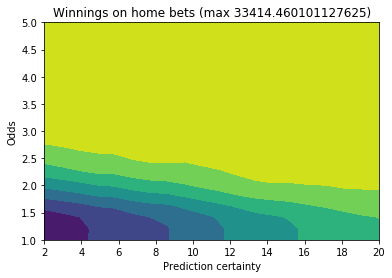

In [79]:
y = training_matches['Result'].values

odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_n in np.linspace(2,20,20):
        cash = 0
        
        for i in range(len(pred_t)):

            if pred_t[i] > pred_n and training_matches.iloc[i]['HomeTeamOdds'] > odd_t:
                cash -= bet

                if y[i] > 0:
                    cash += bet * training_matches.iloc[i]['HomeTeamOdds']

    #         elif away_prod[i] > t:
    #             cash -= bet
    #             bets += 1

    #             if y[i] < 0:
    #                 cash += bet * new_data_d.iloc[i]['WHA']

        winnings.append(cash)
        
    odd_winnings.append(winnings)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

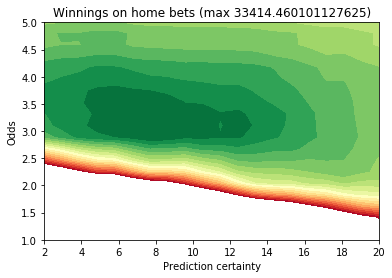

In [103]:
clevels = np.linspace(0,np.max(odd_winnings),20)

plt.contourf(np.linspace(2,20,20),np.linspace(1,5,20),odd_winnings, levels=clevels,cmap='RdYlGn')
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on home bets (max {})".format(np.max(odd_winnings)))
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:55:31<00:00, 346.59s/it]


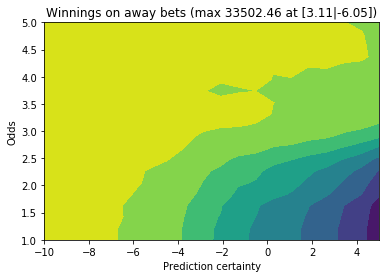

In [108]:

home_odd = 3
home_pred = 8
odd_winnings = []

for odd_t in tqdm(np.linspace(1,5,20)):
    
    winnings = []
    
    for pred_n in np.linspace(-10,5,20):
        cash = 0
        
        for i in range(len(pred_t)):

            if pred_t[i] > home_pred and training_matches.iloc[i]['HomeTeamOdds'] > home_odd:
                cash -= bet

                if y[i] > 0:
                    cash += bet * training_matches.iloc[i]['HomeTeamOdds']

            elif pred_t[i] < pred_n and training_matches.iloc[i]['AwayTeamOdds'] > odd_t:
                cash -= bet


                if y[i] < 0:
                    cash += bet * training_matches.iloc[i]['AwayTeamOdds']

        winnings.append(cash)
        
    odd_winnings.append(winnings)
    

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings)
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

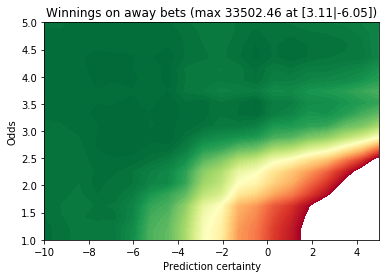

In [114]:
clevels = np.linspace(0,np.max(odd_winnings),100)

plt.contourf(np.linspace(-10,5,20),np.linspace(1,5,20),odd_winnings, levels=clevels,cmap='RdYlGn')
plt.xlabel("Prediction certainty")
plt.ylabel("Odds")
plt.title("Winnings on away bets (max {:.2f} at [{:.2f}|{:.2f}])".format(np.max(odd_winnings),
                                                               np.linspace(1,5,20)[int(np.floor(np.argmax(odd_winnings)/20))],
                                                              np.linspace(-10,5,20)[np.argmax(odd_winnings) % 20]))
plt.show()

Thresholds for home bets: odds 2.9 and prediction 6<br>
Slope for away bets: 0.5\*pred + 4  if odds < 3, else YES

Average return on bet: -11.250001192092896%
Bets made: 7 home, 1 away
-18.0000019073


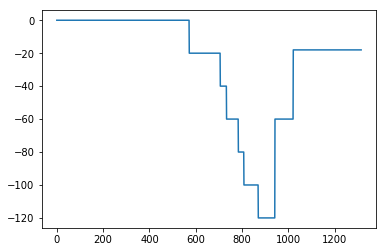

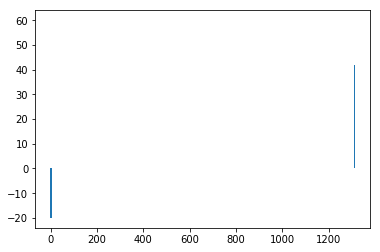

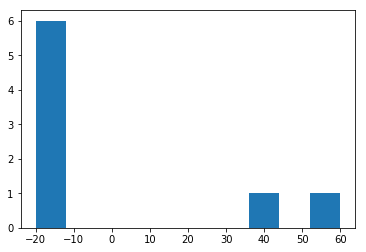

In [252]:
y = matches['Result'].values
cash = 0
bet = 20

tot_winnings = [cash]
winnings = []
home_odd = 3
home_pred = 8
away_odd = 3
away_pred = -5

home_bets = 0
away_bets = 0

for i in range(len(pred)-1,-1,-1):
    
    if pred[i] > home_pred and matches.iloc[i]['HomeTeamOdds'] > home_odd:
        cash -= bet
        home_bets += 1
        if y[i] > 0:
            cash += bet * matches.iloc[i]['HomeTeamOdds']
    elif pred[i] < away_pred and matches.iloc[i]['AwayTeamOdds'] > away_odd:
        cash -= bet
        away_bets += 1
        if y[i] < 0:
            cash += bet * matches.iloc[i]['AwayTeamOdds']
    
    tot_winnings.append(cash)
    winnings.append(tot_winnings[-1] - tot_winnings[-2])

print("Average return on bet: {}%".format((tot_winnings[-1]/bet)/(home_bets+away_bets)*100))
print("Bets made: {} home, {} away".format(home_bets,away_bets))
print(np.sum(winnings))
plt.plot(tot_winnings)
plt.show()
plt.bar(np.arange(len(winnings)),np.sort(winnings))
plt.show()
np.size(np.where(np.array(winnings) > 0))/(home_bets + away_bets)
plt.hist(np.array(winnings)[np.where(np.array(winnings) != 0)[0]],bins=10)
plt.show()